In [1]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from diff_predictor import core, data_process, predxgboost, spatial

import random

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from matplotlib import colors as plt_colors

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import operator

import xgboost as xgb
# from xgboost import cv

import shap

from itertools import combinations

Using current directory for loading/saving: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/notebooks
To change current directory, call change_dir(...)


In [11]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim
Using current directory for loading data: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users


In [12]:
dataset_path = workbookDir + '/data/age_feature_data/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
filelist

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/data/age_feature_data/'

In [5]:
sampled_filelist = []

class_lens = [0, 15, 30, 45]
for i in range(len(class_lens)-1):
    rand_integers = random.sample(set(np.arange(class_lens[i], class_lens[i+1])), 1)
    for rand_int in rand_integers:
        sampled_filelist.append(filelist[rand_int])
print(sampled_filelist)

['features_NT_brain_2_slice_3_vid_4.csv', 'features_P14_40nm_s1_v3.csv', 'features_P70_40nm_s1_v1.csv']


In [21]:
for i in range(1,16):
    comb = combinations(filelist[0:15], i)
    print(len(list(comb))**3)

216
3375
8000
3375
216
1
0
0
0
0
0
0
0
0
0


In [6]:
fstats_tot = data_process.generate_fullstats(dataset_path, sampled_filelist, ['P14', 'NT', 'P70'], 'age')

Adding file features_NT_brain_2_slice_3_vid_4.csv size: (598, 91)
Adding file features_P14_40nm_s1_v3.csv size: (519, 91)
Adding file features_P70_40nm_s1_v1.csv size: (27, 67)


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [414]:
# The column Deff2 currently has a super high number (~97%) of null values, so might be worth not including
# As such, it is commented out below
# columns = [
#     'alpha', # Fitted anomalous diffusion alpha exponenet
#     'D_fit', # Fitted anomalous diffusion coefficient
#     'kurtosis', # Kurtosis of track
#     'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
#     'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
#     'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
#     'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
#     'elongation', # Est. of amount of extension of trajectory from centroid
#     'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
#     'fractal_dim', # Measure of how complicated a self similar figure is
#     'trappedness', # Probability that a particle with Deff is trapped in a region
#     'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
#     'straightness', # Ratio of net displacement to the sum of squared step lengths
#     'MSD_ratio', # MSD ratio of the track
#     #'frames', # Number of frames the track spans
#     'Deff1', # Effective diffusion coefficient at 0.33 s
#  #   'Deff2', # Effective diffusion coefficient at 3.3 s
#     'Mean alpha',
#     'Mean D_fit',
#     'Mean kurtosis',
#     'Mean asymmetry1',
#     'Mean asymmetry2',
#     'Mean asymmetry3',
#     'Mean AR',
#     'Mean elongation',
#     'Mean boundedness',
#     'Mean fractal_dim',
#     'Mean trappedness',
#     'Mean efficiency',
#     'Mean straightness',
#     'Mean MSD_ratio',
#     'Mean Deff1',
#     #'Mean Deff2',
#     'X',
#     'Y',
#     'age'
# ]

# target = 'age'

In [4]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'region'

In [18]:
# ecm = fstats_tot[features]
# ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] # removes rows with nan or inf points

# #ecm = ecm.dropna()
# ecm.shape

In [8]:
ecm = fstats_tot[features + [target, 'Track_ID', 'X', 'Y']]
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(1153, 36)


(919, 36)

In [20]:
#ecm_test = ecm[~ecm['Mean Deff1'].isnull()]
#ecm_test = ecm_test[~ecm_test['alpha'].isnull()]
#ecm_test = ecm_test[~ecm_test['Deff1'].isnull()]

ecm_test.shape

NameError: name 'ecm_test' is not defined

In [244]:
(ecm_test[features].isna().sum())

alpha                    0
D_fit                    0
kurtosis                 0
asymmetry1               0
asymmetry2               0
asymmetry3               0
AR                       0
elongation               0
boundedness              0
fractal_dim              0
trappedness              0
efficiency               0
straightness             0
MSD_ratio                0
Deff1                    0
Deff2                32211
Mean alpha               0
Mean D_fit               0
Mean kurtosis            0
Mean asymmetry1          0
Mean asymmetry2          0
Mean asymmetry3          0
Mean AR                  0
Mean elongation          0
Mean boundedness         0
Mean fractal_dim         0
Mean trappedness         0
Mean efficiency          0
Mean straightness        0
Mean MSD_ratio           0
Mean Deff1               0
Mean Deff2           21698
dtype: int64

In [9]:
bal_ecm = data_process.balance_data(ecm, target)
#print(ecm[columns].isnull().sum()/len(ecm))


Ratio before data balance (NT:P14:P70) = 710:192:17
Ratio after balance (NT:P14:P70) = 17:17:17


In [10]:
bal_ecm[target].unique()

array(['NT', 'P14', 'P70'], dtype=object)

In [24]:
# sampled_df = pd.DataFrame()

# for targ in ecm[target].unique():
#     print(targ)
#     df = ecm[ecm[target] == targ]
#     #print(df[columns].isnull().sum()/len(df))
#     #print()
#     df_sample = df.sample(n=2500)
#     sampled_df = sampled_df.append(df_sample)

In [25]:
# sampled_df.head()

In [11]:
sampled_df = data_process.bin_data(bal_ecm)

In [27]:
sampled_df.columns

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'Deff1', 'Deff2',
       'Mean alpha', 'Mean D_fit', 'Mean kurtosis', 'Mean asymmetry1',
       'Mean asymmetry2', 'Mean asymmetry3', 'Mean AR', 'Mean elongation',
       'Mean boundedness', 'Mean fractal_dim', 'Mean trappedness',
       'Mean efficiency', 'Mean straightness', 'Mean MSD_ratio', 'Mean Deff1',
       'Mean Deff2', 'age', 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'],
      dtype='object')

In [12]:
label_df = sampled_df['age']
features_df = sampled_df.drop(['age', 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)

In [13]:
features = features_df.columns
features

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'Deff1', 'Deff2',
       'Mean alpha', 'Mean D_fit', 'Mean kurtosis', 'Mean asymmetry1',
       'Mean asymmetry2', 'Mean asymmetry3', 'Mean AR', 'Mean elongation',
       'Mean boundedness', 'Mean fractal_dim', 'Mean trappedness',
       'Mean efficiency', 'Mean straightness', 'Mean MSD_ratio', 'Mean Deff1',
       'Mean Deff2'],
      dtype='object')

In [14]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [15]:
X_train[features].columns

Index(['alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2', 'asymmetry3',
       'AR', 'elongation', 'boundedness', 'fractal_dim', 'trappedness',
       'efficiency', 'straightness', 'MSD_ratio', 'Deff1', 'Deff2',
       'Mean alpha', 'Mean D_fit', 'Mean kurtosis', 'Mean asymmetry1',
       'Mean asymmetry2', 'Mean asymmetry3', 'Mean AR', 'Mean elongation',
       'Mean boundedness', 'Mean fractal_dim', 'Mean trappedness',
       'Mean efficiency', 'Mean straightness', 'Mean MSD_ratio', 'Mean Deff1',
       'Mean Deff2'],
      dtype='object')

In [16]:
#Check lengths of datasets:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(sampled_df):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(sampled_df):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(sampled_df):.3f}%)')
    except:
        pass
get_lengths(sampled_df, X_train, X_test, X_val)

Tot before split: 51
Training: 25 (0.490%)
Testing: 13 (0.255%)
Evaluation: 13 (0.255%)


In [4]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
         # GPU integration will cut time in ~half:
         'gpu_id' : 0,
         'tree_method': 'gpu_hist',
         'predictor': 'gpu_predictor'
         }

In [19]:
]

In [95]:
dtrain


In [18]:
(best_model, best_param, best_eval, best_boost_rounds) = predxgboost.xgb_paramsearch(X_train, y_train, features, init_params=param, nfold=2, num_boost_round=2, early_stopping_rounds=1, use_gpu='True')

Using CV with subsample={0.9}, colsample_bytree={0.8}
New best param found: mlogloss = {1.0978378}, boost_rounds = {0}
Using CV with subsample={0.8}, colsample_bytree={0.8}
Using CV with subsample={0.8}, colsample_bytree={0.6}
Using CV with subsample={0.9}, colsample_bytree={0.9}
Using CV with subsample={0.8}, colsample_bytree={0.9}
Using CV with subsample={0.9}, colsample_bytree={0.6}
Using CV with subsample={0.7}, colsample_bytree={0.8}
Using CV with subsample={0.7}, colsample_bytree={0.9}
Using CV with subsample={0.7}, colsample_bytree={0.6}
Using CV with max_depth={10}, min_child_weight={8}
Using CV with max_depth={9}, min_child_weight={0}
New best param found: mlogloss = {1.0978378}, boost_rounds = {0}
Using CV with max_depth={5}, min_child_weight={10}
Using CV with max_depth={10}, min_child_weight={10}
Using CV with max_depth={5}, min_child_weight={6}
Using CV with max_depth={9}, min_child_weight={8}
Using CV with max_depth={10}, min_child_weight={6}
Using CV with max_depth={9}, 

Using CV with subsample={0.8}, colsample_bytree={0.9}
Using CV with subsample={0.9}, colsample_bytree={0.6}
Using CV with subsample={0.7}, colsample_bytree={0.8}
New best param found: mlogloss = {0.9738201999999999}, boost_rounds = {1}
Using CV with subsample={0.7}, colsample_bytree={0.9}
Using CV with subsample={0.7}, colsample_bytree={0.6}
New best param found: mlogloss = {0.9688856}, boost_rounds = {1}
Using CV with max_depth={10}, min_child_weight={8}
Using CV with max_depth={9}, min_child_weight={0}
New best param found: mlogloss = {0.9688856}, boost_rounds = {1}
Using CV with max_depth={5}, min_child_weight={10}
Using CV with max_depth={10}, min_child_weight={10}
Using CV with max_depth={5}, min_child_weight={6}
Using CV with max_depth={9}, min_child_weight={8}
Using CV with max_depth={10}, min_child_weight={6}
Using CV with max_depth={9}, min_child_weight={10}
Using CV with max_depth={1}, min_child_weight={8}
Using CV with max_depth={1}, min_child_weight={6}
Using CV with max_de

In [26]:
(best_boost_rounds[1])

{'max_depth': 9,
 'eta': 0.3,
 'min_child_weight': 0,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 3,
 'silent': 'True',
 'gamma': 0,
 'subsample': 0.7,
 'colsample_bytree': 0.6,
 'eval_metric': 'mlogloss',
 'gpu_id': 0,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

In [215]:
best_param = {'max_depth': 5,
  'eta': 0.01,
  'min_child_weight': 10,
  'verbosity': 0,
  'objective': 'multi:softprob',
  'num_class': 3,
  'silent': 'True',
  'gamma': 0,
  'subsample': 0.6,
  'colsample_bytree': 0.9,
  'eval_metric': 'mlogloss',
  'gpu_id': 0,
  'tree_method': 'gpu_hist',
  'predictor': 'gpu_predictor'}

In [23]:
def train(param, dtrain, dtest, dval=None, evals=[(dtrain, 'train')], num_round=40):
    if dval is not None and (dval, 'eval') not in evals:
        evals += [(dval, 'eval')]
    model = xgb.train(param, dtrain, num_round, evals, )
    true_label = dtest.get_label()
    ypred = model.predict(dtest)
    preds = [np.where(x == np.max(x))[0][0] for x in ypred]
    acc = metrics.accuracy_score(true_label, preds)
    print("Accuracy:",acc)
    return model, acc, true_label, preds
booster, acc, true_label, preds = train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=1000)


In [261]:
class_names = [str(le.classes_[0]), str(le.classes_[1]), str(le.classes_[2])]
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

          NT     0.8269    0.7672    0.7959      1632
         P14     0.8862    0.9049    0.8954      1609
         P70     0.8723    0.9212    0.8961      1498

    accuracy                         0.8626      4739
   macro avg     0.8618    0.8644    0.8625      4739
weighted avg     0.8614    0.8626    0.8614      4739



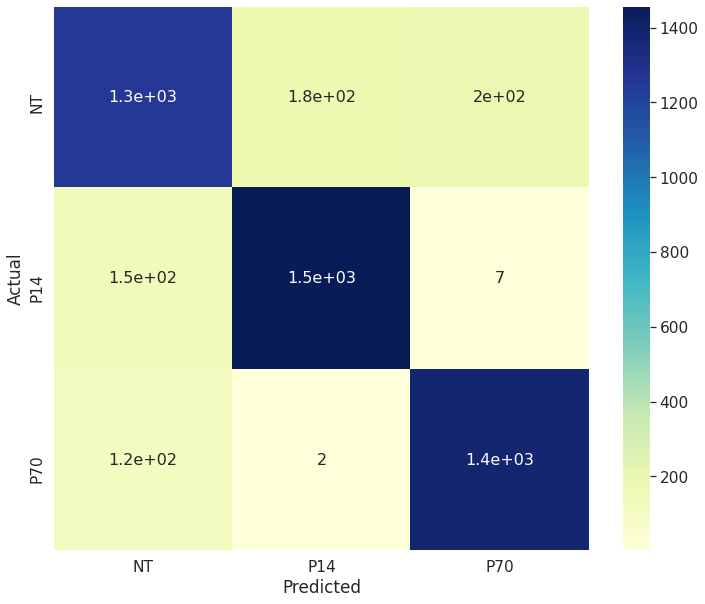

In [262]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [263]:
model_bytearray = booster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

booster.save_raw = myfun

In [264]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [265]:
c_14 = '#E69F00'
c_35 = '#56B4E9'
c_70 = '#009E73'

colors = [c_70, c_35, c_14]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

In [266]:
class_inds

array([2, 1, 0])

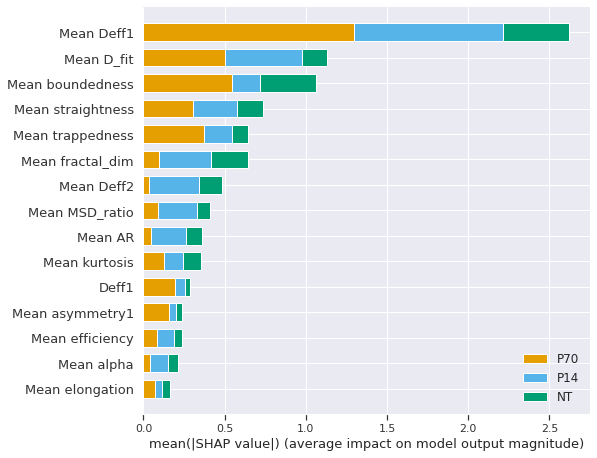

In [267]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

We ran 3 xgboost hyperparameter search runs on ALL 15 FILES per class to see if they would produce different sets of hyperparameters, and now we will see if they give different accuracies. 

In [34]:
run_one_params = {'max_depth': 3, 'eta': 0.01, 'min_child_weight': 0, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0.5, 'subsample': 0.6, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}
run_one_boost_rounds = 771

run_two_params = {'max_depth': 5, 'eta': 0.01, 'min_child_weight': 10, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}
run_two_boost_rounds = 641

run_three_params = {'max_depth': 3, 'eta': 0.01, 'min_child_weight': 10, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}
run_three_boost_rounds = 809


In [35]:
# Training based on run one params
from sklearn import metrics
booster, acc, true_label, preds = predxgboost.train(run_one_params, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=run_one_boost_rounds)


[0]	train-mlogloss:1.09110	eval-mlogloss:1.09108
[1]	train-mlogloss:1.08440	eval-mlogloss:1.08447
[2]	train-mlogloss:1.07691	eval-mlogloss:1.07715
[3]	train-mlogloss:1.07032	eval-mlogloss:1.07059
[4]	train-mlogloss:1.06322	eval-mlogloss:1.06356
[5]	train-mlogloss:1.05650	eval-mlogloss:1.05683
[6]	train-mlogloss:1.04905	eval-mlogloss:1.04946
[7]	train-mlogloss:1.04338	eval-mlogloss:1.04377
[8]	train-mlogloss:1.03821	eval-mlogloss:1.03874
[9]	train-mlogloss:1.03146	eval-mlogloss:1.03203
[10]	train-mlogloss:1.02547	eval-mlogloss:1.02614
[11]	train-mlogloss:1.01972	eval-mlogloss:1.02052
[12]	train-mlogloss:1.01300	eval-mlogloss:1.01384
[13]	train-mlogloss:1.00747	eval-mlogloss:1.00844
[14]	train-mlogloss:1.00072	eval-mlogloss:1.00178
[15]	train-mlogloss:0.99461	eval-mlogloss:0.99568
[16]	train-mlogloss:0.98831	eval-mlogloss:0.98940
[17]	train-mlogloss:0.98210	eval-mlogloss:0.98326
[18]	train-mlogloss:0.97663	eval-mlogloss:0.97783
[19]	train-mlogloss:0.97042	eval-mlogloss:0.97156
[20]	train

[163]	train-mlogloss:0.55392	eval-mlogloss:0.56709
[164]	train-mlogloss:0.55260	eval-mlogloss:0.56586
[165]	train-mlogloss:0.55112	eval-mlogloss:0.56450
[166]	train-mlogloss:0.54981	eval-mlogloss:0.56326
[167]	train-mlogloss:0.54845	eval-mlogloss:0.56210
[168]	train-mlogloss:0.54698	eval-mlogloss:0.56080
[169]	train-mlogloss:0.54570	eval-mlogloss:0.55962
[170]	train-mlogloss:0.54465	eval-mlogloss:0.55864
[171]	train-mlogloss:0.54365	eval-mlogloss:0.55773
[172]	train-mlogloss:0.54234	eval-mlogloss:0.55650
[173]	train-mlogloss:0.54086	eval-mlogloss:0.55520
[174]	train-mlogloss:0.53959	eval-mlogloss:0.55406
[175]	train-mlogloss:0.53826	eval-mlogloss:0.55277
[176]	train-mlogloss:0.53704	eval-mlogloss:0.55165
[177]	train-mlogloss:0.53582	eval-mlogloss:0.55048
[178]	train-mlogloss:0.53474	eval-mlogloss:0.54944
[179]	train-mlogloss:0.53360	eval-mlogloss:0.54841
[180]	train-mlogloss:0.53244	eval-mlogloss:0.54739
[181]	train-mlogloss:0.53138	eval-mlogloss:0.54637
[182]	train-mlogloss:0.53021	ev

[324]	train-mlogloss:0.41732	eval-mlogloss:0.44898
[325]	train-mlogloss:0.41681	eval-mlogloss:0.44858
[326]	train-mlogloss:0.41629	eval-mlogloss:0.44821
[327]	train-mlogloss:0.41574	eval-mlogloss:0.44774
[328]	train-mlogloss:0.41520	eval-mlogloss:0.44736
[329]	train-mlogloss:0.41470	eval-mlogloss:0.44700
[330]	train-mlogloss:0.41417	eval-mlogloss:0.44659
[331]	train-mlogloss:0.41364	eval-mlogloss:0.44619
[332]	train-mlogloss:0.41317	eval-mlogloss:0.44580
[333]	train-mlogloss:0.41261	eval-mlogloss:0.44536
[334]	train-mlogloss:0.41216	eval-mlogloss:0.44500
[335]	train-mlogloss:0.41169	eval-mlogloss:0.44464
[336]	train-mlogloss:0.41126	eval-mlogloss:0.44440
[337]	train-mlogloss:0.41078	eval-mlogloss:0.44402
[338]	train-mlogloss:0.41030	eval-mlogloss:0.44365
[339]	train-mlogloss:0.40985	eval-mlogloss:0.44331
[340]	train-mlogloss:0.40937	eval-mlogloss:0.44292
[341]	train-mlogloss:0.40895	eval-mlogloss:0.44264
[342]	train-mlogloss:0.40844	eval-mlogloss:0.44231
[343]	train-mlogloss:0.40794	ev

[485]	train-mlogloss:0.35495	eval-mlogloss:0.40475
[486]	train-mlogloss:0.35465	eval-mlogloss:0.40451
[487]	train-mlogloss:0.35439	eval-mlogloss:0.40435
[488]	train-mlogloss:0.35413	eval-mlogloss:0.40418
[489]	train-mlogloss:0.35383	eval-mlogloss:0.40400
[490]	train-mlogloss:0.35354	eval-mlogloss:0.40380
[491]	train-mlogloss:0.35324	eval-mlogloss:0.40363
[492]	train-mlogloss:0.35299	eval-mlogloss:0.40347
[493]	train-mlogloss:0.35276	eval-mlogloss:0.40333
[494]	train-mlogloss:0.35243	eval-mlogloss:0.40314
[495]	train-mlogloss:0.35214	eval-mlogloss:0.40297
[496]	train-mlogloss:0.35191	eval-mlogloss:0.40277
[497]	train-mlogloss:0.35167	eval-mlogloss:0.40260
[498]	train-mlogloss:0.35135	eval-mlogloss:0.40245
[499]	train-mlogloss:0.35110	eval-mlogloss:0.40226
[500]	train-mlogloss:0.35080	eval-mlogloss:0.40215
[501]	train-mlogloss:0.35052	eval-mlogloss:0.40197
[502]	train-mlogloss:0.35018	eval-mlogloss:0.40176
[503]	train-mlogloss:0.34990	eval-mlogloss:0.40160
[504]	train-mlogloss:0.34968	ev

[646]	train-mlogloss:0.31622	eval-mlogloss:0.38351
[647]	train-mlogloss:0.31603	eval-mlogloss:0.38347
[648]	train-mlogloss:0.31580	eval-mlogloss:0.38337
[649]	train-mlogloss:0.31563	eval-mlogloss:0.38325
[650]	train-mlogloss:0.31545	eval-mlogloss:0.38315
[651]	train-mlogloss:0.31519	eval-mlogloss:0.38303
[652]	train-mlogloss:0.31498	eval-mlogloss:0.38296
[653]	train-mlogloss:0.31481	eval-mlogloss:0.38285
[654]	train-mlogloss:0.31461	eval-mlogloss:0.38276
[655]	train-mlogloss:0.31436	eval-mlogloss:0.38260
[656]	train-mlogloss:0.31420	eval-mlogloss:0.38256
[657]	train-mlogloss:0.31401	eval-mlogloss:0.38248
[658]	train-mlogloss:0.31380	eval-mlogloss:0.38233
[659]	train-mlogloss:0.31360	eval-mlogloss:0.38221
[660]	train-mlogloss:0.31339	eval-mlogloss:0.38213
[661]	train-mlogloss:0.31325	eval-mlogloss:0.38206
[662]	train-mlogloss:0.31306	eval-mlogloss:0.38197
[663]	train-mlogloss:0.31285	eval-mlogloss:0.38190
[664]	train-mlogloss:0.31267	eval-mlogloss:0.38179
[665]	train-mlogloss:0.31250	ev

In [36]:
class_names = [str(le.classes_[0]), str(le.classes_[1]), str(le.classes_[2])]
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

          NT     0.8231    0.7439    0.7815      1632
         P14     0.8719    0.9055    0.8884      1609
         P70     0.8581    0.9126    0.8845      1498

    accuracy                         0.8521      4739
   macro avg     0.8510    0.8540    0.8515      4739
weighted avg     0.8507    0.8521    0.8503      4739



In [44]:
# Training based on run two parameters
booster, acc, true_label, preds = predxgboost.train(run_two_params, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=run_two_boost_rounds)


[0]	train-mlogloss:1.08956	eval-mlogloss:1.09005
[1]	train-mlogloss:1.08161	eval-mlogloss:1.08279
[2]	train-mlogloss:1.07303	eval-mlogloss:1.07489
[3]	train-mlogloss:1.06506	eval-mlogloss:1.06743
[4]	train-mlogloss:1.05690	eval-mlogloss:1.05977
[5]	train-mlogloss:1.04899	eval-mlogloss:1.05224
[6]	train-mlogloss:1.04034	eval-mlogloss:1.04406
[7]	train-mlogloss:1.03343	eval-mlogloss:1.03767
[8]	train-mlogloss:1.02691	eval-mlogloss:1.03174
[9]	train-mlogloss:1.01918	eval-mlogloss:1.02431
[10]	train-mlogloss:1.01214	eval-mlogloss:1.01793
[11]	train-mlogloss:1.00545	eval-mlogloss:1.01155
[12]	train-mlogloss:0.99752	eval-mlogloss:1.00415
[13]	train-mlogloss:0.99100	eval-mlogloss:0.99812
[14]	train-mlogloss:0.98341	eval-mlogloss:0.99087
[15]	train-mlogloss:0.97638	eval-mlogloss:0.98420
[16]	train-mlogloss:0.96891	eval-mlogloss:0.97725
[17]	train-mlogloss:0.96162	eval-mlogloss:0.97047
[18]	train-mlogloss:0.95512	eval-mlogloss:0.96445
[19]	train-mlogloss:0.94807	eval-mlogloss:0.95772
[20]	train

[163]	train-mlogloss:0.46499	eval-mlogloss:0.52228
[164]	train-mlogloss:0.46351	eval-mlogloss:0.52107
[165]	train-mlogloss:0.46185	eval-mlogloss:0.51964
[166]	train-mlogloss:0.46042	eval-mlogloss:0.51846
[167]	train-mlogloss:0.45895	eval-mlogloss:0.51731
[168]	train-mlogloss:0.45733	eval-mlogloss:0.51597
[169]	train-mlogloss:0.45590	eval-mlogloss:0.51479
[170]	train-mlogloss:0.45467	eval-mlogloss:0.51370
[171]	train-mlogloss:0.45351	eval-mlogloss:0.51275
[172]	train-mlogloss:0.45194	eval-mlogloss:0.51155
[173]	train-mlogloss:0.45029	eval-mlogloss:0.51025
[174]	train-mlogloss:0.44881	eval-mlogloss:0.50906
[175]	train-mlogloss:0.44731	eval-mlogloss:0.50784
[176]	train-mlogloss:0.44583	eval-mlogloss:0.50668
[177]	train-mlogloss:0.44443	eval-mlogloss:0.50557
[178]	train-mlogloss:0.44319	eval-mlogloss:0.50456
[179]	train-mlogloss:0.44185	eval-mlogloss:0.50348
[180]	train-mlogloss:0.44051	eval-mlogloss:0.50244
[181]	train-mlogloss:0.43933	eval-mlogloss:0.50150
[182]	train-mlogloss:0.43800	ev

[324]	train-mlogloss:0.31002	eval-mlogloss:0.40861
[325]	train-mlogloss:0.30947	eval-mlogloss:0.40820
[326]	train-mlogloss:0.30895	eval-mlogloss:0.40784
[327]	train-mlogloss:0.30840	eval-mlogloss:0.40748
[328]	train-mlogloss:0.30780	eval-mlogloss:0.40712
[329]	train-mlogloss:0.30733	eval-mlogloss:0.40683
[330]	train-mlogloss:0.30670	eval-mlogloss:0.40638
[331]	train-mlogloss:0.30616	eval-mlogloss:0.40601
[332]	train-mlogloss:0.30554	eval-mlogloss:0.40569
[333]	train-mlogloss:0.30501	eval-mlogloss:0.40533
[334]	train-mlogloss:0.30452	eval-mlogloss:0.40497
[335]	train-mlogloss:0.30405	eval-mlogloss:0.40470
[336]	train-mlogloss:0.30361	eval-mlogloss:0.40437
[337]	train-mlogloss:0.30314	eval-mlogloss:0.40407
[338]	train-mlogloss:0.30261	eval-mlogloss:0.40371
[339]	train-mlogloss:0.30206	eval-mlogloss:0.40332
[340]	train-mlogloss:0.30157	eval-mlogloss:0.40297
[341]	train-mlogloss:0.30103	eval-mlogloss:0.40268
[342]	train-mlogloss:0.30044	eval-mlogloss:0.40236
[343]	train-mlogloss:0.29994	ev

[485]	train-mlogloss:0.24472	eval-mlogloss:0.37294
[486]	train-mlogloss:0.24446	eval-mlogloss:0.37281
[487]	train-mlogloss:0.24421	eval-mlogloss:0.37261
[488]	train-mlogloss:0.24393	eval-mlogloss:0.37249
[489]	train-mlogloss:0.24363	eval-mlogloss:0.37235
[490]	train-mlogloss:0.24339	eval-mlogloss:0.37220
[491]	train-mlogloss:0.24313	eval-mlogloss:0.37210
[492]	train-mlogloss:0.24287	eval-mlogloss:0.37196
[493]	train-mlogloss:0.24265	eval-mlogloss:0.37187
[494]	train-mlogloss:0.24237	eval-mlogloss:0.37174
[495]	train-mlogloss:0.24211	eval-mlogloss:0.37162
[496]	train-mlogloss:0.24191	eval-mlogloss:0.37148
[497]	train-mlogloss:0.24163	eval-mlogloss:0.37138
[498]	train-mlogloss:0.24131	eval-mlogloss:0.37127
[499]	train-mlogloss:0.24103	eval-mlogloss:0.37116
[500]	train-mlogloss:0.24068	eval-mlogloss:0.37102
[501]	train-mlogloss:0.24041	eval-mlogloss:0.37091
[502]	train-mlogloss:0.24016	eval-mlogloss:0.37073
[503]	train-mlogloss:0.23992	eval-mlogloss:0.37068
[504]	train-mlogloss:0.23967	ev

In [45]:
class_names = [str(le.classes_[0]), str(le.classes_[1]), str(le.classes_[2])]
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

          NT     0.8345    0.7567    0.7937      1632
         P14     0.8797    0.9086    0.8939      1609
         P70     0.8685    0.9259    0.8963      1498

    accuracy                         0.8618      4739
   macro avg     0.8609    0.8638    0.8613      4739
weighted avg     0.8606    0.8618    0.8602      4739



In [40]:
booster, acc, true_label, preds = predxgboost.train(run_three_params, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=run_three_boost_rounds)


[0]	train-mlogloss:1.09110	eval-mlogloss:1.09107
[1]	train-mlogloss:1.08441	eval-mlogloss:1.08445
[2]	train-mlogloss:1.07691	eval-mlogloss:1.07712
[3]	train-mlogloss:1.07033	eval-mlogloss:1.07060
[4]	train-mlogloss:1.06323	eval-mlogloss:1.06358
[5]	train-mlogloss:1.05651	eval-mlogloss:1.05684
[6]	train-mlogloss:1.04906	eval-mlogloss:1.04946
[7]	train-mlogloss:1.04339	eval-mlogloss:1.04377
[8]	train-mlogloss:1.03822	eval-mlogloss:1.03874
[9]	train-mlogloss:1.03148	eval-mlogloss:1.03205
[10]	train-mlogloss:1.02549	eval-mlogloss:1.02616
[11]	train-mlogloss:1.01976	eval-mlogloss:1.02057
[12]	train-mlogloss:1.01303	eval-mlogloss:1.01388
[13]	train-mlogloss:1.00750	eval-mlogloss:1.00847
[14]	train-mlogloss:1.00076	eval-mlogloss:1.00180
[15]	train-mlogloss:0.99465	eval-mlogloss:0.99572
[16]	train-mlogloss:0.98835	eval-mlogloss:0.98943
[17]	train-mlogloss:0.98214	eval-mlogloss:0.98329
[18]	train-mlogloss:0.97667	eval-mlogloss:0.97786
[19]	train-mlogloss:0.97047	eval-mlogloss:0.97160
[20]	train

[163]	train-mlogloss:0.55437	eval-mlogloss:0.56711
[164]	train-mlogloss:0.55305	eval-mlogloss:0.56588
[165]	train-mlogloss:0.55158	eval-mlogloss:0.56452
[166]	train-mlogloss:0.55027	eval-mlogloss:0.56328
[167]	train-mlogloss:0.54891	eval-mlogloss:0.56213
[168]	train-mlogloss:0.54744	eval-mlogloss:0.56082
[169]	train-mlogloss:0.54615	eval-mlogloss:0.55961
[170]	train-mlogloss:0.54511	eval-mlogloss:0.55863
[171]	train-mlogloss:0.54412	eval-mlogloss:0.55771
[172]	train-mlogloss:0.54281	eval-mlogloss:0.55646
[173]	train-mlogloss:0.54134	eval-mlogloss:0.55517
[174]	train-mlogloss:0.54007	eval-mlogloss:0.55401
[175]	train-mlogloss:0.53875	eval-mlogloss:0.55271
[176]	train-mlogloss:0.53753	eval-mlogloss:0.55161
[177]	train-mlogloss:0.53631	eval-mlogloss:0.55044
[178]	train-mlogloss:0.53524	eval-mlogloss:0.54941
[179]	train-mlogloss:0.53412	eval-mlogloss:0.54838
[180]	train-mlogloss:0.53296	eval-mlogloss:0.54736
[181]	train-mlogloss:0.53190	eval-mlogloss:0.54634
[182]	train-mlogloss:0.53075	ev

[324]	train-mlogloss:0.41902	eval-mlogloss:0.44868
[325]	train-mlogloss:0.41852	eval-mlogloss:0.44827
[326]	train-mlogloss:0.41803	eval-mlogloss:0.44791
[327]	train-mlogloss:0.41749	eval-mlogloss:0.44747
[328]	train-mlogloss:0.41695	eval-mlogloss:0.44707
[329]	train-mlogloss:0.41647	eval-mlogloss:0.44672
[330]	train-mlogloss:0.41593	eval-mlogloss:0.44629
[331]	train-mlogloss:0.41543	eval-mlogloss:0.44590
[332]	train-mlogloss:0.41496	eval-mlogloss:0.44551
[333]	train-mlogloss:0.41443	eval-mlogloss:0.44508
[334]	train-mlogloss:0.41400	eval-mlogloss:0.44475
[335]	train-mlogloss:0.41354	eval-mlogloss:0.44438
[336]	train-mlogloss:0.41313	eval-mlogloss:0.44415
[337]	train-mlogloss:0.41265	eval-mlogloss:0.44377
[338]	train-mlogloss:0.41216	eval-mlogloss:0.44340
[339]	train-mlogloss:0.41174	eval-mlogloss:0.44303
[340]	train-mlogloss:0.41126	eval-mlogloss:0.44264
[341]	train-mlogloss:0.41086	eval-mlogloss:0.44237
[342]	train-mlogloss:0.41036	eval-mlogloss:0.44203
[343]	train-mlogloss:0.40991	ev

[485]	train-mlogloss:0.35847	eval-mlogloss:0.40455
[486]	train-mlogloss:0.35821	eval-mlogloss:0.40436
[487]	train-mlogloss:0.35795	eval-mlogloss:0.40420
[488]	train-mlogloss:0.35771	eval-mlogloss:0.40403
[489]	train-mlogloss:0.35742	eval-mlogloss:0.40384
[490]	train-mlogloss:0.35716	eval-mlogloss:0.40364
[491]	train-mlogloss:0.35688	eval-mlogloss:0.40348
[492]	train-mlogloss:0.35662	eval-mlogloss:0.40332
[493]	train-mlogloss:0.35638	eval-mlogloss:0.40317
[494]	train-mlogloss:0.35607	eval-mlogloss:0.40299
[495]	train-mlogloss:0.35578	eval-mlogloss:0.40281
[496]	train-mlogloss:0.35556	eval-mlogloss:0.40259
[497]	train-mlogloss:0.35526	eval-mlogloss:0.40243
[498]	train-mlogloss:0.35495	eval-mlogloss:0.40229
[499]	train-mlogloss:0.35470	eval-mlogloss:0.40213
[500]	train-mlogloss:0.35441	eval-mlogloss:0.40199
[501]	train-mlogloss:0.35414	eval-mlogloss:0.40182
[502]	train-mlogloss:0.35382	eval-mlogloss:0.40162
[503]	train-mlogloss:0.35352	eval-mlogloss:0.40140
[504]	train-mlogloss:0.35331	ev

[646]	train-mlogloss:0.32138	eval-mlogloss:0.38306
[647]	train-mlogloss:0.32120	eval-mlogloss:0.38301
[648]	train-mlogloss:0.32098	eval-mlogloss:0.38293
[649]	train-mlogloss:0.32081	eval-mlogloss:0.38280
[650]	train-mlogloss:0.32065	eval-mlogloss:0.38273
[651]	train-mlogloss:0.32043	eval-mlogloss:0.38261
[652]	train-mlogloss:0.32022	eval-mlogloss:0.38252
[653]	train-mlogloss:0.32006	eval-mlogloss:0.38241
[654]	train-mlogloss:0.31986	eval-mlogloss:0.38233
[655]	train-mlogloss:0.31960	eval-mlogloss:0.38220
[656]	train-mlogloss:0.31944	eval-mlogloss:0.38216
[657]	train-mlogloss:0.31927	eval-mlogloss:0.38210
[658]	train-mlogloss:0.31906	eval-mlogloss:0.38196
[659]	train-mlogloss:0.31887	eval-mlogloss:0.38183
[660]	train-mlogloss:0.31868	eval-mlogloss:0.38172
[661]	train-mlogloss:0.31852	eval-mlogloss:0.38163
[662]	train-mlogloss:0.31833	eval-mlogloss:0.38155
[663]	train-mlogloss:0.31814	eval-mlogloss:0.38147
[664]	train-mlogloss:0.31795	eval-mlogloss:0.38137
[665]	train-mlogloss:0.31780	ev

[807]	train-mlogloss:0.29488	eval-mlogloss:0.37081
[808]	train-mlogloss:0.29469	eval-mlogloss:0.37073
Accuracy: 0.8514454526271366


In [41]:
class_names = [str(le.classes_[0]), str(le.classes_[1]), str(le.classes_[2])]
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

          NT     0.8214    0.7439    0.7807      1632
         P14     0.8717    0.9037    0.8874      1609
         P70     0.8581    0.9126    0.8845      1498

    accuracy                         0.8514      4739
   macro avg     0.8504    0.8534    0.8509      4739
weighted avg     0.8501    0.8514    0.8497      4739



Next step is to do different samples of data

In [45]:
run_one_files = ['features_NT_brain_2_slice_3_vid_2.csv', 
'features_NT_brain_2_slice_2_vid_5.csv', 
'features_NT_brain_2_slice_2_vid_3.csv', 
'features_NT_brain_2_slice_1_vid_1.csv', 
'features_NT_brain_2_slice_3_vid_5.csv', 
'features_P14_40nm_s3_v5.csv',
'features_P14_40nm_s1_v4.csv', 
'features_P14_40nm_s3_v2.csv', 
'features_P14_40nm_s2_v2.csv',
'features_P14_40nm_s2_v4.csv',
'features_P70_40nm_s3_v4.csv',
'features_P70_40nm_s1_v3.csv',
'features_P70_40nm_s1_v5.csv',
'features_P70_40nm_s2_v3.csv',
'features_P70_40nm_s2_v1.csv']

run_one_params = {'max_depth': 5, 'eta': 0.01, 'min_child_weight': 2, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}
run_one_boost_rounds = 492

run_two_files = [
    'features_NT_brain_2_slice_3_vid_4.csv',
    'features_NT_brain_2_slice_2_vid_5.csv',
    'features_NT_brain_2_slice_1_vid_4.csv',
    'features_NT_brain_2_slice_1_vid_5.csv',
    'features_NT_brain_2_slice_3_vid_3.csv',
    'features_P14_40nm_s2_v3.csv',
    'features_P14_40nm_s2_v5.csv',
    'features_P14_40nm_s3_v1.csv',
    'features_P14_40nm_s2_v1.csv',
    'features_P14_40nm_s1_v1.csv',
    'features_P70_40nm_s3_v3.csv',
    'features_P70_40nm_s2_v4.csv',
    'features_P70_40nm_s1_v3.csv',
    'features_P70_40nm_s2_v5.csv',
    'features_P70_40nm_s1_v4.csv'
]

run_two_params={'max_depth': 3, 'eta': 0.01, 'min_child_weight': 2, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0.5, 'subsample': 0.6, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}
run_two_boost_rounds = 631

run_three_files = [
    'features_NT_brain_2_slice_2_vid_4.csv',
    'features_NT_brain_2_slice_2_vid_3.csv',
    'features_NT_brain_2_slice_3_vid_2.csv',
    'features_NT_brain_2_slice_3_vid_3.csv',
    'features_NT_brain_2_slice_2_vid_2.csv',
    'features_P14_40nm_s2_v1.csv',
    'features_P14_40nm_s1_v2.csv',
    'features_P14_40nm_s2_v2.csv',
    'features_P14_40nm_s1_v5.csv',
    'features_P14_40nm_s1_v1.csv',
    'features_P70_40nm_s2_v3.csv',
    'features_P70_40nm_s2_v2.csv',
    'features_P70_40nm_s2_v5.csv',
    'features_P70_40nm_s2_v1.csv',
    'features_P70_40nm_s3_v3.csv'
]

run_three_params = {'max_depth': 5, 'eta': 0.01, 'min_child_weight': 10, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0.5, 'subsample': 1.0, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}
run_three_boost_rounds = 532


In [29]:
def data_process_pipeline(path, filelist, features):
    fstats_tot = data_process.generate_fullstats(path, filelist, ['P14', 'NT', 'P70'], 'age')
    ecm = fstats_tot[features + [target, 'Track_ID', 'X', 'Y']]
    ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)] 
    bal_ecm = data_process.balance_data(ecm, target)
    sampled_df = data_process.bin_data(bal_ecm)
    label_df = sampled_df['age']
    features_df = sampled_df.drop(['age', 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns
    
    seed = 1234
    np.random.seed(seed)
    train_split = 0.5
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    
    return dtrain, dtest, dval

In [32]:
run_one_dtrain, run_one_dtest, run_one_dval = data_process_pipeline(dataset_path, run_one_files, features)
run_two_dtrain, run_two_dtest, run_two_dval = data_process_pipeline(dataset_path, run_two_files, features)
run_three_dtrain, run_three_dtest, run_three_dval = data_process_pipeline(dataset_path, run_three_files, features)

Adding file features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
Adding file features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
Adding file features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
Adding file features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
Adding file features_NT_brain_2_slice_3_vid_5.csv size: (1062, 91)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P14_40nm_s2_v2.csv size: (938, 91)
Adding file features_P14_40nm_s2_v4.csv size: (162, 91)
Adding file features_P70_40nm_s3_v4.csv size: (2909, 67)
Adding file features_P70_40nm_s1_v3.csv size: (25, 67)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P70_40nm_s2_v3.csv size: (240, 67)
Adding file features_P70_40nm_s2_v1.csv size: (148, 67)
Ratio before data balance (NT:P14:P70) = 5181:1461:3172
Ratio after balance (NT:P14:P70) = 1461:1461:1461
Ad

We will train all 3 subsets of data on the parameters and boost rounds found for first round

In [33]:
booster, run_one_acc, run_one_true_label, run_one_preds = predxgboost.train(run_one_params, run_one_dtrain, run_one_dtest, run_one_dval, evals=[(run_one_dtrain, 'train'), (run_one_dval, 'eval')], num_round=run_one_boost_rounds)
booster, run_two_acc, run_two_true_label, run_two_preds = predxgboost.train(run_one_params, run_two_dtrain, run_two_dtest, run_two_dval, evals=[(run_two_dtrain, 'train'), (run_two_dval, 'eval')], num_round=run_one_boost_rounds)
booster, run_three_acc, run_three_true_label, run_three_preds = predxgboost.train(run_one_params, run_three_dtrain, run_three_dtest, run_three_dval, evals=[(run_three_dtrain, 'train'), (run_three_dval, 'eval')], num_round=run_one_boost_rounds)


[0]	train-mlogloss:1.08846	eval-mlogloss:1.09046
[1]	train-mlogloss:1.07878	eval-mlogloss:1.08308
[2]	train-mlogloss:1.06884	eval-mlogloss:1.07531
[3]	train-mlogloss:1.06011	eval-mlogloss:1.06859
[4]	train-mlogloss:1.05112	eval-mlogloss:1.06139
[5]	train-mlogloss:1.04269	eval-mlogloss:1.05419
[6]	train-mlogloss:1.03293	eval-mlogloss:1.04650
[7]	train-mlogloss:1.02505	eval-mlogloss:1.04049
[8]	train-mlogloss:1.01676	eval-mlogloss:1.03503
[9]	train-mlogloss:1.00788	eval-mlogloss:1.02791
[10]	train-mlogloss:0.99899	eval-mlogloss:1.02156
[11]	train-mlogloss:0.99093	eval-mlogloss:1.01566
[12]	train-mlogloss:0.98199	eval-mlogloss:1.00864
[13]	train-mlogloss:0.97474	eval-mlogloss:1.00289
[14]	train-mlogloss:0.96623	eval-mlogloss:0.99602
[15]	train-mlogloss:0.95829	eval-mlogloss:0.98937
[16]	train-mlogloss:0.95009	eval-mlogloss:0.98238
[17]	train-mlogloss:0.94171	eval-mlogloss:0.97596
[18]	train-mlogloss:0.93406	eval-mlogloss:0.96993
[19]	train-mlogloss:0.92590	eval-mlogloss:0.96355
[20]	train

[163]	train-mlogloss:0.37377	eval-mlogloss:0.55686
[164]	train-mlogloss:0.37179	eval-mlogloss:0.55576
[165]	train-mlogloss:0.36979	eval-mlogloss:0.55433
[166]	train-mlogloss:0.36797	eval-mlogloss:0.55338
[167]	train-mlogloss:0.36628	eval-mlogloss:0.55241
[168]	train-mlogloss:0.36439	eval-mlogloss:0.55117
[169]	train-mlogloss:0.36283	eval-mlogloss:0.55024
[170]	train-mlogloss:0.36139	eval-mlogloss:0.54933
[171]	train-mlogloss:0.35984	eval-mlogloss:0.54860
[172]	train-mlogloss:0.35815	eval-mlogloss:0.54746
[173]	train-mlogloss:0.35625	eval-mlogloss:0.54607
[174]	train-mlogloss:0.35453	eval-mlogloss:0.54479
[175]	train-mlogloss:0.35285	eval-mlogloss:0.54369
[176]	train-mlogloss:0.35112	eval-mlogloss:0.54278
[177]	train-mlogloss:0.34949	eval-mlogloss:0.54168
[178]	train-mlogloss:0.34797	eval-mlogloss:0.54093
[179]	train-mlogloss:0.34659	eval-mlogloss:0.53981
[180]	train-mlogloss:0.34510	eval-mlogloss:0.53878
[181]	train-mlogloss:0.34376	eval-mlogloss:0.53809
[182]	train-mlogloss:0.34216	ev

[324]	train-mlogloss:0.19504	eval-mlogloss:0.45191
[325]	train-mlogloss:0.19438	eval-mlogloss:0.45142
[326]	train-mlogloss:0.19376	eval-mlogloss:0.45114
[327]	train-mlogloss:0.19319	eval-mlogloss:0.45074
[328]	train-mlogloss:0.19249	eval-mlogloss:0.45058
[329]	train-mlogloss:0.19193	eval-mlogloss:0.45035
[330]	train-mlogloss:0.19128	eval-mlogloss:0.44983
[331]	train-mlogloss:0.19066	eval-mlogloss:0.44940
[332]	train-mlogloss:0.19000	eval-mlogloss:0.44913
[333]	train-mlogloss:0.18937	eval-mlogloss:0.44886
[334]	train-mlogloss:0.18874	eval-mlogloss:0.44856
[335]	train-mlogloss:0.18821	eval-mlogloss:0.44845
[336]	train-mlogloss:0.18772	eval-mlogloss:0.44803
[337]	train-mlogloss:0.18717	eval-mlogloss:0.44785
[338]	train-mlogloss:0.18657	eval-mlogloss:0.44762
[339]	train-mlogloss:0.18601	eval-mlogloss:0.44722
[340]	train-mlogloss:0.18535	eval-mlogloss:0.44676
[341]	train-mlogloss:0.18474	eval-mlogloss:0.44629
[342]	train-mlogloss:0.18410	eval-mlogloss:0.44617
[343]	train-mlogloss:0.18356	ev

[485]	train-mlogloss:0.12542	eval-mlogloss:0.42354
[486]	train-mlogloss:0.12515	eval-mlogloss:0.42349
[487]	train-mlogloss:0.12492	eval-mlogloss:0.42364
[488]	train-mlogloss:0.12468	eval-mlogloss:0.42367
[489]	train-mlogloss:0.12430	eval-mlogloss:0.42347
[490]	train-mlogloss:0.12401	eval-mlogloss:0.42342
[491]	train-mlogloss:0.12379	eval-mlogloss:0.42342
Accuracy: 0.8253068932955618
[0]	train-mlogloss:1.08756	eval-mlogloss:1.09051
[1]	train-mlogloss:1.07766	eval-mlogloss:1.08341
[2]	train-mlogloss:1.06777	eval-mlogloss:1.07608
[3]	train-mlogloss:1.05820	eval-mlogloss:1.06943
[4]	train-mlogloss:1.04840	eval-mlogloss:1.06214
[5]	train-mlogloss:1.03873	eval-mlogloss:1.05558
[6]	train-mlogloss:1.02856	eval-mlogloss:1.04776
[7]	train-mlogloss:1.02023	eval-mlogloss:1.04166
[8]	train-mlogloss:1.01213	eval-mlogloss:1.03600
[9]	train-mlogloss:1.00303	eval-mlogloss:1.02968
[10]	train-mlogloss:0.99453	eval-mlogloss:1.02330
[11]	train-mlogloss:0.98599	eval-mlogloss:1.01714
[12]	train-mlogloss:0.97

[156]	train-mlogloss:0.36537	eval-mlogloss:0.57097
[157]	train-mlogloss:0.36355	eval-mlogloss:0.57012
[158]	train-mlogloss:0.36130	eval-mlogloss:0.56852
[159]	train-mlogloss:0.35953	eval-mlogloss:0.56737
[160]	train-mlogloss:0.35768	eval-mlogloss:0.56622
[161]	train-mlogloss:0.35596	eval-mlogloss:0.56503
[162]	train-mlogloss:0.35398	eval-mlogloss:0.56364
[163]	train-mlogloss:0.35214	eval-mlogloss:0.56224
[164]	train-mlogloss:0.35033	eval-mlogloss:0.56107
[165]	train-mlogloss:0.34823	eval-mlogloss:0.55961
[166]	train-mlogloss:0.34640	eval-mlogloss:0.55855
[167]	train-mlogloss:0.34478	eval-mlogloss:0.55742
[168]	train-mlogloss:0.34283	eval-mlogloss:0.55621
[169]	train-mlogloss:0.34109	eval-mlogloss:0.55511
[170]	train-mlogloss:0.33957	eval-mlogloss:0.55419
[171]	train-mlogloss:0.33812	eval-mlogloss:0.55330
[172]	train-mlogloss:0.33635	eval-mlogloss:0.55234
[173]	train-mlogloss:0.33447	eval-mlogloss:0.55144
[174]	train-mlogloss:0.33255	eval-mlogloss:0.55023
[175]	train-mlogloss:0.33091	ev

[317]	train-mlogloss:0.18288	eval-mlogloss:0.46210
[318]	train-mlogloss:0.18220	eval-mlogloss:0.46190
[319]	train-mlogloss:0.18154	eval-mlogloss:0.46163
[320]	train-mlogloss:0.18086	eval-mlogloss:0.46136
[321]	train-mlogloss:0.18022	eval-mlogloss:0.46109
[322]	train-mlogloss:0.17969	eval-mlogloss:0.46080
[323]	train-mlogloss:0.17912	eval-mlogloss:0.46037
[324]	train-mlogloss:0.17839	eval-mlogloss:0.46008
[325]	train-mlogloss:0.17771	eval-mlogloss:0.45980
[326]	train-mlogloss:0.17706	eval-mlogloss:0.45951
[327]	train-mlogloss:0.17651	eval-mlogloss:0.45926
[328]	train-mlogloss:0.17594	eval-mlogloss:0.45893
[329]	train-mlogloss:0.17541	eval-mlogloss:0.45876
[330]	train-mlogloss:0.17479	eval-mlogloss:0.45833
[331]	train-mlogloss:0.17408	eval-mlogloss:0.45798
[332]	train-mlogloss:0.17352	eval-mlogloss:0.45778
[333]	train-mlogloss:0.17295	eval-mlogloss:0.45763
[334]	train-mlogloss:0.17234	eval-mlogloss:0.45738
[335]	train-mlogloss:0.17190	eval-mlogloss:0.45707
[336]	train-mlogloss:0.17151	ev

[478]	train-mlogloss:0.11680	eval-mlogloss:0.43660
[479]	train-mlogloss:0.11649	eval-mlogloss:0.43658
[480]	train-mlogloss:0.11626	eval-mlogloss:0.43648
[481]	train-mlogloss:0.11600	eval-mlogloss:0.43642
[482]	train-mlogloss:0.11568	eval-mlogloss:0.43634
[483]	train-mlogloss:0.11543	eval-mlogloss:0.43628
[484]	train-mlogloss:0.11514	eval-mlogloss:0.43621
[485]	train-mlogloss:0.11489	eval-mlogloss:0.43610
[486]	train-mlogloss:0.11463	eval-mlogloss:0.43612
[487]	train-mlogloss:0.11437	eval-mlogloss:0.43604
[488]	train-mlogloss:0.11418	eval-mlogloss:0.43597
[489]	train-mlogloss:0.11393	eval-mlogloss:0.43584
[490]	train-mlogloss:0.11364	eval-mlogloss:0.43585
[491]	train-mlogloss:0.11343	eval-mlogloss:0.43580
Accuracy: 0.772937905468026
[0]	train-mlogloss:1.08715	eval-mlogloss:1.08910
[1]	train-mlogloss:1.07694	eval-mlogloss:1.08058
[2]	train-mlogloss:1.06686	eval-mlogloss:1.07226
[3]	train-mlogloss:1.05672	eval-mlogloss:1.06420
[4]	train-mlogloss:1.04649	eval-mlogloss:1.05556
[5]	train-mlo

[149]	train-mlogloss:0.36160	eval-mlogloss:0.49194
[150]	train-mlogloss:0.35940	eval-mlogloss:0.49014
[151]	train-mlogloss:0.35743	eval-mlogloss:0.48838
[152]	train-mlogloss:0.35550	eval-mlogloss:0.48687
[153]	train-mlogloss:0.35353	eval-mlogloss:0.48547
[154]	train-mlogloss:0.35146	eval-mlogloss:0.48382
[155]	train-mlogloss:0.34973	eval-mlogloss:0.48253
[156]	train-mlogloss:0.34776	eval-mlogloss:0.48077
[157]	train-mlogloss:0.34584	eval-mlogloss:0.47928
[158]	train-mlogloss:0.34371	eval-mlogloss:0.47759
[159]	train-mlogloss:0.34189	eval-mlogloss:0.47615
[160]	train-mlogloss:0.34013	eval-mlogloss:0.47483
[161]	train-mlogloss:0.33831	eval-mlogloss:0.47334
[162]	train-mlogloss:0.33633	eval-mlogloss:0.47176
[163]	train-mlogloss:0.33438	eval-mlogloss:0.47029
[164]	train-mlogloss:0.33269	eval-mlogloss:0.46884
[165]	train-mlogloss:0.33069	eval-mlogloss:0.46718
[166]	train-mlogloss:0.32895	eval-mlogloss:0.46574
[167]	train-mlogloss:0.32734	eval-mlogloss:0.46444
[168]	train-mlogloss:0.32532	ev

[310]	train-mlogloss:0.17026	eval-mlogloss:0.35211
[311]	train-mlogloss:0.16975	eval-mlogloss:0.35172
[312]	train-mlogloss:0.16908	eval-mlogloss:0.35128
[313]	train-mlogloss:0.16849	eval-mlogloss:0.35090
[314]	train-mlogloss:0.16781	eval-mlogloss:0.35048
[315]	train-mlogloss:0.16704	eval-mlogloss:0.34998
[316]	train-mlogloss:0.16654	eval-mlogloss:0.34959
[317]	train-mlogloss:0.16590	eval-mlogloss:0.34906
[318]	train-mlogloss:0.16528	eval-mlogloss:0.34860
[319]	train-mlogloss:0.16465	eval-mlogloss:0.34818
[320]	train-mlogloss:0.16403	eval-mlogloss:0.34775
[321]	train-mlogloss:0.16341	eval-mlogloss:0.34736
[322]	train-mlogloss:0.16286	eval-mlogloss:0.34699
[323]	train-mlogloss:0.16218	eval-mlogloss:0.34647
[324]	train-mlogloss:0.16159	eval-mlogloss:0.34601
[325]	train-mlogloss:0.16097	eval-mlogloss:0.34576
[326]	train-mlogloss:0.16046	eval-mlogloss:0.34529
[327]	train-mlogloss:0.15993	eval-mlogloss:0.34492
[328]	train-mlogloss:0.15938	eval-mlogloss:0.34461
[329]	train-mlogloss:0.15888	ev

[471]	train-mlogloss:0.10256	eval-mlogloss:0.31539
[472]	train-mlogloss:0.10233	eval-mlogloss:0.31528
[473]	train-mlogloss:0.10208	eval-mlogloss:0.31513
[474]	train-mlogloss:0.10182	eval-mlogloss:0.31506
[475]	train-mlogloss:0.10151	eval-mlogloss:0.31508
[476]	train-mlogloss:0.10126	eval-mlogloss:0.31495
[477]	train-mlogloss:0.10098	eval-mlogloss:0.31485
[478]	train-mlogloss:0.10074	eval-mlogloss:0.31467
[479]	train-mlogloss:0.10045	eval-mlogloss:0.31457
[480]	train-mlogloss:0.10021	eval-mlogloss:0.31443
[481]	train-mlogloss:0.09995	eval-mlogloss:0.31425
[482]	train-mlogloss:0.09963	eval-mlogloss:0.31416
[483]	train-mlogloss:0.09939	eval-mlogloss:0.31398
[484]	train-mlogloss:0.09909	eval-mlogloss:0.31394
[485]	train-mlogloss:0.09881	eval-mlogloss:0.31392
[486]	train-mlogloss:0.09856	eval-mlogloss:0.31385
[487]	train-mlogloss:0.09834	eval-mlogloss:0.31372
[488]	train-mlogloss:0.09813	eval-mlogloss:0.31366
[489]	train-mlogloss:0.09785	eval-mlogloss:0.31344
[490]	train-mlogloss:0.09760	ev

In [34]:
print('Data subsets one, two, and three trained on parameters from subset one:')
print('run one accuracy: ', run_one_acc)
print('run two accuracy', run_two_acc)
print('run three accuracy: ', run_three_acc)

Data subsets one, two, and three trained on parameters from subset one:
run one accuracy:  0.8253068932955618
run two accuracy 0.772937905468026
run three accuracy:  0.8835133865664632


Repeat for run two

In [89]:
booster, run_one_acc, run_one_true_label, run_one_preds = predxgboost.train(run_two_params, run_one_dtrain, run_one_dtest, run_one_dval, evals=[(run_one_dtrain, 'train'), (run_one_dval, 'eval')], num_round=run_two_boost_rounds)
booster, run_two_acc, run_two_true_label, run_two_preds = predxgboost.train(run_two_params, run_two_dtrain, run_two_dtest, run_two_dval, evals=[(run_two_dtrain, 'train'), (run_two_dval, 'eval')], num_round=run_two_boost_rounds)
booster, run_three_acc, run_three_true_label, run_three_preds = predxgboost.train(run_two_params, run_three_dtrain, run_three_dtest, run_three_dval, evals=[(run_three_dtrain, 'train'), (run_three_dval, 'eval')], num_round=run_two_boost_rounds)

[0]	train-mlogloss:1.09036	eval-mlogloss:1.09131
[1]	train-mlogloss:1.08268	eval-mlogloss:1.08439
[2]	train-mlogloss:1.07437	eval-mlogloss:1.07699
[3]	train-mlogloss:1.06725	eval-mlogloss:1.07077
[4]	train-mlogloss:1.05979	eval-mlogloss:1.06375
[5]	train-mlogloss:1.05251	eval-mlogloss:1.05705
[6]	train-mlogloss:1.04434	eval-mlogloss:1.04990
[7]	train-mlogloss:1.03805	eval-mlogloss:1.04463
[8]	train-mlogloss:1.03180	eval-mlogloss:1.03922
[9]	train-mlogloss:1.02449	eval-mlogloss:1.03241
[10]	train-mlogloss:1.01766	eval-mlogloss:1.02638
[11]	train-mlogloss:1.01143	eval-mlogloss:1.02097
[12]	train-mlogloss:1.00389	eval-mlogloss:1.01450
[13]	train-mlogloss:0.99807	eval-mlogloss:1.00926
[14]	train-mlogloss:0.99053	eval-mlogloss:1.00252
[15]	train-mlogloss:0.98385	eval-mlogloss:0.99652
[16]	train-mlogloss:0.97733	eval-mlogloss:0.99051
[17]	train-mlogloss:0.97043	eval-mlogloss:0.98443
[18]	train-mlogloss:0.96426	eval-mlogloss:0.97884
[19]	train-mlogloss:0.95725	eval-mlogloss:0.97287
[20]	train

[163]	train-mlogloss:0.49733	eval-mlogloss:0.58413
[164]	train-mlogloss:0.49576	eval-mlogloss:0.58294
[165]	train-mlogloss:0.49413	eval-mlogloss:0.58148
[166]	train-mlogloss:0.49267	eval-mlogloss:0.58047
[167]	train-mlogloss:0.49124	eval-mlogloss:0.57951
[168]	train-mlogloss:0.48960	eval-mlogloss:0.57817
[169]	train-mlogloss:0.48818	eval-mlogloss:0.57732
[170]	train-mlogloss:0.48700	eval-mlogloss:0.57657
[171]	train-mlogloss:0.48571	eval-mlogloss:0.57581
[172]	train-mlogloss:0.48420	eval-mlogloss:0.57454
[173]	train-mlogloss:0.48256	eval-mlogloss:0.57317
[174]	train-mlogloss:0.48112	eval-mlogloss:0.57192
[175]	train-mlogloss:0.47960	eval-mlogloss:0.57086
[176]	train-mlogloss:0.47832	eval-mlogloss:0.56990
[177]	train-mlogloss:0.47701	eval-mlogloss:0.56883
[178]	train-mlogloss:0.47577	eval-mlogloss:0.56814
[179]	train-mlogloss:0.47453	eval-mlogloss:0.56697
[180]	train-mlogloss:0.47333	eval-mlogloss:0.56609
[181]	train-mlogloss:0.47209	eval-mlogloss:0.56535
[182]	train-mlogloss:0.47075	ev

[324]	train-mlogloss:0.33849	eval-mlogloss:0.47351
[325]	train-mlogloss:0.33798	eval-mlogloss:0.47306
[326]	train-mlogloss:0.33737	eval-mlogloss:0.47266
[327]	train-mlogloss:0.33672	eval-mlogloss:0.47227
[328]	train-mlogloss:0.33601	eval-mlogloss:0.47190
[329]	train-mlogloss:0.33547	eval-mlogloss:0.47159
[330]	train-mlogloss:0.33471	eval-mlogloss:0.47106
[331]	train-mlogloss:0.33399	eval-mlogloss:0.47058
[332]	train-mlogloss:0.33341	eval-mlogloss:0.47022
[333]	train-mlogloss:0.33280	eval-mlogloss:0.46988
[334]	train-mlogloss:0.33219	eval-mlogloss:0.46954
[335]	train-mlogloss:0.33158	eval-mlogloss:0.46927
[336]	train-mlogloss:0.33109	eval-mlogloss:0.46885
[337]	train-mlogloss:0.33053	eval-mlogloss:0.46854
[338]	train-mlogloss:0.32978	eval-mlogloss:0.46822
[339]	train-mlogloss:0.32909	eval-mlogloss:0.46776
[340]	train-mlogloss:0.32845	eval-mlogloss:0.46727
[341]	train-mlogloss:0.32793	eval-mlogloss:0.46680
[342]	train-mlogloss:0.32727	eval-mlogloss:0.46649
[343]	train-mlogloss:0.32665	ev

[485]	train-mlogloss:0.25997	eval-mlogloss:0.43311
[486]	train-mlogloss:0.25962	eval-mlogloss:0.43295
[487]	train-mlogloss:0.25936	eval-mlogloss:0.43290
[488]	train-mlogloss:0.25904	eval-mlogloss:0.43284
[489]	train-mlogloss:0.25858	eval-mlogloss:0.43257
[490]	train-mlogloss:0.25825	eval-mlogloss:0.43240
[491]	train-mlogloss:0.25795	eval-mlogloss:0.43235
[492]	train-mlogloss:0.25764	eval-mlogloss:0.43233
[493]	train-mlogloss:0.25738	eval-mlogloss:0.43227
[494]	train-mlogloss:0.25702	eval-mlogloss:0.43210
[495]	train-mlogloss:0.25658	eval-mlogloss:0.43191
[496]	train-mlogloss:0.25623	eval-mlogloss:0.43165
[497]	train-mlogloss:0.25586	eval-mlogloss:0.43159
[498]	train-mlogloss:0.25552	eval-mlogloss:0.43145
[499]	train-mlogloss:0.25518	eval-mlogloss:0.43141
[500]	train-mlogloss:0.25483	eval-mlogloss:0.43121
[501]	train-mlogloss:0.25453	eval-mlogloss:0.43106
[502]	train-mlogloss:0.25409	eval-mlogloss:0.43094
[503]	train-mlogloss:0.25374	eval-mlogloss:0.43079
[504]	train-mlogloss:0.25336	ev

[15]	train-mlogloss:0.97423	eval-mlogloss:0.99787
[16]	train-mlogloss:0.96688	eval-mlogloss:0.99175
[17]	train-mlogloss:0.95969	eval-mlogloss:0.98594
[18]	train-mlogloss:0.95288	eval-mlogloss:0.98039
[19]	train-mlogloss:0.94559	eval-mlogloss:0.97398
[20]	train-mlogloss:0.93918	eval-mlogloss:0.96861
[21]	train-mlogloss:0.93225	eval-mlogloss:0.96294
[22]	train-mlogloss:0.92661	eval-mlogloss:0.95822
[23]	train-mlogloss:0.91959	eval-mlogloss:0.95222
[24]	train-mlogloss:0.91332	eval-mlogloss:0.94717
[25]	train-mlogloss:0.90808	eval-mlogloss:0.94299
[26]	train-mlogloss:0.90124	eval-mlogloss:0.93706
[27]	train-mlogloss:0.89524	eval-mlogloss:0.93239
[28]	train-mlogloss:0.88854	eval-mlogloss:0.92688
[29]	train-mlogloss:0.88306	eval-mlogloss:0.92245
[30]	train-mlogloss:0.87722	eval-mlogloss:0.91789
[31]	train-mlogloss:0.87079	eval-mlogloss:0.91282
[32]	train-mlogloss:0.86496	eval-mlogloss:0.90783
[33]	train-mlogloss:0.85905	eval-mlogloss:0.90275
[34]	train-mlogloss:0.85284	eval-mlogloss:0.89772


[178]	train-mlogloss:0.42917	eval-mlogloss:0.56508
[179]	train-mlogloss:0.42781	eval-mlogloss:0.56425
[180]	train-mlogloss:0.42645	eval-mlogloss:0.56330
[181]	train-mlogloss:0.42528	eval-mlogloss:0.56258
[182]	train-mlogloss:0.42384	eval-mlogloss:0.56145
[183]	train-mlogloss:0.42248	eval-mlogloss:0.56050
[184]	train-mlogloss:0.42118	eval-mlogloss:0.55953
[185]	train-mlogloss:0.41955	eval-mlogloss:0.55851
[186]	train-mlogloss:0.41814	eval-mlogloss:0.55753
[187]	train-mlogloss:0.41688	eval-mlogloss:0.55660
[188]	train-mlogloss:0.41558	eval-mlogloss:0.55572
[189]	train-mlogloss:0.41412	eval-mlogloss:0.55478
[190]	train-mlogloss:0.41264	eval-mlogloss:0.55389
[191]	train-mlogloss:0.41105	eval-mlogloss:0.55285
[192]	train-mlogloss:0.40982	eval-mlogloss:0.55196
[193]	train-mlogloss:0.40854	eval-mlogloss:0.55089
[194]	train-mlogloss:0.40722	eval-mlogloss:0.54994
[195]	train-mlogloss:0.40594	eval-mlogloss:0.54880
[196]	train-mlogloss:0.40444	eval-mlogloss:0.54767
[197]	train-mlogloss:0.40302	ev

[339]	train-mlogloss:0.28105	eval-mlogloss:0.46380
[340]	train-mlogloss:0.28043	eval-mlogloss:0.46343
[341]	train-mlogloss:0.27989	eval-mlogloss:0.46322
[342]	train-mlogloss:0.27932	eval-mlogloss:0.46289
[343]	train-mlogloss:0.27865	eval-mlogloss:0.46237
[344]	train-mlogloss:0.27820	eval-mlogloss:0.46205
[345]	train-mlogloss:0.27771	eval-mlogloss:0.46190
[346]	train-mlogloss:0.27712	eval-mlogloss:0.46167
[347]	train-mlogloss:0.27662	eval-mlogloss:0.46133
[348]	train-mlogloss:0.27618	eval-mlogloss:0.46104
[349]	train-mlogloss:0.27573	eval-mlogloss:0.46084
[350]	train-mlogloss:0.27521	eval-mlogloss:0.46060
[351]	train-mlogloss:0.27465	eval-mlogloss:0.46021
[352]	train-mlogloss:0.27415	eval-mlogloss:0.45998
[353]	train-mlogloss:0.27361	eval-mlogloss:0.45960
[354]	train-mlogloss:0.27308	eval-mlogloss:0.45931
[355]	train-mlogloss:0.27269	eval-mlogloss:0.45909
[356]	train-mlogloss:0.27224	eval-mlogloss:0.45878
[357]	train-mlogloss:0.27166	eval-mlogloss:0.45853
[358]	train-mlogloss:0.27113	ev

[500]	train-mlogloss:0.21598	eval-mlogloss:0.43127
[501]	train-mlogloss:0.21569	eval-mlogloss:0.43101
[502]	train-mlogloss:0.21541	eval-mlogloss:0.43083
[503]	train-mlogloss:0.21504	eval-mlogloss:0.43074
[504]	train-mlogloss:0.21475	eval-mlogloss:0.43057
[505]	train-mlogloss:0.21451	eval-mlogloss:0.43048
[506]	train-mlogloss:0.21418	eval-mlogloss:0.43035
[507]	train-mlogloss:0.21394	eval-mlogloss:0.43026
[508]	train-mlogloss:0.21364	eval-mlogloss:0.43008
[509]	train-mlogloss:0.21335	eval-mlogloss:0.43001
[510]	train-mlogloss:0.21310	eval-mlogloss:0.42984
[511]	train-mlogloss:0.21283	eval-mlogloss:0.42980
[512]	train-mlogloss:0.21254	eval-mlogloss:0.42961
[513]	train-mlogloss:0.21217	eval-mlogloss:0.42937
[514]	train-mlogloss:0.21194	eval-mlogloss:0.42930
[515]	train-mlogloss:0.21167	eval-mlogloss:0.42921
[516]	train-mlogloss:0.21138	eval-mlogloss:0.42909
[517]	train-mlogloss:0.21110	eval-mlogloss:0.42896
[518]	train-mlogloss:0.21079	eval-mlogloss:0.42896
[519]	train-mlogloss:0.21052	ev

[30]	train-mlogloss:0.86719	eval-mlogloss:0.89098
[31]	train-mlogloss:0.86041	eval-mlogloss:0.88485
[32]	train-mlogloss:0.85445	eval-mlogloss:0.87928
[33]	train-mlogloss:0.84812	eval-mlogloss:0.87359
[34]	train-mlogloss:0.84153	eval-mlogloss:0.86783
[35]	train-mlogloss:0.83543	eval-mlogloss:0.86231
[36]	train-mlogloss:0.83016	eval-mlogloss:0.85763
[37]	train-mlogloss:0.82480	eval-mlogloss:0.85299
[38]	train-mlogloss:0.81928	eval-mlogloss:0.84836
[39]	train-mlogloss:0.81349	eval-mlogloss:0.84325
[40]	train-mlogloss:0.80866	eval-mlogloss:0.83917
[41]	train-mlogloss:0.80345	eval-mlogloss:0.83453
[42]	train-mlogloss:0.79772	eval-mlogloss:0.82937
[43]	train-mlogloss:0.79246	eval-mlogloss:0.82467
[44]	train-mlogloss:0.78750	eval-mlogloss:0.82041
[45]	train-mlogloss:0.78252	eval-mlogloss:0.81602
[46]	train-mlogloss:0.77711	eval-mlogloss:0.81104
[47]	train-mlogloss:0.77247	eval-mlogloss:0.80692
[48]	train-mlogloss:0.76786	eval-mlogloss:0.80287
[49]	train-mlogloss:0.76288	eval-mlogloss:0.79844


[193]	train-mlogloss:0.39135	eval-mlogloss:0.47303
[194]	train-mlogloss:0.39012	eval-mlogloss:0.47198
[195]	train-mlogloss:0.38881	eval-mlogloss:0.47091
[196]	train-mlogloss:0.38733	eval-mlogloss:0.46965
[197]	train-mlogloss:0.38603	eval-mlogloss:0.46859
[198]	train-mlogloss:0.38461	eval-mlogloss:0.46729
[199]	train-mlogloss:0.38344	eval-mlogloss:0.46623
[200]	train-mlogloss:0.38227	eval-mlogloss:0.46523
[201]	train-mlogloss:0.38099	eval-mlogloss:0.46410
[202]	train-mlogloss:0.37966	eval-mlogloss:0.46306
[203]	train-mlogloss:0.37846	eval-mlogloss:0.46201
[204]	train-mlogloss:0.37713	eval-mlogloss:0.46078
[205]	train-mlogloss:0.37608	eval-mlogloss:0.45991
[206]	train-mlogloss:0.37477	eval-mlogloss:0.45872
[207]	train-mlogloss:0.37363	eval-mlogloss:0.45780
[208]	train-mlogloss:0.37231	eval-mlogloss:0.45669
[209]	train-mlogloss:0.37130	eval-mlogloss:0.45583
[210]	train-mlogloss:0.37009	eval-mlogloss:0.45484
[211]	train-mlogloss:0.36884	eval-mlogloss:0.45378
[212]	train-mlogloss:0.36755	ev

[354]	train-mlogloss:0.25738	eval-mlogloss:0.36785
[355]	train-mlogloss:0.25691	eval-mlogloss:0.36746
[356]	train-mlogloss:0.25647	eval-mlogloss:0.36704
[357]	train-mlogloss:0.25601	eval-mlogloss:0.36674
[358]	train-mlogloss:0.25551	eval-mlogloss:0.36639
[359]	train-mlogloss:0.25499	eval-mlogloss:0.36596
[360]	train-mlogloss:0.25440	eval-mlogloss:0.36559
[361]	train-mlogloss:0.25390	eval-mlogloss:0.36523
[362]	train-mlogloss:0.25335	eval-mlogloss:0.36499
[363]	train-mlogloss:0.25290	eval-mlogloss:0.36453
[364]	train-mlogloss:0.25229	eval-mlogloss:0.36422
[365]	train-mlogloss:0.25183	eval-mlogloss:0.36392
[366]	train-mlogloss:0.25128	eval-mlogloss:0.36357
[367]	train-mlogloss:0.25082	eval-mlogloss:0.36316
[368]	train-mlogloss:0.25036	eval-mlogloss:0.36296
[369]	train-mlogloss:0.24996	eval-mlogloss:0.36263
[370]	train-mlogloss:0.24943	eval-mlogloss:0.36230
[371]	train-mlogloss:0.24902	eval-mlogloss:0.36199
[372]	train-mlogloss:0.24856	eval-mlogloss:0.36163
[373]	train-mlogloss:0.24807	ev

[515]	train-mlogloss:0.19629	eval-mlogloss:0.32974
[516]	train-mlogloss:0.19606	eval-mlogloss:0.32962
[517]	train-mlogloss:0.19580	eval-mlogloss:0.32943
[518]	train-mlogloss:0.19545	eval-mlogloss:0.32920
[519]	train-mlogloss:0.19514	eval-mlogloss:0.32908
[520]	train-mlogloss:0.19487	eval-mlogloss:0.32902
[521]	train-mlogloss:0.19458	eval-mlogloss:0.32887
[522]	train-mlogloss:0.19428	eval-mlogloss:0.32875
[523]	train-mlogloss:0.19397	eval-mlogloss:0.32863
[524]	train-mlogloss:0.19371	eval-mlogloss:0.32848
[525]	train-mlogloss:0.19348	eval-mlogloss:0.32831
[526]	train-mlogloss:0.19320	eval-mlogloss:0.32815
[527]	train-mlogloss:0.19292	eval-mlogloss:0.32804
[528]	train-mlogloss:0.19261	eval-mlogloss:0.32801
[529]	train-mlogloss:0.19232	eval-mlogloss:0.32783
[530]	train-mlogloss:0.19203	eval-mlogloss:0.32772
[531]	train-mlogloss:0.19170	eval-mlogloss:0.32760
[532]	train-mlogloss:0.19139	eval-mlogloss:0.32748
[533]	train-mlogloss:0.19116	eval-mlogloss:0.32737
[534]	train-mlogloss:0.19089	ev

In [90]:
print('Data subsets one, two, and three trained on parameters from subset two:')
print('run one accuracy: ', run_one_acc)
print('run two accuracy', run_two_acc)
print('run three accuracy: ', run_three_acc)

Data subsets one, two, and three trained on parameters from subset two:
run one accuracy:  0.8215297450424929
run two accuracy 0.7784986098239111
run three accuracy:  0.8792860497886331


And again for round 3

In [91]:
booster, run_one_acc, run_one_true_label, run_one_preds = predxgboost.train(run_three_params, run_one_dtrain, run_one_dtest, run_one_dval, evals=[(run_one_dtrain, 'train'), (run_one_dval, 'eval')], num_round=run_three_boost_rounds)
booster, run_two_acc, run_two_true_label, run_two_preds = predxgboost.train(run_three_params, run_two_dtrain, run_two_dtest, run_two_dval, evals=[(run_two_dtrain, 'train'), (run_two_dval, 'eval')], num_round=run_three_boost_rounds)
booster, run_three_acc, run_three_true_label, run_three_preds = predxgboost.train(run_three_params, run_three_dtrain, run_three_dtest, run_three_dval, evals=[(run_three_dtrain, 'train'), (run_three_dval, 'eval')], num_round=run_three_boost_rounds)

[0]	train-mlogloss:1.08885	eval-mlogloss:1.09073
[1]	train-mlogloss:1.07924	eval-mlogloss:1.08356
[2]	train-mlogloss:1.06953	eval-mlogloss:1.07582
[3]	train-mlogloss:1.06077	eval-mlogloss:1.06921
[4]	train-mlogloss:1.05195	eval-mlogloss:1.06192
[5]	train-mlogloss:1.04342	eval-mlogloss:1.05498
[6]	train-mlogloss:1.03384	eval-mlogloss:1.04709
[7]	train-mlogloss:1.02523	eval-mlogloss:1.04120
[8]	train-mlogloss:1.01713	eval-mlogloss:1.03551
[9]	train-mlogloss:1.00872	eval-mlogloss:1.02850
[10]	train-mlogloss:1.00018	eval-mlogloss:1.02200
[11]	train-mlogloss:0.99218	eval-mlogloss:1.01591
[12]	train-mlogloss:0.98342	eval-mlogloss:1.00880
[13]	train-mlogloss:0.97613	eval-mlogloss:1.00302
[14]	train-mlogloss:0.96741	eval-mlogloss:0.99612
[15]	train-mlogloss:0.95960	eval-mlogloss:0.98967
[16]	train-mlogloss:0.95155	eval-mlogloss:0.98308
[17]	train-mlogloss:0.94358	eval-mlogloss:0.97641
[18]	train-mlogloss:0.93623	eval-mlogloss:0.97067
[19]	train-mlogloss:0.92848	eval-mlogloss:0.96449
[20]	train

[163]	train-mlogloss:0.38985	eval-mlogloss:0.56219
[164]	train-mlogloss:0.38795	eval-mlogloss:0.56113
[165]	train-mlogloss:0.38613	eval-mlogloss:0.55991
[166]	train-mlogloss:0.38440	eval-mlogloss:0.55880
[167]	train-mlogloss:0.38280	eval-mlogloss:0.55798
[168]	train-mlogloss:0.38092	eval-mlogloss:0.55654
[169]	train-mlogloss:0.37938	eval-mlogloss:0.55559
[170]	train-mlogloss:0.37793	eval-mlogloss:0.55463
[171]	train-mlogloss:0.37643	eval-mlogloss:0.55403
[172]	train-mlogloss:0.37473	eval-mlogloss:0.55302
[173]	train-mlogloss:0.37279	eval-mlogloss:0.55183
[174]	train-mlogloss:0.37117	eval-mlogloss:0.55048
[175]	train-mlogloss:0.36942	eval-mlogloss:0.54954
[176]	train-mlogloss:0.36788	eval-mlogloss:0.54851
[177]	train-mlogloss:0.36627	eval-mlogloss:0.54734
[178]	train-mlogloss:0.36479	eval-mlogloss:0.54644
[179]	train-mlogloss:0.36329	eval-mlogloss:0.54541
[180]	train-mlogloss:0.36189	eval-mlogloss:0.54465
[181]	train-mlogloss:0.36053	eval-mlogloss:0.54390
[182]	train-mlogloss:0.35885	ev

[324]	train-mlogloss:0.21887	eval-mlogloss:0.45764
[325]	train-mlogloss:0.21824	eval-mlogloss:0.45720
[326]	train-mlogloss:0.21766	eval-mlogloss:0.45681
[327]	train-mlogloss:0.21712	eval-mlogloss:0.45641
[328]	train-mlogloss:0.21653	eval-mlogloss:0.45610
[329]	train-mlogloss:0.21592	eval-mlogloss:0.45593
[330]	train-mlogloss:0.21534	eval-mlogloss:0.45560
[331]	train-mlogloss:0.21462	eval-mlogloss:0.45524
[332]	train-mlogloss:0.21405	eval-mlogloss:0.45481
[333]	train-mlogloss:0.21346	eval-mlogloss:0.45450
[334]	train-mlogloss:0.21284	eval-mlogloss:0.45436
[335]	train-mlogloss:0.21234	eval-mlogloss:0.45406
[336]	train-mlogloss:0.21182	eval-mlogloss:0.45375
[337]	train-mlogloss:0.21134	eval-mlogloss:0.45348
[338]	train-mlogloss:0.21077	eval-mlogloss:0.45335
[339]	train-mlogloss:0.21021	eval-mlogloss:0.45297
[340]	train-mlogloss:0.20969	eval-mlogloss:0.45268
[341]	train-mlogloss:0.20917	eval-mlogloss:0.45240
[342]	train-mlogloss:0.20859	eval-mlogloss:0.45203
[343]	train-mlogloss:0.20806	ev

[485]	train-mlogloss:0.15202	eval-mlogloss:0.42988
[486]	train-mlogloss:0.15172	eval-mlogloss:0.42986
[487]	train-mlogloss:0.15142	eval-mlogloss:0.42976
[488]	train-mlogloss:0.15120	eval-mlogloss:0.42985
[489]	train-mlogloss:0.15088	eval-mlogloss:0.42974
[490]	train-mlogloss:0.15056	eval-mlogloss:0.42971
[491]	train-mlogloss:0.15031	eval-mlogloss:0.42972
[492]	train-mlogloss:0.14996	eval-mlogloss:0.42957
[493]	train-mlogloss:0.14973	eval-mlogloss:0.42961
[494]	train-mlogloss:0.14941	eval-mlogloss:0.42947
[495]	train-mlogloss:0.14910	eval-mlogloss:0.42935
[496]	train-mlogloss:0.14880	eval-mlogloss:0.42921
[497]	train-mlogloss:0.14847	eval-mlogloss:0.42910
[498]	train-mlogloss:0.14817	eval-mlogloss:0.42895
[499]	train-mlogloss:0.14795	eval-mlogloss:0.42889
[500]	train-mlogloss:0.14771	eval-mlogloss:0.42879
[501]	train-mlogloss:0.14746	eval-mlogloss:0.42881
[502]	train-mlogloss:0.14723	eval-mlogloss:0.42871
[503]	train-mlogloss:0.14697	eval-mlogloss:0.42862
[504]	train-mlogloss:0.14670	ev

[116]	train-mlogloss:0.47107	eval-mlogloss:0.63387
[117]	train-mlogloss:0.46827	eval-mlogloss:0.63204
[118]	train-mlogloss:0.46564	eval-mlogloss:0.63011
[119]	train-mlogloss:0.46314	eval-mlogloss:0.62844
[120]	train-mlogloss:0.46083	eval-mlogloss:0.62693
[121]	train-mlogloss:0.45845	eval-mlogloss:0.62526
[122]	train-mlogloss:0.45598	eval-mlogloss:0.62359
[123]	train-mlogloss:0.45323	eval-mlogloss:0.62131
[124]	train-mlogloss:0.45057	eval-mlogloss:0.61986
[125]	train-mlogloss:0.44796	eval-mlogloss:0.61784
[126]	train-mlogloss:0.44589	eval-mlogloss:0.61645
[127]	train-mlogloss:0.44340	eval-mlogloss:0.61474
[128]	train-mlogloss:0.44087	eval-mlogloss:0.61283
[129]	train-mlogloss:0.43851	eval-mlogloss:0.61123
[130]	train-mlogloss:0.43613	eval-mlogloss:0.60950
[131]	train-mlogloss:0.43367	eval-mlogloss:0.60796
[132]	train-mlogloss:0.43132	eval-mlogloss:0.60615
[133]	train-mlogloss:0.42874	eval-mlogloss:0.60440
[134]	train-mlogloss:0.42666	eval-mlogloss:0.60299
[135]	train-mlogloss:0.42453	ev

[277]	train-mlogloss:0.23242	eval-mlogloss:0.47932
[278]	train-mlogloss:0.23159	eval-mlogloss:0.47886
[279]	train-mlogloss:0.23097	eval-mlogloss:0.47846
[280]	train-mlogloss:0.23010	eval-mlogloss:0.47795
[281]	train-mlogloss:0.22924	eval-mlogloss:0.47759
[282]	train-mlogloss:0.22861	eval-mlogloss:0.47722
[283]	train-mlogloss:0.22789	eval-mlogloss:0.47682
[284]	train-mlogloss:0.22716	eval-mlogloss:0.47648
[285]	train-mlogloss:0.22639	eval-mlogloss:0.47610
[286]	train-mlogloss:0.22578	eval-mlogloss:0.47573
[287]	train-mlogloss:0.22493	eval-mlogloss:0.47536
[288]	train-mlogloss:0.22427	eval-mlogloss:0.47499
[289]	train-mlogloss:0.22347	eval-mlogloss:0.47445
[290]	train-mlogloss:0.22271	eval-mlogloss:0.47401
[291]	train-mlogloss:0.22208	eval-mlogloss:0.47382
[292]	train-mlogloss:0.22127	eval-mlogloss:0.47333
[293]	train-mlogloss:0.22053	eval-mlogloss:0.47294
[294]	train-mlogloss:0.21971	eval-mlogloss:0.47253
[295]	train-mlogloss:0.21893	eval-mlogloss:0.47213
[296]	train-mlogloss:0.21828	ev

[438]	train-mlogloss:0.15391	eval-mlogloss:0.44294
[439]	train-mlogloss:0.15362	eval-mlogloss:0.44276
[440]	train-mlogloss:0.15334	eval-mlogloss:0.44278
[441]	train-mlogloss:0.15302	eval-mlogloss:0.44272
[442]	train-mlogloss:0.15274	eval-mlogloss:0.44258
[443]	train-mlogloss:0.15244	eval-mlogloss:0.44255
[444]	train-mlogloss:0.15220	eval-mlogloss:0.44239
[445]	train-mlogloss:0.15190	eval-mlogloss:0.44233
[446]	train-mlogloss:0.15161	eval-mlogloss:0.44220
[447]	train-mlogloss:0.15134	eval-mlogloss:0.44221
[448]	train-mlogloss:0.15107	eval-mlogloss:0.44213
[449]	train-mlogloss:0.15074	eval-mlogloss:0.44196
[450]	train-mlogloss:0.15044	eval-mlogloss:0.44187
[451]	train-mlogloss:0.15010	eval-mlogloss:0.44177
[452]	train-mlogloss:0.14982	eval-mlogloss:0.44167
[453]	train-mlogloss:0.14952	eval-mlogloss:0.44160
[454]	train-mlogloss:0.14922	eval-mlogloss:0.44148
[455]	train-mlogloss:0.14886	eval-mlogloss:0.44138
[456]	train-mlogloss:0.14862	eval-mlogloss:0.44136
[457]	train-mlogloss:0.14832	ev

[68]	train-mlogloss:0.61785	eval-mlogloss:0.69439
[69]	train-mlogloss:0.61337	eval-mlogloss:0.69063
[70]	train-mlogloss:0.60892	eval-mlogloss:0.68703
[71]	train-mlogloss:0.60434	eval-mlogloss:0.68319
[72]	train-mlogloss:0.60047	eval-mlogloss:0.68031
[73]	train-mlogloss:0.59603	eval-mlogloss:0.67653
[74]	train-mlogloss:0.59212	eval-mlogloss:0.67325
[75]	train-mlogloss:0.58837	eval-mlogloss:0.67020
[76]	train-mlogloss:0.58451	eval-mlogloss:0.66711
[77]	train-mlogloss:0.58052	eval-mlogloss:0.66370
[78]	train-mlogloss:0.57628	eval-mlogloss:0.66014
[79]	train-mlogloss:0.57186	eval-mlogloss:0.65643
[80]	train-mlogloss:0.56784	eval-mlogloss:0.65305
[81]	train-mlogloss:0.56401	eval-mlogloss:0.64982
[82]	train-mlogloss:0.56030	eval-mlogloss:0.64668
[83]	train-mlogloss:0.55688	eval-mlogloss:0.64431
[84]	train-mlogloss:0.55333	eval-mlogloss:0.64153
[85]	train-mlogloss:0.54964	eval-mlogloss:0.63848
[86]	train-mlogloss:0.54577	eval-mlogloss:0.63533
[87]	train-mlogloss:0.54182	eval-mlogloss:0.63204


[230]	train-mlogloss:0.24871	eval-mlogloss:0.40058
[231]	train-mlogloss:0.24773	eval-mlogloss:0.39990
[232]	train-mlogloss:0.24664	eval-mlogloss:0.39915
[233]	train-mlogloss:0.24555	eval-mlogloss:0.39840
[234]	train-mlogloss:0.24454	eval-mlogloss:0.39764
[235]	train-mlogloss:0.24351	eval-mlogloss:0.39700
[236]	train-mlogloss:0.24240	eval-mlogloss:0.39612
[237]	train-mlogloss:0.24131	eval-mlogloss:0.39547
[238]	train-mlogloss:0.24033	eval-mlogloss:0.39476
[239]	train-mlogloss:0.23926	eval-mlogloss:0.39396
[240]	train-mlogloss:0.23815	eval-mlogloss:0.39313
[241]	train-mlogloss:0.23712	eval-mlogloss:0.39231
[242]	train-mlogloss:0.23619	eval-mlogloss:0.39177
[243]	train-mlogloss:0.23509	eval-mlogloss:0.39102
[244]	train-mlogloss:0.23407	eval-mlogloss:0.39030
[245]	train-mlogloss:0.23300	eval-mlogloss:0.38950
[246]	train-mlogloss:0.23212	eval-mlogloss:0.38889
[247]	train-mlogloss:0.23107	eval-mlogloss:0.38816
[248]	train-mlogloss:0.23023	eval-mlogloss:0.38763
[249]	train-mlogloss:0.22934	ev

[391]	train-mlogloss:0.14208	eval-mlogloss:0.33296
[392]	train-mlogloss:0.14168	eval-mlogloss:0.33284
[393]	train-mlogloss:0.14126	eval-mlogloss:0.33268
[394]	train-mlogloss:0.14085	eval-mlogloss:0.33256
[395]	train-mlogloss:0.14047	eval-mlogloss:0.33237
[396]	train-mlogloss:0.14012	eval-mlogloss:0.33218
[397]	train-mlogloss:0.13966	eval-mlogloss:0.33194
[398]	train-mlogloss:0.13927	eval-mlogloss:0.33175
[399]	train-mlogloss:0.13889	eval-mlogloss:0.33158
[400]	train-mlogloss:0.13850	eval-mlogloss:0.33134
[401]	train-mlogloss:0.13809	eval-mlogloss:0.33109
[402]	train-mlogloss:0.13769	eval-mlogloss:0.33097
[403]	train-mlogloss:0.13739	eval-mlogloss:0.33077
[404]	train-mlogloss:0.13695	eval-mlogloss:0.33052
[405]	train-mlogloss:0.13658	eval-mlogloss:0.33034
[406]	train-mlogloss:0.13623	eval-mlogloss:0.33020
[407]	train-mlogloss:0.13583	eval-mlogloss:0.32998
[408]	train-mlogloss:0.13548	eval-mlogloss:0.32989
[409]	train-mlogloss:0.13515	eval-mlogloss:0.32960
[410]	train-mlogloss:0.13475	ev

In [92]:
print('Data subsets one, two, and three trained on parameters from subset three:')
print('run one accuracy: ', run_one_acc)
print('run two accuracy', run_two_acc)
print('run three accuracy: ', run_three_acc)

Data subsets one, two, and three trained on parameters from subset three:
run one accuracy:  0.8205854579792257
run two accuracy 0.7720111214087118
run three accuracy:  0.8769375293565054


In [93]:
booster, run_one_acc, run_one_true_label, run_one_preds = predxgboost.train(param, run_one_dtrain, run_one_dtest, run_one_dval, evals=[(run_one_dtrain, 'train'), (run_one_dval, 'eval')], num_round=800)
booster, run_two_acc, run_two_true_label, run_two_preds = predxgboost.train(param, run_two_dtrain, run_two_dtest, run_two_dval, evals=[(run_two_dtrain, 'train'), (run_two_dval, 'eval')], num_round=800)
booster, run_three_acc, run_three_true_label, run_three_preds = predxgboost.train(param, run_three_dtrain, run_three_dtest, run_three_dval, evals=[(run_three_dtrain, 'train'), (run_three_dval, 'eval')], num_round=800)

[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train

[163]	train-mlogloss:0.69465	eval-mlogloss:0.72660
[164]	train-mlogloss:0.69330	eval-mlogloss:0.72516
[165]	train-mlogloss:0.69185	eval-mlogloss:0.72376
[166]	train-mlogloss:0.69047	eval-mlogloss:0.72247
[167]	train-mlogloss:0.68903	eval-mlogloss:0.72124
[168]	train-mlogloss:0.68765	eval-mlogloss:0.72007
[169]	train-mlogloss:0.68631	eval-mlogloss:0.71896
[170]	train-mlogloss:0.68483	eval-mlogloss:0.71763
[171]	train-mlogloss:0.68368	eval-mlogloss:0.71649
[172]	train-mlogloss:0.68237	eval-mlogloss:0.71513
[173]	train-mlogloss:0.68105	eval-mlogloss:0.71380
[174]	train-mlogloss:0.67974	eval-mlogloss:0.71253
[175]	train-mlogloss:0.67831	eval-mlogloss:0.71117
[176]	train-mlogloss:0.67703	eval-mlogloss:0.70996
[177]	train-mlogloss:0.67571	eval-mlogloss:0.70880
[178]	train-mlogloss:0.67443	eval-mlogloss:0.70775
[179]	train-mlogloss:0.67307	eval-mlogloss:0.70651
[180]	train-mlogloss:0.67171	eval-mlogloss:0.70529
[181]	train-mlogloss:0.67055	eval-mlogloss:0.70433
[182]	train-mlogloss:0.66935	ev

[324]	train-mlogloss:0.54280	eval-mlogloss:0.58934
[325]	train-mlogloss:0.54212	eval-mlogloss:0.58885
[326]	train-mlogloss:0.54149	eval-mlogloss:0.58827
[327]	train-mlogloss:0.54090	eval-mlogloss:0.58778
[328]	train-mlogloss:0.54025	eval-mlogloss:0.58726
[329]	train-mlogloss:0.53963	eval-mlogloss:0.58664
[330]	train-mlogloss:0.53913	eval-mlogloss:0.58633
[331]	train-mlogloss:0.53870	eval-mlogloss:0.58590
[332]	train-mlogloss:0.53805	eval-mlogloss:0.58542
[333]	train-mlogloss:0.53754	eval-mlogloss:0.58498
[334]	train-mlogloss:0.53706	eval-mlogloss:0.58454
[335]	train-mlogloss:0.53652	eval-mlogloss:0.58414
[336]	train-mlogloss:0.53597	eval-mlogloss:0.58358
[337]	train-mlogloss:0.53550	eval-mlogloss:0.58312
[338]	train-mlogloss:0.53488	eval-mlogloss:0.58261
[339]	train-mlogloss:0.53428	eval-mlogloss:0.58210
[340]	train-mlogloss:0.53390	eval-mlogloss:0.58175
[341]	train-mlogloss:0.53337	eval-mlogloss:0.58144
[342]	train-mlogloss:0.53279	eval-mlogloss:0.58086
[343]	train-mlogloss:0.53238	ev

[485]	train-mlogloss:0.47741	eval-mlogloss:0.53188
[486]	train-mlogloss:0.47717	eval-mlogloss:0.53161
[487]	train-mlogloss:0.47656	eval-mlogloss:0.53121
[488]	train-mlogloss:0.47625	eval-mlogloss:0.53093
[489]	train-mlogloss:0.47595	eval-mlogloss:0.53060
[490]	train-mlogloss:0.47564	eval-mlogloss:0.53038
[491]	train-mlogloss:0.47548	eval-mlogloss:0.53019
[492]	train-mlogloss:0.47521	eval-mlogloss:0.52994
[493]	train-mlogloss:0.47503	eval-mlogloss:0.52975
[494]	train-mlogloss:0.47479	eval-mlogloss:0.52953
[495]	train-mlogloss:0.47444	eval-mlogloss:0.52926
[496]	train-mlogloss:0.47414	eval-mlogloss:0.52905
[497]	train-mlogloss:0.47387	eval-mlogloss:0.52887
[498]	train-mlogloss:0.47375	eval-mlogloss:0.52873
[499]	train-mlogloss:0.47345	eval-mlogloss:0.52849
[500]	train-mlogloss:0.47315	eval-mlogloss:0.52817
[501]	train-mlogloss:0.47284	eval-mlogloss:0.52787
[502]	train-mlogloss:0.47257	eval-mlogloss:0.52762
[503]	train-mlogloss:0.47225	eval-mlogloss:0.52748
[504]	train-mlogloss:0.47188	ev

[646]	train-mlogloss:0.44337	eval-mlogloss:0.50213
[647]	train-mlogloss:0.44328	eval-mlogloss:0.50204
[648]	train-mlogloss:0.44315	eval-mlogloss:0.50190
[649]	train-mlogloss:0.44301	eval-mlogloss:0.50177
[650]	train-mlogloss:0.44294	eval-mlogloss:0.50173
[651]	train-mlogloss:0.44288	eval-mlogloss:0.50165
[652]	train-mlogloss:0.44268	eval-mlogloss:0.50140
[653]	train-mlogloss:0.44252	eval-mlogloss:0.50122
[654]	train-mlogloss:0.44225	eval-mlogloss:0.50101
[655]	train-mlogloss:0.44208	eval-mlogloss:0.50102
[656]	train-mlogloss:0.44187	eval-mlogloss:0.50085
[657]	train-mlogloss:0.44176	eval-mlogloss:0.50074
[658]	train-mlogloss:0.44165	eval-mlogloss:0.50067
[659]	train-mlogloss:0.44152	eval-mlogloss:0.50057
[660]	train-mlogloss:0.44142	eval-mlogloss:0.50051
[661]	train-mlogloss:0.44125	eval-mlogloss:0.50037
[662]	train-mlogloss:0.44102	eval-mlogloss:0.50022
[663]	train-mlogloss:0.44082	eval-mlogloss:0.50004
[664]	train-mlogloss:0.44072	eval-mlogloss:0.49996
[665]	train-mlogloss:0.44053	ev

[7]	train-mlogloss:1.06462	eval-mlogloss:1.06978
[8]	train-mlogloss:1.06085	eval-mlogloss:1.06636
[9]	train-mlogloss:1.05676	eval-mlogloss:1.06301
[10]	train-mlogloss:1.05319	eval-mlogloss:1.06005
[11]	train-mlogloss:1.04892	eval-mlogloss:1.05630
[12]	train-mlogloss:1.04503	eval-mlogloss:1.05291
[13]	train-mlogloss:1.04134	eval-mlogloss:1.04972
[14]	train-mlogloss:1.03712	eval-mlogloss:1.04593
[15]	train-mlogloss:1.03300	eval-mlogloss:1.04257
[16]	train-mlogloss:1.02913	eval-mlogloss:1.03921
[17]	train-mlogloss:1.02538	eval-mlogloss:1.03589
[18]	train-mlogloss:1.02154	eval-mlogloss:1.03274
[19]	train-mlogloss:1.01800	eval-mlogloss:1.02965
[20]	train-mlogloss:1.01419	eval-mlogloss:1.02639
[21]	train-mlogloss:1.01048	eval-mlogloss:1.02301
[22]	train-mlogloss:1.00715	eval-mlogloss:1.02014
[23]	train-mlogloss:1.00327	eval-mlogloss:1.01690
[24]	train-mlogloss:0.99974	eval-mlogloss:1.01381
[25]	train-mlogloss:0.99623	eval-mlogloss:1.01080
[26]	train-mlogloss:0.99242	eval-mlogloss:1.00754
[27

[170]	train-mlogloss:0.65304	eval-mlogloss:0.72308
[171]	train-mlogloss:0.65149	eval-mlogloss:0.72194
[172]	train-mlogloss:0.65007	eval-mlogloss:0.72075
[173]	train-mlogloss:0.64864	eval-mlogloss:0.71950
[174]	train-mlogloss:0.64718	eval-mlogloss:0.71834
[175]	train-mlogloss:0.64564	eval-mlogloss:0.71707
[176]	train-mlogloss:0.64411	eval-mlogloss:0.71575
[177]	train-mlogloss:0.64257	eval-mlogloss:0.71445
[178]	train-mlogloss:0.64134	eval-mlogloss:0.71347
[179]	train-mlogloss:0.64001	eval-mlogloss:0.71230
[180]	train-mlogloss:0.63850	eval-mlogloss:0.71127
[181]	train-mlogloss:0.63733	eval-mlogloss:0.71019
[182]	train-mlogloss:0.63597	eval-mlogloss:0.70909
[183]	train-mlogloss:0.63450	eval-mlogloss:0.70775
[184]	train-mlogloss:0.63316	eval-mlogloss:0.70653
[185]	train-mlogloss:0.63168	eval-mlogloss:0.70542
[186]	train-mlogloss:0.63027	eval-mlogloss:0.70435
[187]	train-mlogloss:0.62869	eval-mlogloss:0.70295
[188]	train-mlogloss:0.62731	eval-mlogloss:0.70179
[189]	train-mlogloss:0.62599	ev

[331]	train-mlogloss:0.49095	eval-mlogloss:0.58830
[332]	train-mlogloss:0.49030	eval-mlogloss:0.58769
[333]	train-mlogloss:0.48959	eval-mlogloss:0.58712
[334]	train-mlogloss:0.48891	eval-mlogloss:0.58651
[335]	train-mlogloss:0.48840	eval-mlogloss:0.58607
[336]	train-mlogloss:0.48787	eval-mlogloss:0.58552
[337]	train-mlogloss:0.48718	eval-mlogloss:0.58509
[338]	train-mlogloss:0.48663	eval-mlogloss:0.58468
[339]	train-mlogloss:0.48615	eval-mlogloss:0.58433
[340]	train-mlogloss:0.48556	eval-mlogloss:0.58379
[341]	train-mlogloss:0.48507	eval-mlogloss:0.58341
[342]	train-mlogloss:0.48431	eval-mlogloss:0.58274
[343]	train-mlogloss:0.48376	eval-mlogloss:0.58219
[344]	train-mlogloss:0.48314	eval-mlogloss:0.58158
[345]	train-mlogloss:0.48263	eval-mlogloss:0.58110
[346]	train-mlogloss:0.48219	eval-mlogloss:0.58078
[347]	train-mlogloss:0.48141	eval-mlogloss:0.58021
[348]	train-mlogloss:0.48085	eval-mlogloss:0.57976
[349]	train-mlogloss:0.48038	eval-mlogloss:0.57938
[350]	train-mlogloss:0.47996	ev

[492]	train-mlogloss:0.41843	eval-mlogloss:0.52740
[493]	train-mlogloss:0.41807	eval-mlogloss:0.52709
[494]	train-mlogloss:0.41772	eval-mlogloss:0.52680
[495]	train-mlogloss:0.41743	eval-mlogloss:0.52652
[496]	train-mlogloss:0.41728	eval-mlogloss:0.52643
[497]	train-mlogloss:0.41701	eval-mlogloss:0.52616
[498]	train-mlogloss:0.41668	eval-mlogloss:0.52592
[499]	train-mlogloss:0.41633	eval-mlogloss:0.52567
[500]	train-mlogloss:0.41587	eval-mlogloss:0.52521
[501]	train-mlogloss:0.41552	eval-mlogloss:0.52496
[502]	train-mlogloss:0.41505	eval-mlogloss:0.52456
[503]	train-mlogloss:0.41470	eval-mlogloss:0.52436
[504]	train-mlogloss:0.41451	eval-mlogloss:0.52415
[505]	train-mlogloss:0.41423	eval-mlogloss:0.52392
[506]	train-mlogloss:0.41397	eval-mlogloss:0.52371
[507]	train-mlogloss:0.41369	eval-mlogloss:0.52345
[508]	train-mlogloss:0.41340	eval-mlogloss:0.52313
[509]	train-mlogloss:0.41294	eval-mlogloss:0.52282
[510]	train-mlogloss:0.41272	eval-mlogloss:0.52269
[511]	train-mlogloss:0.41251	ev

[653]	train-mlogloss:0.38151	eval-mlogloss:0.49660
[654]	train-mlogloss:0.38128	eval-mlogloss:0.49640
[655]	train-mlogloss:0.38115	eval-mlogloss:0.49627
[656]	train-mlogloss:0.38098	eval-mlogloss:0.49608
[657]	train-mlogloss:0.38093	eval-mlogloss:0.49604
[658]	train-mlogloss:0.38076	eval-mlogloss:0.49588
[659]	train-mlogloss:0.38059	eval-mlogloss:0.49580
[660]	train-mlogloss:0.38033	eval-mlogloss:0.49556
[661]	train-mlogloss:0.38004	eval-mlogloss:0.49528
[662]	train-mlogloss:0.37992	eval-mlogloss:0.49517
[663]	train-mlogloss:0.37974	eval-mlogloss:0.49503
[664]	train-mlogloss:0.37950	eval-mlogloss:0.49483
[665]	train-mlogloss:0.37942	eval-mlogloss:0.49476
[666]	train-mlogloss:0.37931	eval-mlogloss:0.49467
[667]	train-mlogloss:0.37922	eval-mlogloss:0.49460
[668]	train-mlogloss:0.37899	eval-mlogloss:0.49446
[669]	train-mlogloss:0.37888	eval-mlogloss:0.49430
[670]	train-mlogloss:0.37880	eval-mlogloss:0.49425
[671]	train-mlogloss:0.37870	eval-mlogloss:0.49417
[672]	train-mlogloss:0.37855	ev

[14]	train-mlogloss:1.03062	eval-mlogloss:1.03596
[15]	train-mlogloss:1.02628	eval-mlogloss:1.03208
[16]	train-mlogloss:1.02198	eval-mlogloss:1.02809
[17]	train-mlogloss:1.01755	eval-mlogloss:1.02414
[18]	train-mlogloss:1.01365	eval-mlogloss:1.02060
[19]	train-mlogloss:1.00942	eval-mlogloss:1.01675
[20]	train-mlogloss:1.00543	eval-mlogloss:1.01318
[21]	train-mlogloss:1.00137	eval-mlogloss:1.00947
[22]	train-mlogloss:0.99770	eval-mlogloss:1.00613
[23]	train-mlogloss:0.99351	eval-mlogloss:1.00242
[24]	train-mlogloss:0.98956	eval-mlogloss:0.99883
[25]	train-mlogloss:0.98610	eval-mlogloss:0.99557
[26]	train-mlogloss:0.98201	eval-mlogloss:0.99179
[27]	train-mlogloss:0.97835	eval-mlogloss:0.98843
[28]	train-mlogloss:0.97422	eval-mlogloss:0.98481
[29]	train-mlogloss:0.97028	eval-mlogloss:0.98125
[30]	train-mlogloss:0.96661	eval-mlogloss:0.97781
[31]	train-mlogloss:0.96255	eval-mlogloss:0.97418
[32]	train-mlogloss:0.95887	eval-mlogloss:0.97076
[33]	train-mlogloss:0.95517	eval-mlogloss:0.96733


[177]	train-mlogloss:0.60388	eval-mlogloss:0.65048
[178]	train-mlogloss:0.60235	eval-mlogloss:0.64908
[179]	train-mlogloss:0.60075	eval-mlogloss:0.64767
[180]	train-mlogloss:0.59926	eval-mlogloss:0.64636
[181]	train-mlogloss:0.59782	eval-mlogloss:0.64509
[182]	train-mlogloss:0.59644	eval-mlogloss:0.64386
[183]	train-mlogloss:0.59488	eval-mlogloss:0.64251
[184]	train-mlogloss:0.59335	eval-mlogloss:0.64108
[185]	train-mlogloss:0.59191	eval-mlogloss:0.63988
[186]	train-mlogloss:0.59046	eval-mlogloss:0.63844
[187]	train-mlogloss:0.58912	eval-mlogloss:0.63717
[188]	train-mlogloss:0.58772	eval-mlogloss:0.63595
[189]	train-mlogloss:0.58631	eval-mlogloss:0.63461
[190]	train-mlogloss:0.58494	eval-mlogloss:0.63344
[191]	train-mlogloss:0.58353	eval-mlogloss:0.63217
[192]	train-mlogloss:0.58212	eval-mlogloss:0.63088
[193]	train-mlogloss:0.58071	eval-mlogloss:0.62956
[194]	train-mlogloss:0.57927	eval-mlogloss:0.62822
[195]	train-mlogloss:0.57791	eval-mlogloss:0.62698
[196]	train-mlogloss:0.57651	ev

[338]	train-mlogloss:0.43258	eval-mlogloss:0.50092
[339]	train-mlogloss:0.43175	eval-mlogloss:0.50023
[340]	train-mlogloss:0.43104	eval-mlogloss:0.49963
[341]	train-mlogloss:0.43037	eval-mlogloss:0.49901
[342]	train-mlogloss:0.42958	eval-mlogloss:0.49828
[343]	train-mlogloss:0.42890	eval-mlogloss:0.49768
[344]	train-mlogloss:0.42818	eval-mlogloss:0.49712
[345]	train-mlogloss:0.42756	eval-mlogloss:0.49669
[346]	train-mlogloss:0.42690	eval-mlogloss:0.49605
[347]	train-mlogloss:0.42621	eval-mlogloss:0.49545
[348]	train-mlogloss:0.42559	eval-mlogloss:0.49493
[349]	train-mlogloss:0.42492	eval-mlogloss:0.49436
[350]	train-mlogloss:0.42433	eval-mlogloss:0.49383
[351]	train-mlogloss:0.42374	eval-mlogloss:0.49334
[352]	train-mlogloss:0.42309	eval-mlogloss:0.49273
[353]	train-mlogloss:0.42245	eval-mlogloss:0.49216
[354]	train-mlogloss:0.42180	eval-mlogloss:0.49162
[355]	train-mlogloss:0.42122	eval-mlogloss:0.49106
[356]	train-mlogloss:0.42043	eval-mlogloss:0.49041
[357]	train-mlogloss:0.41978	ev

[499]	train-mlogloss:0.35029	eval-mlogloss:0.42992
[500]	train-mlogloss:0.35000	eval-mlogloss:0.42968
[501]	train-mlogloss:0.34962	eval-mlogloss:0.42932
[502]	train-mlogloss:0.34928	eval-mlogloss:0.42905
[503]	train-mlogloss:0.34904	eval-mlogloss:0.42881
[504]	train-mlogloss:0.34867	eval-mlogloss:0.42858
[505]	train-mlogloss:0.34823	eval-mlogloss:0.42822
[506]	train-mlogloss:0.34797	eval-mlogloss:0.42803
[507]	train-mlogloss:0.34769	eval-mlogloss:0.42778
[508]	train-mlogloss:0.34735	eval-mlogloss:0.42744
[509]	train-mlogloss:0.34703	eval-mlogloss:0.42718
[510]	train-mlogloss:0.34670	eval-mlogloss:0.42691
[511]	train-mlogloss:0.34635	eval-mlogloss:0.42656
[512]	train-mlogloss:0.34597	eval-mlogloss:0.42619
[513]	train-mlogloss:0.34567	eval-mlogloss:0.42593
[514]	train-mlogloss:0.34540	eval-mlogloss:0.42567
[515]	train-mlogloss:0.34499	eval-mlogloss:0.42528
[516]	train-mlogloss:0.34461	eval-mlogloss:0.42488
[517]	train-mlogloss:0.34441	eval-mlogloss:0.42469
[518]	train-mlogloss:0.34413	ev

[660]	train-mlogloss:0.31003	eval-mlogloss:0.39486
[661]	train-mlogloss:0.30990	eval-mlogloss:0.39475
[662]	train-mlogloss:0.30969	eval-mlogloss:0.39453
[663]	train-mlogloss:0.30957	eval-mlogloss:0.39443
[664]	train-mlogloss:0.30940	eval-mlogloss:0.39423
[665]	train-mlogloss:0.30927	eval-mlogloss:0.39408
[666]	train-mlogloss:0.30912	eval-mlogloss:0.39396
[667]	train-mlogloss:0.30899	eval-mlogloss:0.39381
[668]	train-mlogloss:0.30888	eval-mlogloss:0.39373
[669]	train-mlogloss:0.30875	eval-mlogloss:0.39361
[670]	train-mlogloss:0.30864	eval-mlogloss:0.39350
[671]	train-mlogloss:0.30848	eval-mlogloss:0.39334
[672]	train-mlogloss:0.30827	eval-mlogloss:0.39314
[673]	train-mlogloss:0.30815	eval-mlogloss:0.39298
[674]	train-mlogloss:0.30787	eval-mlogloss:0.39273
[675]	train-mlogloss:0.30768	eval-mlogloss:0.39257
[676]	train-mlogloss:0.30751	eval-mlogloss:0.39239
[677]	train-mlogloss:0.30728	eval-mlogloss:0.39213
[678]	train-mlogloss:0.30711	eval-mlogloss:0.39196
[679]	train-mlogloss:0.30696	ev

In [35]:
print('Data subsets one, two, and three trained on  generic parameters:')
print('run one accuracy: ', run_one_acc)
print('run two accuracy', run_two_acc)
print('run three accuracy: ', run_three_acc)

Data subsets one, two, and three trained on  generic parameters:
run one accuracy:  0.8253068932955618
run two accuracy 0.772937905468026
run three accuracy:  0.8835133865664632


In [38]:
acc_list = []
true_label_list = []
for i in range(5):
    booster, run_one_acc, run_one_true_label, run_one_preds = predxgboost.train(param, run_one_dtrain, run_one_dtest, run_one_dval, evals=[(run_one_dtrain, 'train'), (run_one_dval, 'eval')], num_round=20)
    acc_list.append(run_one_acc)
    true_label_list.append(run_one_true_label)

[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train

[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124


[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647


[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eva

[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796


[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730


[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.081

[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541


[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111


[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615


[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471


[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	tr

[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481


[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772


[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eva

[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192


[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945


[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	

[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875


[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198


[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991


[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734


[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27

[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637


[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684


[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eva

[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336


[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915


[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eva

[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998


[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017


[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08

[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770


[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427


[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804


[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736


[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	tra

[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693


[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063


[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eva

[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396


[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229


[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375

[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101


[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495


[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190


[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974


[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	

[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045


[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216


[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	eval-mlogloss:1.06438
[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eva

[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426
[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764


[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612
[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420


[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.09430	eval-mlogloss:1.09466
[1]	train-mlogloss:1.09017	eval-mlogloss:1.09068
[2]	train-mlogloss:1.08592	eval-mlogloss:1.08660
[3]	train-mlogloss:1.08176	eval-mlogloss:1.08253
[4]	train-mlogloss:1.07781	eval-mlogloss:1.07877
[5]	train-mlogloss:1.07375	eval-mlogloss:1.07517
[6]	train-mlogloss:1.07012	eval-mlogloss:1.07150
[7]	train-mlogloss:1.06625	eval-mlogloss:1.06790
[8]	train-mlogloss:1.06244	ev

[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270
[65]	train-mlogloss:0.88463	eval-mlogloss:0.90019
[66]	train-mlogloss:0.88199	eval-mlogloss:0.89770
[67]	train-mlogloss:0.87962	eval-mlogloss:0.89541
[68]	train-mlogloss:0.87716	eval-mlogloss:0.89311
[69]	train-mlogloss:0.87483	eval-mlogloss:0.89101
[70]	train-mlogloss:0.87232	eval-mlogloss:0.88875
[71]	train-mlogloss:0.86975	eval-mlogloss:0.88639
[72]	train-mlogloss:0.86737	eval-mlogloss:0.88426


[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[29]	train-mlogloss:0.98981	eval-mlogloss:0.99726
[30]	train-mlogloss:0.98648	eval-mlogloss:0.99427
[31]	train-mlogloss:0.98293	eval-mlogloss:0.99111
[32]	train-mlogloss:0.97994	eval-mlogloss:0.98816
[33]	train-mlogloss:0.97661	eval-mlogloss:0.98495
[34]	train-mlogloss:0.97334	eval-mlogloss:0.98198
[35]	train-mlogloss:0.97021	eval-mlogloss:0.97915
[36]	train-mlogloss:0.96694	eval-mlogloss:0.97612


[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237
[93]	train-mlogloss:0.81871	eval-mlogloss:0.84017
[94]	train-mlogloss:0.81648	eval-mlogloss:0.83804
[95]	train-mlogloss:0.81423	eval-mlogloss:0.83615
[96]	train-mlogloss:0.81204	eval-mlogloss:0.83405
[97]	train-mlogloss:0.80977	eval-mlogloss:0.83190
[98]	train-mlogloss:0.80766	eval-mlogloss:0.82991
[99]	train-mlogloss:0.80531	eval-mlogloss:0.82792
Accuracy: 0.7960339943342776
[0]	train-mlogloss:1.

[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194
[57]	train-mlogloss:0.90641	eval-mlogloss:0.91995
[58]	train-mlogloss:0.90340	eval-mlogloss:0.91736
[59]	train-mlogloss:0.90069	eval-mlogloss:0.91471
[60]	train-mlogloss:0.89805	eval-mlogloss:0.91234
[61]	train-mlogloss:0.89528	eval-mlogloss:0.90974
[62]	train-mlogloss:0.89262	eval-mlogloss:0.90734
[63]	train-mlogloss:0.88991	eval-mlogloss:0.90497
[64]	train-mlogloss:0.88734	eval-mlogloss:0.90270


[9]	train-mlogloss:1.05861	eval-mlogloss:1.06068
[10]	train-mlogloss:1.05561	eval-mlogloss:1.05776
[11]	train-mlogloss:1.05163	eval-mlogloss:1.05403
[12]	train-mlogloss:1.04806	eval-mlogloss:1.05093
[13]	train-mlogloss:1.04436	eval-mlogloss:1.04743
[14]	train-mlogloss:1.04092	eval-mlogloss:1.04427
[15]	train-mlogloss:1.03721	eval-mlogloss:1.04079
[16]	train-mlogloss:1.03345	eval-mlogloss:1.03731
[17]	train-mlogloss:1.02978	eval-mlogloss:1.03387
[18]	train-mlogloss:1.02657	eval-mlogloss:1.03102
[19]	train-mlogloss:1.02290	eval-mlogloss:1.02758
[20]	train-mlogloss:1.01949	eval-mlogloss:1.02441
[21]	train-mlogloss:1.01598	eval-mlogloss:1.02108
[22]	train-mlogloss:1.01299	eval-mlogloss:1.01829
[23]	train-mlogloss:1.00949	eval-mlogloss:1.01523
[24]	train-mlogloss:1.00627	eval-mlogloss:1.01224
[25]	train-mlogloss:1.00341	eval-mlogloss:1.00943
[26]	train-mlogloss:0.99977	eval-mlogloss:1.00622
[27]	train-mlogloss:0.99656	eval-mlogloss:1.00326
[28]	train-mlogloss:0.99307	eval-mlogloss:1.00018
[

[73]	train-mlogloss:0.86480	eval-mlogloss:0.88204
[74]	train-mlogloss:0.86261	eval-mlogloss:0.87998
[75]	train-mlogloss:0.86024	eval-mlogloss:0.87796
[76]	train-mlogloss:0.85816	eval-mlogloss:0.87599
[77]	train-mlogloss:0.85587	eval-mlogloss:0.87396
[78]	train-mlogloss:0.85345	eval-mlogloss:0.87192
[79]	train-mlogloss:0.85101	eval-mlogloss:0.86975
[80]	train-mlogloss:0.84872	eval-mlogloss:0.86764
[81]	train-mlogloss:0.84649	eval-mlogloss:0.86571
[82]	train-mlogloss:0.84400	eval-mlogloss:0.86336
[83]	train-mlogloss:0.84167	eval-mlogloss:0.86124
[84]	train-mlogloss:0.83937	eval-mlogloss:0.85912
[85]	train-mlogloss:0.83702	eval-mlogloss:0.85693
[86]	train-mlogloss:0.83457	eval-mlogloss:0.85481
[87]	train-mlogloss:0.83222	eval-mlogloss:0.85267
[88]	train-mlogloss:0.82985	eval-mlogloss:0.85045
[89]	train-mlogloss:0.82751	eval-mlogloss:0.84825
[90]	train-mlogloss:0.82542	eval-mlogloss:0.84637
[91]	train-mlogloss:0.82340	eval-mlogloss:0.84458
[92]	train-mlogloss:0.82100	eval-mlogloss:0.84237


[37]	train-mlogloss:0.96363	eval-mlogloss:0.97302
[38]	train-mlogloss:0.96070	eval-mlogloss:0.97017
[39]	train-mlogloss:0.95767	eval-mlogloss:0.96730
[40]	train-mlogloss:0.95501	eval-mlogloss:0.96484
[41]	train-mlogloss:0.95220	eval-mlogloss:0.96229
[42]	train-mlogloss:0.94929	eval-mlogloss:0.95945
[43]	train-mlogloss:0.94639	eval-mlogloss:0.95685
[44]	train-mlogloss:0.94343	eval-mlogloss:0.95420
[45]	train-mlogloss:0.94070	eval-mlogloss:0.95167
[46]	train-mlogloss:0.93807	eval-mlogloss:0.94915
[47]	train-mlogloss:0.93498	eval-mlogloss:0.94647
[48]	train-mlogloss:0.93188	eval-mlogloss:0.94353
[49]	train-mlogloss:0.92883	eval-mlogloss:0.94063
[50]	train-mlogloss:0.92570	eval-mlogloss:0.93772
[51]	train-mlogloss:0.92270	eval-mlogloss:0.93481
[52]	train-mlogloss:0.91974	eval-mlogloss:0.93216
[53]	train-mlogloss:0.91687	eval-mlogloss:0.92948
[54]	train-mlogloss:0.91399	eval-mlogloss:0.92684
[55]	train-mlogloss:0.91139	eval-mlogloss:0.92435
[56]	train-mlogloss:0.90867	eval-mlogloss:0.92194


In [40]:
acc_dict = {'Accuracies': acc_list, 'True Labels': true_label_list}
df = pd.DataFrame(acc_dict)
df['Accuracies']

0     0.796034
1     0.796034
2     0.796034
3     0.796034
4     0.796034
        ...   
95    0.796034
96    0.796034
97    0.796034
98    0.796034
99    0.796034
Name: Accuracies, Length: 100, dtype: float64

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([0.29603399, 0.39603399, 0.49603399, 0.59603399, 0.69603399,
        0.79603399, 0.89603399, 0.99603399, 1.09603399, 1.19603399,
        1.29603399]),
 <a list of 10 Patch objects>)

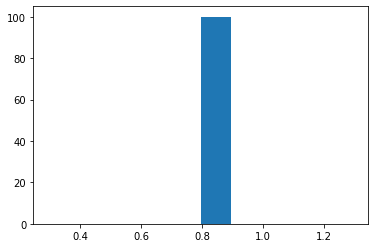

In [41]:
plt.hist(df['Accuracies'])

In [64]:
from azureml.core import Workspace, Experiment, Environment, ScriptRunConfig, Run
from azureml.core import Workspace, Dataset, Run


subscription_id = '5b7e9376-1907-45b5-b8cf-6fde28c54e67'
resource_group  = 'mpt_projects'
workspace_name  = 'ecm_project'
workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='age_data')
dataset.download(target_path='.', overwrite=True)

datasetpath = getcwd()
print('Current Notebook Dir: ' + datasetpath)

# for file in dataset.to_path():
#     print(file)
#     df = pd.read_csv(workbookDir + file)
#     print(df.shape)
print('generating filelist')
#filelist = [f for f in listdir(dataset.to_path()) if isfile(join(dataset.to_path(), f)) and 'feat' in f]
filelist = []
for file in dataset.to_path():
    filelist.append(file)
print('showing four path examples')
print(filelist[0:4])

Current Notebook Dir: /mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim
generating filelist
showing four path examples
['/features_NT_brain_2_slice_1_vid_1.csv', '/features_NT_brain_2_slice_1_vid_2.csv', '/features_NT_brain_2_slice_1_vid_3.csv', '/features_NT_brain_2_slice_1_vid_4.csv']


In [65]:
data_process.generate_fullstats(datasetpath, filelist, ['P14', 'NT', 'P70'], 'age')

Adding file /features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
Adding file /features_NT_brain_2_slice_1_vid_2.csv size: (833, 91)
Adding file /features_NT_brain_2_slice_1_vid_3.csv size: (1017, 91)
Adding file /features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
Adding file /features_NT_brain_2_slice_1_vid_5.csv size: (467, 91)
Adding file /features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
Adding file /features_NT_brain_2_slice_2_vid_2.csv size: (2322, 91)
Adding file /features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
Adding file /features_NT_brain_2_slice_2_vid_4.csv size: (1650, 91)
Adding file /features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
Adding file /features_NT_brain_2_slice_3_vid_1.csv size: (562, 91)
Adding file /features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
Adding file /features_NT_brain_2_slice_3_vid_3.csv size: (817, 91)
Adding file /features_NT_brain_2_slice_3_vid_4.csv size: (598, 91)
Adding file /features_NT_brain_2_slice_3_vid_5.csv size:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s1_v3.csv size: (25, 67)
Adding file /features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file /features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file /features_P70_40nm_s2_v1.csv size: (148, 67)
Adding file /features_P70_40nm_s2_v2.csv size: (148, 67)
Adding file /features_P70_40nm_s2_v3.csv size: (240, 67)
Adding file /features_P70_40nm_s2_v4.csv size: (308, 67)
Adding file /features_P70_40nm_s2_v5.csv size: (186, 67)
Adding file /features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file /features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file /features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file /features_P70_40nm_s3_v4.csv size: (2909, 67)
Adding file /features_P70_40nm_s3_v5.csv size: (4162, 67)


AR      D_fit     Deff1  Deff2  MSD_ratio   Mean AR  Mean D_fit  \
0      2.104323  16.493781  3.664654    NaN   0.403852  3.413848   17.864176   
1      1.213024   0.316246  0.042387    NaN   3.819023  1.428905    0.375724   
2      1.087747   0.440548  0.059223    NaN   0.373281  1.428905    0.375724   
3      3.654338   2.452218       NaN    NaN  -0.137579  3.413848   17.864176   
4      5.244316   8.270880       NaN    NaN   0.129332  3.413848   17.864176   
...         ...        ...       ...    ...        ...       ...         ...   
38785  2.407697   5.468956  6.353185    NaN  -0.046620  2.439202    3.605276   
38786  4.746345   1.110312  0.369674    NaN   0.212110  2.640930    6.936999   
38787  1.337848   2.344673  0.324863    NaN   0.528815  2.791802    9.709475   
38788  2.751547  26.599887  9.078426    NaN   0.268150  2.088355    8.837092   
38789  1.820456   8.024775  3.120664    NaN   0.112040  2.435143   11.160152   

       Mean Deff1  Mean Deff2  Mean MSD_ratio  ...     dist_net  \
0        5.622937         NaN        0.432450  ...  2205.948557   
1        0.057419         NaN        1.185384  ...  1792.090062   
2        0.057419         NaN        1.185384  ...  1792.134532   
3        5.622937         NaN        0.432450  ...  2203.879002   
4        5.622937         NaN        0.432450  ...  2205.128522   
...           ...         ...             ...  ...          ...   
38785    4.505067    0.004258        0.050712  ...          NaN   
38786    3.299059         NaN        0.226855  ...          NaN   
38787    5.754385    0.473125        0.140556  ...          NaN   
38788    2.841761    0.961489        0.596618  ...          NaN   
38789    5.721789    4.019169        0.077470  ...          NaN   

            dist_tot  efficiency  elongation  fractal_dim  frames  kurtosis  \
0      138801.650094    0.074405    0.524788     1.950401    64.0  5.457711   
1      143469.616411    0.034019    0.175614     2.849735    81.0  3.334612   
2       89625.159368    0.092170    0.080668     2.269369    51.0  2.587983   
3       17646.270481    3.234814    0.726353     1.187502     9.0  2.516403   
4       17652.271648    0.225793    0.809317     1.341359     9.0  2.176721   
...              ...         ...         ...          ...     ...       ...   
38785            NaN    1.109040    0.584665     1.529268    23.0  1.780802   
38786            NaN    0.213192    0.789312     2.286177    23.0  1.795274   
38787            NaN    0.005942    0.252531     2.753825    22.0  2.433422   
38788            NaN    0.281298    0.636568     1.507979    20.0  1.614127   
38789            NaN    0.673145    0.450687     1.410859    19.0  3.058324   

       progression  straightness  trappedness  
0         0.015893      0.045252    -0.214776  
1         0.012491      0.025885    -0.197764  
2         0.019996      0.067357    -0.197402  
3         0.124892      0.720121    -0.195273  
4         0.124920      0.256656    -0.159196  
...            ...           ...          ...  
38785          NaN      0.250125    -0.215954  
38786          NaN      0.131029    -0.167181  
38787          NaN      0.020766    -0.160036  
38788          NaN      0.144804    -0.204885  
38789          NaN      0.250378    -0.204330  

[38790 rows x 93 columns]

In [48]:
acc_list = []
true_label_list = []
preds_list = []
for i in range(100):
    sampled_filelist = []
    class_lens = [0, 15, 30, 45, 60, 75] # this is specific to the age data set!
    for i in range(len(class_lens)-1):
        rand_integers = random.sample(set(np.arange(class_lens[i], class_lens[i+1])), 2)
        for rand_int in rand_integers:
            sampled_filelist.append(filelist[rand_int])
    fstats_tot = data_process.generate_fullstats(datasetpath, sampled_filelist, ['P14', 'NT', 'P70'], 'age')
    ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y']]
    ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)] 
    bal_ecm = data_process.balance_data(ecm, target)
    sampled_df = data_process.bin_data(bal_ecm)
    label_df = sampled_df['age']
    features_df = sampled_df.drop(['age', 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns
    
    seed = 1234
    np.random.seed(seed)
    train_split = 0.5
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    booster, acc, true_label, preds = predxgboost.train(run_three_params, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=run_three_boost_rounds)
    acc_list.append(acc)
    true_label_list.append(true_label)
    preds_list.append(preds)

output_dict = {'Accuracies': acc_list, 'True Labels': true_label_list, 'Preds': preds_list}
df = pd.DataFrame(output_dict)

Adding file /features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
Adding file /features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
Adding file /features_P14_40nm_s1_v2.csv size: (1356, 91)
Adding file /features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file /features_P70_40nm_s1_v3.csv size: (25, 67)
Adding file /features_P70_40nm_s1_v5.csv size: (17, 67)
Ratio before data balance (NT:P14:P70) = 2415:1253:42
Ratio after balance (NT:P14:P70) = 42:42:42
[0]	train-mlogloss:1.09183	eval-mlogloss:1.09139
[1]	train-mlogloss:1.08584	eval-mlogloss:1.08599
[2]	train-mlogloss:1.07924	eval-mlogloss:1.07854
[3]	train-mlogloss:1.07281	eval-mlogloss:1.07130
[4]	train-mlogloss:1.06634	eval-mlogloss:1.06439
[5]	train-mlogloss:1.05994	eval-mlogloss:1.05757
[6]	train-mlogloss:1.05427	eval-mlogloss:1.05244
[7]	train-mlogloss:1.04869	eval-mlogloss:1.04726
[8]	train-mlogloss:1.04332	eval-mlogloss:1.04156
[9]	train-mlogloss:1.03718	eval-mlogloss:1.03498
[10]	train-mlogloss:1.03082	eval-mlogloss:1.02852


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[11]	train-mlogloss:1.02482	eval-mlogloss:1.02208
[12]	train-mlogloss:1.01854	eval-mlogloss:1.01505
[13]	train-mlogloss:1.01274	eval-mlogloss:1.00866
[14]	train-mlogloss:1.00664	eval-mlogloss:1.00142
[15]	train-mlogloss:1.00063	eval-mlogloss:0.99532
[16]	train-mlogloss:0.99500	eval-mlogloss:0.98887
[17]	train-mlogloss:0.98944	eval-mlogloss:0.98249
[18]	train-mlogloss:0.98394	eval-mlogloss:0.97719
[19]	train-mlogloss:0.97875	eval-mlogloss:0.97227
[20]	train-mlogloss:0.97380	eval-mlogloss:0.96714
[21]	train-mlogloss:0.96812	eval-mlogloss:0.96072
[22]	train-mlogloss:0.96334	eval-mlogloss:0.95708
[23]	train-mlogloss:0.95807	eval-mlogloss:0.95155
[24]	train-mlogloss:0.95306	eval-mlogloss:0.94716
[25]	train-mlogloss:0.94856	eval-mlogloss:0.94284
[26]	train-mlogloss:0.94351	eval-mlogloss:0.93759
[27]	train-mlogloss:0.93912	eval-mlogloss:0.93450
[28]	train-mlogloss:0.93387	eval-mlogloss:0.92877
[29]	train-mlogloss:0.92860	eval-mlogloss:0.92296
[30]	train-mlogloss:0.92339	eval-mlogloss:0.91722


[174]	train-mlogloss:0.53237	eval-mlogloss:0.52604
[175]	train-mlogloss:0.53100	eval-mlogloss:0.52418
[176]	train-mlogloss:0.52965	eval-mlogloss:0.52331
[177]	train-mlogloss:0.52819	eval-mlogloss:0.52269
[178]	train-mlogloss:0.52686	eval-mlogloss:0.52197
[179]	train-mlogloss:0.52569	eval-mlogloss:0.52060
[180]	train-mlogloss:0.52426	eval-mlogloss:0.51986
[181]	train-mlogloss:0.52311	eval-mlogloss:0.51948
[182]	train-mlogloss:0.52192	eval-mlogloss:0.51839
[183]	train-mlogloss:0.52070	eval-mlogloss:0.51657
[184]	train-mlogloss:0.51949	eval-mlogloss:0.51572
[185]	train-mlogloss:0.51810	eval-mlogloss:0.51418
[186]	train-mlogloss:0.51691	eval-mlogloss:0.51252
[187]	train-mlogloss:0.51574	eval-mlogloss:0.51088
[188]	train-mlogloss:0.51439	eval-mlogloss:0.50938
[189]	train-mlogloss:0.51304	eval-mlogloss:0.50883
[190]	train-mlogloss:0.51189	eval-mlogloss:0.50816
[191]	train-mlogloss:0.51075	eval-mlogloss:0.50776
[192]	train-mlogloss:0.51014	eval-mlogloss:0.50692
[193]	train-mlogloss:0.50921	ev

[335]	train-mlogloss:0.46717	eval-mlogloss:0.47832
[336]	train-mlogloss:0.46717	eval-mlogloss:0.47833
[337]	train-mlogloss:0.46716	eval-mlogloss:0.47834
[338]	train-mlogloss:0.46716	eval-mlogloss:0.47835
[339]	train-mlogloss:0.46716	eval-mlogloss:0.47836
[340]	train-mlogloss:0.46716	eval-mlogloss:0.47837
[341]	train-mlogloss:0.46716	eval-mlogloss:0.47837
[342]	train-mlogloss:0.46715	eval-mlogloss:0.47838
[343]	train-mlogloss:0.46715	eval-mlogloss:0.47839
[344]	train-mlogloss:0.46715	eval-mlogloss:0.47840
[345]	train-mlogloss:0.46715	eval-mlogloss:0.47841
[346]	train-mlogloss:0.46714	eval-mlogloss:0.47842
[347]	train-mlogloss:0.46714	eval-mlogloss:0.47843
[348]	train-mlogloss:0.46714	eval-mlogloss:0.47844
[349]	train-mlogloss:0.46714	eval-mlogloss:0.47845
[350]	train-mlogloss:0.46714	eval-mlogloss:0.47845
[351]	train-mlogloss:0.46713	eval-mlogloss:0.47846
[352]	train-mlogloss:0.46713	eval-mlogloss:0.47847
[353]	train-mlogloss:0.46713	eval-mlogloss:0.47848
[354]	train-mlogloss:0.46713	ev

[496]	train-mlogloss:0.46566	eval-mlogloss:0.47909
[497]	train-mlogloss:0.46565	eval-mlogloss:0.47909
[498]	train-mlogloss:0.46565	eval-mlogloss:0.47909
[499]	train-mlogloss:0.46565	eval-mlogloss:0.47910
[500]	train-mlogloss:0.46565	eval-mlogloss:0.47910
[501]	train-mlogloss:0.46565	eval-mlogloss:0.47910
[502]	train-mlogloss:0.46565	eval-mlogloss:0.47911
[503]	train-mlogloss:0.46565	eval-mlogloss:0.47911
[504]	train-mlogloss:0.46565	eval-mlogloss:0.47911
[505]	train-mlogloss:0.46565	eval-mlogloss:0.47912
[506]	train-mlogloss:0.46565	eval-mlogloss:0.47912
[507]	train-mlogloss:0.46565	eval-mlogloss:0.47912
[508]	train-mlogloss:0.46565	eval-mlogloss:0.47913
[509]	train-mlogloss:0.46565	eval-mlogloss:0.47913
[510]	train-mlogloss:0.46565	eval-mlogloss:0.47913
[511]	train-mlogloss:0.46565	eval-mlogloss:0.47914
[512]	train-mlogloss:0.46565	eval-mlogloss:0.47914
[513]	train-mlogloss:0.46565	eval-mlogloss:0.47914
[514]	train-mlogloss:0.46565	eval-mlogloss:0.47914
[515]	train-mlogloss:0.46565	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[10]	train-mlogloss:0.99280	eval-mlogloss:1.02381
[11]	train-mlogloss:0.98371	eval-mlogloss:1.01630
[12]	train-mlogloss:0.97503	eval-mlogloss:1.01010
[13]	train-mlogloss:0.96694	eval-mlogloss:1.00442
[14]	train-mlogloss:0.95799	eval-mlogloss:0.99768
[15]	train-mlogloss:0.94960	eval-mlogloss:0.99085
[16]	train-mlogloss:0.94131	eval-mlogloss:0.98463
[17]	train-mlogloss:0.93332	eval-mlogloss:0.97858
[18]	train-mlogloss:0.92519	eval-mlogloss:0.97227
[19]	train-mlogloss:0.91688	eval-mlogloss:0.96570
[20]	train-mlogloss:0.90924	eval-mlogloss:0.96097
[21]	train-mlogloss:0.90164	eval-mlogloss:0.95488
[22]	train-mlogloss:0.89507	eval-mlogloss:0.95005
[23]	train-mlogloss:0.88717	eval-mlogloss:0.94364
[24]	train-mlogloss:0.88019	eval-mlogloss:0.93912
[25]	train-mlogloss:0.87357	eval-mlogloss:0.93423
[26]	train-mlogloss:0.86575	eval-mlogloss:0.92778
[27]	train-mlogloss:0.85902	eval-mlogloss:0.92453
[28]	train-mlogloss:0.85126	eval-mlogloss:0.91819
[29]	train-mlogloss:0.84442	eval-mlogloss:0.91296


[173]	train-mlogloss:0.34593	eval-mlogloss:0.55379
[174]	train-mlogloss:0.34411	eval-mlogloss:0.55269
[175]	train-mlogloss:0.34242	eval-mlogloss:0.55175
[176]	train-mlogloss:0.34101	eval-mlogloss:0.55109
[177]	train-mlogloss:0.33941	eval-mlogloss:0.55015
[178]	train-mlogloss:0.33797	eval-mlogloss:0.54956
[179]	train-mlogloss:0.33626	eval-mlogloss:0.54865
[180]	train-mlogloss:0.33483	eval-mlogloss:0.54760
[181]	train-mlogloss:0.33348	eval-mlogloss:0.54666
[182]	train-mlogloss:0.33200	eval-mlogloss:0.54563
[183]	train-mlogloss:0.33036	eval-mlogloss:0.54450
[184]	train-mlogloss:0.32892	eval-mlogloss:0.54413
[185]	train-mlogloss:0.32731	eval-mlogloss:0.54328
[186]	train-mlogloss:0.32571	eval-mlogloss:0.54247
[187]	train-mlogloss:0.32412	eval-mlogloss:0.54147
[188]	train-mlogloss:0.32265	eval-mlogloss:0.54056
[189]	train-mlogloss:0.32109	eval-mlogloss:0.53960
[190]	train-mlogloss:0.31967	eval-mlogloss:0.53853
[191]	train-mlogloss:0.31823	eval-mlogloss:0.53733
[192]	train-mlogloss:0.31671	ev

[334]	train-mlogloss:0.18897	eval-mlogloss:0.46745
[335]	train-mlogloss:0.18854	eval-mlogloss:0.46745
[336]	train-mlogloss:0.18794	eval-mlogloss:0.46736
[337]	train-mlogloss:0.18739	eval-mlogloss:0.46717
[338]	train-mlogloss:0.18695	eval-mlogloss:0.46702
[339]	train-mlogloss:0.18645	eval-mlogloss:0.46664
[340]	train-mlogloss:0.18589	eval-mlogloss:0.46665
[341]	train-mlogloss:0.18540	eval-mlogloss:0.46637
[342]	train-mlogloss:0.18481	eval-mlogloss:0.46615
[343]	train-mlogloss:0.18426	eval-mlogloss:0.46586
[344]	train-mlogloss:0.18381	eval-mlogloss:0.46567
[345]	train-mlogloss:0.18335	eval-mlogloss:0.46562
[346]	train-mlogloss:0.18288	eval-mlogloss:0.46531
[347]	train-mlogloss:0.18231	eval-mlogloss:0.46495
[348]	train-mlogloss:0.18187	eval-mlogloss:0.46482
[349]	train-mlogloss:0.18137	eval-mlogloss:0.46476
[350]	train-mlogloss:0.18096	eval-mlogloss:0.46453
[351]	train-mlogloss:0.18037	eval-mlogloss:0.46435
[352]	train-mlogloss:0.17989	eval-mlogloss:0.46426
[353]	train-mlogloss:0.17929	ev

[495]	train-mlogloss:0.13325	eval-mlogloss:0.45304
[496]	train-mlogloss:0.13304	eval-mlogloss:0.45312
[497]	train-mlogloss:0.13290	eval-mlogloss:0.45317
[498]	train-mlogloss:0.13277	eval-mlogloss:0.45324
[499]	train-mlogloss:0.13260	eval-mlogloss:0.45321
[500]	train-mlogloss:0.13240	eval-mlogloss:0.45341
[501]	train-mlogloss:0.13218	eval-mlogloss:0.45354
[502]	train-mlogloss:0.13199	eval-mlogloss:0.45365
[503]	train-mlogloss:0.13183	eval-mlogloss:0.45358
[504]	train-mlogloss:0.13164	eval-mlogloss:0.45361
[505]	train-mlogloss:0.13156	eval-mlogloss:0.45368
[506]	train-mlogloss:0.13138	eval-mlogloss:0.45372
[507]	train-mlogloss:0.13119	eval-mlogloss:0.45365
[508]	train-mlogloss:0.13104	eval-mlogloss:0.45352
[509]	train-mlogloss:0.13084	eval-mlogloss:0.45367
[510]	train-mlogloss:0.13072	eval-mlogloss:0.45370
[511]	train-mlogloss:0.13055	eval-mlogloss:0.45374
[512]	train-mlogloss:0.13035	eval-mlogloss:0.45377
[513]	train-mlogloss:0.13022	eval-mlogloss:0.45386
[514]	train-mlogloss:0.13008	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s3_v3.csv size: (2322, 67)
Ratio before data balance (NT:P14:P70) = 2062:1094:2215
Ratio after balance (NT:P14:P70) = 1094:1094:1094
[0]	train-mlogloss:1.08717	eval-mlogloss:1.08939
[1]	train-mlogloss:1.07658	eval-mlogloss:1.08109
[2]	train-mlogloss:1.06613	eval-mlogloss:1.07285
[3]	train-mlogloss:1.05580	eval-mlogloss:1.06416
[4]	train-mlogloss:1.04541	eval-mlogloss:1.05580
[5]	train-mlogloss:1.03566	eval-mlogloss:1.04806
[6]	train-mlogloss:1.02546	eval-mlogloss:1.03926
[7]	train-mlogloss:1.01565	eval-mlogloss:1.03176
[8]	train-mlogloss:1.00661	eval-mlogloss:1.02517
[9]	train-mlogloss:0.99659	eval-mlogloss:1.01733
[10]	train-mlogloss:0.98694	eval-mlogloss:1.00993
[11]	train-mlogloss:0.97779	eval-mlogloss:1.00292
[12]	train-mlogloss:0.96814	eval-mlogloss:0.99494
[13]	train-mlogloss:0.95991	eval-mlogloss:0.98827
[14]	train-mlogloss:0.95044	eval-mlogloss:0.98029
[15]	train-mlogloss:0.94141	eval-mlogloss:0.97297
[16]	train-mlogloss:0.93249	eval-mlogloss:0.96

[160]	train-mlogloss:0.33263	eval-mlogloss:0.49190
[161]	train-mlogloss:0.33075	eval-mlogloss:0.49054
[162]	train-mlogloss:0.32893	eval-mlogloss:0.48904
[163]	train-mlogloss:0.32722	eval-mlogloss:0.48775
[164]	train-mlogloss:0.32554	eval-mlogloss:0.48630
[165]	train-mlogloss:0.32359	eval-mlogloss:0.48474
[166]	train-mlogloss:0.32176	eval-mlogloss:0.48331
[167]	train-mlogloss:0.32011	eval-mlogloss:0.48220
[168]	train-mlogloss:0.31823	eval-mlogloss:0.48061
[169]	train-mlogloss:0.31650	eval-mlogloss:0.47935
[170]	train-mlogloss:0.31491	eval-mlogloss:0.47827
[171]	train-mlogloss:0.31347	eval-mlogloss:0.47745
[172]	train-mlogloss:0.31191	eval-mlogloss:0.47640
[173]	train-mlogloss:0.31017	eval-mlogloss:0.47509
[174]	train-mlogloss:0.30850	eval-mlogloss:0.47376
[175]	train-mlogloss:0.30682	eval-mlogloss:0.47245
[176]	train-mlogloss:0.30513	eval-mlogloss:0.47138
[177]	train-mlogloss:0.30349	eval-mlogloss:0.47037
[178]	train-mlogloss:0.30195	eval-mlogloss:0.46925
[179]	train-mlogloss:0.30039	ev

[321]	train-mlogloss:0.16453	eval-mlogloss:0.37499
[322]	train-mlogloss:0.16400	eval-mlogloss:0.37473
[323]	train-mlogloss:0.16343	eval-mlogloss:0.37430
[324]	train-mlogloss:0.16278	eval-mlogloss:0.37388
[325]	train-mlogloss:0.16225	eval-mlogloss:0.37359
[326]	train-mlogloss:0.16172	eval-mlogloss:0.37318
[327]	train-mlogloss:0.16122	eval-mlogloss:0.37290
[328]	train-mlogloss:0.16068	eval-mlogloss:0.37261
[329]	train-mlogloss:0.16018	eval-mlogloss:0.37242
[330]	train-mlogloss:0.15969	eval-mlogloss:0.37208
[331]	train-mlogloss:0.15918	eval-mlogloss:0.37173
[332]	train-mlogloss:0.15861	eval-mlogloss:0.37150
[333]	train-mlogloss:0.15801	eval-mlogloss:0.37124
[334]	train-mlogloss:0.15751	eval-mlogloss:0.37093
[335]	train-mlogloss:0.15702	eval-mlogloss:0.37072
[336]	train-mlogloss:0.15655	eval-mlogloss:0.37047
[337]	train-mlogloss:0.15600	eval-mlogloss:0.37025
[338]	train-mlogloss:0.15553	eval-mlogloss:0.37003
[339]	train-mlogloss:0.15494	eval-mlogloss:0.36978
[340]	train-mlogloss:0.15446	ev

[482]	train-mlogloss:0.10680	eval-mlogloss:0.34859
[483]	train-mlogloss:0.10655	eval-mlogloss:0.34851
[484]	train-mlogloss:0.10632	eval-mlogloss:0.34840
[485]	train-mlogloss:0.10609	eval-mlogloss:0.34840
[486]	train-mlogloss:0.10587	eval-mlogloss:0.34832
[487]	train-mlogloss:0.10565	eval-mlogloss:0.34820
[488]	train-mlogloss:0.10547	eval-mlogloss:0.34827
[489]	train-mlogloss:0.10526	eval-mlogloss:0.34815
[490]	train-mlogloss:0.10506	eval-mlogloss:0.34801
[491]	train-mlogloss:0.10486	eval-mlogloss:0.34801
[492]	train-mlogloss:0.10465	eval-mlogloss:0.34784
[493]	train-mlogloss:0.10448	eval-mlogloss:0.34777
[494]	train-mlogloss:0.10430	eval-mlogloss:0.34767
[495]	train-mlogloss:0.10410	eval-mlogloss:0.34753
[496]	train-mlogloss:0.10387	eval-mlogloss:0.34741
[497]	train-mlogloss:0.10363	eval-mlogloss:0.34740
[498]	train-mlogloss:0.10345	eval-mlogloss:0.34722
[499]	train-mlogloss:0.10324	eval-mlogloss:0.34709
[500]	train-mlogloss:0.10300	eval-mlogloss:0.34697
[501]	train-mlogloss:0.10278	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[1]	train-mlogloss:1.08036	eval-mlogloss:1.08365
[2]	train-mlogloss:1.07136	eval-mlogloss:1.07644
[3]	train-mlogloss:1.06279	eval-mlogloss:1.06994
[4]	train-mlogloss:1.05453	eval-mlogloss:1.06301
[5]	train-mlogloss:1.04640	eval-mlogloss:1.05649
[6]	train-mlogloss:1.03755	eval-mlogloss:1.04948
[7]	train-mlogloss:1.02967	eval-mlogloss:1.04334
[8]	train-mlogloss:1.02191	eval-mlogloss:1.03807
[9]	train-mlogloss:1.01333	eval-mlogloss:1.03157
[10]	train-mlogloss:1.00556	eval-mlogloss:1.02579
[11]	train-mlogloss:0.99800	eval-mlogloss:1.01953
[12]	train-mlogloss:0.99042	eval-mlogloss:1.01352
[13]	train-mlogloss:0.98278	eval-mlogloss:1.00751
[14]	train-mlogloss:0.97457	eval-mlogloss:1.00058
[15]	train-mlogloss:0.96695	eval-mlogloss:0.99433
[16]	train-mlogloss:0.95924	eval-mlogloss:0.98786
[17]	train-mlogloss:0.95160	eval-mlogloss:0.98161
[18]	train-mlogloss:0.94435	eval-mlogloss:0.97557
[19]	train-mlogloss:0.93692	eval-mlogloss:0.96907
[20]	train-mlogloss:0.92993	eval-mlogloss:0.96365
[21]	trai

[164]	train-mlogloss:0.40952	eval-mlogloss:0.54975
[165]	train-mlogloss:0.40760	eval-mlogloss:0.54831
[166]	train-mlogloss:0.40590	eval-mlogloss:0.54711
[167]	train-mlogloss:0.40428	eval-mlogloss:0.54583
[168]	train-mlogloss:0.40242	eval-mlogloss:0.54437
[169]	train-mlogloss:0.40065	eval-mlogloss:0.54317
[170]	train-mlogloss:0.39907	eval-mlogloss:0.54176
[171]	train-mlogloss:0.39752	eval-mlogloss:0.54068
[172]	train-mlogloss:0.39603	eval-mlogloss:0.53958
[173]	train-mlogloss:0.39428	eval-mlogloss:0.53817
[174]	train-mlogloss:0.39243	eval-mlogloss:0.53667
[175]	train-mlogloss:0.39090	eval-mlogloss:0.53556
[176]	train-mlogloss:0.38920	eval-mlogloss:0.53449
[177]	train-mlogloss:0.38747	eval-mlogloss:0.53323
[178]	train-mlogloss:0.38584	eval-mlogloss:0.53204
[179]	train-mlogloss:0.38418	eval-mlogloss:0.53099
[180]	train-mlogloss:0.38276	eval-mlogloss:0.53010
[181]	train-mlogloss:0.38129	eval-mlogloss:0.52911
[182]	train-mlogloss:0.37978	eval-mlogloss:0.52809
[183]	train-mlogloss:0.37830	ev

[325]	train-mlogloss:0.23960	eval-mlogloss:0.43021
[326]	train-mlogloss:0.23902	eval-mlogloss:0.42992
[327]	train-mlogloss:0.23834	eval-mlogloss:0.42949
[328]	train-mlogloss:0.23774	eval-mlogloss:0.42893
[329]	train-mlogloss:0.23711	eval-mlogloss:0.42855
[330]	train-mlogloss:0.23650	eval-mlogloss:0.42811
[331]	train-mlogloss:0.23586	eval-mlogloss:0.42777
[332]	train-mlogloss:0.23533	eval-mlogloss:0.42747
[333]	train-mlogloss:0.23461	eval-mlogloss:0.42704
[334]	train-mlogloss:0.23398	eval-mlogloss:0.42658
[335]	train-mlogloss:0.23330	eval-mlogloss:0.42638
[336]	train-mlogloss:0.23275	eval-mlogloss:0.42602
[337]	train-mlogloss:0.23211	eval-mlogloss:0.42547
[338]	train-mlogloss:0.23152	eval-mlogloss:0.42494
[339]	train-mlogloss:0.23089	eval-mlogloss:0.42440
[340]	train-mlogloss:0.23035	eval-mlogloss:0.42405
[341]	train-mlogloss:0.22983	eval-mlogloss:0.42385
[342]	train-mlogloss:0.22928	eval-mlogloss:0.42347
[343]	train-mlogloss:0.22873	eval-mlogloss:0.42316
[344]	train-mlogloss:0.22821	ev

[486]	train-mlogloss:0.17337	eval-mlogloss:0.39351
[487]	train-mlogloss:0.17308	eval-mlogloss:0.39329
[488]	train-mlogloss:0.17286	eval-mlogloss:0.39326
[489]	train-mlogloss:0.17256	eval-mlogloss:0.39315
[490]	train-mlogloss:0.17223	eval-mlogloss:0.39308
[491]	train-mlogloss:0.17194	eval-mlogloss:0.39295
[492]	train-mlogloss:0.17175	eval-mlogloss:0.39286
[493]	train-mlogloss:0.17148	eval-mlogloss:0.39282
[494]	train-mlogloss:0.17116	eval-mlogloss:0.39267
[495]	train-mlogloss:0.17090	eval-mlogloss:0.39252
[496]	train-mlogloss:0.17070	eval-mlogloss:0.39248
[497]	train-mlogloss:0.17043	eval-mlogloss:0.39243
[498]	train-mlogloss:0.17026	eval-mlogloss:0.39230
[499]	train-mlogloss:0.17003	eval-mlogloss:0.39227
[500]	train-mlogloss:0.16974	eval-mlogloss:0.39204
[501]	train-mlogloss:0.16947	eval-mlogloss:0.39198
[502]	train-mlogloss:0.16931	eval-mlogloss:0.39187
[503]	train-mlogloss:0.16908	eval-mlogloss:0.39187
[504]	train-mlogloss:0.16891	eval-mlogloss:0.39174
[505]	train-mlogloss:0.16872	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[3]	train-mlogloss:1.05700	eval-mlogloss:1.06842
[4]	train-mlogloss:1.04672	eval-mlogloss:1.06066
[5]	train-mlogloss:1.03665	eval-mlogloss:1.05339
[6]	train-mlogloss:1.02624	eval-mlogloss:1.04576
[7]	train-mlogloss:1.01622	eval-mlogloss:1.03892
[8]	train-mlogloss:1.00742	eval-mlogloss:1.03269
[9]	train-mlogloss:0.99788	eval-mlogloss:1.02558
[10]	train-mlogloss:0.98857	eval-mlogloss:1.01806
[11]	train-mlogloss:0.97984	eval-mlogloss:1.01173
[12]	train-mlogloss:0.97008	eval-mlogloss:1.00419
[13]	train-mlogloss:0.96187	eval-mlogloss:0.99802
[14]	train-mlogloss:0.95281	eval-mlogloss:0.99054
[15]	train-mlogloss:0.94427	eval-mlogloss:0.98387
[16]	train-mlogloss:0.93553	eval-mlogloss:0.97636
[17]	train-mlogloss:0.92702	eval-mlogloss:0.96943
[18]	train-mlogloss:0.91885	eval-mlogloss:0.96227
[19]	train-mlogloss:0.91036	eval-mlogloss:0.95549
[20]	train-mlogloss:0.90253	eval-mlogloss:0.94979
[21]	train-mlogloss:0.89443	eval-mlogloss:0.94369
[22]	train-mlogloss:0.88709	eval-mlogloss:0.93892
[23]	tr

[166]	train-mlogloss:0.32974	eval-mlogloss:0.51624
[167]	train-mlogloss:0.32804	eval-mlogloss:0.51502
[168]	train-mlogloss:0.32627	eval-mlogloss:0.51351
[169]	train-mlogloss:0.32455	eval-mlogloss:0.51219
[170]	train-mlogloss:0.32298	eval-mlogloss:0.51117
[171]	train-mlogloss:0.32142	eval-mlogloss:0.51025
[172]	train-mlogloss:0.31962	eval-mlogloss:0.50928
[173]	train-mlogloss:0.31794	eval-mlogloss:0.50782
[174]	train-mlogloss:0.31618	eval-mlogloss:0.50675
[175]	train-mlogloss:0.31454	eval-mlogloss:0.50544
[176]	train-mlogloss:0.31281	eval-mlogloss:0.50464
[177]	train-mlogloss:0.31117	eval-mlogloss:0.50337
[178]	train-mlogloss:0.30966	eval-mlogloss:0.50232
[179]	train-mlogloss:0.30805	eval-mlogloss:0.50122
[180]	train-mlogloss:0.30649	eval-mlogloss:0.50014
[181]	train-mlogloss:0.30513	eval-mlogloss:0.49944
[182]	train-mlogloss:0.30364	eval-mlogloss:0.49846
[183]	train-mlogloss:0.30212	eval-mlogloss:0.49739
[184]	train-mlogloss:0.30064	eval-mlogloss:0.49651
[185]	train-mlogloss:0.29900	ev

[327]	train-mlogloss:0.16626	eval-mlogloss:0.40447
[328]	train-mlogloss:0.16578	eval-mlogloss:0.40417
[329]	train-mlogloss:0.16536	eval-mlogloss:0.40390
[330]	train-mlogloss:0.16493	eval-mlogloss:0.40368
[331]	train-mlogloss:0.16442	eval-mlogloss:0.40325
[332]	train-mlogloss:0.16393	eval-mlogloss:0.40286
[333]	train-mlogloss:0.16342	eval-mlogloss:0.40253
[334]	train-mlogloss:0.16290	eval-mlogloss:0.40238
[335]	train-mlogloss:0.16239	eval-mlogloss:0.40206
[336]	train-mlogloss:0.16187	eval-mlogloss:0.40188
[337]	train-mlogloss:0.16141	eval-mlogloss:0.40156
[338]	train-mlogloss:0.16088	eval-mlogloss:0.40114
[339]	train-mlogloss:0.16027	eval-mlogloss:0.40081
[340]	train-mlogloss:0.15980	eval-mlogloss:0.40057
[341]	train-mlogloss:0.15932	eval-mlogloss:0.40035
[342]	train-mlogloss:0.15884	eval-mlogloss:0.40000
[343]	train-mlogloss:0.15835	eval-mlogloss:0.39964
[344]	train-mlogloss:0.15793	eval-mlogloss:0.39938
[345]	train-mlogloss:0.15751	eval-mlogloss:0.39912
[346]	train-mlogloss:0.15706	ev

[488]	train-mlogloss:0.10922	eval-mlogloss:0.37907
[489]	train-mlogloss:0.10898	eval-mlogloss:0.37891
[490]	train-mlogloss:0.10874	eval-mlogloss:0.37892
[491]	train-mlogloss:0.10854	eval-mlogloss:0.37884
[492]	train-mlogloss:0.10829	eval-mlogloss:0.37880
[493]	train-mlogloss:0.10806	eval-mlogloss:0.37870
[494]	train-mlogloss:0.10782	eval-mlogloss:0.37870
[495]	train-mlogloss:0.10758	eval-mlogloss:0.37865
[496]	train-mlogloss:0.10735	eval-mlogloss:0.37857
[497]	train-mlogloss:0.10716	eval-mlogloss:0.37852
[498]	train-mlogloss:0.10696	eval-mlogloss:0.37843
[499]	train-mlogloss:0.10676	eval-mlogloss:0.37831
[500]	train-mlogloss:0.10650	eval-mlogloss:0.37815
[501]	train-mlogloss:0.10630	eval-mlogloss:0.37808
[502]	train-mlogloss:0.10608	eval-mlogloss:0.37800
[503]	train-mlogloss:0.10585	eval-mlogloss:0.37789
[504]	train-mlogloss:0.10565	eval-mlogloss:0.37788
[505]	train-mlogloss:0.10543	eval-mlogloss:0.37774
[506]	train-mlogloss:0.10519	eval-mlogloss:0.37770
[507]	train-mlogloss:0.10498	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08796	eval-mlogloss:1.09133
[1]	train-mlogloss:1.07756	eval-mlogloss:1.08450
[2]	train-mlogloss:1.06774	eval-mlogloss:1.07644
[3]	train-mlogloss:1.05826	eval-mlogloss:1.06944
[4]	train-mlogloss:1.04827	eval-mlogloss:1.06175
[5]	train-mlogloss:1.03917	eval-mlogloss:1.05475
[6]	train-mlogloss:1.02942	eval-mlogloss:1.04738
[7]	train-mlogloss:1.02057	eval-mlogloss:1.04148
[8]	train-mlogloss:1.01120	eval-mlogloss:1.03556
[9]	train-mlogloss:1.00192	eval-mlogloss:1.02771
[10]	train-mlogloss:0.99336	eval-mlogloss:1.02191
[11]	train-mlogloss:0.98499	eval-mlogloss:1.01528
[12]	train-mlogloss:0.97605	eval-mlogloss:1.00835
[13]	train-mlogloss:0.96784	eval-mlogloss:1.00307
[14]	train-mlogloss:0.95870	eval-mlogloss:0.99577
[15]	train-mlogloss:0.95029	eval-mlogloss:0.99028
[16]	train-mlogloss:0.94162	eval-mlogloss:0.98439
[17]	train-mlogloss:0.93291	eval-mlogloss:0.97850
[18]	train-mlogloss:0.92475	eval-mlogloss:0.97307
[19]	train-mlogloss:0.91624	eval-mlogloss:0.96683
[20]	train

[163]	train-mlogloss:0.34858	eval-mlogloss:0.58867
[164]	train-mlogloss:0.34679	eval-mlogloss:0.58763
[165]	train-mlogloss:0.34473	eval-mlogloss:0.58669
[166]	train-mlogloss:0.34294	eval-mlogloss:0.58574
[167]	train-mlogloss:0.34135	eval-mlogloss:0.58522
[168]	train-mlogloss:0.33946	eval-mlogloss:0.58440
[169]	train-mlogloss:0.33774	eval-mlogloss:0.58371
[170]	train-mlogloss:0.33632	eval-mlogloss:0.58324
[171]	train-mlogloss:0.33480	eval-mlogloss:0.58254
[172]	train-mlogloss:0.33313	eval-mlogloss:0.58142
[173]	train-mlogloss:0.33141	eval-mlogloss:0.58032
[174]	train-mlogloss:0.32959	eval-mlogloss:0.57932
[175]	train-mlogloss:0.32789	eval-mlogloss:0.57829
[176]	train-mlogloss:0.32622	eval-mlogloss:0.57720
[177]	train-mlogloss:0.32453	eval-mlogloss:0.57624
[178]	train-mlogloss:0.32295	eval-mlogloss:0.57560
[179]	train-mlogloss:0.32139	eval-mlogloss:0.57435
[180]	train-mlogloss:0.31999	eval-mlogloss:0.57350
[181]	train-mlogloss:0.31867	eval-mlogloss:0.57271
[182]	train-mlogloss:0.31717	ev

[324]	train-mlogloss:0.17809	eval-mlogloss:0.50003
[325]	train-mlogloss:0.17743	eval-mlogloss:0.49990
[326]	train-mlogloss:0.17683	eval-mlogloss:0.49961
[327]	train-mlogloss:0.17622	eval-mlogloss:0.49932
[328]	train-mlogloss:0.17560	eval-mlogloss:0.49926
[329]	train-mlogloss:0.17502	eval-mlogloss:0.49930
[330]	train-mlogloss:0.17446	eval-mlogloss:0.49918
[331]	train-mlogloss:0.17390	eval-mlogloss:0.49878
[332]	train-mlogloss:0.17333	eval-mlogloss:0.49852
[333]	train-mlogloss:0.17281	eval-mlogloss:0.49815
[334]	train-mlogloss:0.17231	eval-mlogloss:0.49779
[335]	train-mlogloss:0.17179	eval-mlogloss:0.49743
[336]	train-mlogloss:0.17137	eval-mlogloss:0.49706
[337]	train-mlogloss:0.17081	eval-mlogloss:0.49691
[338]	train-mlogloss:0.17029	eval-mlogloss:0.49678
[339]	train-mlogloss:0.16973	eval-mlogloss:0.49673
[340]	train-mlogloss:0.16920	eval-mlogloss:0.49629
[341]	train-mlogloss:0.16865	eval-mlogloss:0.49590
[342]	train-mlogloss:0.16814	eval-mlogloss:0.49573
[343]	train-mlogloss:0.16755	ev

[485]	train-mlogloss:0.11655	eval-mlogloss:0.48425
[486]	train-mlogloss:0.11634	eval-mlogloss:0.48431
[487]	train-mlogloss:0.11606	eval-mlogloss:0.48422
[488]	train-mlogloss:0.11589	eval-mlogloss:0.48421
[489]	train-mlogloss:0.11564	eval-mlogloss:0.48404
[490]	train-mlogloss:0.11538	eval-mlogloss:0.48406
[491]	train-mlogloss:0.11515	eval-mlogloss:0.48402
[492]	train-mlogloss:0.11490	eval-mlogloss:0.48423
[493]	train-mlogloss:0.11463	eval-mlogloss:0.48428
[494]	train-mlogloss:0.11439	eval-mlogloss:0.48429
[495]	train-mlogloss:0.11410	eval-mlogloss:0.48432
[496]	train-mlogloss:0.11382	eval-mlogloss:0.48448
[497]	train-mlogloss:0.11365	eval-mlogloss:0.48440
[498]	train-mlogloss:0.11346	eval-mlogloss:0.48444
[499]	train-mlogloss:0.11324	eval-mlogloss:0.48441
[500]	train-mlogloss:0.11295	eval-mlogloss:0.48449
[501]	train-mlogloss:0.11273	eval-mlogloss:0.48448
[502]	train-mlogloss:0.11245	eval-mlogloss:0.48464
[503]	train-mlogloss:0.11221	eval-mlogloss:0.48485
[504]	train-mlogloss:0.11195	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[10]	train-mlogloss:0.99777	eval-mlogloss:1.03617
[11]	train-mlogloss:0.98898	eval-mlogloss:1.03005
[12]	train-mlogloss:0.98068	eval-mlogloss:1.02483
[13]	train-mlogloss:0.97299	eval-mlogloss:1.01978
[14]	train-mlogloss:0.96453	eval-mlogloss:1.01420
[15]	train-mlogloss:0.95666	eval-mlogloss:1.00886
[16]	train-mlogloss:0.94887	eval-mlogloss:1.00400
[17]	train-mlogloss:0.94107	eval-mlogloss:0.99892
[18]	train-mlogloss:0.93319	eval-mlogloss:0.99460
[19]	train-mlogloss:0.92519	eval-mlogloss:0.98974
[20]	train-mlogloss:0.91812	eval-mlogloss:0.98600
[21]	train-mlogloss:0.91089	eval-mlogloss:0.98096
[22]	train-mlogloss:0.90448	eval-mlogloss:0.97813
[23]	train-mlogloss:0.89695	eval-mlogloss:0.97344
[24]	train-mlogloss:0.89033	eval-mlogloss:0.97030
[25]	train-mlogloss:0.88394	eval-mlogloss:0.96566
[26]	train-mlogloss:0.87656	eval-mlogloss:0.96104
[27]	train-mlogloss:0.87006	eval-mlogloss:0.95777
[28]	train-mlogloss:0.86284	eval-mlogloss:0.95340
[29]	train-mlogloss:0.85610	eval-mlogloss:0.94892


[173]	train-mlogloss:0.36882	eval-mlogloss:0.69933
[174]	train-mlogloss:0.36713	eval-mlogloss:0.69918
[175]	train-mlogloss:0.36557	eval-mlogloss:0.69885
[176]	train-mlogloss:0.36408	eval-mlogloss:0.69910
[177]	train-mlogloss:0.36258	eval-mlogloss:0.69849
[178]	train-mlogloss:0.36118	eval-mlogloss:0.69814
[179]	train-mlogloss:0.35964	eval-mlogloss:0.69765
[180]	train-mlogloss:0.35816	eval-mlogloss:0.69664
[181]	train-mlogloss:0.35679	eval-mlogloss:0.69605
[182]	train-mlogloss:0.35537	eval-mlogloss:0.69538
[183]	train-mlogloss:0.35378	eval-mlogloss:0.69523
[184]	train-mlogloss:0.35226	eval-mlogloss:0.69452
[185]	train-mlogloss:0.35069	eval-mlogloss:0.69442
[186]	train-mlogloss:0.34918	eval-mlogloss:0.69407
[187]	train-mlogloss:0.34752	eval-mlogloss:0.69361
[188]	train-mlogloss:0.34607	eval-mlogloss:0.69293
[189]	train-mlogloss:0.34451	eval-mlogloss:0.69273
[190]	train-mlogloss:0.34296	eval-mlogloss:0.69241
[191]	train-mlogloss:0.34153	eval-mlogloss:0.69200
[192]	train-mlogloss:0.33998	ev

[334]	train-mlogloss:0.21554	eval-mlogloss:0.65643
[335]	train-mlogloss:0.21493	eval-mlogloss:0.65637
[336]	train-mlogloss:0.21426	eval-mlogloss:0.65595
[337]	train-mlogloss:0.21379	eval-mlogloss:0.65572
[338]	train-mlogloss:0.21316	eval-mlogloss:0.65599
[339]	train-mlogloss:0.21263	eval-mlogloss:0.65628
[340]	train-mlogloss:0.21205	eval-mlogloss:0.65631
[341]	train-mlogloss:0.21145	eval-mlogloss:0.65646
[342]	train-mlogloss:0.21085	eval-mlogloss:0.65617
[343]	train-mlogloss:0.21036	eval-mlogloss:0.65632
[344]	train-mlogloss:0.20995	eval-mlogloss:0.65640
[345]	train-mlogloss:0.20948	eval-mlogloss:0.65626
[346]	train-mlogloss:0.20907	eval-mlogloss:0.65592
[347]	train-mlogloss:0.20857	eval-mlogloss:0.65588
[348]	train-mlogloss:0.20813	eval-mlogloss:0.65591
[349]	train-mlogloss:0.20768	eval-mlogloss:0.65579
[350]	train-mlogloss:0.20722	eval-mlogloss:0.65560
[351]	train-mlogloss:0.20666	eval-mlogloss:0.65584
[352]	train-mlogloss:0.20613	eval-mlogloss:0.65564
[353]	train-mlogloss:0.20558	ev

[495]	train-mlogloss:0.15987	eval-mlogloss:0.65920
[496]	train-mlogloss:0.15965	eval-mlogloss:0.65905
[497]	train-mlogloss:0.15950	eval-mlogloss:0.65924
[498]	train-mlogloss:0.15929	eval-mlogloss:0.65919
[499]	train-mlogloss:0.15909	eval-mlogloss:0.65937
[500]	train-mlogloss:0.15896	eval-mlogloss:0.65943
[501]	train-mlogloss:0.15878	eval-mlogloss:0.65966
[502]	train-mlogloss:0.15852	eval-mlogloss:0.66018
[503]	train-mlogloss:0.15831	eval-mlogloss:0.66000
[504]	train-mlogloss:0.15821	eval-mlogloss:0.66012
[505]	train-mlogloss:0.15808	eval-mlogloss:0.66019
[506]	train-mlogloss:0.15790	eval-mlogloss:0.66025
[507]	train-mlogloss:0.15776	eval-mlogloss:0.66041
[508]	train-mlogloss:0.15760	eval-mlogloss:0.66058
[509]	train-mlogloss:0.15749	eval-mlogloss:0.66070
[510]	train-mlogloss:0.15730	eval-mlogloss:0.66085
[511]	train-mlogloss:0.15711	eval-mlogloss:0.66109
[512]	train-mlogloss:0.15688	eval-mlogloss:0.66162
[513]	train-mlogloss:0.15675	eval-mlogloss:0.66170
[514]	train-mlogloss:0.15665	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[4]	train-mlogloss:1.04502	eval-mlogloss:1.05703
[5]	train-mlogloss:1.03490	eval-mlogloss:1.04905
[6]	train-mlogloss:1.02454	eval-mlogloss:1.04122
[7]	train-mlogloss:1.01491	eval-mlogloss:1.03395
[8]	train-mlogloss:1.00568	eval-mlogloss:1.02812
[9]	train-mlogloss:0.99569	eval-mlogloss:1.02098
[10]	train-mlogloss:0.98643	eval-mlogloss:1.01412
[11]	train-mlogloss:0.97684	eval-mlogloss:1.00682
[12]	train-mlogloss:0.96790	eval-mlogloss:0.99986
[13]	train-mlogloss:0.95938	eval-mlogloss:0.99322
[14]	train-mlogloss:0.95017	eval-mlogloss:0.98560
[15]	train-mlogloss:0.94120	eval-mlogloss:0.97790
[16]	train-mlogloss:0.93243	eval-mlogloss:0.97089
[17]	train-mlogloss:0.92366	eval-mlogloss:0.96362
[18]	train-mlogloss:0.91520	eval-mlogloss:0.95688
[19]	train-mlogloss:0.90656	eval-mlogloss:0.94944
[20]	train-mlogloss:0.89893	eval-mlogloss:0.94380
[21]	train-mlogloss:0.89071	eval-mlogloss:0.93673
[22]	train-mlogloss:0.88328	eval-mlogloss:0.93109
[23]	train-mlogloss:0.87493	eval-mlogloss:0.92430
[24]	t

[167]	train-mlogloss:0.32299	eval-mlogloss:0.49501
[168]	train-mlogloss:0.32114	eval-mlogloss:0.49354
[169]	train-mlogloss:0.31941	eval-mlogloss:0.49238
[170]	train-mlogloss:0.31783	eval-mlogloss:0.49113
[171]	train-mlogloss:0.31631	eval-mlogloss:0.49020
[172]	train-mlogloss:0.31466	eval-mlogloss:0.48883
[173]	train-mlogloss:0.31282	eval-mlogloss:0.48743
[174]	train-mlogloss:0.31109	eval-mlogloss:0.48589
[175]	train-mlogloss:0.30943	eval-mlogloss:0.48445
[176]	train-mlogloss:0.30779	eval-mlogloss:0.48349
[177]	train-mlogloss:0.30602	eval-mlogloss:0.48220
[178]	train-mlogloss:0.30458	eval-mlogloss:0.48095
[179]	train-mlogloss:0.30308	eval-mlogloss:0.47981
[180]	train-mlogloss:0.30167	eval-mlogloss:0.47879
[181]	train-mlogloss:0.30033	eval-mlogloss:0.47802
[182]	train-mlogloss:0.29885	eval-mlogloss:0.47702
[183]	train-mlogloss:0.29730	eval-mlogloss:0.47601
[184]	train-mlogloss:0.29582	eval-mlogloss:0.47502
[185]	train-mlogloss:0.29426	eval-mlogloss:0.47368
[186]	train-mlogloss:0.29289	ev

[328]	train-mlogloss:0.16318	eval-mlogloss:0.37930
[329]	train-mlogloss:0.16273	eval-mlogloss:0.37910
[330]	train-mlogloss:0.16223	eval-mlogloss:0.37879
[331]	train-mlogloss:0.16168	eval-mlogloss:0.37841
[332]	train-mlogloss:0.16119	eval-mlogloss:0.37812
[333]	train-mlogloss:0.16071	eval-mlogloss:0.37785
[334]	train-mlogloss:0.16019	eval-mlogloss:0.37754
[335]	train-mlogloss:0.15972	eval-mlogloss:0.37724
[336]	train-mlogloss:0.15929	eval-mlogloss:0.37686
[337]	train-mlogloss:0.15873	eval-mlogloss:0.37652
[338]	train-mlogloss:0.15819	eval-mlogloss:0.37623
[339]	train-mlogloss:0.15764	eval-mlogloss:0.37590
[340]	train-mlogloss:0.15715	eval-mlogloss:0.37549
[341]	train-mlogloss:0.15669	eval-mlogloss:0.37523
[342]	train-mlogloss:0.15626	eval-mlogloss:0.37496
[343]	train-mlogloss:0.15573	eval-mlogloss:0.37470
[344]	train-mlogloss:0.15526	eval-mlogloss:0.37430
[345]	train-mlogloss:0.15488	eval-mlogloss:0.37406
[346]	train-mlogloss:0.15445	eval-mlogloss:0.37378
[347]	train-mlogloss:0.15393	ev

[489]	train-mlogloss:0.10844	eval-mlogloss:0.34714
[490]	train-mlogloss:0.10813	eval-mlogloss:0.34691
[491]	train-mlogloss:0.10791	eval-mlogloss:0.34687
[492]	train-mlogloss:0.10770	eval-mlogloss:0.34674
[493]	train-mlogloss:0.10751	eval-mlogloss:0.34660
[494]	train-mlogloss:0.10724	eval-mlogloss:0.34637
[495]	train-mlogloss:0.10705	eval-mlogloss:0.34630
[496]	train-mlogloss:0.10682	eval-mlogloss:0.34625
[497]	train-mlogloss:0.10662	eval-mlogloss:0.34619
[498]	train-mlogloss:0.10643	eval-mlogloss:0.34607
[499]	train-mlogloss:0.10624	eval-mlogloss:0.34586
[500]	train-mlogloss:0.10603	eval-mlogloss:0.34572
[501]	train-mlogloss:0.10581	eval-mlogloss:0.34564
[502]	train-mlogloss:0.10559	eval-mlogloss:0.34551
[503]	train-mlogloss:0.10540	eval-mlogloss:0.34549
[504]	train-mlogloss:0.10518	eval-mlogloss:0.34538
[505]	train-mlogloss:0.10496	eval-mlogloss:0.34527
[506]	train-mlogloss:0.10473	eval-mlogloss:0.34503
[507]	train-mlogloss:0.10456	eval-mlogloss:0.34504
[508]	train-mlogloss:0.10433	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08957	eval-mlogloss:1.09102
[1]	train-mlogloss:1.08121	eval-mlogloss:1.08540
[2]	train-mlogloss:1.07324	eval-mlogloss:1.07863
[3]	train-mlogloss:1.06513	eval-mlogloss:1.07234
[4]	train-mlogloss:1.05713	eval-mlogloss:1.06570
[5]	train-mlogloss:1.04889	eval-mlogloss:1.05897
[6]	train-mlogloss:1.04050	eval-mlogloss:1.05186
[7]	train-mlogloss:1.03348	eval-mlogloss:1.04590
[8]	train-mlogloss:1.02643	eval-mlogloss:1.04134
[9]	train-mlogloss:1.01859	eval-mlogloss:1.03526
[10]	train-mlogloss:1.01118	eval-mlogloss:1.02909
[11]	train-mlogloss:1.00404	eval-mlogloss:1.02355
[12]	train-mlogloss:0.99651	eval-mlogloss:1.01682
[13]	train-mlogloss:0.98951	eval-mlogloss:1.01136
[14]	train-mlogloss:0.98261	eval-mlogloss:1.00607
[15]	train-mlogloss:0.97512	eval-mlogloss:0.99950
[16]	train-mlogloss:0.96819	eval-mlogloss:0.99338
[17]	train-mlogloss:0.96112	eval-mlogloss:0.98749
[18]	train-mlogloss:0.95440	eval-mlogloss:0.98232
[19]	train-mlogloss:0.94766	eval-mlogloss:0.97722
[20]	train

[163]	train-mlogloss:0.44384	eval-mlogloss:0.60435
[164]	train-mlogloss:0.44215	eval-mlogloss:0.60300
[165]	train-mlogloss:0.44021	eval-mlogloss:0.60165
[166]	train-mlogloss:0.43842	eval-mlogloss:0.60060
[167]	train-mlogloss:0.43681	eval-mlogloss:0.59963
[168]	train-mlogloss:0.43496	eval-mlogloss:0.59861
[169]	train-mlogloss:0.43335	eval-mlogloss:0.59761
[170]	train-mlogloss:0.43184	eval-mlogloss:0.59687
[171]	train-mlogloss:0.43044	eval-mlogloss:0.59573
[172]	train-mlogloss:0.42874	eval-mlogloss:0.59456
[173]	train-mlogloss:0.42690	eval-mlogloss:0.59318
[174]	train-mlogloss:0.42508	eval-mlogloss:0.59223
[175]	train-mlogloss:0.42349	eval-mlogloss:0.59099
[176]	train-mlogloss:0.42182	eval-mlogloss:0.58972
[177]	train-mlogloss:0.42025	eval-mlogloss:0.58873
[178]	train-mlogloss:0.41870	eval-mlogloss:0.58814
[179]	train-mlogloss:0.41695	eval-mlogloss:0.58694
[180]	train-mlogloss:0.41544	eval-mlogloss:0.58571
[181]	train-mlogloss:0.41398	eval-mlogloss:0.58490
[182]	train-mlogloss:0.41241	ev

[324]	train-mlogloss:0.26598	eval-mlogloss:0.50267
[325]	train-mlogloss:0.26525	eval-mlogloss:0.50242
[326]	train-mlogloss:0.26451	eval-mlogloss:0.50176
[327]	train-mlogloss:0.26371	eval-mlogloss:0.50147
[328]	train-mlogloss:0.26303	eval-mlogloss:0.50132
[329]	train-mlogloss:0.26244	eval-mlogloss:0.50096
[330]	train-mlogloss:0.26183	eval-mlogloss:0.50060
[331]	train-mlogloss:0.26110	eval-mlogloss:0.49997
[332]	train-mlogloss:0.26042	eval-mlogloss:0.49952
[333]	train-mlogloss:0.25982	eval-mlogloss:0.49895
[334]	train-mlogloss:0.25914	eval-mlogloss:0.49857
[335]	train-mlogloss:0.25840	eval-mlogloss:0.49813
[336]	train-mlogloss:0.25770	eval-mlogloss:0.49778
[337]	train-mlogloss:0.25703	eval-mlogloss:0.49772
[338]	train-mlogloss:0.25647	eval-mlogloss:0.49745
[339]	train-mlogloss:0.25587	eval-mlogloss:0.49718
[340]	train-mlogloss:0.25525	eval-mlogloss:0.49669
[341]	train-mlogloss:0.25462	eval-mlogloss:0.49644
[342]	train-mlogloss:0.25397	eval-mlogloss:0.49610
[343]	train-mlogloss:0.25325	ev

[485]	train-mlogloss:0.19143	eval-mlogloss:0.47572
[486]	train-mlogloss:0.19120	eval-mlogloss:0.47569
[487]	train-mlogloss:0.19087	eval-mlogloss:0.47578
[488]	train-mlogloss:0.19062	eval-mlogloss:0.47560
[489]	train-mlogloss:0.19036	eval-mlogloss:0.47576
[490]	train-mlogloss:0.19008	eval-mlogloss:0.47584
[491]	train-mlogloss:0.18983	eval-mlogloss:0.47602
[492]	train-mlogloss:0.18956	eval-mlogloss:0.47593
[493]	train-mlogloss:0.18931	eval-mlogloss:0.47611
[494]	train-mlogloss:0.18899	eval-mlogloss:0.47621
[495]	train-mlogloss:0.18876	eval-mlogloss:0.47603
[496]	train-mlogloss:0.18852	eval-mlogloss:0.47595
[497]	train-mlogloss:0.18820	eval-mlogloss:0.47593
[498]	train-mlogloss:0.18795	eval-mlogloss:0.47574
[499]	train-mlogloss:0.18771	eval-mlogloss:0.47545
[500]	train-mlogloss:0.18736	eval-mlogloss:0.47541
[501]	train-mlogloss:0.18707	eval-mlogloss:0.47530
[502]	train-mlogloss:0.18684	eval-mlogloss:0.47514
[503]	train-mlogloss:0.18651	eval-mlogloss:0.47515
[504]	train-mlogloss:0.18628	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[10]	train-mlogloss:1.00893	eval-mlogloss:1.03573
[11]	train-mlogloss:1.00166	eval-mlogloss:1.02978
[12]	train-mlogloss:0.99365	eval-mlogloss:1.02410
[13]	train-mlogloss:0.98662	eval-mlogloss:1.01884
[14]	train-mlogloss:0.97870	eval-mlogloss:1.01315
[15]	train-mlogloss:0.97151	eval-mlogloss:1.00797
[16]	train-mlogloss:0.96429	eval-mlogloss:1.00240
[17]	train-mlogloss:0.95684	eval-mlogloss:0.99659
[18]	train-mlogloss:0.95001	eval-mlogloss:0.99139
[19]	train-mlogloss:0.94292	eval-mlogloss:0.98604
[20]	train-mlogloss:0.93634	eval-mlogloss:0.98124
[21]	train-mlogloss:0.92929	eval-mlogloss:0.97663
[22]	train-mlogloss:0.92380	eval-mlogloss:0.97277
[23]	train-mlogloss:0.91684	eval-mlogloss:0.96736
[24]	train-mlogloss:0.91092	eval-mlogloss:0.96375
[25]	train-mlogloss:0.90506	eval-mlogloss:0.95901
[26]	train-mlogloss:0.89833	eval-mlogloss:0.95391
[27]	train-mlogloss:0.89264	eval-mlogloss:0.95037
[28]	train-mlogloss:0.88634	eval-mlogloss:0.94546
[29]	train-mlogloss:0.88029	eval-mlogloss:0.94180


[173]	train-mlogloss:0.41707	eval-mlogloss:0.61894
[174]	train-mlogloss:0.41539	eval-mlogloss:0.61756
[175]	train-mlogloss:0.41383	eval-mlogloss:0.61648
[176]	train-mlogloss:0.41222	eval-mlogloss:0.61592
[177]	train-mlogloss:0.41079	eval-mlogloss:0.61493
[178]	train-mlogloss:0.40932	eval-mlogloss:0.61391
[179]	train-mlogloss:0.40774	eval-mlogloss:0.61278
[180]	train-mlogloss:0.40625	eval-mlogloss:0.61191
[181]	train-mlogloss:0.40486	eval-mlogloss:0.61138
[182]	train-mlogloss:0.40345	eval-mlogloss:0.61008
[183]	train-mlogloss:0.40185	eval-mlogloss:0.60911
[184]	train-mlogloss:0.40043	eval-mlogloss:0.60823
[185]	train-mlogloss:0.39879	eval-mlogloss:0.60706
[186]	train-mlogloss:0.39734	eval-mlogloss:0.60597
[187]	train-mlogloss:0.39580	eval-mlogloss:0.60504
[188]	train-mlogloss:0.39452	eval-mlogloss:0.60384
[189]	train-mlogloss:0.39285	eval-mlogloss:0.60282
[190]	train-mlogloss:0.39144	eval-mlogloss:0.60197
[191]	train-mlogloss:0.38990	eval-mlogloss:0.60125
[192]	train-mlogloss:0.38861	ev

[334]	train-mlogloss:0.25529	eval-mlogloss:0.52093
[335]	train-mlogloss:0.25459	eval-mlogloss:0.52058
[336]	train-mlogloss:0.25406	eval-mlogloss:0.52020
[337]	train-mlogloss:0.25350	eval-mlogloss:0.52015
[338]	train-mlogloss:0.25292	eval-mlogloss:0.52004
[339]	train-mlogloss:0.25234	eval-mlogloss:0.51978
[340]	train-mlogloss:0.25182	eval-mlogloss:0.51951
[341]	train-mlogloss:0.25121	eval-mlogloss:0.51910
[342]	train-mlogloss:0.25061	eval-mlogloss:0.51888
[343]	train-mlogloss:0.24999	eval-mlogloss:0.51827
[344]	train-mlogloss:0.24943	eval-mlogloss:0.51782
[345]	train-mlogloss:0.24898	eval-mlogloss:0.51766
[346]	train-mlogloss:0.24841	eval-mlogloss:0.51747
[347]	train-mlogloss:0.24782	eval-mlogloss:0.51727
[348]	train-mlogloss:0.24733	eval-mlogloss:0.51708
[349]	train-mlogloss:0.24687	eval-mlogloss:0.51693
[350]	train-mlogloss:0.24638	eval-mlogloss:0.51676
[351]	train-mlogloss:0.24574	eval-mlogloss:0.51661
[352]	train-mlogloss:0.24521	eval-mlogloss:0.51617
[353]	train-mlogloss:0.24464	ev

[495]	train-mlogloss:0.19681	eval-mlogloss:0.49173
[496]	train-mlogloss:0.19644	eval-mlogloss:0.49163
[497]	train-mlogloss:0.19616	eval-mlogloss:0.49170
[498]	train-mlogloss:0.19584	eval-mlogloss:0.49164
[499]	train-mlogloss:0.19559	eval-mlogloss:0.49172
[500]	train-mlogloss:0.19540	eval-mlogloss:0.49149
[501]	train-mlogloss:0.19525	eval-mlogloss:0.49143
[502]	train-mlogloss:0.19497	eval-mlogloss:0.49145
[503]	train-mlogloss:0.19481	eval-mlogloss:0.49134
[504]	train-mlogloss:0.19458	eval-mlogloss:0.49123
[505]	train-mlogloss:0.19444	eval-mlogloss:0.49127
[506]	train-mlogloss:0.19425	eval-mlogloss:0.49118
[507]	train-mlogloss:0.19406	eval-mlogloss:0.49110
[508]	train-mlogloss:0.19388	eval-mlogloss:0.49094
[509]	train-mlogloss:0.19368	eval-mlogloss:0.49089
[510]	train-mlogloss:0.19347	eval-mlogloss:0.49080
[511]	train-mlogloss:0.19317	eval-mlogloss:0.49091
[512]	train-mlogloss:0.19293	eval-mlogloss:0.49089
[513]	train-mlogloss:0.19263	eval-mlogloss:0.49079
[514]	train-mlogloss:0.19247	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[11]	train-mlogloss:0.98081	eval-mlogloss:0.99940
[12]	train-mlogloss:0.97187	eval-mlogloss:0.99150
[13]	train-mlogloss:0.96381	eval-mlogloss:0.98453
[14]	train-mlogloss:0.95457	eval-mlogloss:0.97558
[15]	train-mlogloss:0.94669	eval-mlogloss:0.96888
[16]	train-mlogloss:0.93800	eval-mlogloss:0.96164
[17]	train-mlogloss:0.92926	eval-mlogloss:0.95387
[18]	train-mlogloss:0.92074	eval-mlogloss:0.94623
[19]	train-mlogloss:0.91200	eval-mlogloss:0.93790
[20]	train-mlogloss:0.90396	eval-mlogloss:0.93138
[21]	train-mlogloss:0.89632	eval-mlogloss:0.92434
[22]	train-mlogloss:0.88962	eval-mlogloss:0.91918
[23]	train-mlogloss:0.88132	eval-mlogloss:0.91130
[24]	train-mlogloss:0.87446	eval-mlogloss:0.90535
[25]	train-mlogloss:0.86744	eval-mlogloss:0.89964
[26]	train-mlogloss:0.85940	eval-mlogloss:0.89211
[27]	train-mlogloss:0.85237	eval-mlogloss:0.88709
[28]	train-mlogloss:0.84459	eval-mlogloss:0.87969
[29]	train-mlogloss:0.83837	eval-mlogloss:0.87407
[30]	train-mlogloss:0.83173	eval-mlogloss:0.86871


[174]	train-mlogloss:0.32612	eval-mlogloss:0.44176
[175]	train-mlogloss:0.32455	eval-mlogloss:0.44061
[176]	train-mlogloss:0.32288	eval-mlogloss:0.43940
[177]	train-mlogloss:0.32125	eval-mlogloss:0.43829
[178]	train-mlogloss:0.31987	eval-mlogloss:0.43732
[179]	train-mlogloss:0.31824	eval-mlogloss:0.43615
[180]	train-mlogloss:0.31685	eval-mlogloss:0.43494
[181]	train-mlogloss:0.31554	eval-mlogloss:0.43412
[182]	train-mlogloss:0.31410	eval-mlogloss:0.43286
[183]	train-mlogloss:0.31256	eval-mlogloss:0.43137
[184]	train-mlogloss:0.31115	eval-mlogloss:0.43043
[185]	train-mlogloss:0.30950	eval-mlogloss:0.42893
[186]	train-mlogloss:0.30816	eval-mlogloss:0.42790
[187]	train-mlogloss:0.30652	eval-mlogloss:0.42629
[188]	train-mlogloss:0.30509	eval-mlogloss:0.42524
[189]	train-mlogloss:0.30354	eval-mlogloss:0.42394
[190]	train-mlogloss:0.30194	eval-mlogloss:0.42267
[191]	train-mlogloss:0.30037	eval-mlogloss:0.42126
[192]	train-mlogloss:0.29885	eval-mlogloss:0.42008
[193]	train-mlogloss:0.29742	ev

[335]	train-mlogloss:0.17622	eval-mlogloss:0.32251
[336]	train-mlogloss:0.17577	eval-mlogloss:0.32234
[337]	train-mlogloss:0.17527	eval-mlogloss:0.32184
[338]	train-mlogloss:0.17475	eval-mlogloss:0.32132
[339]	train-mlogloss:0.17423	eval-mlogloss:0.32084
[340]	train-mlogloss:0.17370	eval-mlogloss:0.32039
[341]	train-mlogloss:0.17322	eval-mlogloss:0.32003
[342]	train-mlogloss:0.17277	eval-mlogloss:0.31977
[343]	train-mlogloss:0.17227	eval-mlogloss:0.31941
[344]	train-mlogloss:0.17181	eval-mlogloss:0.31925
[345]	train-mlogloss:0.17136	eval-mlogloss:0.31893
[346]	train-mlogloss:0.17100	eval-mlogloss:0.31871
[347]	train-mlogloss:0.17060	eval-mlogloss:0.31845
[348]	train-mlogloss:0.17026	eval-mlogloss:0.31819
[349]	train-mlogloss:0.16983	eval-mlogloss:0.31803
[350]	train-mlogloss:0.16942	eval-mlogloss:0.31779
[351]	train-mlogloss:0.16898	eval-mlogloss:0.31754
[352]	train-mlogloss:0.16857	eval-mlogloss:0.31721
[353]	train-mlogloss:0.16813	eval-mlogloss:0.31696
[354]	train-mlogloss:0.16769	ev

[496]	train-mlogloss:0.12586	eval-mlogloss:0.29161
[497]	train-mlogloss:0.12564	eval-mlogloss:0.29149
[498]	train-mlogloss:0.12549	eval-mlogloss:0.29127
[499]	train-mlogloss:0.12528	eval-mlogloss:0.29111
[500]	train-mlogloss:0.12509	eval-mlogloss:0.29096
[501]	train-mlogloss:0.12489	eval-mlogloss:0.29066
[502]	train-mlogloss:0.12471	eval-mlogloss:0.29063
[503]	train-mlogloss:0.12453	eval-mlogloss:0.29036
[504]	train-mlogloss:0.12432	eval-mlogloss:0.29027
[505]	train-mlogloss:0.12420	eval-mlogloss:0.29011
[506]	train-mlogloss:0.12401	eval-mlogloss:0.29002
[507]	train-mlogloss:0.12383	eval-mlogloss:0.28985
[508]	train-mlogloss:0.12365	eval-mlogloss:0.28972
[509]	train-mlogloss:0.12351	eval-mlogloss:0.28960
[510]	train-mlogloss:0.12333	eval-mlogloss:0.28947
[511]	train-mlogloss:0.12313	eval-mlogloss:0.28930
[512]	train-mlogloss:0.12294	eval-mlogloss:0.28922
[513]	train-mlogloss:0.12278	eval-mlogloss:0.28917
[514]	train-mlogloss:0.12263	eval-mlogloss:0.28914
[515]	train-mlogloss:0.12239	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ratio after balance (NT:P14:P70) = 315:315:315
[0]	train-mlogloss:1.08859	eval-mlogloss:1.09063
[1]	train-mlogloss:1.07920	eval-mlogloss:1.08309
[2]	train-mlogloss:1.06950	eval-mlogloss:1.07543
[3]	train-mlogloss:1.06061	eval-mlogloss:1.06868
[4]	train-mlogloss:1.05208	eval-mlogloss:1.06189
[5]	train-mlogloss:1.04370	eval-mlogloss:1.05500
[6]	train-mlogloss:1.03420	eval-mlogloss:1.04768
[7]	train-mlogloss:1.02577	eval-mlogloss:1.04120
[8]	train-mlogloss:1.01799	eval-mlogloss:1.03472
[9]	train-mlogloss:1.00934	eval-mlogloss:1.02789
[10]	train-mlogloss:1.00122	eval-mlogloss:1.02149
[11]	train-mlogloss:0.99356	eval-mlogloss:1.01536
[12]	train-mlogloss:0.98515	eval-mlogloss:1.00835
[13]	train-mlogloss:0.97726	eval-mlogloss:1.00185
[14]	train-mlogloss:0.96871	eval-mlogloss:0.99532
[15]	train-mlogloss:0.96072	eval-mlogloss:0.98884
[16]	train-mlogloss:0.95279	eval-mlogloss:0.98214
[17]	train-mlogloss:0.94486	eval-mlogloss:0.97588
[18]	train-mlogloss:0.93764	eval-mlogloss:0.97006
[19]	train-ml

[162]	train-mlogloss:0.39773	eval-mlogloss:0.56660
[163]	train-mlogloss:0.39582	eval-mlogloss:0.56547
[164]	train-mlogloss:0.39408	eval-mlogloss:0.56427
[165]	train-mlogloss:0.39233	eval-mlogloss:0.56310
[166]	train-mlogloss:0.39068	eval-mlogloss:0.56196
[167]	train-mlogloss:0.38887	eval-mlogloss:0.56070
[168]	train-mlogloss:0.38694	eval-mlogloss:0.55963
[169]	train-mlogloss:0.38525	eval-mlogloss:0.55869
[170]	train-mlogloss:0.38372	eval-mlogloss:0.55774
[171]	train-mlogloss:0.38227	eval-mlogloss:0.55667
[172]	train-mlogloss:0.38063	eval-mlogloss:0.55578
[173]	train-mlogloss:0.37885	eval-mlogloss:0.55452
[174]	train-mlogloss:0.37716	eval-mlogloss:0.55343
[175]	train-mlogloss:0.37557	eval-mlogloss:0.55229
[176]	train-mlogloss:0.37403	eval-mlogloss:0.55169
[177]	train-mlogloss:0.37256	eval-mlogloss:0.55110
[178]	train-mlogloss:0.37100	eval-mlogloss:0.55033
[179]	train-mlogloss:0.36947	eval-mlogloss:0.54921
[180]	train-mlogloss:0.36806	eval-mlogloss:0.54838
[181]	train-mlogloss:0.36690	ev

[323]	train-mlogloss:0.23106	eval-mlogloss:0.47178
[324]	train-mlogloss:0.23046	eval-mlogloss:0.47165
[325]	train-mlogloss:0.22987	eval-mlogloss:0.47131
[326]	train-mlogloss:0.22931	eval-mlogloss:0.47098
[327]	train-mlogloss:0.22868	eval-mlogloss:0.47069
[328]	train-mlogloss:0.22809	eval-mlogloss:0.47052
[329]	train-mlogloss:0.22761	eval-mlogloss:0.47029
[330]	train-mlogloss:0.22699	eval-mlogloss:0.47011
[331]	train-mlogloss:0.22639	eval-mlogloss:0.46984
[332]	train-mlogloss:0.22589	eval-mlogloss:0.46972
[333]	train-mlogloss:0.22529	eval-mlogloss:0.46917
[334]	train-mlogloss:0.22479	eval-mlogloss:0.46893
[335]	train-mlogloss:0.22423	eval-mlogloss:0.46869
[336]	train-mlogloss:0.22368	eval-mlogloss:0.46832
[337]	train-mlogloss:0.22312	eval-mlogloss:0.46821
[338]	train-mlogloss:0.22267	eval-mlogloss:0.46818
[339]	train-mlogloss:0.22217	eval-mlogloss:0.46820
[340]	train-mlogloss:0.22166	eval-mlogloss:0.46807
[341]	train-mlogloss:0.22119	eval-mlogloss:0.46789
[342]	train-mlogloss:0.22057	ev

[484]	train-mlogloss:0.17153	eval-mlogloss:0.45043
[485]	train-mlogloss:0.17139	eval-mlogloss:0.45038
[486]	train-mlogloss:0.17124	eval-mlogloss:0.45039
[487]	train-mlogloss:0.17109	eval-mlogloss:0.45033
[488]	train-mlogloss:0.17100	eval-mlogloss:0.45038
[489]	train-mlogloss:0.17086	eval-mlogloss:0.45038
[490]	train-mlogloss:0.17068	eval-mlogloss:0.45021
[491]	train-mlogloss:0.17053	eval-mlogloss:0.45020
[492]	train-mlogloss:0.17035	eval-mlogloss:0.45026
[493]	train-mlogloss:0.17020	eval-mlogloss:0.45016
[494]	train-mlogloss:0.17006	eval-mlogloss:0.45010
[495]	train-mlogloss:0.16994	eval-mlogloss:0.45013
[496]	train-mlogloss:0.16980	eval-mlogloss:0.45011
[497]	train-mlogloss:0.16960	eval-mlogloss:0.45012
[498]	train-mlogloss:0.16936	eval-mlogloss:0.45000
[499]	train-mlogloss:0.16917	eval-mlogloss:0.45001
[500]	train-mlogloss:0.16897	eval-mlogloss:0.45006
[501]	train-mlogloss:0.16880	eval-mlogloss:0.45006
[502]	train-mlogloss:0.16852	eval-mlogloss:0.45000
[503]	train-mlogloss:0.16826	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08740	eval-mlogloss:1.08865
[1]	train-mlogloss:1.07772	eval-mlogloss:1.08104
[2]	train-mlogloss:1.06747	eval-mlogloss:1.07203
[3]	train-mlogloss:1.05703	eval-mlogloss:1.06381
[4]	train-mlogloss:1.04664	eval-mlogloss:1.05516
[5]	train-mlogloss:1.03696	eval-mlogloss:1.04727
[6]	train-mlogloss:1.02691	eval-mlogloss:1.03821
[7]	train-mlogloss:1.01731	eval-mlogloss:1.03064
[8]	train-mlogloss:1.00911	eval-mlogloss:1.02477
[9]	train-mlogloss:0.99975	eval-mlogloss:1.01643
[10]	train-mlogloss:0.99064	eval-mlogloss:1.00891
[11]	train-mlogloss:0.98171	eval-mlogloss:1.00202
[12]	train-mlogloss:0.97227	eval-mlogloss:0.99366
[13]	train-mlogloss:0.96394	eval-mlogloss:0.98681
[14]	train-mlogloss:0.95455	eval-mlogloss:0.97811
[15]	train-mlogloss:0.94569	eval-mlogloss:0.97042
[16]	train-mlogloss:0.93694	eval-mlogloss:0.96300
[17]	train-mlogloss:0.92784	eval-mlogloss:0.95534
[18]	train-mlogloss:0.91939	eval-mlogloss:0.94855
[19]	train-mlogloss:0.91086	eval-mlogloss:0.94080
[20]	train

[163]	train-mlogloss:0.33375	eval-mlogloss:0.46446
[164]	train-mlogloss:0.33205	eval-mlogloss:0.46321
[165]	train-mlogloss:0.33003	eval-mlogloss:0.46179
[166]	train-mlogloss:0.32823	eval-mlogloss:0.46043
[167]	train-mlogloss:0.32648	eval-mlogloss:0.45930
[168]	train-mlogloss:0.32469	eval-mlogloss:0.45795
[169]	train-mlogloss:0.32305	eval-mlogloss:0.45670
[170]	train-mlogloss:0.32150	eval-mlogloss:0.45562
[171]	train-mlogloss:0.32012	eval-mlogloss:0.45447
[172]	train-mlogloss:0.31835	eval-mlogloss:0.45298
[173]	train-mlogloss:0.31676	eval-mlogloss:0.45162
[174]	train-mlogloss:0.31487	eval-mlogloss:0.45029
[175]	train-mlogloss:0.31326	eval-mlogloss:0.44917
[176]	train-mlogloss:0.31172	eval-mlogloss:0.44807
[177]	train-mlogloss:0.31004	eval-mlogloss:0.44678
[178]	train-mlogloss:0.30870	eval-mlogloss:0.44566
[179]	train-mlogloss:0.30724	eval-mlogloss:0.44458
[180]	train-mlogloss:0.30586	eval-mlogloss:0.44347
[181]	train-mlogloss:0.30446	eval-mlogloss:0.44249
[182]	train-mlogloss:0.30290	ev

[324]	train-mlogloss:0.16729	eval-mlogloss:0.34725
[325]	train-mlogloss:0.16672	eval-mlogloss:0.34684
[326]	train-mlogloss:0.16621	eval-mlogloss:0.34653
[327]	train-mlogloss:0.16568	eval-mlogloss:0.34618
[328]	train-mlogloss:0.16518	eval-mlogloss:0.34579
[329]	train-mlogloss:0.16461	eval-mlogloss:0.34548
[330]	train-mlogloss:0.16406	eval-mlogloss:0.34518
[331]	train-mlogloss:0.16351	eval-mlogloss:0.34489
[332]	train-mlogloss:0.16305	eval-mlogloss:0.34457
[333]	train-mlogloss:0.16245	eval-mlogloss:0.34417
[334]	train-mlogloss:0.16198	eval-mlogloss:0.34381
[335]	train-mlogloss:0.16142	eval-mlogloss:0.34345
[336]	train-mlogloss:0.16094	eval-mlogloss:0.34330
[337]	train-mlogloss:0.16044	eval-mlogloss:0.34304
[338]	train-mlogloss:0.15992	eval-mlogloss:0.34275
[339]	train-mlogloss:0.15942	eval-mlogloss:0.34237
[340]	train-mlogloss:0.15889	eval-mlogloss:0.34209
[341]	train-mlogloss:0.15846	eval-mlogloss:0.34177
[342]	train-mlogloss:0.15791	eval-mlogloss:0.34130
[343]	train-mlogloss:0.15736	ev

[485]	train-mlogloss:0.10729	eval-mlogloss:0.31588
[486]	train-mlogloss:0.10702	eval-mlogloss:0.31572
[487]	train-mlogloss:0.10679	eval-mlogloss:0.31561
[488]	train-mlogloss:0.10656	eval-mlogloss:0.31548
[489]	train-mlogloss:0.10634	eval-mlogloss:0.31530
[490]	train-mlogloss:0.10607	eval-mlogloss:0.31527
[491]	train-mlogloss:0.10580	eval-mlogloss:0.31518
[492]	train-mlogloss:0.10553	eval-mlogloss:0.31516
[493]	train-mlogloss:0.10531	eval-mlogloss:0.31519
[494]	train-mlogloss:0.10504	eval-mlogloss:0.31513
[495]	train-mlogloss:0.10474	eval-mlogloss:0.31516
[496]	train-mlogloss:0.10450	eval-mlogloss:0.31507
[497]	train-mlogloss:0.10424	eval-mlogloss:0.31506
[498]	train-mlogloss:0.10393	eval-mlogloss:0.31488
[499]	train-mlogloss:0.10371	eval-mlogloss:0.31470
[500]	train-mlogloss:0.10351	eval-mlogloss:0.31452
[501]	train-mlogloss:0.10330	eval-mlogloss:0.31447
[502]	train-mlogloss:0.10313	eval-mlogloss:0.31444
[503]	train-mlogloss:0.10290	eval-mlogloss:0.31449
[504]	train-mlogloss:0.10266	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[12]	train-mlogloss:0.99585	eval-mlogloss:1.01847
[13]	train-mlogloss:0.98844	eval-mlogloss:1.01315
[14]	train-mlogloss:0.98075	eval-mlogloss:1.00748
[15]	train-mlogloss:0.97415	eval-mlogloss:1.00326
[16]	train-mlogloss:0.96666	eval-mlogloss:0.99847
[17]	train-mlogloss:0.95964	eval-mlogloss:0.99346
[18]	train-mlogloss:0.95268	eval-mlogloss:0.98871
[19]	train-mlogloss:0.94552	eval-mlogloss:0.98301
[20]	train-mlogloss:0.93976	eval-mlogloss:0.97906
[21]	train-mlogloss:0.93334	eval-mlogloss:0.97408
[22]	train-mlogloss:0.92754	eval-mlogloss:0.96968
[23]	train-mlogloss:0.92061	eval-mlogloss:0.96463
[24]	train-mlogloss:0.91396	eval-mlogloss:0.95985
[25]	train-mlogloss:0.90808	eval-mlogloss:0.95609
[26]	train-mlogloss:0.90149	eval-mlogloss:0.95127
[27]	train-mlogloss:0.89529	eval-mlogloss:0.94757
[28]	train-mlogloss:0.88906	eval-mlogloss:0.94272
[29]	train-mlogloss:0.88340	eval-mlogloss:0.93818
[30]	train-mlogloss:0.87767	eval-mlogloss:0.93497
[31]	train-mlogloss:0.87133	eval-mlogloss:0.93062


[175]	train-mlogloss:0.41420	eval-mlogloss:0.60795
[176]	train-mlogloss:0.41255	eval-mlogloss:0.60683
[177]	train-mlogloss:0.41119	eval-mlogloss:0.60617
[178]	train-mlogloss:0.40966	eval-mlogloss:0.60475
[179]	train-mlogloss:0.40828	eval-mlogloss:0.60367
[180]	train-mlogloss:0.40690	eval-mlogloss:0.60312
[181]	train-mlogloss:0.40538	eval-mlogloss:0.60238
[182]	train-mlogloss:0.40397	eval-mlogloss:0.60135
[183]	train-mlogloss:0.40232	eval-mlogloss:0.59977
[184]	train-mlogloss:0.40104	eval-mlogloss:0.59866
[185]	train-mlogloss:0.39934	eval-mlogloss:0.59735
[186]	train-mlogloss:0.39794	eval-mlogloss:0.59658
[187]	train-mlogloss:0.39625	eval-mlogloss:0.59516
[188]	train-mlogloss:0.39471	eval-mlogloss:0.59431
[189]	train-mlogloss:0.39324	eval-mlogloss:0.59362
[190]	train-mlogloss:0.39184	eval-mlogloss:0.59275
[191]	train-mlogloss:0.39014	eval-mlogloss:0.59175
[192]	train-mlogloss:0.38870	eval-mlogloss:0.59082
[193]	train-mlogloss:0.38733	eval-mlogloss:0.58968
[194]	train-mlogloss:0.38599	ev

[336]	train-mlogloss:0.26056	eval-mlogloss:0.51169
[337]	train-mlogloss:0.26006	eval-mlogloss:0.51139
[338]	train-mlogloss:0.25957	eval-mlogloss:0.51102
[339]	train-mlogloss:0.25901	eval-mlogloss:0.51089
[340]	train-mlogloss:0.25863	eval-mlogloss:0.51080
[341]	train-mlogloss:0.25809	eval-mlogloss:0.51047
[342]	train-mlogloss:0.25760	eval-mlogloss:0.51030
[343]	train-mlogloss:0.25699	eval-mlogloss:0.51003
[344]	train-mlogloss:0.25644	eval-mlogloss:0.50998
[345]	train-mlogloss:0.25608	eval-mlogloss:0.50978
[346]	train-mlogloss:0.25574	eval-mlogloss:0.50957
[347]	train-mlogloss:0.25524	eval-mlogloss:0.50925
[348]	train-mlogloss:0.25476	eval-mlogloss:0.50900
[349]	train-mlogloss:0.25433	eval-mlogloss:0.50882
[350]	train-mlogloss:0.25389	eval-mlogloss:0.50872
[351]	train-mlogloss:0.25330	eval-mlogloss:0.50857
[352]	train-mlogloss:0.25281	eval-mlogloss:0.50829
[353]	train-mlogloss:0.25237	eval-mlogloss:0.50826
[354]	train-mlogloss:0.25199	eval-mlogloss:0.50793
[355]	train-mlogloss:0.25151	ev

[497]	train-mlogloss:0.21702	eval-mlogloss:0.49591
[498]	train-mlogloss:0.21695	eval-mlogloss:0.49597
[499]	train-mlogloss:0.21688	eval-mlogloss:0.49592
[500]	train-mlogloss:0.21681	eval-mlogloss:0.49586
[501]	train-mlogloss:0.21681	eval-mlogloss:0.49585
[502]	train-mlogloss:0.21674	eval-mlogloss:0.49585
[503]	train-mlogloss:0.21667	eval-mlogloss:0.49584
[504]	train-mlogloss:0.21660	eval-mlogloss:0.49578
[505]	train-mlogloss:0.21653	eval-mlogloss:0.49585
[506]	train-mlogloss:0.21646	eval-mlogloss:0.49579
[507]	train-mlogloss:0.21639	eval-mlogloss:0.49578
[508]	train-mlogloss:0.21632	eval-mlogloss:0.49585
[509]	train-mlogloss:0.21625	eval-mlogloss:0.49584
[510]	train-mlogloss:0.21625	eval-mlogloss:0.49584
[511]	train-mlogloss:0.21618	eval-mlogloss:0.49578
[512]	train-mlogloss:0.21611	eval-mlogloss:0.49583
[513]	train-mlogloss:0.21611	eval-mlogloss:0.49582
[514]	train-mlogloss:0.21611	eval-mlogloss:0.49582
[515]	train-mlogloss:0.21604	eval-mlogloss:0.49586
[516]	train-mlogloss:0.21597	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[4]	train-mlogloss:1.04782	eval-mlogloss:1.05750
[5]	train-mlogloss:1.03798	eval-mlogloss:1.04944
[6]	train-mlogloss:1.02796	eval-mlogloss:1.04134
[7]	train-mlogloss:1.01909	eval-mlogloss:1.03478
[8]	train-mlogloss:1.01062	eval-mlogloss:1.02851
[9]	train-mlogloss:1.00124	eval-mlogloss:1.02030
[10]	train-mlogloss:0.99213	eval-mlogloss:1.01344
[11]	train-mlogloss:0.98323	eval-mlogloss:1.00643
[12]	train-mlogloss:0.97421	eval-mlogloss:0.99912
[13]	train-mlogloss:0.96626	eval-mlogloss:0.99299
[14]	train-mlogloss:0.95685	eval-mlogloss:0.98499
[15]	train-mlogloss:0.94823	eval-mlogloss:0.97799
[16]	train-mlogloss:0.93971	eval-mlogloss:0.97073
[17]	train-mlogloss:0.93097	eval-mlogloss:0.96299
[18]	train-mlogloss:0.92263	eval-mlogloss:0.95592
[19]	train-mlogloss:0.91396	eval-mlogloss:0.94831
[20]	train-mlogloss:0.90619	eval-mlogloss:0.94173
[21]	train-mlogloss:0.89831	eval-mlogloss:0.93514
[22]	train-mlogloss:0.89123	eval-mlogloss:0.92959
[23]	train-mlogloss:0.88285	eval-mlogloss:0.92243
[24]	t

[167]	train-mlogloss:0.34191	eval-mlogloss:0.47784
[168]	train-mlogloss:0.34007	eval-mlogloss:0.47629
[169]	train-mlogloss:0.33838	eval-mlogloss:0.47479
[170]	train-mlogloss:0.33692	eval-mlogloss:0.47372
[171]	train-mlogloss:0.33548	eval-mlogloss:0.47273
[172]	train-mlogloss:0.33379	eval-mlogloss:0.47124
[173]	train-mlogloss:0.33192	eval-mlogloss:0.46947
[174]	train-mlogloss:0.33018	eval-mlogloss:0.46811
[175]	train-mlogloss:0.32856	eval-mlogloss:0.46667
[176]	train-mlogloss:0.32700	eval-mlogloss:0.46527
[177]	train-mlogloss:0.32537	eval-mlogloss:0.46400
[178]	train-mlogloss:0.32383	eval-mlogloss:0.46266
[179]	train-mlogloss:0.32227	eval-mlogloss:0.46155
[180]	train-mlogloss:0.32082	eval-mlogloss:0.46056
[181]	train-mlogloss:0.31929	eval-mlogloss:0.45974
[182]	train-mlogloss:0.31771	eval-mlogloss:0.45852
[183]	train-mlogloss:0.31617	eval-mlogloss:0.45732
[184]	train-mlogloss:0.31467	eval-mlogloss:0.45620
[185]	train-mlogloss:0.31306	eval-mlogloss:0.45480
[186]	train-mlogloss:0.31168	ev

[328]	train-mlogloss:0.17630	eval-mlogloss:0.35296
[329]	train-mlogloss:0.17580	eval-mlogloss:0.35278
[330]	train-mlogloss:0.17525	eval-mlogloss:0.35242
[331]	train-mlogloss:0.17457	eval-mlogloss:0.35189
[332]	train-mlogloss:0.17397	eval-mlogloss:0.35156
[333]	train-mlogloss:0.17336	eval-mlogloss:0.35115
[334]	train-mlogloss:0.17282	eval-mlogloss:0.35085
[335]	train-mlogloss:0.17231	eval-mlogloss:0.35056
[336]	train-mlogloss:0.17192	eval-mlogloss:0.35035
[337]	train-mlogloss:0.17143	eval-mlogloss:0.35012
[338]	train-mlogloss:0.17084	eval-mlogloss:0.34983
[339]	train-mlogloss:0.17023	eval-mlogloss:0.34955
[340]	train-mlogloss:0.16965	eval-mlogloss:0.34928
[341]	train-mlogloss:0.16909	eval-mlogloss:0.34894
[342]	train-mlogloss:0.16858	eval-mlogloss:0.34868
[343]	train-mlogloss:0.16797	eval-mlogloss:0.34832
[344]	train-mlogloss:0.16743	eval-mlogloss:0.34803
[345]	train-mlogloss:0.16698	eval-mlogloss:0.34769
[346]	train-mlogloss:0.16647	eval-mlogloss:0.34746
[347]	train-mlogloss:0.16595	ev

[489]	train-mlogloss:0.11465	eval-mlogloss:0.32481
[490]	train-mlogloss:0.11443	eval-mlogloss:0.32474
[491]	train-mlogloss:0.11419	eval-mlogloss:0.32478
[492]	train-mlogloss:0.11388	eval-mlogloss:0.32475
[493]	train-mlogloss:0.11368	eval-mlogloss:0.32461
[494]	train-mlogloss:0.11345	eval-mlogloss:0.32447
[495]	train-mlogloss:0.11319	eval-mlogloss:0.32440
[496]	train-mlogloss:0.11297	eval-mlogloss:0.32428
[497]	train-mlogloss:0.11276	eval-mlogloss:0.32426
[498]	train-mlogloss:0.11249	eval-mlogloss:0.32409
[499]	train-mlogloss:0.11226	eval-mlogloss:0.32397
[500]	train-mlogloss:0.11197	eval-mlogloss:0.32383
[501]	train-mlogloss:0.11175	eval-mlogloss:0.32371
[502]	train-mlogloss:0.11146	eval-mlogloss:0.32368
[503]	train-mlogloss:0.11122	eval-mlogloss:0.32360
[504]	train-mlogloss:0.11101	eval-mlogloss:0.32362
[505]	train-mlogloss:0.11076	eval-mlogloss:0.32349
[506]	train-mlogloss:0.11055	eval-mlogloss:0.32354
[507]	train-mlogloss:0.11032	eval-mlogloss:0.32363
[508]	train-mlogloss:0.11007	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[11]	train-mlogloss:0.99194	eval-mlogloss:1.00386
[12]	train-mlogloss:0.98360	eval-mlogloss:0.99591
[13]	train-mlogloss:0.97569	eval-mlogloss:0.98913
[14]	train-mlogloss:0.96686	eval-mlogloss:0.98076
[15]	train-mlogloss:0.95975	eval-mlogloss:0.97415
[16]	train-mlogloss:0.95249	eval-mlogloss:0.96774
[17]	train-mlogloss:0.94458	eval-mlogloss:0.96053
[18]	train-mlogloss:0.93679	eval-mlogloss:0.95327
[19]	train-mlogloss:0.92837	eval-mlogloss:0.94534
[20]	train-mlogloss:0.92149	eval-mlogloss:0.93925
[21]	train-mlogloss:0.91427	eval-mlogloss:0.93261
[22]	train-mlogloss:0.90838	eval-mlogloss:0.92752
[23]	train-mlogloss:0.90038	eval-mlogloss:0.92000
[24]	train-mlogloss:0.89376	eval-mlogloss:0.91396
[25]	train-mlogloss:0.88720	eval-mlogloss:0.90934
[26]	train-mlogloss:0.87947	eval-mlogloss:0.90215
[27]	train-mlogloss:0.87320	eval-mlogloss:0.89741
[28]	train-mlogloss:0.86568	eval-mlogloss:0.89041
[29]	train-mlogloss:0.85984	eval-mlogloss:0.88562
[30]	train-mlogloss:0.85374	eval-mlogloss:0.88074


[174]	train-mlogloss:0.36510	eval-mlogloss:0.48559
[175]	train-mlogloss:0.36343	eval-mlogloss:0.48447
[176]	train-mlogloss:0.36182	eval-mlogloss:0.48325
[177]	train-mlogloss:0.36009	eval-mlogloss:0.48206
[178]	train-mlogloss:0.35867	eval-mlogloss:0.48089
[179]	train-mlogloss:0.35695	eval-mlogloss:0.47973
[180]	train-mlogloss:0.35549	eval-mlogloss:0.47842
[181]	train-mlogloss:0.35408	eval-mlogloss:0.47752
[182]	train-mlogloss:0.35242	eval-mlogloss:0.47630
[183]	train-mlogloss:0.35083	eval-mlogloss:0.47505
[184]	train-mlogloss:0.34946	eval-mlogloss:0.47436
[185]	train-mlogloss:0.34770	eval-mlogloss:0.47288
[186]	train-mlogloss:0.34636	eval-mlogloss:0.47213
[187]	train-mlogloss:0.34451	eval-mlogloss:0.47060
[188]	train-mlogloss:0.34290	eval-mlogloss:0.46943
[189]	train-mlogloss:0.34131	eval-mlogloss:0.46831
[190]	train-mlogloss:0.33968	eval-mlogloss:0.46683
[191]	train-mlogloss:0.33799	eval-mlogloss:0.46551
[192]	train-mlogloss:0.33660	eval-mlogloss:0.46452
[193]	train-mlogloss:0.33509	ev

[335]	train-mlogloss:0.20500	eval-mlogloss:0.37805
[336]	train-mlogloss:0.20462	eval-mlogloss:0.37788
[337]	train-mlogloss:0.20401	eval-mlogloss:0.37753
[338]	train-mlogloss:0.20339	eval-mlogloss:0.37726
[339]	train-mlogloss:0.20276	eval-mlogloss:0.37699
[340]	train-mlogloss:0.20212	eval-mlogloss:0.37677
[341]	train-mlogloss:0.20158	eval-mlogloss:0.37668
[342]	train-mlogloss:0.20106	eval-mlogloss:0.37661
[343]	train-mlogloss:0.20050	eval-mlogloss:0.37624
[344]	train-mlogloss:0.20008	eval-mlogloss:0.37590
[345]	train-mlogloss:0.19962	eval-mlogloss:0.37560
[346]	train-mlogloss:0.19927	eval-mlogloss:0.37562
[347]	train-mlogloss:0.19879	eval-mlogloss:0.37533
[348]	train-mlogloss:0.19836	eval-mlogloss:0.37510
[349]	train-mlogloss:0.19788	eval-mlogloss:0.37511
[350]	train-mlogloss:0.19734	eval-mlogloss:0.37500
[351]	train-mlogloss:0.19680	eval-mlogloss:0.37457
[352]	train-mlogloss:0.19644	eval-mlogloss:0.37452
[353]	train-mlogloss:0.19584	eval-mlogloss:0.37382
[354]	train-mlogloss:0.19530	ev

[496]	train-mlogloss:0.15035	eval-mlogloss:0.35407
[497]	train-mlogloss:0.15015	eval-mlogloss:0.35411
[498]	train-mlogloss:0.15002	eval-mlogloss:0.35408
[499]	train-mlogloss:0.14993	eval-mlogloss:0.35407
[500]	train-mlogloss:0.14975	eval-mlogloss:0.35403
[501]	train-mlogloss:0.14950	eval-mlogloss:0.35390
[502]	train-mlogloss:0.14921	eval-mlogloss:0.35401
[503]	train-mlogloss:0.14896	eval-mlogloss:0.35393
[504]	train-mlogloss:0.14871	eval-mlogloss:0.35384
[505]	train-mlogloss:0.14852	eval-mlogloss:0.35378
[506]	train-mlogloss:0.14832	eval-mlogloss:0.35367
[507]	train-mlogloss:0.14814	eval-mlogloss:0.35370
[508]	train-mlogloss:0.14794	eval-mlogloss:0.35369
[509]	train-mlogloss:0.14768	eval-mlogloss:0.35373
[510]	train-mlogloss:0.14751	eval-mlogloss:0.35377
[511]	train-mlogloss:0.14734	eval-mlogloss:0.35379
[512]	train-mlogloss:0.14720	eval-mlogloss:0.35379
[513]	train-mlogloss:0.14713	eval-mlogloss:0.35385
[514]	train-mlogloss:0.14699	eval-mlogloss:0.35393
[515]	train-mlogloss:0.14685	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[2]	train-mlogloss:1.06988	eval-mlogloss:1.07511
[3]	train-mlogloss:1.06131	eval-mlogloss:1.06824
[4]	train-mlogloss:1.05224	eval-mlogloss:1.06040
[5]	train-mlogloss:1.04347	eval-mlogloss:1.05292
[6]	train-mlogloss:1.03454	eval-mlogloss:1.04555
[7]	train-mlogloss:1.02626	eval-mlogloss:1.04022
[8]	train-mlogloss:1.01804	eval-mlogloss:1.03465
[9]	train-mlogloss:1.00968	eval-mlogloss:1.02709
[10]	train-mlogloss:1.00130	eval-mlogloss:1.02130
[11]	train-mlogloss:0.99333	eval-mlogloss:1.01492
[12]	train-mlogloss:0.98480	eval-mlogloss:1.00808
[13]	train-mlogloss:0.97741	eval-mlogloss:1.00175
[14]	train-mlogloss:0.96888	eval-mlogloss:0.99451
[15]	train-mlogloss:0.96095	eval-mlogloss:0.98809
[16]	train-mlogloss:0.95256	eval-mlogloss:0.98103
[17]	train-mlogloss:0.94426	eval-mlogloss:0.97381
[18]	train-mlogloss:0.93660	eval-mlogloss:0.96778
[19]	train-mlogloss:0.92872	eval-mlogloss:0.96075
[20]	train-mlogloss:0.92129	eval-mlogloss:0.95496
[21]	train-mlogloss:0.91371	eval-mlogloss:0.94872
[22]	tra

[165]	train-mlogloss:0.38392	eval-mlogloss:0.54510
[166]	train-mlogloss:0.38216	eval-mlogloss:0.54367
[167]	train-mlogloss:0.38047	eval-mlogloss:0.54272
[168]	train-mlogloss:0.37861	eval-mlogloss:0.54137
[169]	train-mlogloss:0.37686	eval-mlogloss:0.54039
[170]	train-mlogloss:0.37533	eval-mlogloss:0.53948
[171]	train-mlogloss:0.37382	eval-mlogloss:0.53896
[172]	train-mlogloss:0.37224	eval-mlogloss:0.53800
[173]	train-mlogloss:0.37051	eval-mlogloss:0.53688
[174]	train-mlogloss:0.36886	eval-mlogloss:0.53593
[175]	train-mlogloss:0.36727	eval-mlogloss:0.53475
[176]	train-mlogloss:0.36581	eval-mlogloss:0.53380
[177]	train-mlogloss:0.36419	eval-mlogloss:0.53295
[178]	train-mlogloss:0.36261	eval-mlogloss:0.53215
[179]	train-mlogloss:0.36105	eval-mlogloss:0.53149
[180]	train-mlogloss:0.35966	eval-mlogloss:0.53067
[181]	train-mlogloss:0.35833	eval-mlogloss:0.52994
[182]	train-mlogloss:0.35683	eval-mlogloss:0.52898
[183]	train-mlogloss:0.35525	eval-mlogloss:0.52798
[184]	train-mlogloss:0.35373	ev

[326]	train-mlogloss:0.21441	eval-mlogloss:0.44760
[327]	train-mlogloss:0.21380	eval-mlogloss:0.44722
[328]	train-mlogloss:0.21321	eval-mlogloss:0.44705
[329]	train-mlogloss:0.21267	eval-mlogloss:0.44678
[330]	train-mlogloss:0.21198	eval-mlogloss:0.44644
[331]	train-mlogloss:0.21126	eval-mlogloss:0.44614
[332]	train-mlogloss:0.21073	eval-mlogloss:0.44601
[333]	train-mlogloss:0.21007	eval-mlogloss:0.44551
[334]	train-mlogloss:0.20944	eval-mlogloss:0.44509
[335]	train-mlogloss:0.20882	eval-mlogloss:0.44495
[336]	train-mlogloss:0.20817	eval-mlogloss:0.44478
[337]	train-mlogloss:0.20764	eval-mlogloss:0.44458
[338]	train-mlogloss:0.20713	eval-mlogloss:0.44443
[339]	train-mlogloss:0.20656	eval-mlogloss:0.44442
[340]	train-mlogloss:0.20595	eval-mlogloss:0.44401
[341]	train-mlogloss:0.20540	eval-mlogloss:0.44381
[342]	train-mlogloss:0.20483	eval-mlogloss:0.44361
[343]	train-mlogloss:0.20429	eval-mlogloss:0.44335
[344]	train-mlogloss:0.20376	eval-mlogloss:0.44311
[345]	train-mlogloss:0.20326	ev

[487]	train-mlogloss:0.14372	eval-mlogloss:0.42544
[488]	train-mlogloss:0.14347	eval-mlogloss:0.42553
[489]	train-mlogloss:0.14319	eval-mlogloss:0.42544
[490]	train-mlogloss:0.14295	eval-mlogloss:0.42537
[491]	train-mlogloss:0.14266	eval-mlogloss:0.42533
[492]	train-mlogloss:0.14236	eval-mlogloss:0.42542
[493]	train-mlogloss:0.14210	eval-mlogloss:0.42533
[494]	train-mlogloss:0.14179	eval-mlogloss:0.42535
[495]	train-mlogloss:0.14149	eval-mlogloss:0.42525
[496]	train-mlogloss:0.14117	eval-mlogloss:0.42516
[497]	train-mlogloss:0.14094	eval-mlogloss:0.42516
[498]	train-mlogloss:0.14070	eval-mlogloss:0.42525
[499]	train-mlogloss:0.14039	eval-mlogloss:0.42541
[500]	train-mlogloss:0.14007	eval-mlogloss:0.42535
[501]	train-mlogloss:0.13979	eval-mlogloss:0.42542
[502]	train-mlogloss:0.13953	eval-mlogloss:0.42546
[503]	train-mlogloss:0.13928	eval-mlogloss:0.42546
[504]	train-mlogloss:0.13902	eval-mlogloss:0.42540
[505]	train-mlogloss:0.13879	eval-mlogloss:0.42554
[506]	train-mlogloss:0.13853	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[9]	train-mlogloss:1.03706	eval-mlogloss:1.05231
[10]	train-mlogloss:1.03195	eval-mlogloss:1.04813
[11]	train-mlogloss:1.02652	eval-mlogloss:1.04401
[12]	train-mlogloss:1.02070	eval-mlogloss:1.03940
[13]	train-mlogloss:1.01553	eval-mlogloss:1.03499
[14]	train-mlogloss:1.00926	eval-mlogloss:1.03019
[15]	train-mlogloss:1.00334	eval-mlogloss:1.02618
[16]	train-mlogloss:0.99792	eval-mlogloss:1.02162
[17]	train-mlogloss:0.99183	eval-mlogloss:1.01725
[18]	train-mlogloss:0.98621	eval-mlogloss:1.01332
[19]	train-mlogloss:0.98062	eval-mlogloss:1.00852
[20]	train-mlogloss:0.97504	eval-mlogloss:1.00507
[21]	train-mlogloss:0.96954	eval-mlogloss:1.00077
[22]	train-mlogloss:0.96398	eval-mlogloss:0.99767
[23]	train-mlogloss:0.95852	eval-mlogloss:0.99361
[24]	train-mlogloss:0.95334	eval-mlogloss:0.99046
[25]	train-mlogloss:0.94831	eval-mlogloss:0.98799
[26]	train-mlogloss:0.94294	eval-mlogloss:0.98379
[27]	train-mlogloss:0.93744	eval-mlogloss:0.98088
[28]	train-mlogloss:0.93227	eval-mlogloss:0.97659
[

[172]	train-mlogloss:0.53282	eval-mlogloss:0.71028
[173]	train-mlogloss:0.53087	eval-mlogloss:0.70906
[174]	train-mlogloss:0.52910	eval-mlogloss:0.70772
[175]	train-mlogloss:0.52741	eval-mlogloss:0.70719
[176]	train-mlogloss:0.52585	eval-mlogloss:0.70660
[177]	train-mlogloss:0.52424	eval-mlogloss:0.70601
[178]	train-mlogloss:0.52284	eval-mlogloss:0.70565
[179]	train-mlogloss:0.52142	eval-mlogloss:0.70476
[180]	train-mlogloss:0.52002	eval-mlogloss:0.70435
[181]	train-mlogloss:0.51888	eval-mlogloss:0.70377
[182]	train-mlogloss:0.51723	eval-mlogloss:0.70228
[183]	train-mlogloss:0.51579	eval-mlogloss:0.70140
[184]	train-mlogloss:0.51402	eval-mlogloss:0.70078
[185]	train-mlogloss:0.51257	eval-mlogloss:0.69998
[186]	train-mlogloss:0.51118	eval-mlogloss:0.69893
[187]	train-mlogloss:0.50985	eval-mlogloss:0.69799
[188]	train-mlogloss:0.50831	eval-mlogloss:0.69706
[189]	train-mlogloss:0.50688	eval-mlogloss:0.69607
[190]	train-mlogloss:0.50548	eval-mlogloss:0.69519
[191]	train-mlogloss:0.50396	ev

[333]	train-mlogloss:0.36776	eval-mlogloss:0.63526
[334]	train-mlogloss:0.36714	eval-mlogloss:0.63514
[335]	train-mlogloss:0.36634	eval-mlogloss:0.63465
[336]	train-mlogloss:0.36571	eval-mlogloss:0.63435
[337]	train-mlogloss:0.36504	eval-mlogloss:0.63433
[338]	train-mlogloss:0.36453	eval-mlogloss:0.63426
[339]	train-mlogloss:0.36389	eval-mlogloss:0.63413
[340]	train-mlogloss:0.36335	eval-mlogloss:0.63386
[341]	train-mlogloss:0.36270	eval-mlogloss:0.63380
[342]	train-mlogloss:0.36200	eval-mlogloss:0.63345
[343]	train-mlogloss:0.36143	eval-mlogloss:0.63336
[344]	train-mlogloss:0.36083	eval-mlogloss:0.63340
[345]	train-mlogloss:0.36029	eval-mlogloss:0.63342
[346]	train-mlogloss:0.35974	eval-mlogloss:0.63335
[347]	train-mlogloss:0.35920	eval-mlogloss:0.63334
[348]	train-mlogloss:0.35852	eval-mlogloss:0.63329
[349]	train-mlogloss:0.35790	eval-mlogloss:0.63360
[350]	train-mlogloss:0.35742	eval-mlogloss:0.63372
[351]	train-mlogloss:0.35669	eval-mlogloss:0.63350
[352]	train-mlogloss:0.35612	ev

[494]	train-mlogloss:0.29475	eval-mlogloss:0.62504
[495]	train-mlogloss:0.29448	eval-mlogloss:0.62531
[496]	train-mlogloss:0.29422	eval-mlogloss:0.62528
[497]	train-mlogloss:0.29391	eval-mlogloss:0.62534
[498]	train-mlogloss:0.29357	eval-mlogloss:0.62531
[499]	train-mlogloss:0.29328	eval-mlogloss:0.62521
[500]	train-mlogloss:0.29299	eval-mlogloss:0.62508
[501]	train-mlogloss:0.29272	eval-mlogloss:0.62499
[502]	train-mlogloss:0.29243	eval-mlogloss:0.62484
[503]	train-mlogloss:0.29221	eval-mlogloss:0.62476
[504]	train-mlogloss:0.29189	eval-mlogloss:0.62472
[505]	train-mlogloss:0.29154	eval-mlogloss:0.62474
[506]	train-mlogloss:0.29119	eval-mlogloss:0.62466
[507]	train-mlogloss:0.29097	eval-mlogloss:0.62462
[508]	train-mlogloss:0.29061	eval-mlogloss:0.62481
[509]	train-mlogloss:0.29036	eval-mlogloss:0.62453
[510]	train-mlogloss:0.29002	eval-mlogloss:0.62446
[511]	train-mlogloss:0.28962	eval-mlogloss:0.62452
[512]	train-mlogloss:0.28932	eval-mlogloss:0.62443
[513]	train-mlogloss:0.28894	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[2]	train-mlogloss:1.07004	eval-mlogloss:1.07910
[3]	train-mlogloss:1.06122	eval-mlogloss:1.07281
[4]	train-mlogloss:1.05164	eval-mlogloss:1.06607
[5]	train-mlogloss:1.04301	eval-mlogloss:1.06013
[6]	train-mlogloss:1.03407	eval-mlogloss:1.05323
[7]	train-mlogloss:1.02572	eval-mlogloss:1.04790
[8]	train-mlogloss:1.01755	eval-mlogloss:1.04314
[9]	train-mlogloss:1.00876	eval-mlogloss:1.03737
[10]	train-mlogloss:1.00057	eval-mlogloss:1.03167
[11]	train-mlogloss:0.99256	eval-mlogloss:1.02660
[12]	train-mlogloss:0.98421	eval-mlogloss:1.02129
[13]	train-mlogloss:0.97678	eval-mlogloss:1.01589
[14]	train-mlogloss:0.96825	eval-mlogloss:1.00989
[15]	train-mlogloss:0.96070	eval-mlogloss:1.00413
[16]	train-mlogloss:0.95311	eval-mlogloss:0.99835
[17]	train-mlogloss:0.94527	eval-mlogloss:0.99285
[18]	train-mlogloss:0.93789	eval-mlogloss:0.98748
[19]	train-mlogloss:0.93016	eval-mlogloss:0.98208
[20]	train-mlogloss:0.92341	eval-mlogloss:0.97716
[21]	train-mlogloss:0.91607	eval-mlogloss:0.97205
[22]	tra

[165]	train-mlogloss:0.39805	eval-mlogloss:0.62014
[166]	train-mlogloss:0.39639	eval-mlogloss:0.61899
[167]	train-mlogloss:0.39485	eval-mlogloss:0.61813
[168]	train-mlogloss:0.39306	eval-mlogloss:0.61699
[169]	train-mlogloss:0.39134	eval-mlogloss:0.61593
[170]	train-mlogloss:0.38993	eval-mlogloss:0.61487
[171]	train-mlogloss:0.38848	eval-mlogloss:0.61415
[172]	train-mlogloss:0.38697	eval-mlogloss:0.61272
[173]	train-mlogloss:0.38514	eval-mlogloss:0.61127
[174]	train-mlogloss:0.38357	eval-mlogloss:0.61045
[175]	train-mlogloss:0.38189	eval-mlogloss:0.60946
[176]	train-mlogloss:0.38041	eval-mlogloss:0.60864
[177]	train-mlogloss:0.37876	eval-mlogloss:0.60776
[178]	train-mlogloss:0.37723	eval-mlogloss:0.60668
[179]	train-mlogloss:0.37565	eval-mlogloss:0.60577
[180]	train-mlogloss:0.37417	eval-mlogloss:0.60480
[181]	train-mlogloss:0.37279	eval-mlogloss:0.60407
[182]	train-mlogloss:0.37136	eval-mlogloss:0.60320
[183]	train-mlogloss:0.36991	eval-mlogloss:0.60227
[184]	train-mlogloss:0.36858	ev

[326]	train-mlogloss:0.23259	eval-mlogloss:0.53039
[327]	train-mlogloss:0.23192	eval-mlogloss:0.53002
[328]	train-mlogloss:0.23137	eval-mlogloss:0.52963
[329]	train-mlogloss:0.23081	eval-mlogloss:0.52919
[330]	train-mlogloss:0.23027	eval-mlogloss:0.52897
[331]	train-mlogloss:0.22964	eval-mlogloss:0.52860
[332]	train-mlogloss:0.22908	eval-mlogloss:0.52825
[333]	train-mlogloss:0.22854	eval-mlogloss:0.52803
[334]	train-mlogloss:0.22797	eval-mlogloss:0.52783
[335]	train-mlogloss:0.22744	eval-mlogloss:0.52759
[336]	train-mlogloss:0.22696	eval-mlogloss:0.52744
[337]	train-mlogloss:0.22636	eval-mlogloss:0.52722
[338]	train-mlogloss:0.22582	eval-mlogloss:0.52707
[339]	train-mlogloss:0.22520	eval-mlogloss:0.52701
[340]	train-mlogloss:0.22459	eval-mlogloss:0.52660
[341]	train-mlogloss:0.22403	eval-mlogloss:0.52655
[342]	train-mlogloss:0.22341	eval-mlogloss:0.52614
[343]	train-mlogloss:0.22279	eval-mlogloss:0.52572
[344]	train-mlogloss:0.22229	eval-mlogloss:0.52542
[345]	train-mlogloss:0.22179	ev

[487]	train-mlogloss:0.17163	eval-mlogloss:0.50924
[488]	train-mlogloss:0.17140	eval-mlogloss:0.50917
[489]	train-mlogloss:0.17108	eval-mlogloss:0.50916
[490]	train-mlogloss:0.17075	eval-mlogloss:0.50902
[491]	train-mlogloss:0.17052	eval-mlogloss:0.50896
[492]	train-mlogloss:0.17031	eval-mlogloss:0.50903
[493]	train-mlogloss:0.17012	eval-mlogloss:0.50905
[494]	train-mlogloss:0.16983	eval-mlogloss:0.50912
[495]	train-mlogloss:0.16967	eval-mlogloss:0.50913
[496]	train-mlogloss:0.16948	eval-mlogloss:0.50900
[497]	train-mlogloss:0.16930	eval-mlogloss:0.50887
[498]	train-mlogloss:0.16906	eval-mlogloss:0.50884
[499]	train-mlogloss:0.16882	eval-mlogloss:0.50887
[500]	train-mlogloss:0.16862	eval-mlogloss:0.50894
[501]	train-mlogloss:0.16839	eval-mlogloss:0.50897
[502]	train-mlogloss:0.16817	eval-mlogloss:0.50892
[503]	train-mlogloss:0.16795	eval-mlogloss:0.50894
[504]	train-mlogloss:0.16777	eval-mlogloss:0.50893
[505]	train-mlogloss:0.16758	eval-mlogloss:0.50892
[506]	train-mlogloss:0.16740	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[8]	train-mlogloss:1.02419	eval-mlogloss:1.05010
[9]	train-mlogloss:1.01612	eval-mlogloss:1.04553
[10]	train-mlogloss:1.00850	eval-mlogloss:1.04055
[11]	train-mlogloss:1.00134	eval-mlogloss:1.03615
[12]	train-mlogloss:0.99325	eval-mlogloss:1.03093
[13]	train-mlogloss:0.98582	eval-mlogloss:1.02576
[14]	train-mlogloss:0.97833	eval-mlogloss:1.02092
[15]	train-mlogloss:0.97126	eval-mlogloss:1.01586
[16]	train-mlogloss:0.96390	eval-mlogloss:1.01106
[17]	train-mlogloss:0.95648	eval-mlogloss:1.00629
[18]	train-mlogloss:0.94934	eval-mlogloss:1.00210
[19]	train-mlogloss:0.94246	eval-mlogloss:0.99751
[20]	train-mlogloss:0.93507	eval-mlogloss:0.99301
[21]	train-mlogloss:0.92817	eval-mlogloss:0.98835
[22]	train-mlogloss:0.92180	eval-mlogloss:0.98361
[23]	train-mlogloss:0.91484	eval-mlogloss:0.97899
[24]	train-mlogloss:0.90884	eval-mlogloss:0.97501
[25]	train-mlogloss:0.90331	eval-mlogloss:0.97144
[26]	train-mlogloss:0.89606	eval-mlogloss:0.96689
[27]	train-mlogloss:0.89025	eval-mlogloss:0.96304
[2

[171]	train-mlogloss:0.40483	eval-mlogloss:0.70758
[172]	train-mlogloss:0.40330	eval-mlogloss:0.70718
[173]	train-mlogloss:0.40144	eval-mlogloss:0.70634
[174]	train-mlogloss:0.39980	eval-mlogloss:0.70605
[175]	train-mlogloss:0.39814	eval-mlogloss:0.70545
[176]	train-mlogloss:0.39655	eval-mlogloss:0.70484
[177]	train-mlogloss:0.39519	eval-mlogloss:0.70428
[178]	train-mlogloss:0.39396	eval-mlogloss:0.70367
[179]	train-mlogloss:0.39217	eval-mlogloss:0.70335
[180]	train-mlogloss:0.39066	eval-mlogloss:0.70267
[181]	train-mlogloss:0.38920	eval-mlogloss:0.70245
[182]	train-mlogloss:0.38771	eval-mlogloss:0.70181
[183]	train-mlogloss:0.38631	eval-mlogloss:0.70124
[184]	train-mlogloss:0.38485	eval-mlogloss:0.70031
[185]	train-mlogloss:0.38320	eval-mlogloss:0.69955
[186]	train-mlogloss:0.38173	eval-mlogloss:0.69953
[187]	train-mlogloss:0.38037	eval-mlogloss:0.69928
[188]	train-mlogloss:0.37887	eval-mlogloss:0.69891
[189]	train-mlogloss:0.37728	eval-mlogloss:0.69860
[190]	train-mlogloss:0.37568	ev

[332]	train-mlogloss:0.23647	eval-mlogloss:0.66592
[333]	train-mlogloss:0.23598	eval-mlogloss:0.66587
[334]	train-mlogloss:0.23543	eval-mlogloss:0.66585
[335]	train-mlogloss:0.23489	eval-mlogloss:0.66585
[336]	train-mlogloss:0.23428	eval-mlogloss:0.66567
[337]	train-mlogloss:0.23384	eval-mlogloss:0.66544
[338]	train-mlogloss:0.23326	eval-mlogloss:0.66534
[339]	train-mlogloss:0.23266	eval-mlogloss:0.66495
[340]	train-mlogloss:0.23203	eval-mlogloss:0.66524
[341]	train-mlogloss:0.23144	eval-mlogloss:0.66489
[342]	train-mlogloss:0.23091	eval-mlogloss:0.66516
[343]	train-mlogloss:0.23045	eval-mlogloss:0.66510
[344]	train-mlogloss:0.23003	eval-mlogloss:0.66504
[345]	train-mlogloss:0.22965	eval-mlogloss:0.66488
[346]	train-mlogloss:0.22921	eval-mlogloss:0.66492
[347]	train-mlogloss:0.22879	eval-mlogloss:0.66489
[348]	train-mlogloss:0.22829	eval-mlogloss:0.66471
[349]	train-mlogloss:0.22773	eval-mlogloss:0.66462
[350]	train-mlogloss:0.22721	eval-mlogloss:0.66444
[351]	train-mlogloss:0.22674	ev

[493]	train-mlogloss:0.17734	eval-mlogloss:0.67568
[494]	train-mlogloss:0.17718	eval-mlogloss:0.67569
[495]	train-mlogloss:0.17693	eval-mlogloss:0.67551
[496]	train-mlogloss:0.17667	eval-mlogloss:0.67567
[497]	train-mlogloss:0.17644	eval-mlogloss:0.67592
[498]	train-mlogloss:0.17621	eval-mlogloss:0.67610
[499]	train-mlogloss:0.17599	eval-mlogloss:0.67635
[500]	train-mlogloss:0.17577	eval-mlogloss:0.67645
[501]	train-mlogloss:0.17560	eval-mlogloss:0.67636
[502]	train-mlogloss:0.17539	eval-mlogloss:0.67673
[503]	train-mlogloss:0.17522	eval-mlogloss:0.67667
[504]	train-mlogloss:0.17509	eval-mlogloss:0.67670
[505]	train-mlogloss:0.17486	eval-mlogloss:0.67671
[506]	train-mlogloss:0.17471	eval-mlogloss:0.67678
[507]	train-mlogloss:0.17459	eval-mlogloss:0.67679
[508]	train-mlogloss:0.17428	eval-mlogloss:0.67710
[509]	train-mlogloss:0.17410	eval-mlogloss:0.67716
[510]	train-mlogloss:0.17390	eval-mlogloss:0.67738
[511]	train-mlogloss:0.17368	eval-mlogloss:0.67748
[512]	train-mlogloss:0.17353	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[14]	train-mlogloss:1.02103	eval-mlogloss:1.06091
[15]	train-mlogloss:1.01673	eval-mlogloss:1.05785
[16]	train-mlogloss:1.01179	eval-mlogloss:1.05563
[17]	train-mlogloss:1.00696	eval-mlogloss:1.05392
[18]	train-mlogloss:1.00221	eval-mlogloss:1.05224
[19]	train-mlogloss:0.99799	eval-mlogloss:1.05088
[20]	train-mlogloss:0.99332	eval-mlogloss:1.04861
[21]	train-mlogloss:0.98893	eval-mlogloss:1.04769
[22]	train-mlogloss:0.98620	eval-mlogloss:1.04590
[23]	train-mlogloss:0.98055	eval-mlogloss:1.04204
[24]	train-mlogloss:0.97821	eval-mlogloss:1.04061
[25]	train-mlogloss:0.97508	eval-mlogloss:1.03807
[26]	train-mlogloss:0.97068	eval-mlogloss:1.03590
[27]	train-mlogloss:0.96794	eval-mlogloss:1.03372
[28]	train-mlogloss:0.96364	eval-mlogloss:1.03157
[29]	train-mlogloss:0.95998	eval-mlogloss:1.03065
[30]	train-mlogloss:0.95544	eval-mlogloss:1.02635
[31]	train-mlogloss:0.95256	eval-mlogloss:1.02624
[32]	train-mlogloss:0.94868	eval-mlogloss:1.02475
[33]	train-mlogloss:0.94483	eval-mlogloss:1.02328


[177]	train-mlogloss:0.68877	eval-mlogloss:0.84559
[178]	train-mlogloss:0.68865	eval-mlogloss:0.84546
[179]	train-mlogloss:0.68775	eval-mlogloss:0.84396
[180]	train-mlogloss:0.68726	eval-mlogloss:0.84361
[181]	train-mlogloss:0.68713	eval-mlogloss:0.84336
[182]	train-mlogloss:0.68611	eval-mlogloss:0.84162
[183]	train-mlogloss:0.68526	eval-mlogloss:0.84047
[184]	train-mlogloss:0.68501	eval-mlogloss:0.83997
[185]	train-mlogloss:0.68373	eval-mlogloss:0.83802
[186]	train-mlogloss:0.68286	eval-mlogloss:0.83669
[187]	train-mlogloss:0.68217	eval-mlogloss:0.83573
[188]	train-mlogloss:0.68131	eval-mlogloss:0.83441
[189]	train-mlogloss:0.68048	eval-mlogloss:0.83330
[190]	train-mlogloss:0.68024	eval-mlogloss:0.83281
[191]	train-mlogloss:0.67927	eval-mlogloss:0.83114
[192]	train-mlogloss:0.67801	eval-mlogloss:0.82950
[193]	train-mlogloss:0.67791	eval-mlogloss:0.82958
[194]	train-mlogloss:0.67755	eval-mlogloss:0.82943
[195]	train-mlogloss:0.67731	eval-mlogloss:0.82895
[196]	train-mlogloss:0.67685	ev

[338]	train-mlogloss:0.64553	eval-mlogloss:0.79171
[339]	train-mlogloss:0.64545	eval-mlogloss:0.79179
[340]	train-mlogloss:0.64523	eval-mlogloss:0.79176
[341]	train-mlogloss:0.64515	eval-mlogloss:0.79184
[342]	train-mlogloss:0.64506	eval-mlogloss:0.79192
[343]	train-mlogloss:0.64506	eval-mlogloss:0.79192
[344]	train-mlogloss:0.64506	eval-mlogloss:0.79192
[345]	train-mlogloss:0.64498	eval-mlogloss:0.79199
[346]	train-mlogloss:0.64489	eval-mlogloss:0.79186
[347]	train-mlogloss:0.64481	eval-mlogloss:0.79194
[348]	train-mlogloss:0.64473	eval-mlogloss:0.79202
[349]	train-mlogloss:0.64473	eval-mlogloss:0.79202
[350]	train-mlogloss:0.64464	eval-mlogloss:0.79188
[351]	train-mlogloss:0.64456	eval-mlogloss:0.79175
[352]	train-mlogloss:0.64447	eval-mlogloss:0.79183
[353]	train-mlogloss:0.64439	eval-mlogloss:0.79191
[354]	train-mlogloss:0.64431	eval-mlogloss:0.79178
[355]	train-mlogloss:0.64422	eval-mlogloss:0.79165
[356]	train-mlogloss:0.64414	eval-mlogloss:0.79152
[357]	train-mlogloss:0.64406	ev

[499]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[500]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[501]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[502]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[503]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[504]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[505]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[506]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[507]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[508]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[509]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[510]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[511]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[512]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[513]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[514]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[515]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[516]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[517]	train-mlogloss:0.63871	eval-mlogloss:0.79129
[518]	train-mlogloss:0.63871	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08710	eval-mlogloss:1.08895
[1]	train-mlogloss:1.07656	eval-mlogloss:1.08070
[2]	train-mlogloss:1.06611	eval-mlogloss:1.07175
[3]	train-mlogloss:1.05604	eval-mlogloss:1.06321
[4]	train-mlogloss:1.04569	eval-mlogloss:1.05480
[5]	train-mlogloss:1.03575	eval-mlogloss:1.04702
[6]	train-mlogloss:1.02521	eval-mlogloss:1.03833
[7]	train-mlogloss:1.01589	eval-mlogloss:1.03140
[8]	train-mlogloss:1.00710	eval-mlogloss:1.02468
[9]	train-mlogloss:0.99735	eval-mlogloss:1.01665
[10]	train-mlogloss:0.98787	eval-mlogloss:1.00942
[11]	train-mlogloss:0.97879	eval-mlogloss:1.00232
[12]	train-mlogloss:0.96950	eval-mlogloss:0.99441
[13]	train-mlogloss:0.96108	eval-mlogloss:0.98748
[14]	train-mlogloss:0.95168	eval-mlogloss:0.97914
[15]	train-mlogloss:0.94263	eval-mlogloss:0.97155
[16]	train-mlogloss:0.93338	eval-mlogloss:0.96400
[17]	train-mlogloss:0.92439	eval-mlogloss:0.95614
[18]	train-mlogloss:0.91595	eval-mlogloss:0.94918
[19]	train-mlogloss:0.90711	eval-mlogloss:0.94140
[20]	train

[163]	train-mlogloss:0.32159	eval-mlogloss:0.47217
[164]	train-mlogloss:0.31968	eval-mlogloss:0.47048
[165]	train-mlogloss:0.31764	eval-mlogloss:0.46916
[166]	train-mlogloss:0.31584	eval-mlogloss:0.46790
[167]	train-mlogloss:0.31422	eval-mlogloss:0.46672
[168]	train-mlogloss:0.31236	eval-mlogloss:0.46535
[169]	train-mlogloss:0.31064	eval-mlogloss:0.46392
[170]	train-mlogloss:0.30911	eval-mlogloss:0.46250
[171]	train-mlogloss:0.30767	eval-mlogloss:0.46143
[172]	train-mlogloss:0.30601	eval-mlogloss:0.46031
[173]	train-mlogloss:0.30425	eval-mlogloss:0.45892
[174]	train-mlogloss:0.30248	eval-mlogloss:0.45755
[175]	train-mlogloss:0.30080	eval-mlogloss:0.45618
[176]	train-mlogloss:0.29901	eval-mlogloss:0.45511
[177]	train-mlogloss:0.29748	eval-mlogloss:0.45401
[178]	train-mlogloss:0.29598	eval-mlogloss:0.45296
[179]	train-mlogloss:0.29441	eval-mlogloss:0.45188
[180]	train-mlogloss:0.29279	eval-mlogloss:0.45105
[181]	train-mlogloss:0.29138	eval-mlogloss:0.45005
[182]	train-mlogloss:0.28989	ev

[324]	train-mlogloss:0.15447	eval-mlogloss:0.34879
[325]	train-mlogloss:0.15390	eval-mlogloss:0.34833
[326]	train-mlogloss:0.15336	eval-mlogloss:0.34801
[327]	train-mlogloss:0.15289	eval-mlogloss:0.34770
[328]	train-mlogloss:0.15238	eval-mlogloss:0.34721
[329]	train-mlogloss:0.15191	eval-mlogloss:0.34691
[330]	train-mlogloss:0.15136	eval-mlogloss:0.34647
[331]	train-mlogloss:0.15078	eval-mlogloss:0.34614
[332]	train-mlogloss:0.15021	eval-mlogloss:0.34591
[333]	train-mlogloss:0.14963	eval-mlogloss:0.34561
[334]	train-mlogloss:0.14905	eval-mlogloss:0.34533
[335]	train-mlogloss:0.14855	eval-mlogloss:0.34501
[336]	train-mlogloss:0.14804	eval-mlogloss:0.34480
[337]	train-mlogloss:0.14759	eval-mlogloss:0.34455
[338]	train-mlogloss:0.14705	eval-mlogloss:0.34418
[339]	train-mlogloss:0.14655	eval-mlogloss:0.34391
[340]	train-mlogloss:0.14603	eval-mlogloss:0.34353
[341]	train-mlogloss:0.14551	eval-mlogloss:0.34344
[342]	train-mlogloss:0.14504	eval-mlogloss:0.34311
[343]	train-mlogloss:0.14456	ev

[485]	train-mlogloss:0.09732	eval-mlogloss:0.31958
[486]	train-mlogloss:0.09712	eval-mlogloss:0.31947
[487]	train-mlogloss:0.09693	eval-mlogloss:0.31933
[488]	train-mlogloss:0.09675	eval-mlogloss:0.31918
[489]	train-mlogloss:0.09653	eval-mlogloss:0.31908
[490]	train-mlogloss:0.09634	eval-mlogloss:0.31902
[491]	train-mlogloss:0.09614	eval-mlogloss:0.31888
[492]	train-mlogloss:0.09597	eval-mlogloss:0.31880
[493]	train-mlogloss:0.09576	eval-mlogloss:0.31863
[494]	train-mlogloss:0.09552	eval-mlogloss:0.31856
[495]	train-mlogloss:0.09529	eval-mlogloss:0.31841
[496]	train-mlogloss:0.09511	eval-mlogloss:0.31830
[497]	train-mlogloss:0.09493	eval-mlogloss:0.31821
[498]	train-mlogloss:0.09473	eval-mlogloss:0.31815
[499]	train-mlogloss:0.09450	eval-mlogloss:0.31811
[500]	train-mlogloss:0.09431	eval-mlogloss:0.31806
[501]	train-mlogloss:0.09411	eval-mlogloss:0.31797
[502]	train-mlogloss:0.09390	eval-mlogloss:0.31782
[503]	train-mlogloss:0.09367	eval-mlogloss:0.31778
[504]	train-mlogloss:0.09345	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.02517	eval-mlogloss:1.03858
[8]	train-mlogloss:1.01664	eval-mlogloss:1.03213
[9]	train-mlogloss:1.00761	eval-mlogloss:1.02431
[10]	train-mlogloss:0.99926	eval-mlogloss:1.01762
[11]	train-mlogloss:0.99055	eval-mlogloss:1.01001
[12]	train-mlogloss:0.98242	eval-mlogloss:1.00435
[13]	train-mlogloss:0.97471	eval-mlogloss:0.99828
[14]	train-mlogloss:0.96607	eval-mlogloss:0.99126
[15]	train-mlogloss:0.95869	eval-mlogloss:0.98536
[16]	train-mlogloss:0.95108	eval-mlogloss:0.97916
[17]	train-mlogloss:0.94285	eval-mlogloss:0.97215
[18]	train-mlogloss:0.93509	eval-mlogloss:0.96553
[19]	train-mlogloss:0.92727	eval-mlogloss:0.95912
[20]	train-mlogloss:0.92045	eval-mlogloss:0.95433
[21]	train-mlogloss:0.91297	eval-mlogloss:0.94846
[22]	train-mlogloss:0.90627	eval-mlogloss:0.94324
[23]	train-mlogloss:0.89875	eval-mlogloss:0.93681
[24]	train-mlogloss:0.89216	eval-mlogloss:0.93128
[25]	train-mlogloss:0.88602	eval-mlogloss:0.92620
[26]	train-mlogloss:0.87851	eval-mlogloss:0.91996
[27

[170]	train-mlogloss:0.37455	eval-mlogloss:0.53626
[171]	train-mlogloss:0.37302	eval-mlogloss:0.53530
[172]	train-mlogloss:0.37148	eval-mlogloss:0.53444
[173]	train-mlogloss:0.36966	eval-mlogloss:0.53321
[174]	train-mlogloss:0.36775	eval-mlogloss:0.53204
[175]	train-mlogloss:0.36619	eval-mlogloss:0.53100
[176]	train-mlogloss:0.36464	eval-mlogloss:0.52985
[177]	train-mlogloss:0.36303	eval-mlogloss:0.52879
[178]	train-mlogloss:0.36159	eval-mlogloss:0.52762
[179]	train-mlogloss:0.35993	eval-mlogloss:0.52658
[180]	train-mlogloss:0.35845	eval-mlogloss:0.52579
[181]	train-mlogloss:0.35724	eval-mlogloss:0.52509
[182]	train-mlogloss:0.35570	eval-mlogloss:0.52401
[183]	train-mlogloss:0.35399	eval-mlogloss:0.52277
[184]	train-mlogloss:0.35248	eval-mlogloss:0.52172
[185]	train-mlogloss:0.35068	eval-mlogloss:0.52050
[186]	train-mlogloss:0.34906	eval-mlogloss:0.51936
[187]	train-mlogloss:0.34736	eval-mlogloss:0.51775
[188]	train-mlogloss:0.34569	eval-mlogloss:0.51669
[189]	train-mlogloss:0.34415	ev

[331]	train-mlogloss:0.20869	eval-mlogloss:0.43014
[332]	train-mlogloss:0.20822	eval-mlogloss:0.42987
[333]	train-mlogloss:0.20776	eval-mlogloss:0.42962
[334]	train-mlogloss:0.20720	eval-mlogloss:0.42924
[335]	train-mlogloss:0.20662	eval-mlogloss:0.42877
[336]	train-mlogloss:0.20602	eval-mlogloss:0.42835
[337]	train-mlogloss:0.20548	eval-mlogloss:0.42802
[338]	train-mlogloss:0.20489	eval-mlogloss:0.42774
[339]	train-mlogloss:0.20446	eval-mlogloss:0.42744
[340]	train-mlogloss:0.20392	eval-mlogloss:0.42707
[341]	train-mlogloss:0.20340	eval-mlogloss:0.42674
[342]	train-mlogloss:0.20289	eval-mlogloss:0.42665
[343]	train-mlogloss:0.20237	eval-mlogloss:0.42605
[344]	train-mlogloss:0.20194	eval-mlogloss:0.42598
[345]	train-mlogloss:0.20147	eval-mlogloss:0.42571
[346]	train-mlogloss:0.20103	eval-mlogloss:0.42556
[347]	train-mlogloss:0.20055	eval-mlogloss:0.42531
[348]	train-mlogloss:0.20007	eval-mlogloss:0.42504
[349]	train-mlogloss:0.19960	eval-mlogloss:0.42494
[350]	train-mlogloss:0.19920	ev

[492]	train-mlogloss:0.14936	eval-mlogloss:0.40668
[493]	train-mlogloss:0.14910	eval-mlogloss:0.40668
[494]	train-mlogloss:0.14882	eval-mlogloss:0.40669
[495]	train-mlogloss:0.14866	eval-mlogloss:0.40672
[496]	train-mlogloss:0.14849	eval-mlogloss:0.40672
[497]	train-mlogloss:0.14833	eval-mlogloss:0.40655
[498]	train-mlogloss:0.14813	eval-mlogloss:0.40652
[499]	train-mlogloss:0.14796	eval-mlogloss:0.40646
[500]	train-mlogloss:0.14768	eval-mlogloss:0.40653
[501]	train-mlogloss:0.14746	eval-mlogloss:0.40647
[502]	train-mlogloss:0.14717	eval-mlogloss:0.40647
[503]	train-mlogloss:0.14704	eval-mlogloss:0.40643
[504]	train-mlogloss:0.14681	eval-mlogloss:0.40643
[505]	train-mlogloss:0.14666	eval-mlogloss:0.40647
[506]	train-mlogloss:0.14638	eval-mlogloss:0.40650
[507]	train-mlogloss:0.14622	eval-mlogloss:0.40644
[508]	train-mlogloss:0.14608	eval-mlogloss:0.40643
[509]	train-mlogloss:0.14584	eval-mlogloss:0.40649
[510]	train-mlogloss:0.14559	eval-mlogloss:0.40639
[511]	train-mlogloss:0.14540	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[16]	train-mlogloss:1.04284	eval-mlogloss:1.05243
[17]	train-mlogloss:1.04060	eval-mlogloss:1.05057
[18]	train-mlogloss:1.03768	eval-mlogloss:1.04840
[19]	train-mlogloss:1.03447	eval-mlogloss:1.04601
[20]	train-mlogloss:1.03227	eval-mlogloss:1.04447
[21]	train-mlogloss:1.03085	eval-mlogloss:1.04329
[22]	train-mlogloss:1.02690	eval-mlogloss:1.03993
[23]	train-mlogloss:1.02264	eval-mlogloss:1.03615
[24]	train-mlogloss:1.02052	eval-mlogloss:1.03469
[25]	train-mlogloss:1.01668	eval-mlogloss:1.03142
[26]	train-mlogloss:1.01264	eval-mlogloss:1.02768
[27]	train-mlogloss:1.01127	eval-mlogloss:1.02693
[28]	train-mlogloss:1.00719	eval-mlogloss:1.02351
[29]	train-mlogloss:1.00480	eval-mlogloss:1.02161
[30]	train-mlogloss:1.00276	eval-mlogloss:1.02021
[31]	train-mlogloss:0.99886	eval-mlogloss:1.01724
[32]	train-mlogloss:0.99641	eval-mlogloss:1.01507
[33]	train-mlogloss:0.99348	eval-mlogloss:1.01258
[34]	train-mlogloss:0.99035	eval-mlogloss:1.01011
[35]	train-mlogloss:0.98695	eval-mlogloss:1.00718


[179]	train-mlogloss:0.74608	eval-mlogloss:0.83238
[180]	train-mlogloss:0.74562	eval-mlogloss:0.83197
[181]	train-mlogloss:0.74517	eval-mlogloss:0.83132
[182]	train-mlogloss:0.74474	eval-mlogloss:0.83121
[183]	train-mlogloss:0.74432	eval-mlogloss:0.83110
[184]	train-mlogloss:0.74386	eval-mlogloss:0.83069
[185]	train-mlogloss:0.74360	eval-mlogloss:0.83028
[186]	train-mlogloss:0.74345	eval-mlogloss:0.83029
[187]	train-mlogloss:0.74325	eval-mlogloss:0.83042
[188]	train-mlogloss:0.74283	eval-mlogloss:0.83031
[189]	train-mlogloss:0.74238	eval-mlogloss:0.82990
[190]	train-mlogloss:0.74201	eval-mlogloss:0.82938
[191]	train-mlogloss:0.74158	eval-mlogloss:0.82875
[192]	train-mlogloss:0.74145	eval-mlogloss:0.82875
[193]	train-mlogloss:0.74101	eval-mlogloss:0.82836
[194]	train-mlogloss:0.74037	eval-mlogloss:0.82773
[195]	train-mlogloss:0.74017	eval-mlogloss:0.82786
[196]	train-mlogloss:0.73976	eval-mlogloss:0.82724
[197]	train-mlogloss:0.73912	eval-mlogloss:0.82662
[198]	train-mlogloss:0.73876	ev

[340]	train-mlogloss:0.71629	eval-mlogloss:0.81081
[341]	train-mlogloss:0.71601	eval-mlogloss:0.81069
[342]	train-mlogloss:0.71601	eval-mlogloss:0.81073
[343]	train-mlogloss:0.71601	eval-mlogloss:0.81077
[344]	train-mlogloss:0.71600	eval-mlogloss:0.81081
[345]	train-mlogloss:0.71600	eval-mlogloss:0.81085
[346]	train-mlogloss:0.71589	eval-mlogloss:0.81072
[347]	train-mlogloss:0.71562	eval-mlogloss:0.81060
[348]	train-mlogloss:0.71561	eval-mlogloss:0.81064
[349]	train-mlogloss:0.71561	eval-mlogloss:0.81068
[350]	train-mlogloss:0.71561	eval-mlogloss:0.81071
[351]	train-mlogloss:0.71561	eval-mlogloss:0.81075
[352]	train-mlogloss:0.71561	eval-mlogloss:0.81079
[353]	train-mlogloss:0.71560	eval-mlogloss:0.81082
[354]	train-mlogloss:0.71560	eval-mlogloss:0.81086
[355]	train-mlogloss:0.71560	eval-mlogloss:0.81089
[356]	train-mlogloss:0.71560	eval-mlogloss:0.81093
[357]	train-mlogloss:0.71560	eval-mlogloss:0.81097
[358]	train-mlogloss:0.71559	eval-mlogloss:0.81100
[359]	train-mlogloss:0.71532	ev

[501]	train-mlogloss:0.71313	eval-mlogloss:0.81215
[502]	train-mlogloss:0.71287	eval-mlogloss:0.81201
[503]	train-mlogloss:0.71287	eval-mlogloss:0.81202
[504]	train-mlogloss:0.71287	eval-mlogloss:0.81203
[505]	train-mlogloss:0.71287	eval-mlogloss:0.81204
[506]	train-mlogloss:0.71287	eval-mlogloss:0.81205
[507]	train-mlogloss:0.71287	eval-mlogloss:0.81207
[508]	train-mlogloss:0.71287	eval-mlogloss:0.81208
[509]	train-mlogloss:0.71287	eval-mlogloss:0.81209
[510]	train-mlogloss:0.71287	eval-mlogloss:0.81210
[511]	train-mlogloss:0.71287	eval-mlogloss:0.81211
[512]	train-mlogloss:0.71287	eval-mlogloss:0.81212
[513]	train-mlogloss:0.71287	eval-mlogloss:0.81213
[514]	train-mlogloss:0.71287	eval-mlogloss:0.81214
[515]	train-mlogloss:0.71287	eval-mlogloss:0.81215
[516]	train-mlogloss:0.71287	eval-mlogloss:0.81216
[517]	train-mlogloss:0.71287	eval-mlogloss:0.81217
[518]	train-mlogloss:0.71287	eval-mlogloss:0.81218
[519]	train-mlogloss:0.71287	eval-mlogloss:0.81219
[520]	train-mlogloss:0.71287	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[9]	train-mlogloss:1.01569	eval-mlogloss:1.02966
[10]	train-mlogloss:1.00800	eval-mlogloss:1.02341
[11]	train-mlogloss:1.00042	eval-mlogloss:1.01707
[12]	train-mlogloss:0.99263	eval-mlogloss:1.01056
[13]	train-mlogloss:0.98514	eval-mlogloss:1.00469
[14]	train-mlogloss:0.97749	eval-mlogloss:0.99842
[15]	train-mlogloss:0.97024	eval-mlogloss:0.99274
[16]	train-mlogloss:0.96300	eval-mlogloss:0.98677
[17]	train-mlogloss:0.95567	eval-mlogloss:0.98090
[18]	train-mlogloss:0.94848	eval-mlogloss:0.97509
[19]	train-mlogloss:0.94115	eval-mlogloss:0.96936
[20]	train-mlogloss:0.93458	eval-mlogloss:0.96397
[21]	train-mlogloss:0.92790	eval-mlogloss:0.95834
[22]	train-mlogloss:0.92184	eval-mlogloss:0.95382
[23]	train-mlogloss:0.91476	eval-mlogloss:0.94826
[24]	train-mlogloss:0.90837	eval-mlogloss:0.94354
[25]	train-mlogloss:0.90246	eval-mlogloss:0.93902
[26]	train-mlogloss:0.89563	eval-mlogloss:0.93371
[27]	train-mlogloss:0.88921	eval-mlogloss:0.92848
[28]	train-mlogloss:0.88250	eval-mlogloss:0.92294
[

[172]	train-mlogloss:0.41365	eval-mlogloss:0.56756
[173]	train-mlogloss:0.41202	eval-mlogloss:0.56622
[174]	train-mlogloss:0.41036	eval-mlogloss:0.56499
[175]	train-mlogloss:0.40885	eval-mlogloss:0.56391
[176]	train-mlogloss:0.40756	eval-mlogloss:0.56277
[177]	train-mlogloss:0.40610	eval-mlogloss:0.56170
[178]	train-mlogloss:0.40469	eval-mlogloss:0.56075
[179]	train-mlogloss:0.40317	eval-mlogloss:0.55933
[180]	train-mlogloss:0.40165	eval-mlogloss:0.55845
[181]	train-mlogloss:0.40014	eval-mlogloss:0.55788
[182]	train-mlogloss:0.39838	eval-mlogloss:0.55678
[183]	train-mlogloss:0.39687	eval-mlogloss:0.55559
[184]	train-mlogloss:0.39538	eval-mlogloss:0.55472
[185]	train-mlogloss:0.39387	eval-mlogloss:0.55365
[186]	train-mlogloss:0.39236	eval-mlogloss:0.55269
[187]	train-mlogloss:0.39091	eval-mlogloss:0.55164
[188]	train-mlogloss:0.38949	eval-mlogloss:0.55071
[189]	train-mlogloss:0.38800	eval-mlogloss:0.54970
[190]	train-mlogloss:0.38660	eval-mlogloss:0.54883
[191]	train-mlogloss:0.38516	ev

[333]	train-mlogloss:0.25161	eval-mlogloss:0.47306
[334]	train-mlogloss:0.25101	eval-mlogloss:0.47260
[335]	train-mlogloss:0.25032	eval-mlogloss:0.47227
[336]	train-mlogloss:0.24966	eval-mlogloss:0.47158
[337]	train-mlogloss:0.24902	eval-mlogloss:0.47133
[338]	train-mlogloss:0.24850	eval-mlogloss:0.47125
[339]	train-mlogloss:0.24787	eval-mlogloss:0.47092
[340]	train-mlogloss:0.24722	eval-mlogloss:0.47073
[341]	train-mlogloss:0.24660	eval-mlogloss:0.47051
[342]	train-mlogloss:0.24604	eval-mlogloss:0.47026
[343]	train-mlogloss:0.24544	eval-mlogloss:0.46984
[344]	train-mlogloss:0.24486	eval-mlogloss:0.46927
[345]	train-mlogloss:0.24437	eval-mlogloss:0.46921
[346]	train-mlogloss:0.24396	eval-mlogloss:0.46898
[347]	train-mlogloss:0.24336	eval-mlogloss:0.46882
[348]	train-mlogloss:0.24283	eval-mlogloss:0.46859
[349]	train-mlogloss:0.24229	eval-mlogloss:0.46843
[350]	train-mlogloss:0.24179	eval-mlogloss:0.46817
[351]	train-mlogloss:0.24126	eval-mlogloss:0.46794
[352]	train-mlogloss:0.24065	ev

[494]	train-mlogloss:0.18834	eval-mlogloss:0.44230
[495]	train-mlogloss:0.18815	eval-mlogloss:0.44224
[496]	train-mlogloss:0.18791	eval-mlogloss:0.44197
[497]	train-mlogloss:0.18773	eval-mlogloss:0.44198
[498]	train-mlogloss:0.18761	eval-mlogloss:0.44199
[499]	train-mlogloss:0.18743	eval-mlogloss:0.44204
[500]	train-mlogloss:0.18729	eval-mlogloss:0.44205
[501]	train-mlogloss:0.18710	eval-mlogloss:0.44201
[502]	train-mlogloss:0.18695	eval-mlogloss:0.44203
[503]	train-mlogloss:0.18679	eval-mlogloss:0.44197
[504]	train-mlogloss:0.18662	eval-mlogloss:0.44179
[505]	train-mlogloss:0.18646	eval-mlogloss:0.44186
[506]	train-mlogloss:0.18631	eval-mlogloss:0.44181
[507]	train-mlogloss:0.18617	eval-mlogloss:0.44187
[508]	train-mlogloss:0.18597	eval-mlogloss:0.44192
[509]	train-mlogloss:0.18586	eval-mlogloss:0.44190
[510]	train-mlogloss:0.18573	eval-mlogloss:0.44188
[511]	train-mlogloss:0.18554	eval-mlogloss:0.44172
[512]	train-mlogloss:0.18540	eval-mlogloss:0.44174
[513]	train-mlogloss:0.18527	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.03707	eval-mlogloss:1.05093
[7]	train-mlogloss:1.02894	eval-mlogloss:1.04537
[8]	train-mlogloss:1.02112	eval-mlogloss:1.03937
[9]	train-mlogloss:1.01294	eval-mlogloss:1.03314
[10]	train-mlogloss:1.00490	eval-mlogloss:1.02753
[11]	train-mlogloss:0.99747	eval-mlogloss:1.02180
[12]	train-mlogloss:0.98921	eval-mlogloss:1.01566
[13]	train-mlogloss:0.98216	eval-mlogloss:1.01020
[14]	train-mlogloss:0.97399	eval-mlogloss:1.00343
[15]	train-mlogloss:0.96650	eval-mlogloss:0.99736
[16]	train-mlogloss:0.95890	eval-mlogloss:0.99090
[17]	train-mlogloss:0.95130	eval-mlogloss:0.98467
[18]	train-mlogloss:0.94413	eval-mlogloss:0.97899
[19]	train-mlogloss:0.93680	eval-mlogloss:0.97325
[20]	train-mlogloss:0.93000	eval-mlogloss:0.96859
[21]	train-mlogloss:0.92277	eval-mlogloss:0.96270
[22]	train-mlogloss:0.91631	eval-mlogloss:0.95830
[23]	train-mlogloss:0.90890	eval-mlogloss:0.95256
[24]	train-mlogloss:0.90247	eval-mlogloss:0.94773
[25]	train-mlogloss:0.89651	eval-mlogloss:0.94344
[26]

[169]	train-mlogloss:0.39908	eval-mlogloss:0.58723
[170]	train-mlogloss:0.39757	eval-mlogloss:0.58618
[171]	train-mlogloss:0.39590	eval-mlogloss:0.58540
[172]	train-mlogloss:0.39433	eval-mlogloss:0.58437
[173]	train-mlogloss:0.39261	eval-mlogloss:0.58318
[174]	train-mlogloss:0.39088	eval-mlogloss:0.58205
[175]	train-mlogloss:0.38919	eval-mlogloss:0.58110
[176]	train-mlogloss:0.38774	eval-mlogloss:0.58038
[177]	train-mlogloss:0.38613	eval-mlogloss:0.57949
[178]	train-mlogloss:0.38469	eval-mlogloss:0.57848
[179]	train-mlogloss:0.38312	eval-mlogloss:0.57757
[180]	train-mlogloss:0.38165	eval-mlogloss:0.57649
[181]	train-mlogloss:0.38021	eval-mlogloss:0.57551
[182]	train-mlogloss:0.37850	eval-mlogloss:0.57488
[183]	train-mlogloss:0.37694	eval-mlogloss:0.57401
[184]	train-mlogloss:0.37541	eval-mlogloss:0.57321
[185]	train-mlogloss:0.37386	eval-mlogloss:0.57206
[186]	train-mlogloss:0.37251	eval-mlogloss:0.57102
[187]	train-mlogloss:0.37109	eval-mlogloss:0.57001
[188]	train-mlogloss:0.36960	ev

[330]	train-mlogloss:0.23509	eval-mlogloss:0.49831
[331]	train-mlogloss:0.23445	eval-mlogloss:0.49792
[332]	train-mlogloss:0.23382	eval-mlogloss:0.49780
[333]	train-mlogloss:0.23326	eval-mlogloss:0.49761
[334]	train-mlogloss:0.23271	eval-mlogloss:0.49773
[335]	train-mlogloss:0.23202	eval-mlogloss:0.49738
[336]	train-mlogloss:0.23141	eval-mlogloss:0.49731
[337]	train-mlogloss:0.23078	eval-mlogloss:0.49708
[338]	train-mlogloss:0.23020	eval-mlogloss:0.49689
[339]	train-mlogloss:0.22961	eval-mlogloss:0.49659
[340]	train-mlogloss:0.22898	eval-mlogloss:0.49632
[341]	train-mlogloss:0.22841	eval-mlogloss:0.49590
[342]	train-mlogloss:0.22782	eval-mlogloss:0.49589
[343]	train-mlogloss:0.22734	eval-mlogloss:0.49561
[344]	train-mlogloss:0.22690	eval-mlogloss:0.49556
[345]	train-mlogloss:0.22629	eval-mlogloss:0.49529
[346]	train-mlogloss:0.22578	eval-mlogloss:0.49517
[347]	train-mlogloss:0.22520	eval-mlogloss:0.49506
[348]	train-mlogloss:0.22464	eval-mlogloss:0.49495
[349]	train-mlogloss:0.22415	ev

[491]	train-mlogloss:0.16912	eval-mlogloss:0.47876
[492]	train-mlogloss:0.16878	eval-mlogloss:0.47863
[493]	train-mlogloss:0.16854	eval-mlogloss:0.47862
[494]	train-mlogloss:0.16820	eval-mlogloss:0.47872
[495]	train-mlogloss:0.16792	eval-mlogloss:0.47869
[496]	train-mlogloss:0.16768	eval-mlogloss:0.47864
[497]	train-mlogloss:0.16743	eval-mlogloss:0.47868
[498]	train-mlogloss:0.16715	eval-mlogloss:0.47856
[499]	train-mlogloss:0.16683	eval-mlogloss:0.47876
[500]	train-mlogloss:0.16654	eval-mlogloss:0.47882
[501]	train-mlogloss:0.16631	eval-mlogloss:0.47863
[502]	train-mlogloss:0.16610	eval-mlogloss:0.47853
[503]	train-mlogloss:0.16585	eval-mlogloss:0.47851
[504]	train-mlogloss:0.16560	eval-mlogloss:0.47853
[505]	train-mlogloss:0.16545	eval-mlogloss:0.47849
[506]	train-mlogloss:0.16521	eval-mlogloss:0.47849
[507]	train-mlogloss:0.16497	eval-mlogloss:0.47856
[508]	train-mlogloss:0.16471	eval-mlogloss:0.47846
[509]	train-mlogloss:0.16447	eval-mlogloss:0.47843
[510]	train-mlogloss:0.16423	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[5]	train-mlogloss:1.03744	eval-mlogloss:1.05347
[6]	train-mlogloss:1.02745	eval-mlogloss:1.04566
[7]	train-mlogloss:1.01871	eval-mlogloss:1.03968
[8]	train-mlogloss:1.01026	eval-mlogloss:1.03446
[9]	train-mlogloss:1.00049	eval-mlogloss:1.02708
[10]	train-mlogloss:0.99191	eval-mlogloss:1.02087
[11]	train-mlogloss:0.98293	eval-mlogloss:1.01445
[12]	train-mlogloss:0.97378	eval-mlogloss:1.00703
[13]	train-mlogloss:0.96516	eval-mlogloss:1.00105
[14]	train-mlogloss:0.95615	eval-mlogloss:0.99381
[15]	train-mlogloss:0.94776	eval-mlogloss:0.98740
[16]	train-mlogloss:0.93894	eval-mlogloss:0.98037
[17]	train-mlogloss:0.93012	eval-mlogloss:0.97334
[18]	train-mlogloss:0.92214	eval-mlogloss:0.96744
[19]	train-mlogloss:0.91388	eval-mlogloss:0.96073
[20]	train-mlogloss:0.90645	eval-mlogloss:0.95494
[21]	train-mlogloss:0.89837	eval-mlogloss:0.94868
[22]	train-mlogloss:0.89158	eval-mlogloss:0.94386
[23]	train-mlogloss:0.88354	eval-mlogloss:0.93738
[24]	train-mlogloss:0.87609	eval-mlogloss:0.93189
[25]	

[168]	train-mlogloss:0.34225	eval-mlogloss:0.53904
[169]	train-mlogloss:0.34053	eval-mlogloss:0.53791
[170]	train-mlogloss:0.33907	eval-mlogloss:0.53694
[171]	train-mlogloss:0.33763	eval-mlogloss:0.53607
[172]	train-mlogloss:0.33610	eval-mlogloss:0.53487
[173]	train-mlogloss:0.33442	eval-mlogloss:0.53388
[174]	train-mlogloss:0.33281	eval-mlogloss:0.53277
[175]	train-mlogloss:0.33128	eval-mlogloss:0.53162
[176]	train-mlogloss:0.32964	eval-mlogloss:0.53074
[177]	train-mlogloss:0.32800	eval-mlogloss:0.52944
[178]	train-mlogloss:0.32653	eval-mlogloss:0.52844
[179]	train-mlogloss:0.32496	eval-mlogloss:0.52755
[180]	train-mlogloss:0.32354	eval-mlogloss:0.52654
[181]	train-mlogloss:0.32224	eval-mlogloss:0.52574
[182]	train-mlogloss:0.32077	eval-mlogloss:0.52480
[183]	train-mlogloss:0.31925	eval-mlogloss:0.52393
[184]	train-mlogloss:0.31785	eval-mlogloss:0.52302
[185]	train-mlogloss:0.31626	eval-mlogloss:0.52211
[186]	train-mlogloss:0.31483	eval-mlogloss:0.52143
[187]	train-mlogloss:0.31339	ev

[329]	train-mlogloss:0.18288	eval-mlogloss:0.44786
[330]	train-mlogloss:0.18238	eval-mlogloss:0.44760
[331]	train-mlogloss:0.18185	eval-mlogloss:0.44740
[332]	train-mlogloss:0.18143	eval-mlogloss:0.44727
[333]	train-mlogloss:0.18085	eval-mlogloss:0.44697
[334]	train-mlogloss:0.18031	eval-mlogloss:0.44665
[335]	train-mlogloss:0.17978	eval-mlogloss:0.44646
[336]	train-mlogloss:0.17929	eval-mlogloss:0.44622
[337]	train-mlogloss:0.17891	eval-mlogloss:0.44598
[338]	train-mlogloss:0.17837	eval-mlogloss:0.44565
[339]	train-mlogloss:0.17780	eval-mlogloss:0.44527
[340]	train-mlogloss:0.17734	eval-mlogloss:0.44492
[341]	train-mlogloss:0.17687	eval-mlogloss:0.44470
[342]	train-mlogloss:0.17639	eval-mlogloss:0.44439
[343]	train-mlogloss:0.17585	eval-mlogloss:0.44414
[344]	train-mlogloss:0.17545	eval-mlogloss:0.44397
[345]	train-mlogloss:0.17501	eval-mlogloss:0.44365
[346]	train-mlogloss:0.17453	eval-mlogloss:0.44356
[347]	train-mlogloss:0.17407	eval-mlogloss:0.44341
[348]	train-mlogloss:0.17365	ev

[490]	train-mlogloss:0.12529	eval-mlogloss:0.42664
[491]	train-mlogloss:0.12507	eval-mlogloss:0.42646
[492]	train-mlogloss:0.12490	eval-mlogloss:0.42655
[493]	train-mlogloss:0.12468	eval-mlogloss:0.42658
[494]	train-mlogloss:0.12446	eval-mlogloss:0.42644
[495]	train-mlogloss:0.12421	eval-mlogloss:0.42638
[496]	train-mlogloss:0.12398	eval-mlogloss:0.42630
[497]	train-mlogloss:0.12378	eval-mlogloss:0.42619
[498]	train-mlogloss:0.12354	eval-mlogloss:0.42619
[499]	train-mlogloss:0.12331	eval-mlogloss:0.42604
[500]	train-mlogloss:0.12309	eval-mlogloss:0.42590
[501]	train-mlogloss:0.12288	eval-mlogloss:0.42583
[502]	train-mlogloss:0.12265	eval-mlogloss:0.42569
[503]	train-mlogloss:0.12243	eval-mlogloss:0.42575
[504]	train-mlogloss:0.12219	eval-mlogloss:0.42572
[505]	train-mlogloss:0.12199	eval-mlogloss:0.42582
[506]	train-mlogloss:0.12180	eval-mlogloss:0.42575
[507]	train-mlogloss:0.12162	eval-mlogloss:0.42575
[508]	train-mlogloss:0.12139	eval-mlogloss:0.42564
[509]	train-mlogloss:0.12119	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.02301	eval-mlogloss:1.03110
[8]	train-mlogloss:1.01466	eval-mlogloss:1.02376
[9]	train-mlogloss:1.00575	eval-mlogloss:1.01541
[10]	train-mlogloss:0.99741	eval-mlogloss:1.00759
[11]	train-mlogloss:0.98852	eval-mlogloss:0.99972
[12]	train-mlogloss:0.97994	eval-mlogloss:0.99205
[13]	train-mlogloss:0.97180	eval-mlogloss:0.98524
[14]	train-mlogloss:0.96312	eval-mlogloss:0.97736
[15]	train-mlogloss:0.95505	eval-mlogloss:0.97085
[16]	train-mlogloss:0.94683	eval-mlogloss:0.96368
[17]	train-mlogloss:0.93888	eval-mlogloss:0.95660
[18]	train-mlogloss:0.93098	eval-mlogloss:0.94950
[19]	train-mlogloss:0.92313	eval-mlogloss:0.94236
[20]	train-mlogloss:0.91590	eval-mlogloss:0.93592
[21]	train-mlogloss:0.90853	eval-mlogloss:0.92934
[22]	train-mlogloss:0.90149	eval-mlogloss:0.92321
[23]	train-mlogloss:0.89369	eval-mlogloss:0.91659
[24]	train-mlogloss:0.88675	eval-mlogloss:0.91055
[25]	train-mlogloss:0.87989	eval-mlogloss:0.90499
[26]	train-mlogloss:0.87250	eval-mlogloss:0.89848
[27

[170]	train-mlogloss:0.37102	eval-mlogloss:0.47611
[171]	train-mlogloss:0.36954	eval-mlogloss:0.47509
[172]	train-mlogloss:0.36797	eval-mlogloss:0.47397
[173]	train-mlogloss:0.36625	eval-mlogloss:0.47266
[174]	train-mlogloss:0.36455	eval-mlogloss:0.47096
[175]	train-mlogloss:0.36304	eval-mlogloss:0.46954
[176]	train-mlogloss:0.36150	eval-mlogloss:0.46830
[177]	train-mlogloss:0.36011	eval-mlogloss:0.46725
[178]	train-mlogloss:0.35848	eval-mlogloss:0.46616
[179]	train-mlogloss:0.35685	eval-mlogloss:0.46489
[180]	train-mlogloss:0.35535	eval-mlogloss:0.46384
[181]	train-mlogloss:0.35404	eval-mlogloss:0.46301
[182]	train-mlogloss:0.35249	eval-mlogloss:0.46165
[183]	train-mlogloss:0.35102	eval-mlogloss:0.46047
[184]	train-mlogloss:0.34962	eval-mlogloss:0.45964
[185]	train-mlogloss:0.34819	eval-mlogloss:0.45818
[186]	train-mlogloss:0.34676	eval-mlogloss:0.45711
[187]	train-mlogloss:0.34537	eval-mlogloss:0.45580
[188]	train-mlogloss:0.34381	eval-mlogloss:0.45487
[189]	train-mlogloss:0.34228	ev

[331]	train-mlogloss:0.21500	eval-mlogloss:0.36194
[332]	train-mlogloss:0.21447	eval-mlogloss:0.36166
[333]	train-mlogloss:0.21397	eval-mlogloss:0.36128
[334]	train-mlogloss:0.21346	eval-mlogloss:0.36085
[335]	train-mlogloss:0.21295	eval-mlogloss:0.36039
[336]	train-mlogloss:0.21246	eval-mlogloss:0.35997
[337]	train-mlogloss:0.21196	eval-mlogloss:0.35964
[338]	train-mlogloss:0.21141	eval-mlogloss:0.35922
[339]	train-mlogloss:0.21096	eval-mlogloss:0.35876
[340]	train-mlogloss:0.21044	eval-mlogloss:0.35849
[341]	train-mlogloss:0.20995	eval-mlogloss:0.35815
[342]	train-mlogloss:0.20947	eval-mlogloss:0.35781
[343]	train-mlogloss:0.20898	eval-mlogloss:0.35755
[344]	train-mlogloss:0.20853	eval-mlogloss:0.35730
[345]	train-mlogloss:0.20808	eval-mlogloss:0.35708
[346]	train-mlogloss:0.20766	eval-mlogloss:0.35671
[347]	train-mlogloss:0.20724	eval-mlogloss:0.35627
[348]	train-mlogloss:0.20680	eval-mlogloss:0.35603
[349]	train-mlogloss:0.20634	eval-mlogloss:0.35574
[350]	train-mlogloss:0.20583	ev

[492]	train-mlogloss:0.15982	eval-mlogloss:0.32601
[493]	train-mlogloss:0.15955	eval-mlogloss:0.32590
[494]	train-mlogloss:0.15937	eval-mlogloss:0.32588
[495]	train-mlogloss:0.15906	eval-mlogloss:0.32568
[496]	train-mlogloss:0.15890	eval-mlogloss:0.32559
[497]	train-mlogloss:0.15879	eval-mlogloss:0.32566
[498]	train-mlogloss:0.15859	eval-mlogloss:0.32562
[499]	train-mlogloss:0.15843	eval-mlogloss:0.32567
[500]	train-mlogloss:0.15828	eval-mlogloss:0.32552
[501]	train-mlogloss:0.15812	eval-mlogloss:0.32540
[502]	train-mlogloss:0.15792	eval-mlogloss:0.32538
[503]	train-mlogloss:0.15775	eval-mlogloss:0.32529
[504]	train-mlogloss:0.15766	eval-mlogloss:0.32518
[505]	train-mlogloss:0.15750	eval-mlogloss:0.32509
[506]	train-mlogloss:0.15737	eval-mlogloss:0.32498
[507]	train-mlogloss:0.15722	eval-mlogloss:0.32479
[508]	train-mlogloss:0.15707	eval-mlogloss:0.32468
[509]	train-mlogloss:0.15697	eval-mlogloss:0.32451
[510]	train-mlogloss:0.15683	eval-mlogloss:0.32435
[511]	train-mlogloss:0.15670	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08699	eval-mlogloss:1.08842
[1]	train-mlogloss:1.07643	eval-mlogloss:1.07958
[2]	train-mlogloss:1.06577	eval-mlogloss:1.07021
[3]	train-mlogloss:1.05508	eval-mlogloss:1.06135
[4]	train-mlogloss:1.04463	eval-mlogloss:1.05235
[5]	train-mlogloss:1.03471	eval-mlogloss:1.04432
[6]	train-mlogloss:1.02425	eval-mlogloss:1.03482
[7]	train-mlogloss:1.01547	eval-mlogloss:1.02776
[8]	train-mlogloss:1.00720	eval-mlogloss:1.02103
[9]	train-mlogloss:0.99723	eval-mlogloss:1.01263
[10]	train-mlogloss:0.98809	eval-mlogloss:1.00494
[11]	train-mlogloss:0.97867	eval-mlogloss:0.99766
[12]	train-mlogloss:0.96934	eval-mlogloss:0.98967
[13]	train-mlogloss:0.96065	eval-mlogloss:0.98282
[14]	train-mlogloss:0.95102	eval-mlogloss:0.97424
[15]	train-mlogloss:0.94177	eval-mlogloss:0.96644
[16]	train-mlogloss:0.93277	eval-mlogloss:0.95820
[17]	train-mlogloss:0.92359	eval-mlogloss:0.95014
[18]	train-mlogloss:0.91484	eval-mlogloss:0.94266
[19]	train-mlogloss:0.90586	eval-mlogloss:0.93478
[20]	train

[163]	train-mlogloss:0.32782	eval-mlogloss:0.44862
[164]	train-mlogloss:0.32611	eval-mlogloss:0.44725
[165]	train-mlogloss:0.32412	eval-mlogloss:0.44548
[166]	train-mlogloss:0.32232	eval-mlogloss:0.44404
[167]	train-mlogloss:0.32071	eval-mlogloss:0.44283
[168]	train-mlogloss:0.31879	eval-mlogloss:0.44133
[169]	train-mlogloss:0.31706	eval-mlogloss:0.44003
[170]	train-mlogloss:0.31555	eval-mlogloss:0.43879
[171]	train-mlogloss:0.31424	eval-mlogloss:0.43779
[172]	train-mlogloss:0.31262	eval-mlogloss:0.43638
[173]	train-mlogloss:0.31096	eval-mlogloss:0.43513
[174]	train-mlogloss:0.30913	eval-mlogloss:0.43382
[175]	train-mlogloss:0.30757	eval-mlogloss:0.43245
[176]	train-mlogloss:0.30592	eval-mlogloss:0.43111
[177]	train-mlogloss:0.30442	eval-mlogloss:0.42999
[178]	train-mlogloss:0.30295	eval-mlogloss:0.42888
[179]	train-mlogloss:0.30130	eval-mlogloss:0.42767
[180]	train-mlogloss:0.29989	eval-mlogloss:0.42655
[181]	train-mlogloss:0.29860	eval-mlogloss:0.42546
[182]	train-mlogloss:0.29723	ev

[324]	train-mlogloss:0.16458	eval-mlogloss:0.32927
[325]	train-mlogloss:0.16400	eval-mlogloss:0.32887
[326]	train-mlogloss:0.16344	eval-mlogloss:0.32848
[327]	train-mlogloss:0.16300	eval-mlogloss:0.32812
[328]	train-mlogloss:0.16254	eval-mlogloss:0.32776
[329]	train-mlogloss:0.16207	eval-mlogloss:0.32743
[330]	train-mlogloss:0.16154	eval-mlogloss:0.32707
[331]	train-mlogloss:0.16096	eval-mlogloss:0.32672
[332]	train-mlogloss:0.16049	eval-mlogloss:0.32636
[333]	train-mlogloss:0.15993	eval-mlogloss:0.32603
[334]	train-mlogloss:0.15937	eval-mlogloss:0.32573
[335]	train-mlogloss:0.15893	eval-mlogloss:0.32540
[336]	train-mlogloss:0.15850	eval-mlogloss:0.32511
[337]	train-mlogloss:0.15805	eval-mlogloss:0.32485
[338]	train-mlogloss:0.15752	eval-mlogloss:0.32457
[339]	train-mlogloss:0.15697	eval-mlogloss:0.32430
[340]	train-mlogloss:0.15650	eval-mlogloss:0.32410
[341]	train-mlogloss:0.15607	eval-mlogloss:0.32376
[342]	train-mlogloss:0.15561	eval-mlogloss:0.32355
[343]	train-mlogloss:0.15510	ev

[485]	train-mlogloss:0.10898	eval-mlogloss:0.29926
[486]	train-mlogloss:0.10876	eval-mlogloss:0.29919
[487]	train-mlogloss:0.10853	eval-mlogloss:0.29916
[488]	train-mlogloss:0.10836	eval-mlogloss:0.29913
[489]	train-mlogloss:0.10815	eval-mlogloss:0.29903
[490]	train-mlogloss:0.10794	eval-mlogloss:0.29896
[491]	train-mlogloss:0.10779	eval-mlogloss:0.29899
[492]	train-mlogloss:0.10760	eval-mlogloss:0.29893
[493]	train-mlogloss:0.10741	eval-mlogloss:0.29890
[494]	train-mlogloss:0.10719	eval-mlogloss:0.29882
[495]	train-mlogloss:0.10699	eval-mlogloss:0.29879
[496]	train-mlogloss:0.10679	eval-mlogloss:0.29873
[497]	train-mlogloss:0.10661	eval-mlogloss:0.29868
[498]	train-mlogloss:0.10643	eval-mlogloss:0.29859
[499]	train-mlogloss:0.10621	eval-mlogloss:0.29839
[500]	train-mlogloss:0.10600	eval-mlogloss:0.29838
[501]	train-mlogloss:0.10577	eval-mlogloss:0.29827
[502]	train-mlogloss:0.10554	eval-mlogloss:0.29822
[503]	train-mlogloss:0.10532	eval-mlogloss:0.29803
[504]	train-mlogloss:0.10513	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08831	eval-mlogloss:1.09008
[1]	train-mlogloss:1.07896	eval-mlogloss:1.08233
[2]	train-mlogloss:1.06986	eval-mlogloss:1.07446
[3]	train-mlogloss:1.06083	eval-mlogloss:1.06692
[4]	train-mlogloss:1.05151	eval-mlogloss:1.05970
[5]	train-mlogloss:1.04287	eval-mlogloss:1.05260
[6]	train-mlogloss:1.03355	eval-mlogloss:1.04489
[7]	train-mlogloss:1.02526	eval-mlogloss:1.03855
[8]	train-mlogloss:1.01751	eval-mlogloss:1.03286
[9]	train-mlogloss:1.00865	eval-mlogloss:1.02570
[10]	train-mlogloss:1.00049	eval-mlogloss:1.01917
[11]	train-mlogloss:0.99259	eval-mlogloss:1.01316
[12]	train-mlogloss:0.98401	eval-mlogloss:1.00583
[13]	train-mlogloss:0.97671	eval-mlogloss:1.00001
[14]	train-mlogloss:0.96796	eval-mlogloss:0.99224
[15]	train-mlogloss:0.96032	eval-mlogloss:0.98575
[16]	train-mlogloss:0.95238	eval-mlogloss:0.97922
[17]	train-mlogloss:0.94410	eval-mlogloss:0.97218
[18]	train-mlogloss:0.93650	eval-mlogloss:0.96594
[19]	train-mlogloss:0.92829	eval-mlogloss:0.95886
[20]	train

[163]	train-mlogloss:0.39471	eval-mlogloss:0.53477
[164]	train-mlogloss:0.39307	eval-mlogloss:0.53341
[165]	train-mlogloss:0.39109	eval-mlogloss:0.53229
[166]	train-mlogloss:0.38943	eval-mlogloss:0.53099
[167]	train-mlogloss:0.38780	eval-mlogloss:0.52979
[168]	train-mlogloss:0.38601	eval-mlogloss:0.52805
[169]	train-mlogloss:0.38429	eval-mlogloss:0.52665
[170]	train-mlogloss:0.38274	eval-mlogloss:0.52556
[171]	train-mlogloss:0.38138	eval-mlogloss:0.52470
[172]	train-mlogloss:0.37976	eval-mlogloss:0.52354
[173]	train-mlogloss:0.37805	eval-mlogloss:0.52219
[174]	train-mlogloss:0.37633	eval-mlogloss:0.52110
[175]	train-mlogloss:0.37474	eval-mlogloss:0.51996
[176]	train-mlogloss:0.37316	eval-mlogloss:0.51899
[177]	train-mlogloss:0.37167	eval-mlogloss:0.51780
[178]	train-mlogloss:0.37008	eval-mlogloss:0.51649
[179]	train-mlogloss:0.36856	eval-mlogloss:0.51584
[180]	train-mlogloss:0.36719	eval-mlogloss:0.51487
[181]	train-mlogloss:0.36584	eval-mlogloss:0.51403
[182]	train-mlogloss:0.36441	ev

[324]	train-mlogloss:0.22449	eval-mlogloss:0.43521
[325]	train-mlogloss:0.22386	eval-mlogloss:0.43492
[326]	train-mlogloss:0.22324	eval-mlogloss:0.43455
[327]	train-mlogloss:0.22270	eval-mlogloss:0.43434
[328]	train-mlogloss:0.22209	eval-mlogloss:0.43417
[329]	train-mlogloss:0.22154	eval-mlogloss:0.43369
[330]	train-mlogloss:0.22100	eval-mlogloss:0.43346
[331]	train-mlogloss:0.22039	eval-mlogloss:0.43329
[332]	train-mlogloss:0.21980	eval-mlogloss:0.43306
[333]	train-mlogloss:0.21928	eval-mlogloss:0.43278
[334]	train-mlogloss:0.21867	eval-mlogloss:0.43259
[335]	train-mlogloss:0.21800	eval-mlogloss:0.43216
[336]	train-mlogloss:0.21746	eval-mlogloss:0.43209
[337]	train-mlogloss:0.21692	eval-mlogloss:0.43169
[338]	train-mlogloss:0.21635	eval-mlogloss:0.43136
[339]	train-mlogloss:0.21581	eval-mlogloss:0.43101
[340]	train-mlogloss:0.21526	eval-mlogloss:0.43099
[341]	train-mlogloss:0.21477	eval-mlogloss:0.43077
[342]	train-mlogloss:0.21423	eval-mlogloss:0.43047
[343]	train-mlogloss:0.21375	ev

[485]	train-mlogloss:0.15965	eval-mlogloss:0.41265
[486]	train-mlogloss:0.15940	eval-mlogloss:0.41256
[487]	train-mlogloss:0.15912	eval-mlogloss:0.41254
[488]	train-mlogloss:0.15887	eval-mlogloss:0.41229
[489]	train-mlogloss:0.15859	eval-mlogloss:0.41233
[490]	train-mlogloss:0.15835	eval-mlogloss:0.41225
[491]	train-mlogloss:0.15809	eval-mlogloss:0.41210
[492]	train-mlogloss:0.15782	eval-mlogloss:0.41190
[493]	train-mlogloss:0.15757	eval-mlogloss:0.41192
[494]	train-mlogloss:0.15733	eval-mlogloss:0.41191
[495]	train-mlogloss:0.15712	eval-mlogloss:0.41198
[496]	train-mlogloss:0.15691	eval-mlogloss:0.41198
[497]	train-mlogloss:0.15661	eval-mlogloss:0.41184
[498]	train-mlogloss:0.15633	eval-mlogloss:0.41153
[499]	train-mlogloss:0.15621	eval-mlogloss:0.41144
[500]	train-mlogloss:0.15604	eval-mlogloss:0.41150
[501]	train-mlogloss:0.15575	eval-mlogloss:0.41148
[502]	train-mlogloss:0.15550	eval-mlogloss:0.41150
[503]	train-mlogloss:0.15530	eval-mlogloss:0.41137
[504]	train-mlogloss:0.15499	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[2]	train-mlogloss:1.06801	eval-mlogloss:1.07777
[3]	train-mlogloss:1.05793	eval-mlogloss:1.07140
[4]	train-mlogloss:1.04812	eval-mlogloss:1.06473
[5]	train-mlogloss:1.03837	eval-mlogloss:1.05893
[6]	train-mlogloss:1.02909	eval-mlogloss:1.05260
[7]	train-mlogloss:1.02033	eval-mlogloss:1.04666
[8]	train-mlogloss:1.01195	eval-mlogloss:1.04015
[9]	train-mlogloss:1.00209	eval-mlogloss:1.03360
[10]	train-mlogloss:0.99338	eval-mlogloss:1.02818
[11]	train-mlogloss:0.98414	eval-mlogloss:1.02274
[12]	train-mlogloss:0.97516	eval-mlogloss:1.01697
[13]	train-mlogloss:0.96687	eval-mlogloss:1.01162
[14]	train-mlogloss:0.95783	eval-mlogloss:1.00537
[15]	train-mlogloss:0.94952	eval-mlogloss:0.99989
[16]	train-mlogloss:0.94153	eval-mlogloss:0.99401
[17]	train-mlogloss:0.93327	eval-mlogloss:0.98841
[18]	train-mlogloss:0.92527	eval-mlogloss:0.98295
[19]	train-mlogloss:0.91676	eval-mlogloss:0.97728
[20]	train-mlogloss:0.90953	eval-mlogloss:0.97204
[21]	train-mlogloss:0.90185	eval-mlogloss:0.96676
[22]	tra

[165]	train-mlogloss:0.36459	eval-mlogloss:0.64164
[166]	train-mlogloss:0.36281	eval-mlogloss:0.64091
[167]	train-mlogloss:0.36136	eval-mlogloss:0.64016
[168]	train-mlogloss:0.35964	eval-mlogloss:0.63941
[169]	train-mlogloss:0.35791	eval-mlogloss:0.63891
[170]	train-mlogloss:0.35638	eval-mlogloss:0.63854
[171]	train-mlogloss:0.35499	eval-mlogloss:0.63794
[172]	train-mlogloss:0.35341	eval-mlogloss:0.63772
[173]	train-mlogloss:0.35184	eval-mlogloss:0.63720
[174]	train-mlogloss:0.35005	eval-mlogloss:0.63625
[175]	train-mlogloss:0.34851	eval-mlogloss:0.63548
[176]	train-mlogloss:0.34682	eval-mlogloss:0.63516
[177]	train-mlogloss:0.34528	eval-mlogloss:0.63505
[178]	train-mlogloss:0.34369	eval-mlogloss:0.63444
[179]	train-mlogloss:0.34220	eval-mlogloss:0.63361
[180]	train-mlogloss:0.34081	eval-mlogloss:0.63349
[181]	train-mlogloss:0.33941	eval-mlogloss:0.63281
[182]	train-mlogloss:0.33787	eval-mlogloss:0.63230
[183]	train-mlogloss:0.33639	eval-mlogloss:0.63167
[184]	train-mlogloss:0.33511	ev

[326]	train-mlogloss:0.21287	eval-mlogloss:0.60418
[327]	train-mlogloss:0.21236	eval-mlogloss:0.60418
[328]	train-mlogloss:0.21185	eval-mlogloss:0.60420
[329]	train-mlogloss:0.21137	eval-mlogloss:0.60430
[330]	train-mlogloss:0.21095	eval-mlogloss:0.60420
[331]	train-mlogloss:0.21053	eval-mlogloss:0.60406
[332]	train-mlogloss:0.21002	eval-mlogloss:0.60410
[333]	train-mlogloss:0.20954	eval-mlogloss:0.60443
[334]	train-mlogloss:0.20913	eval-mlogloss:0.60447
[335]	train-mlogloss:0.20865	eval-mlogloss:0.60484
[336]	train-mlogloss:0.20824	eval-mlogloss:0.60497
[337]	train-mlogloss:0.20773	eval-mlogloss:0.60502
[338]	train-mlogloss:0.20724	eval-mlogloss:0.60511
[339]	train-mlogloss:0.20678	eval-mlogloss:0.60546
[340]	train-mlogloss:0.20639	eval-mlogloss:0.60559
[341]	train-mlogloss:0.20596	eval-mlogloss:0.60548
[342]	train-mlogloss:0.20559	eval-mlogloss:0.60529
[343]	train-mlogloss:0.20514	eval-mlogloss:0.60557
[344]	train-mlogloss:0.20479	eval-mlogloss:0.60562
[345]	train-mlogloss:0.20442	ev

[487]	train-mlogloss:0.16936	eval-mlogloss:0.60740
[488]	train-mlogloss:0.16928	eval-mlogloss:0.60731
[489]	train-mlogloss:0.16913	eval-mlogloss:0.60733
[490]	train-mlogloss:0.16892	eval-mlogloss:0.60753
[491]	train-mlogloss:0.16883	eval-mlogloss:0.60746
[492]	train-mlogloss:0.16871	eval-mlogloss:0.60756
[493]	train-mlogloss:0.16861	eval-mlogloss:0.60763
[494]	train-mlogloss:0.16853	eval-mlogloss:0.60755
[495]	train-mlogloss:0.16831	eval-mlogloss:0.60784
[496]	train-mlogloss:0.16820	eval-mlogloss:0.60802
[497]	train-mlogloss:0.16807	eval-mlogloss:0.60805
[498]	train-mlogloss:0.16798	eval-mlogloss:0.60814
[499]	train-mlogloss:0.16788	eval-mlogloss:0.60827
[500]	train-mlogloss:0.16780	eval-mlogloss:0.60836
[501]	train-mlogloss:0.16763	eval-mlogloss:0.60823
[502]	train-mlogloss:0.16748	eval-mlogloss:0.60833
[503]	train-mlogloss:0.16740	eval-mlogloss:0.60846
[504]	train-mlogloss:0.16735	eval-mlogloss:0.60847
[505]	train-mlogloss:0.16717	eval-mlogloss:0.60872
[506]	train-mlogloss:0.16694	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[5]	train-mlogloss:1.03816	eval-mlogloss:1.05023
[6]	train-mlogloss:1.02795	eval-mlogloss:1.04209
[7]	train-mlogloss:1.01978	eval-mlogloss:1.03579
[8]	train-mlogloss:1.01158	eval-mlogloss:1.03016
[9]	train-mlogloss:1.00206	eval-mlogloss:1.02266
[10]	train-mlogloss:0.99297	eval-mlogloss:1.01589
[11]	train-mlogloss:0.98406	eval-mlogloss:1.00949
[12]	train-mlogloss:0.97494	eval-mlogloss:1.00185
[13]	train-mlogloss:0.96712	eval-mlogloss:0.99587
[14]	train-mlogloss:0.95793	eval-mlogloss:0.98773
[15]	train-mlogloss:0.94973	eval-mlogloss:0.98057
[16]	train-mlogloss:0.94126	eval-mlogloss:0.97352
[17]	train-mlogloss:0.93254	eval-mlogloss:0.96624
[18]	train-mlogloss:0.92419	eval-mlogloss:0.95991
[19]	train-mlogloss:0.91574	eval-mlogloss:0.95229
[20]	train-mlogloss:0.90807	eval-mlogloss:0.94641
[21]	train-mlogloss:0.90003	eval-mlogloss:0.93974
[22]	train-mlogloss:0.89357	eval-mlogloss:0.93443
[23]	train-mlogloss:0.88574	eval-mlogloss:0.92778
[24]	train-mlogloss:0.87890	eval-mlogloss:0.92182
[25]	

[168]	train-mlogloss:0.34336	eval-mlogloss:0.51275
[169]	train-mlogloss:0.34158	eval-mlogloss:0.51136
[170]	train-mlogloss:0.34007	eval-mlogloss:0.51030
[171]	train-mlogloss:0.33870	eval-mlogloss:0.50929
[172]	train-mlogloss:0.33705	eval-mlogloss:0.50817
[173]	train-mlogloss:0.33523	eval-mlogloss:0.50702
[174]	train-mlogloss:0.33337	eval-mlogloss:0.50593
[175]	train-mlogloss:0.33162	eval-mlogloss:0.50476
[176]	train-mlogloss:0.32985	eval-mlogloss:0.50382
[177]	train-mlogloss:0.32820	eval-mlogloss:0.50258
[178]	train-mlogloss:0.32667	eval-mlogloss:0.50131
[179]	train-mlogloss:0.32490	eval-mlogloss:0.50038
[180]	train-mlogloss:0.32341	eval-mlogloss:0.49904
[181]	train-mlogloss:0.32200	eval-mlogloss:0.49817
[182]	train-mlogloss:0.32034	eval-mlogloss:0.49726
[183]	train-mlogloss:0.31875	eval-mlogloss:0.49641
[184]	train-mlogloss:0.31736	eval-mlogloss:0.49528
[185]	train-mlogloss:0.31555	eval-mlogloss:0.49393
[186]	train-mlogloss:0.31408	eval-mlogloss:0.49314
[187]	train-mlogloss:0.31248	ev

[329]	train-mlogloss:0.17399	eval-mlogloss:0.40903
[330]	train-mlogloss:0.17336	eval-mlogloss:0.40850
[331]	train-mlogloss:0.17267	eval-mlogloss:0.40823
[332]	train-mlogloss:0.17211	eval-mlogloss:0.40793
[333]	train-mlogloss:0.17149	eval-mlogloss:0.40792
[334]	train-mlogloss:0.17089	eval-mlogloss:0.40795
[335]	train-mlogloss:0.17030	eval-mlogloss:0.40779
[336]	train-mlogloss:0.16974	eval-mlogloss:0.40770
[337]	train-mlogloss:0.16923	eval-mlogloss:0.40741
[338]	train-mlogloss:0.16865	eval-mlogloss:0.40726
[339]	train-mlogloss:0.16805	eval-mlogloss:0.40686
[340]	train-mlogloss:0.16743	eval-mlogloss:0.40676
[341]	train-mlogloss:0.16683	eval-mlogloss:0.40666
[342]	train-mlogloss:0.16626	eval-mlogloss:0.40630
[343]	train-mlogloss:0.16567	eval-mlogloss:0.40615
[344]	train-mlogloss:0.16520	eval-mlogloss:0.40592
[345]	train-mlogloss:0.16467	eval-mlogloss:0.40559
[346]	train-mlogloss:0.16420	eval-mlogloss:0.40537
[347]	train-mlogloss:0.16362	eval-mlogloss:0.40523
[348]	train-mlogloss:0.16316	ev

[490]	train-mlogloss:0.11031	eval-mlogloss:0.38835
[491]	train-mlogloss:0.11005	eval-mlogloss:0.38841
[492]	train-mlogloss:0.10980	eval-mlogloss:0.38819
[493]	train-mlogloss:0.10958	eval-mlogloss:0.38819
[494]	train-mlogloss:0.10930	eval-mlogloss:0.38795
[495]	train-mlogloss:0.10904	eval-mlogloss:0.38798
[496]	train-mlogloss:0.10879	eval-mlogloss:0.38792
[497]	train-mlogloss:0.10855	eval-mlogloss:0.38779
[498]	train-mlogloss:0.10828	eval-mlogloss:0.38769
[499]	train-mlogloss:0.10810	eval-mlogloss:0.38755
[500]	train-mlogloss:0.10782	eval-mlogloss:0.38739
[501]	train-mlogloss:0.10757	eval-mlogloss:0.38718
[502]	train-mlogloss:0.10728	eval-mlogloss:0.38695
[503]	train-mlogloss:0.10701	eval-mlogloss:0.38689
[504]	train-mlogloss:0.10677	eval-mlogloss:0.38683
[505]	train-mlogloss:0.10651	eval-mlogloss:0.38666
[506]	train-mlogloss:0.10625	eval-mlogloss:0.38651
[507]	train-mlogloss:0.10605	eval-mlogloss:0.38657
[508]	train-mlogloss:0.10577	eval-mlogloss:0.38663
[509]	train-mlogloss:0.10553	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[5]	train-mlogloss:1.04068	eval-mlogloss:1.05411
[6]	train-mlogloss:1.03079	eval-mlogloss:1.04646
[7]	train-mlogloss:1.02150	eval-mlogloss:1.04029
[8]	train-mlogloss:1.01349	eval-mlogloss:1.03449
[9]	train-mlogloss:1.00465	eval-mlogloss:1.02709
[10]	train-mlogloss:0.99579	eval-mlogloss:1.02055
[11]	train-mlogloss:0.98758	eval-mlogloss:1.01436
[12]	train-mlogloss:0.97855	eval-mlogloss:1.00707
[13]	train-mlogloss:0.97064	eval-mlogloss:1.00101
[14]	train-mlogloss:0.96170	eval-mlogloss:0.99347
[15]	train-mlogloss:0.95326	eval-mlogloss:0.98692
[16]	train-mlogloss:0.94504	eval-mlogloss:0.98057
[17]	train-mlogloss:0.93657	eval-mlogloss:0.97407
[18]	train-mlogloss:0.92859	eval-mlogloss:0.96764
[19]	train-mlogloss:0.92043	eval-mlogloss:0.96051
[20]	train-mlogloss:0.91286	eval-mlogloss:0.95486
[21]	train-mlogloss:0.90497	eval-mlogloss:0.94905
[22]	train-mlogloss:0.89821	eval-mlogloss:0.94443
[23]	train-mlogloss:0.89041	eval-mlogloss:0.93797
[24]	train-mlogloss:0.88302	eval-mlogloss:0.93270
[25]	

[168]	train-mlogloss:0.36270	eval-mlogloss:0.54162
[169]	train-mlogloss:0.36102	eval-mlogloss:0.54072
[170]	train-mlogloss:0.35962	eval-mlogloss:0.53977
[171]	train-mlogloss:0.35814	eval-mlogloss:0.53895
[172]	train-mlogloss:0.35642	eval-mlogloss:0.53787
[173]	train-mlogloss:0.35470	eval-mlogloss:0.53656
[174]	train-mlogloss:0.35306	eval-mlogloss:0.53527
[175]	train-mlogloss:0.35142	eval-mlogloss:0.53418
[176]	train-mlogloss:0.34996	eval-mlogloss:0.53306
[177]	train-mlogloss:0.34845	eval-mlogloss:0.53198
[178]	train-mlogloss:0.34692	eval-mlogloss:0.53125
[179]	train-mlogloss:0.34532	eval-mlogloss:0.53011
[180]	train-mlogloss:0.34388	eval-mlogloss:0.52938
[181]	train-mlogloss:0.34253	eval-mlogloss:0.52839
[182]	train-mlogloss:0.34098	eval-mlogloss:0.52731
[183]	train-mlogloss:0.33948	eval-mlogloss:0.52607
[184]	train-mlogloss:0.33797	eval-mlogloss:0.52536
[185]	train-mlogloss:0.33630	eval-mlogloss:0.52406
[186]	train-mlogloss:0.33483	eval-mlogloss:0.52312
[187]	train-mlogloss:0.33338	ev

[329]	train-mlogloss:0.20024	eval-mlogloss:0.43018
[330]	train-mlogloss:0.19959	eval-mlogloss:0.42983
[331]	train-mlogloss:0.19901	eval-mlogloss:0.42940
[332]	train-mlogloss:0.19850	eval-mlogloss:0.42912
[333]	train-mlogloss:0.19799	eval-mlogloss:0.42875
[334]	train-mlogloss:0.19749	eval-mlogloss:0.42844
[335]	train-mlogloss:0.19692	eval-mlogloss:0.42819
[336]	train-mlogloss:0.19632	eval-mlogloss:0.42798
[337]	train-mlogloss:0.19578	eval-mlogloss:0.42770
[338]	train-mlogloss:0.19537	eval-mlogloss:0.42743
[339]	train-mlogloss:0.19477	eval-mlogloss:0.42715
[340]	train-mlogloss:0.19423	eval-mlogloss:0.42664
[341]	train-mlogloss:0.19367	eval-mlogloss:0.42643
[342]	train-mlogloss:0.19311	eval-mlogloss:0.42593
[343]	train-mlogloss:0.19266	eval-mlogloss:0.42558
[344]	train-mlogloss:0.19210	eval-mlogloss:0.42524
[345]	train-mlogloss:0.19163	eval-mlogloss:0.42478
[346]	train-mlogloss:0.19117	eval-mlogloss:0.42444
[347]	train-mlogloss:0.19071	eval-mlogloss:0.42413
[348]	train-mlogloss:0.19017	ev

[490]	train-mlogloss:0.13829	eval-mlogloss:0.39778
[491]	train-mlogloss:0.13798	eval-mlogloss:0.39771
[492]	train-mlogloss:0.13770	eval-mlogloss:0.39758
[493]	train-mlogloss:0.13741	eval-mlogloss:0.39754
[494]	train-mlogloss:0.13715	eval-mlogloss:0.39742
[495]	train-mlogloss:0.13688	eval-mlogloss:0.39733
[496]	train-mlogloss:0.13664	eval-mlogloss:0.39728
[497]	train-mlogloss:0.13641	eval-mlogloss:0.39722
[498]	train-mlogloss:0.13609	eval-mlogloss:0.39713
[499]	train-mlogloss:0.13581	eval-mlogloss:0.39711
[500]	train-mlogloss:0.13554	eval-mlogloss:0.39720
[501]	train-mlogloss:0.13530	eval-mlogloss:0.39699
[502]	train-mlogloss:0.13504	eval-mlogloss:0.39704
[503]	train-mlogloss:0.13477	eval-mlogloss:0.39693
[504]	train-mlogloss:0.13449	eval-mlogloss:0.39696
[505]	train-mlogloss:0.13425	eval-mlogloss:0.39708
[506]	train-mlogloss:0.13401	eval-mlogloss:0.39702
[507]	train-mlogloss:0.13378	eval-mlogloss:0.39684
[508]	train-mlogloss:0.13351	eval-mlogloss:0.39682
[509]	train-mlogloss:0.13329	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[10]	train-mlogloss:1.00863	eval-mlogloss:1.02967
[11]	train-mlogloss:1.00111	eval-mlogloss:1.02405
[12]	train-mlogloss:0.99355	eval-mlogloss:1.01826
[13]	train-mlogloss:0.98623	eval-mlogloss:1.01224
[14]	train-mlogloss:0.97856	eval-mlogloss:1.00603
[15]	train-mlogloss:0.97138	eval-mlogloss:1.00023
[16]	train-mlogloss:0.96404	eval-mlogloss:0.99494
[17]	train-mlogloss:0.95685	eval-mlogloss:0.98937
[18]	train-mlogloss:0.94988	eval-mlogloss:0.98386
[19]	train-mlogloss:0.94287	eval-mlogloss:0.97830
[20]	train-mlogloss:0.93576	eval-mlogloss:0.97304
[21]	train-mlogloss:0.92903	eval-mlogloss:0.96732
[22]	train-mlogloss:0.92263	eval-mlogloss:0.96253
[23]	train-mlogloss:0.91592	eval-mlogloss:0.95725
[24]	train-mlogloss:0.90976	eval-mlogloss:0.95262
[25]	train-mlogloss:0.90366	eval-mlogloss:0.94859
[26]	train-mlogloss:0.89743	eval-mlogloss:0.94378
[27]	train-mlogloss:0.89114	eval-mlogloss:0.93926
[28]	train-mlogloss:0.88508	eval-mlogloss:0.93482
[29]	train-mlogloss:0.87916	eval-mlogloss:0.93000


[173]	train-mlogloss:0.42135	eval-mlogloss:0.60086
[174]	train-mlogloss:0.41958	eval-mlogloss:0.59982
[175]	train-mlogloss:0.41800	eval-mlogloss:0.59900
[176]	train-mlogloss:0.41662	eval-mlogloss:0.59818
[177]	train-mlogloss:0.41506	eval-mlogloss:0.59723
[178]	train-mlogloss:0.41347	eval-mlogloss:0.59635
[179]	train-mlogloss:0.41196	eval-mlogloss:0.59537
[180]	train-mlogloss:0.41039	eval-mlogloss:0.59475
[181]	train-mlogloss:0.40915	eval-mlogloss:0.59432
[182]	train-mlogloss:0.40753	eval-mlogloss:0.59352
[183]	train-mlogloss:0.40602	eval-mlogloss:0.59262
[184]	train-mlogloss:0.40454	eval-mlogloss:0.59200
[185]	train-mlogloss:0.40297	eval-mlogloss:0.59080
[186]	train-mlogloss:0.40165	eval-mlogloss:0.58982
[187]	train-mlogloss:0.40014	eval-mlogloss:0.58887
[188]	train-mlogloss:0.39871	eval-mlogloss:0.58787
[189]	train-mlogloss:0.39717	eval-mlogloss:0.58693
[190]	train-mlogloss:0.39571	eval-mlogloss:0.58587
[191]	train-mlogloss:0.39421	eval-mlogloss:0.58488
[192]	train-mlogloss:0.39278	ev

[334]	train-mlogloss:0.26044	eval-mlogloss:0.52292
[335]	train-mlogloss:0.25992	eval-mlogloss:0.52289
[336]	train-mlogloss:0.25933	eval-mlogloss:0.52277
[337]	train-mlogloss:0.25862	eval-mlogloss:0.52258
[338]	train-mlogloss:0.25814	eval-mlogloss:0.52235
[339]	train-mlogloss:0.25767	eval-mlogloss:0.52220
[340]	train-mlogloss:0.25707	eval-mlogloss:0.52202
[341]	train-mlogloss:0.25653	eval-mlogloss:0.52194
[342]	train-mlogloss:0.25593	eval-mlogloss:0.52177
[343]	train-mlogloss:0.25548	eval-mlogloss:0.52174
[344]	train-mlogloss:0.25497	eval-mlogloss:0.52169
[345]	train-mlogloss:0.25450	eval-mlogloss:0.52153
[346]	train-mlogloss:0.25401	eval-mlogloss:0.52141
[347]	train-mlogloss:0.25350	eval-mlogloss:0.52126
[348]	train-mlogloss:0.25308	eval-mlogloss:0.52115
[349]	train-mlogloss:0.25250	eval-mlogloss:0.52096
[350]	train-mlogloss:0.25199	eval-mlogloss:0.52076
[351]	train-mlogloss:0.25149	eval-mlogloss:0.52068
[352]	train-mlogloss:0.25100	eval-mlogloss:0.52070
[353]	train-mlogloss:0.25041	ev

[495]	train-mlogloss:0.19770	eval-mlogloss:0.51818
[496]	train-mlogloss:0.19737	eval-mlogloss:0.51821
[497]	train-mlogloss:0.19709	eval-mlogloss:0.51817
[498]	train-mlogloss:0.19684	eval-mlogloss:0.51814
[499]	train-mlogloss:0.19659	eval-mlogloss:0.51836
[500]	train-mlogloss:0.19634	eval-mlogloss:0.51831
[501]	train-mlogloss:0.19615	eval-mlogloss:0.51825
[502]	train-mlogloss:0.19589	eval-mlogloss:0.51834
[503]	train-mlogloss:0.19576	eval-mlogloss:0.51848
[504]	train-mlogloss:0.19555	eval-mlogloss:0.51852
[505]	train-mlogloss:0.19529	eval-mlogloss:0.51864
[506]	train-mlogloss:0.19504	eval-mlogloss:0.51871
[507]	train-mlogloss:0.19490	eval-mlogloss:0.51882
[508]	train-mlogloss:0.19459	eval-mlogloss:0.51895
[509]	train-mlogloss:0.19430	eval-mlogloss:0.51898
[510]	train-mlogloss:0.19401	eval-mlogloss:0.51910
[511]	train-mlogloss:0.19380	eval-mlogloss:0.51922
[512]	train-mlogloss:0.19351	eval-mlogloss:0.51925
[513]	train-mlogloss:0.19333	eval-mlogloss:0.51930
[514]	train-mlogloss:0.19315	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[4]	train-mlogloss:1.05175	eval-mlogloss:1.06338
[5]	train-mlogloss:1.04272	eval-mlogloss:1.05732
[6]	train-mlogloss:1.03341	eval-mlogloss:1.05053
[7]	train-mlogloss:1.02551	eval-mlogloss:1.04495
[8]	train-mlogloss:1.01732	eval-mlogloss:1.03891
[9]	train-mlogloss:1.00901	eval-mlogloss:1.03316
[10]	train-mlogloss:1.00068	eval-mlogloss:1.02743
[11]	train-mlogloss:0.99247	eval-mlogloss:1.02186
[12]	train-mlogloss:0.98405	eval-mlogloss:1.01585
[13]	train-mlogloss:0.97635	eval-mlogloss:1.01029
[14]	train-mlogloss:0.96833	eval-mlogloss:1.00405
[15]	train-mlogloss:0.96037	eval-mlogloss:0.99790
[16]	train-mlogloss:0.95222	eval-mlogloss:0.99160
[17]	train-mlogloss:0.94406	eval-mlogloss:0.98547
[18]	train-mlogloss:0.93628	eval-mlogloss:0.97981
[19]	train-mlogloss:0.92882	eval-mlogloss:0.97395
[20]	train-mlogloss:0.92178	eval-mlogloss:0.96913
[21]	train-mlogloss:0.91408	eval-mlogloss:0.96308
[22]	train-mlogloss:0.90741	eval-mlogloss:0.95846
[23]	train-mlogloss:0.90005	eval-mlogloss:0.95295
[24]	t

[167]	train-mlogloss:0.38560	eval-mlogloss:0.60800
[168]	train-mlogloss:0.38380	eval-mlogloss:0.60714
[169]	train-mlogloss:0.38223	eval-mlogloss:0.60642
[170]	train-mlogloss:0.38082	eval-mlogloss:0.60576
[171]	train-mlogloss:0.37930	eval-mlogloss:0.60551
[172]	train-mlogloss:0.37769	eval-mlogloss:0.60478
[173]	train-mlogloss:0.37594	eval-mlogloss:0.60362
[174]	train-mlogloss:0.37435	eval-mlogloss:0.60276
[175]	train-mlogloss:0.37267	eval-mlogloss:0.60152
[176]	train-mlogloss:0.37090	eval-mlogloss:0.60049
[177]	train-mlogloss:0.36917	eval-mlogloss:0.59979
[178]	train-mlogloss:0.36767	eval-mlogloss:0.59845
[179]	train-mlogloss:0.36606	eval-mlogloss:0.59764
[180]	train-mlogloss:0.36464	eval-mlogloss:0.59645
[181]	train-mlogloss:0.36303	eval-mlogloss:0.59558
[182]	train-mlogloss:0.36142	eval-mlogloss:0.59452
[183]	train-mlogloss:0.35984	eval-mlogloss:0.59390
[184]	train-mlogloss:0.35834	eval-mlogloss:0.59286
[185]	train-mlogloss:0.35681	eval-mlogloss:0.59171
[186]	train-mlogloss:0.35530	ev

[328]	train-mlogloss:0.21714	eval-mlogloss:0.51477
[329]	train-mlogloss:0.21660	eval-mlogloss:0.51433
[330]	train-mlogloss:0.21605	eval-mlogloss:0.51387
[331]	train-mlogloss:0.21541	eval-mlogloss:0.51348
[332]	train-mlogloss:0.21491	eval-mlogloss:0.51333
[333]	train-mlogloss:0.21432	eval-mlogloss:0.51282
[334]	train-mlogloss:0.21371	eval-mlogloss:0.51259
[335]	train-mlogloss:0.21320	eval-mlogloss:0.51213
[336]	train-mlogloss:0.21264	eval-mlogloss:0.51156
[337]	train-mlogloss:0.21202	eval-mlogloss:0.51144
[338]	train-mlogloss:0.21144	eval-mlogloss:0.51134
[339]	train-mlogloss:0.21100	eval-mlogloss:0.51124
[340]	train-mlogloss:0.21035	eval-mlogloss:0.51109
[341]	train-mlogloss:0.20980	eval-mlogloss:0.51106
[342]	train-mlogloss:0.20920	eval-mlogloss:0.51070
[343]	train-mlogloss:0.20858	eval-mlogloss:0.51045
[344]	train-mlogloss:0.20813	eval-mlogloss:0.51027
[345]	train-mlogloss:0.20767	eval-mlogloss:0.50985
[346]	train-mlogloss:0.20715	eval-mlogloss:0.50963
[347]	train-mlogloss:0.20661	ev

[489]	train-mlogloss:0.15697	eval-mlogloss:0.49804
[490]	train-mlogloss:0.15671	eval-mlogloss:0.49777
[491]	train-mlogloss:0.15648	eval-mlogloss:0.49749
[492]	train-mlogloss:0.15629	eval-mlogloss:0.49750
[493]	train-mlogloss:0.15601	eval-mlogloss:0.49722
[494]	train-mlogloss:0.15571	eval-mlogloss:0.49691
[495]	train-mlogloss:0.15547	eval-mlogloss:0.49691
[496]	train-mlogloss:0.15512	eval-mlogloss:0.49710
[497]	train-mlogloss:0.15491	eval-mlogloss:0.49709
[498]	train-mlogloss:0.15472	eval-mlogloss:0.49705
[499]	train-mlogloss:0.15452	eval-mlogloss:0.49705
[500]	train-mlogloss:0.15429	eval-mlogloss:0.49701
[501]	train-mlogloss:0.15401	eval-mlogloss:0.49696
[502]	train-mlogloss:0.15379	eval-mlogloss:0.49696
[503]	train-mlogloss:0.15354	eval-mlogloss:0.49665
[504]	train-mlogloss:0.15327	eval-mlogloss:0.49697
[505]	train-mlogloss:0.15306	eval-mlogloss:0.49690
[506]	train-mlogloss:0.15283	eval-mlogloss:0.49684
[507]	train-mlogloss:0.15266	eval-mlogloss:0.49698
[508]	train-mlogloss:0.15241	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[9]	train-mlogloss:1.01620	eval-mlogloss:1.04308
[10]	train-mlogloss:1.00816	eval-mlogloss:1.03841
[11]	train-mlogloss:1.00065	eval-mlogloss:1.03345
[12]	train-mlogloss:0.99316	eval-mlogloss:1.02831
[13]	train-mlogloss:0.98684	eval-mlogloss:1.02363
[14]	train-mlogloss:0.97927	eval-mlogloss:1.01815
[15]	train-mlogloss:0.97201	eval-mlogloss:1.01349
[16]	train-mlogloss:0.96481	eval-mlogloss:1.00819
[17]	train-mlogloss:0.95700	eval-mlogloss:1.00258
[18]	train-mlogloss:0.95019	eval-mlogloss:0.99784
[19]	train-mlogloss:0.94314	eval-mlogloss:0.99254
[20]	train-mlogloss:0.93654	eval-mlogloss:0.98824
[21]	train-mlogloss:0.92955	eval-mlogloss:0.98351
[22]	train-mlogloss:0.92387	eval-mlogloss:0.98011
[23]	train-mlogloss:0.91678	eval-mlogloss:0.97520
[24]	train-mlogloss:0.91025	eval-mlogloss:0.97156
[25]	train-mlogloss:0.90376	eval-mlogloss:0.96744
[26]	train-mlogloss:0.89707	eval-mlogloss:0.96300
[27]	train-mlogloss:0.89137	eval-mlogloss:0.95876
[28]	train-mlogloss:0.88498	eval-mlogloss:0.95463
[

[172]	train-mlogloss:0.41124	eval-mlogloss:0.67047
[173]	train-mlogloss:0.40944	eval-mlogloss:0.66957
[174]	train-mlogloss:0.40773	eval-mlogloss:0.66905
[175]	train-mlogloss:0.40615	eval-mlogloss:0.66837
[176]	train-mlogloss:0.40459	eval-mlogloss:0.66778
[177]	train-mlogloss:0.40302	eval-mlogloss:0.66698
[178]	train-mlogloss:0.40154	eval-mlogloss:0.66635
[179]	train-mlogloss:0.39987	eval-mlogloss:0.66607
[180]	train-mlogloss:0.39853	eval-mlogloss:0.66542
[181]	train-mlogloss:0.39707	eval-mlogloss:0.66509
[182]	train-mlogloss:0.39546	eval-mlogloss:0.66426
[183]	train-mlogloss:0.39388	eval-mlogloss:0.66356
[184]	train-mlogloss:0.39244	eval-mlogloss:0.66262
[185]	train-mlogloss:0.39086	eval-mlogloss:0.66189
[186]	train-mlogloss:0.38927	eval-mlogloss:0.66103
[187]	train-mlogloss:0.38778	eval-mlogloss:0.66038
[188]	train-mlogloss:0.38625	eval-mlogloss:0.65972
[189]	train-mlogloss:0.38477	eval-mlogloss:0.65904
[190]	train-mlogloss:0.38321	eval-mlogloss:0.65840
[191]	train-mlogloss:0.38168	ev

[333]	train-mlogloss:0.25056	eval-mlogloss:0.61473
[334]	train-mlogloss:0.25003	eval-mlogloss:0.61471
[335]	train-mlogloss:0.24944	eval-mlogloss:0.61443
[336]	train-mlogloss:0.24894	eval-mlogloss:0.61442
[337]	train-mlogloss:0.24848	eval-mlogloss:0.61436
[338]	train-mlogloss:0.24800	eval-mlogloss:0.61429
[339]	train-mlogloss:0.24745	eval-mlogloss:0.61412
[340]	train-mlogloss:0.24683	eval-mlogloss:0.61405
[341]	train-mlogloss:0.24624	eval-mlogloss:0.61391
[342]	train-mlogloss:0.24572	eval-mlogloss:0.61362
[343]	train-mlogloss:0.24516	eval-mlogloss:0.61330
[344]	train-mlogloss:0.24460	eval-mlogloss:0.61313
[345]	train-mlogloss:0.24414	eval-mlogloss:0.61309
[346]	train-mlogloss:0.24358	eval-mlogloss:0.61286
[347]	train-mlogloss:0.24311	eval-mlogloss:0.61273
[348]	train-mlogloss:0.24257	eval-mlogloss:0.61267
[349]	train-mlogloss:0.24205	eval-mlogloss:0.61254
[350]	train-mlogloss:0.24153	eval-mlogloss:0.61260
[351]	train-mlogloss:0.24104	eval-mlogloss:0.61242
[352]	train-mlogloss:0.24047	ev

[494]	train-mlogloss:0.18925	eval-mlogloss:0.60181
[495]	train-mlogloss:0.18896	eval-mlogloss:0.60187
[496]	train-mlogloss:0.18870	eval-mlogloss:0.60177
[497]	train-mlogloss:0.18840	eval-mlogloss:0.60171
[498]	train-mlogloss:0.18814	eval-mlogloss:0.60177
[499]	train-mlogloss:0.18785	eval-mlogloss:0.60194
[500]	train-mlogloss:0.18757	eval-mlogloss:0.60205
[501]	train-mlogloss:0.18733	eval-mlogloss:0.60200
[502]	train-mlogloss:0.18705	eval-mlogloss:0.60223
[503]	train-mlogloss:0.18673	eval-mlogloss:0.60245
[504]	train-mlogloss:0.18651	eval-mlogloss:0.60228
[505]	train-mlogloss:0.18630	eval-mlogloss:0.60238
[506]	train-mlogloss:0.18602	eval-mlogloss:0.60245
[507]	train-mlogloss:0.18582	eval-mlogloss:0.60235
[508]	train-mlogloss:0.18567	eval-mlogloss:0.60220
[509]	train-mlogloss:0.18541	eval-mlogloss:0.60225
[510]	train-mlogloss:0.18512	eval-mlogloss:0.60220
[511]	train-mlogloss:0.18488	eval-mlogloss:0.60233
[512]	train-mlogloss:0.18463	eval-mlogloss:0.60217
[513]	train-mlogloss:0.18440	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[1]	train-mlogloss:1.07986	eval-mlogloss:1.08476
[2]	train-mlogloss:1.07054	eval-mlogloss:1.07797
[3]	train-mlogloss:1.06169	eval-mlogloss:1.07174
[4]	train-mlogloss:1.05256	eval-mlogloss:1.06570
[5]	train-mlogloss:1.04383	eval-mlogloss:1.05984
[6]	train-mlogloss:1.03478	eval-mlogloss:1.05332
[7]	train-mlogloss:1.02628	eval-mlogloss:1.04844
[8]	train-mlogloss:1.01870	eval-mlogloss:1.04234
[9]	train-mlogloss:1.01003	eval-mlogloss:1.03678
[10]	train-mlogloss:1.00209	eval-mlogloss:1.03128
[11]	train-mlogloss:0.99424	eval-mlogloss:1.02660
[12]	train-mlogloss:0.98585	eval-mlogloss:1.02071
[13]	train-mlogloss:0.97839	eval-mlogloss:1.01522
[14]	train-mlogloss:0.97020	eval-mlogloss:1.00916
[15]	train-mlogloss:0.96257	eval-mlogloss:1.00361
[16]	train-mlogloss:0.95476	eval-mlogloss:0.99811
[17]	train-mlogloss:0.94722	eval-mlogloss:0.99197
[18]	train-mlogloss:0.94014	eval-mlogloss:0.98720
[19]	train-mlogloss:0.93269	eval-mlogloss:0.98115
[20]	train-mlogloss:0.92573	eval-mlogloss:0.97642
[21]	trai

[164]	train-mlogloss:0.40239	eval-mlogloss:0.60032
[165]	train-mlogloss:0.40061	eval-mlogloss:0.59893
[166]	train-mlogloss:0.39893	eval-mlogloss:0.59768
[167]	train-mlogloss:0.39727	eval-mlogloss:0.59647
[168]	train-mlogloss:0.39533	eval-mlogloss:0.59525
[169]	train-mlogloss:0.39363	eval-mlogloss:0.59407
[170]	train-mlogloss:0.39230	eval-mlogloss:0.59294
[171]	train-mlogloss:0.39095	eval-mlogloss:0.59230
[172]	train-mlogloss:0.38929	eval-mlogloss:0.59109
[173]	train-mlogloss:0.38750	eval-mlogloss:0.58958
[174]	train-mlogloss:0.38594	eval-mlogloss:0.58814
[175]	train-mlogloss:0.38435	eval-mlogloss:0.58702
[176]	train-mlogloss:0.38286	eval-mlogloss:0.58609
[177]	train-mlogloss:0.38128	eval-mlogloss:0.58467
[178]	train-mlogloss:0.38001	eval-mlogloss:0.58340
[179]	train-mlogloss:0.37865	eval-mlogloss:0.58244
[180]	train-mlogloss:0.37714	eval-mlogloss:0.58140
[181]	train-mlogloss:0.37592	eval-mlogloss:0.58021
[182]	train-mlogloss:0.37449	eval-mlogloss:0.57916
[183]	train-mlogloss:0.37308	ev

[325]	train-mlogloss:0.23773	eval-mlogloss:0.48479
[326]	train-mlogloss:0.23711	eval-mlogloss:0.48442
[327]	train-mlogloss:0.23644	eval-mlogloss:0.48408
[328]	train-mlogloss:0.23574	eval-mlogloss:0.48362
[329]	train-mlogloss:0.23517	eval-mlogloss:0.48330
[330]	train-mlogloss:0.23463	eval-mlogloss:0.48284
[331]	train-mlogloss:0.23410	eval-mlogloss:0.48234
[332]	train-mlogloss:0.23344	eval-mlogloss:0.48213
[333]	train-mlogloss:0.23283	eval-mlogloss:0.48198
[334]	train-mlogloss:0.23228	eval-mlogloss:0.48167
[335]	train-mlogloss:0.23182	eval-mlogloss:0.48148
[336]	train-mlogloss:0.23127	eval-mlogloss:0.48128
[337]	train-mlogloss:0.23066	eval-mlogloss:0.48096
[338]	train-mlogloss:0.23009	eval-mlogloss:0.48047
[339]	train-mlogloss:0.22945	eval-mlogloss:0.48013
[340]	train-mlogloss:0.22893	eval-mlogloss:0.47997
[341]	train-mlogloss:0.22832	eval-mlogloss:0.47960
[342]	train-mlogloss:0.22780	eval-mlogloss:0.47928
[343]	train-mlogloss:0.22719	eval-mlogloss:0.47907
[344]	train-mlogloss:0.22659	ev

[486]	train-mlogloss:0.17150	eval-mlogloss:0.44287
[487]	train-mlogloss:0.17118	eval-mlogloss:0.44238
[488]	train-mlogloss:0.17098	eval-mlogloss:0.44229
[489]	train-mlogloss:0.17067	eval-mlogloss:0.44224
[490]	train-mlogloss:0.17038	eval-mlogloss:0.44204
[491]	train-mlogloss:0.17003	eval-mlogloss:0.44206
[492]	train-mlogloss:0.16971	eval-mlogloss:0.44186
[493]	train-mlogloss:0.16956	eval-mlogloss:0.44172
[494]	train-mlogloss:0.16920	eval-mlogloss:0.44156
[495]	train-mlogloss:0.16891	eval-mlogloss:0.44147
[496]	train-mlogloss:0.16860	eval-mlogloss:0.44132
[497]	train-mlogloss:0.16829	eval-mlogloss:0.44109
[498]	train-mlogloss:0.16799	eval-mlogloss:0.44108
[499]	train-mlogloss:0.16772	eval-mlogloss:0.44080
[500]	train-mlogloss:0.16742	eval-mlogloss:0.44046
[501]	train-mlogloss:0.16714	eval-mlogloss:0.44015
[502]	train-mlogloss:0.16696	eval-mlogloss:0.43994
[503]	train-mlogloss:0.16677	eval-mlogloss:0.43980
[504]	train-mlogloss:0.16644	eval-mlogloss:0.43958
[505]	train-mlogloss:0.16617	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[2]	train-mlogloss:1.07470	eval-mlogloss:1.08407
[3]	train-mlogloss:1.06685	eval-mlogloss:1.07977
[4]	train-mlogloss:1.05899	eval-mlogloss:1.07582
[5]	train-mlogloss:1.05076	eval-mlogloss:1.07157
[6]	train-mlogloss:1.04332	eval-mlogloss:1.06762
[7]	train-mlogloss:1.03608	eval-mlogloss:1.06395
[8]	train-mlogloss:1.02926	eval-mlogloss:1.06133
[9]	train-mlogloss:1.02097	eval-mlogloss:1.05700
[10]	train-mlogloss:1.01456	eval-mlogloss:1.05358
[11]	train-mlogloss:1.00761	eval-mlogloss:1.04936
[12]	train-mlogloss:1.00041	eval-mlogloss:1.04472
[13]	train-mlogloss:0.99329	eval-mlogloss:1.04106
[14]	train-mlogloss:0.98596	eval-mlogloss:1.03607
[15]	train-mlogloss:0.97969	eval-mlogloss:1.03225
[16]	train-mlogloss:0.97269	eval-mlogloss:1.02772
[17]	train-mlogloss:0.96602	eval-mlogloss:1.02401
[18]	train-mlogloss:0.95942	eval-mlogloss:1.02001
[19]	train-mlogloss:0.95285	eval-mlogloss:1.01513
[20]	train-mlogloss:0.94622	eval-mlogloss:1.01156
[21]	train-mlogloss:0.94006	eval-mlogloss:1.00839
[22]	tra

[165]	train-mlogloss:0.44923	eval-mlogloss:0.74077
[166]	train-mlogloss:0.44755	eval-mlogloss:0.73989
[167]	train-mlogloss:0.44592	eval-mlogloss:0.73912
[168]	train-mlogloss:0.44435	eval-mlogloss:0.73862
[169]	train-mlogloss:0.44278	eval-mlogloss:0.73785
[170]	train-mlogloss:0.44135	eval-mlogloss:0.73747
[171]	train-mlogloss:0.43980	eval-mlogloss:0.73736
[172]	train-mlogloss:0.43810	eval-mlogloss:0.73651
[173]	train-mlogloss:0.43639	eval-mlogloss:0.73561
[174]	train-mlogloss:0.43478	eval-mlogloss:0.73494
[175]	train-mlogloss:0.43289	eval-mlogloss:0.73436
[176]	train-mlogloss:0.43115	eval-mlogloss:0.73416
[177]	train-mlogloss:0.42942	eval-mlogloss:0.73380
[178]	train-mlogloss:0.42783	eval-mlogloss:0.73328
[179]	train-mlogloss:0.42598	eval-mlogloss:0.73295
[180]	train-mlogloss:0.42446	eval-mlogloss:0.73265
[181]	train-mlogloss:0.42305	eval-mlogloss:0.73226
[182]	train-mlogloss:0.42149	eval-mlogloss:0.73153
[183]	train-mlogloss:0.41980	eval-mlogloss:0.73163
[184]	train-mlogloss:0.41827	ev

[326]	train-mlogloss:0.27328	eval-mlogloss:0.69302
[327]	train-mlogloss:0.27270	eval-mlogloss:0.69337
[328]	train-mlogloss:0.27206	eval-mlogloss:0.69308
[329]	train-mlogloss:0.27147	eval-mlogloss:0.69285
[330]	train-mlogloss:0.27083	eval-mlogloss:0.69305
[331]	train-mlogloss:0.27011	eval-mlogloss:0.69314
[332]	train-mlogloss:0.26949	eval-mlogloss:0.69290
[333]	train-mlogloss:0.26890	eval-mlogloss:0.69296
[334]	train-mlogloss:0.26837	eval-mlogloss:0.69307
[335]	train-mlogloss:0.26776	eval-mlogloss:0.69306
[336]	train-mlogloss:0.26715	eval-mlogloss:0.69303
[337]	train-mlogloss:0.26661	eval-mlogloss:0.69311
[338]	train-mlogloss:0.26599	eval-mlogloss:0.69309
[339]	train-mlogloss:0.26536	eval-mlogloss:0.69312
[340]	train-mlogloss:0.26470	eval-mlogloss:0.69291
[341]	train-mlogloss:0.26406	eval-mlogloss:0.69294
[342]	train-mlogloss:0.26348	eval-mlogloss:0.69303
[343]	train-mlogloss:0.26290	eval-mlogloss:0.69292
[344]	train-mlogloss:0.26238	eval-mlogloss:0.69300
[345]	train-mlogloss:0.26189	ev

[487]	train-mlogloss:0.20488	eval-mlogloss:0.69520
[488]	train-mlogloss:0.20470	eval-mlogloss:0.69520
[489]	train-mlogloss:0.20445	eval-mlogloss:0.69549
[490]	train-mlogloss:0.20416	eval-mlogloss:0.69556
[491]	train-mlogloss:0.20378	eval-mlogloss:0.69590
[492]	train-mlogloss:0.20356	eval-mlogloss:0.69597
[493]	train-mlogloss:0.20332	eval-mlogloss:0.69566
[494]	train-mlogloss:0.20297	eval-mlogloss:0.69595
[495]	train-mlogloss:0.20266	eval-mlogloss:0.69590
[496]	train-mlogloss:0.20239	eval-mlogloss:0.69600
[497]	train-mlogloss:0.20221	eval-mlogloss:0.69596
[498]	train-mlogloss:0.20205	eval-mlogloss:0.69578
[499]	train-mlogloss:0.20187	eval-mlogloss:0.69584
[500]	train-mlogloss:0.20172	eval-mlogloss:0.69594
[501]	train-mlogloss:0.20150	eval-mlogloss:0.69596
[502]	train-mlogloss:0.20125	eval-mlogloss:0.69617
[503]	train-mlogloss:0.20104	eval-mlogloss:0.69624
[504]	train-mlogloss:0.20072	eval-mlogloss:0.69605
[505]	train-mlogloss:0.20054	eval-mlogloss:0.69624
[506]	train-mlogloss:0.20024	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[5]	train-mlogloss:1.04846	eval-mlogloss:1.06404
[6]	train-mlogloss:1.04060	eval-mlogloss:1.05821
[7]	train-mlogloss:1.03343	eval-mlogloss:1.05373
[8]	train-mlogloss:1.02627	eval-mlogloss:1.04900
[9]	train-mlogloss:1.01850	eval-mlogloss:1.04320
[10]	train-mlogloss:1.01096	eval-mlogloss:1.03851
[11]	train-mlogloss:1.00316	eval-mlogloss:1.03343
[12]	train-mlogloss:0.99566	eval-mlogloss:1.02809
[13]	train-mlogloss:0.98837	eval-mlogloss:1.02299
[14]	train-mlogloss:0.98105	eval-mlogloss:1.01710
[15]	train-mlogloss:0.97421	eval-mlogloss:1.01191
[16]	train-mlogloss:0.96704	eval-mlogloss:1.00693
[17]	train-mlogloss:0.95972	eval-mlogloss:1.00123
[18]	train-mlogloss:0.95286	eval-mlogloss:0.99686
[19]	train-mlogloss:0.94599	eval-mlogloss:0.99132
[20]	train-mlogloss:0.93964	eval-mlogloss:0.98763
[21]	train-mlogloss:0.93343	eval-mlogloss:0.98342
[22]	train-mlogloss:0.92766	eval-mlogloss:0.98008
[23]	train-mlogloss:0.92095	eval-mlogloss:0.97519
[24]	train-mlogloss:0.91521	eval-mlogloss:0.97154
[25]	

[168]	train-mlogloss:0.43181	eval-mlogloss:0.64648
[169]	train-mlogloss:0.43020	eval-mlogloss:0.64541
[170]	train-mlogloss:0.42866	eval-mlogloss:0.64487
[171]	train-mlogloss:0.42717	eval-mlogloss:0.64392
[172]	train-mlogloss:0.42544	eval-mlogloss:0.64345
[173]	train-mlogloss:0.42369	eval-mlogloss:0.64233
[174]	train-mlogloss:0.42199	eval-mlogloss:0.64116
[175]	train-mlogloss:0.42038	eval-mlogloss:0.64018
[176]	train-mlogloss:0.41879	eval-mlogloss:0.63965
[177]	train-mlogloss:0.41733	eval-mlogloss:0.63901
[178]	train-mlogloss:0.41601	eval-mlogloss:0.63815
[179]	train-mlogloss:0.41432	eval-mlogloss:0.63727
[180]	train-mlogloss:0.41284	eval-mlogloss:0.63656
[181]	train-mlogloss:0.41145	eval-mlogloss:0.63599
[182]	train-mlogloss:0.40983	eval-mlogloss:0.63491
[183]	train-mlogloss:0.40832	eval-mlogloss:0.63364
[184]	train-mlogloss:0.40691	eval-mlogloss:0.63306
[185]	train-mlogloss:0.40537	eval-mlogloss:0.63199
[186]	train-mlogloss:0.40388	eval-mlogloss:0.63152
[187]	train-mlogloss:0.40265	ev

[329]	train-mlogloss:0.26873	eval-mlogloss:0.56256
[330]	train-mlogloss:0.26815	eval-mlogloss:0.56233
[331]	train-mlogloss:0.26738	eval-mlogloss:0.56205
[332]	train-mlogloss:0.26675	eval-mlogloss:0.56180
[333]	train-mlogloss:0.26611	eval-mlogloss:0.56144
[334]	train-mlogloss:0.26548	eval-mlogloss:0.56118
[335]	train-mlogloss:0.26495	eval-mlogloss:0.56102
[336]	train-mlogloss:0.26431	eval-mlogloss:0.56071
[337]	train-mlogloss:0.26380	eval-mlogloss:0.56048
[338]	train-mlogloss:0.26328	eval-mlogloss:0.56029
[339]	train-mlogloss:0.26273	eval-mlogloss:0.56034
[340]	train-mlogloss:0.26216	eval-mlogloss:0.56003
[341]	train-mlogloss:0.26156	eval-mlogloss:0.55979
[342]	train-mlogloss:0.26094	eval-mlogloss:0.55944
[343]	train-mlogloss:0.26044	eval-mlogloss:0.55912
[344]	train-mlogloss:0.25985	eval-mlogloss:0.55887
[345]	train-mlogloss:0.25933	eval-mlogloss:0.55886
[346]	train-mlogloss:0.25886	eval-mlogloss:0.55861
[347]	train-mlogloss:0.25831	eval-mlogloss:0.55849
[348]	train-mlogloss:0.25794	ev

[490]	train-mlogloss:0.20475	eval-mlogloss:0.53583
[491]	train-mlogloss:0.20455	eval-mlogloss:0.53587
[492]	train-mlogloss:0.20438	eval-mlogloss:0.53570
[493]	train-mlogloss:0.20425	eval-mlogloss:0.53568
[494]	train-mlogloss:0.20409	eval-mlogloss:0.53577
[495]	train-mlogloss:0.20388	eval-mlogloss:0.53576
[496]	train-mlogloss:0.20361	eval-mlogloss:0.53567
[497]	train-mlogloss:0.20337	eval-mlogloss:0.53551
[498]	train-mlogloss:0.20321	eval-mlogloss:0.53549
[499]	train-mlogloss:0.20308	eval-mlogloss:0.53538
[500]	train-mlogloss:0.20294	eval-mlogloss:0.53529
[501]	train-mlogloss:0.20276	eval-mlogloss:0.53521
[502]	train-mlogloss:0.20259	eval-mlogloss:0.53517
[503]	train-mlogloss:0.20247	eval-mlogloss:0.53514
[504]	train-mlogloss:0.20236	eval-mlogloss:0.53522
[505]	train-mlogloss:0.20219	eval-mlogloss:0.53512
[506]	train-mlogloss:0.20202	eval-mlogloss:0.53499
[507]	train-mlogloss:0.20186	eval-mlogloss:0.53512
[508]	train-mlogloss:0.20171	eval-mlogloss:0.53523
[509]	train-mlogloss:0.20154	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.03410	eval-mlogloss:1.04891
[7]	train-mlogloss:1.02543	eval-mlogloss:1.04268
[8]	train-mlogloss:1.01745	eval-mlogloss:1.03715
[9]	train-mlogloss:1.00955	eval-mlogloss:1.03103
[10]	train-mlogloss:1.00133	eval-mlogloss:1.02422
[11]	train-mlogloss:0.99414	eval-mlogloss:1.01954
[12]	train-mlogloss:0.98566	eval-mlogloss:1.01311
[13]	train-mlogloss:0.97809	eval-mlogloss:1.00747
[14]	train-mlogloss:0.97025	eval-mlogloss:1.00094
[15]	train-mlogloss:0.96223	eval-mlogloss:0.99462
[16]	train-mlogloss:0.95446	eval-mlogloss:0.98794
[17]	train-mlogloss:0.94664	eval-mlogloss:0.98162
[18]	train-mlogloss:0.93957	eval-mlogloss:0.97604
[19]	train-mlogloss:0.93218	eval-mlogloss:0.96998
[20]	train-mlogloss:0.92498	eval-mlogloss:0.96483
[21]	train-mlogloss:0.91739	eval-mlogloss:0.95855
[22]	train-mlogloss:0.91066	eval-mlogloss:0.95366
[23]	train-mlogloss:0.90311	eval-mlogloss:0.94770
[24]	train-mlogloss:0.89605	eval-mlogloss:0.94220
[25]	train-mlogloss:0.88999	eval-mlogloss:0.93821
[26]

[169]	train-mlogloss:0.38291	eval-mlogloss:0.55839
[170]	train-mlogloss:0.38135	eval-mlogloss:0.55713
[171]	train-mlogloss:0.37975	eval-mlogloss:0.55612
[172]	train-mlogloss:0.37799	eval-mlogloss:0.55483
[173]	train-mlogloss:0.37621	eval-mlogloss:0.55379
[174]	train-mlogloss:0.37457	eval-mlogloss:0.55244
[175]	train-mlogloss:0.37276	eval-mlogloss:0.55103
[176]	train-mlogloss:0.37108	eval-mlogloss:0.54980
[177]	train-mlogloss:0.36949	eval-mlogloss:0.54877
[178]	train-mlogloss:0.36805	eval-mlogloss:0.54766
[179]	train-mlogloss:0.36645	eval-mlogloss:0.54671
[180]	train-mlogloss:0.36493	eval-mlogloss:0.54570
[181]	train-mlogloss:0.36337	eval-mlogloss:0.54479
[182]	train-mlogloss:0.36165	eval-mlogloss:0.54350
[183]	train-mlogloss:0.36022	eval-mlogloss:0.54274
[184]	train-mlogloss:0.35862	eval-mlogloss:0.54159
[185]	train-mlogloss:0.35709	eval-mlogloss:0.54017
[186]	train-mlogloss:0.35563	eval-mlogloss:0.53898
[187]	train-mlogloss:0.35406	eval-mlogloss:0.53800
[188]	train-mlogloss:0.35262	ev

[330]	train-mlogloss:0.21110	eval-mlogloss:0.44217
[331]	train-mlogloss:0.21038	eval-mlogloss:0.44152
[332]	train-mlogloss:0.20975	eval-mlogloss:0.44135
[333]	train-mlogloss:0.20906	eval-mlogloss:0.44090
[334]	train-mlogloss:0.20842	eval-mlogloss:0.44062
[335]	train-mlogloss:0.20784	eval-mlogloss:0.44030
[336]	train-mlogloss:0.20730	eval-mlogloss:0.44014
[337]	train-mlogloss:0.20666	eval-mlogloss:0.43979
[338]	train-mlogloss:0.20597	eval-mlogloss:0.43955
[339]	train-mlogloss:0.20529	eval-mlogloss:0.43920
[340]	train-mlogloss:0.20464	eval-mlogloss:0.43900
[341]	train-mlogloss:0.20410	eval-mlogloss:0.43884
[342]	train-mlogloss:0.20343	eval-mlogloss:0.43833
[343]	train-mlogloss:0.20277	eval-mlogloss:0.43796
[344]	train-mlogloss:0.20219	eval-mlogloss:0.43764
[345]	train-mlogloss:0.20166	eval-mlogloss:0.43746
[346]	train-mlogloss:0.20117	eval-mlogloss:0.43735
[347]	train-mlogloss:0.20064	eval-mlogloss:0.43713
[348]	train-mlogloss:0.20012	eval-mlogloss:0.43676
[349]	train-mlogloss:0.19955	ev

[491]	train-mlogloss:0.14320	eval-mlogloss:0.41180
[492]	train-mlogloss:0.14296	eval-mlogloss:0.41154
[493]	train-mlogloss:0.14274	eval-mlogloss:0.41153
[494]	train-mlogloss:0.14253	eval-mlogloss:0.41154
[495]	train-mlogloss:0.14232	eval-mlogloss:0.41152
[496]	train-mlogloss:0.14213	eval-mlogloss:0.41136
[497]	train-mlogloss:0.14194	eval-mlogloss:0.41142
[498]	train-mlogloss:0.14172	eval-mlogloss:0.41140
[499]	train-mlogloss:0.14151	eval-mlogloss:0.41139
[500]	train-mlogloss:0.14132	eval-mlogloss:0.41123
[501]	train-mlogloss:0.14107	eval-mlogloss:0.41094
[502]	train-mlogloss:0.14085	eval-mlogloss:0.41080
[503]	train-mlogloss:0.14061	eval-mlogloss:0.41066
[504]	train-mlogloss:0.14042	eval-mlogloss:0.41068
[505]	train-mlogloss:0.14032	eval-mlogloss:0.41067
[506]	train-mlogloss:0.14012	eval-mlogloss:0.41048
[507]	train-mlogloss:0.13994	eval-mlogloss:0.41040
[508]	train-mlogloss:0.13972	eval-mlogloss:0.41028
[509]	train-mlogloss:0.13948	eval-mlogloss:0.41017
[510]	train-mlogloss:0.13929	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[8]	train-mlogloss:1.02642	eval-mlogloss:1.04839
[9]	train-mlogloss:1.01846	eval-mlogloss:1.04244
[10]	train-mlogloss:1.01137	eval-mlogloss:1.03709
[11]	train-mlogloss:1.00372	eval-mlogloss:1.03143
[12]	train-mlogloss:0.99598	eval-mlogloss:1.02645
[13]	train-mlogloss:0.98911	eval-mlogloss:1.02188
[14]	train-mlogloss:0.98158	eval-mlogloss:1.01623
[15]	train-mlogloss:0.97495	eval-mlogloss:1.01140
[16]	train-mlogloss:0.96808	eval-mlogloss:1.00676
[17]	train-mlogloss:0.96098	eval-mlogloss:1.00162
[18]	train-mlogloss:0.95470	eval-mlogloss:0.99674
[19]	train-mlogloss:0.94795	eval-mlogloss:0.99182
[20]	train-mlogloss:0.94205	eval-mlogloss:0.98840
[21]	train-mlogloss:0.93556	eval-mlogloss:0.98404
[22]	train-mlogloss:0.93013	eval-mlogloss:0.98085
[23]	train-mlogloss:0.92333	eval-mlogloss:0.97591
[24]	train-mlogloss:0.91750	eval-mlogloss:0.97170
[25]	train-mlogloss:0.91168	eval-mlogloss:0.96846
[26]	train-mlogloss:0.90535	eval-mlogloss:0.96402
[27]	train-mlogloss:0.89937	eval-mlogloss:0.96081
[2

[171]	train-mlogloss:0.42106	eval-mlogloss:0.67417
[172]	train-mlogloss:0.41938	eval-mlogloss:0.67371
[173]	train-mlogloss:0.41753	eval-mlogloss:0.67301
[174]	train-mlogloss:0.41567	eval-mlogloss:0.67172
[175]	train-mlogloss:0.41400	eval-mlogloss:0.67067
[176]	train-mlogloss:0.41224	eval-mlogloss:0.66996
[177]	train-mlogloss:0.41074	eval-mlogloss:0.66973
[178]	train-mlogloss:0.40913	eval-mlogloss:0.66900
[179]	train-mlogloss:0.40727	eval-mlogloss:0.66817
[180]	train-mlogloss:0.40576	eval-mlogloss:0.66765
[181]	train-mlogloss:0.40427	eval-mlogloss:0.66746
[182]	train-mlogloss:0.40263	eval-mlogloss:0.66652
[183]	train-mlogloss:0.40091	eval-mlogloss:0.66567
[184]	train-mlogloss:0.39920	eval-mlogloss:0.66519
[185]	train-mlogloss:0.39746	eval-mlogloss:0.66395
[186]	train-mlogloss:0.39593	eval-mlogloss:0.66324
[187]	train-mlogloss:0.39445	eval-mlogloss:0.66258
[188]	train-mlogloss:0.39282	eval-mlogloss:0.66151
[189]	train-mlogloss:0.39123	eval-mlogloss:0.66078
[190]	train-mlogloss:0.38974	ev

[332]	train-mlogloss:0.25113	eval-mlogloss:0.59494
[333]	train-mlogloss:0.25050	eval-mlogloss:0.59465
[334]	train-mlogloss:0.24988	eval-mlogloss:0.59460
[335]	train-mlogloss:0.24928	eval-mlogloss:0.59391
[336]	train-mlogloss:0.24867	eval-mlogloss:0.59352
[337]	train-mlogloss:0.24810	eval-mlogloss:0.59364
[338]	train-mlogloss:0.24752	eval-mlogloss:0.59350
[339]	train-mlogloss:0.24704	eval-mlogloss:0.59353
[340]	train-mlogloss:0.24641	eval-mlogloss:0.59364
[341]	train-mlogloss:0.24581	eval-mlogloss:0.59359
[342]	train-mlogloss:0.24518	eval-mlogloss:0.59325
[343]	train-mlogloss:0.24463	eval-mlogloss:0.59320
[344]	train-mlogloss:0.24407	eval-mlogloss:0.59300
[345]	train-mlogloss:0.24365	eval-mlogloss:0.59247
[346]	train-mlogloss:0.24309	eval-mlogloss:0.59236
[347]	train-mlogloss:0.24256	eval-mlogloss:0.59201
[348]	train-mlogloss:0.24209	eval-mlogloss:0.59162
[349]	train-mlogloss:0.24149	eval-mlogloss:0.59112
[350]	train-mlogloss:0.24103	eval-mlogloss:0.59104
[351]	train-mlogloss:0.24058	ev

[493]	train-mlogloss:0.18733	eval-mlogloss:0.57594
[494]	train-mlogloss:0.18707	eval-mlogloss:0.57588
[495]	train-mlogloss:0.18681	eval-mlogloss:0.57582
[496]	train-mlogloss:0.18658	eval-mlogloss:0.57579
[497]	train-mlogloss:0.18632	eval-mlogloss:0.57592
[498]	train-mlogloss:0.18608	eval-mlogloss:0.57591
[499]	train-mlogloss:0.18582	eval-mlogloss:0.57605
[500]	train-mlogloss:0.18554	eval-mlogloss:0.57592
[501]	train-mlogloss:0.18530	eval-mlogloss:0.57590
[502]	train-mlogloss:0.18510	eval-mlogloss:0.57579
[503]	train-mlogloss:0.18490	eval-mlogloss:0.57582
[504]	train-mlogloss:0.18473	eval-mlogloss:0.57583
[505]	train-mlogloss:0.18449	eval-mlogloss:0.57592
[506]	train-mlogloss:0.18423	eval-mlogloss:0.57586
[507]	train-mlogloss:0.18401	eval-mlogloss:0.57598
[508]	train-mlogloss:0.18377	eval-mlogloss:0.57613
[509]	train-mlogloss:0.18355	eval-mlogloss:0.57589
[510]	train-mlogloss:0.18330	eval-mlogloss:0.57582
[511]	train-mlogloss:0.18304	eval-mlogloss:0.57583
[512]	train-mlogloss:0.18278	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[8]	train-mlogloss:1.02015	eval-mlogloss:1.04795
[9]	train-mlogloss:1.01208	eval-mlogloss:1.04241
[10]	train-mlogloss:1.00387	eval-mlogloss:1.03760
[11]	train-mlogloss:0.99656	eval-mlogloss:1.03304
[12]	train-mlogloss:0.98849	eval-mlogloss:1.02778
[13]	train-mlogloss:0.98030	eval-mlogloss:1.02295
[14]	train-mlogloss:0.97220	eval-mlogloss:1.01766
[15]	train-mlogloss:0.96458	eval-mlogloss:1.01181
[16]	train-mlogloss:0.95704	eval-mlogloss:1.00684
[17]	train-mlogloss:0.94903	eval-mlogloss:1.00160
[18]	train-mlogloss:0.94154	eval-mlogloss:0.99601
[19]	train-mlogloss:0.93410	eval-mlogloss:0.99072
[20]	train-mlogloss:0.92748	eval-mlogloss:0.98655
[21]	train-mlogloss:0.92005	eval-mlogloss:0.98221
[22]	train-mlogloss:0.91348	eval-mlogloss:0.97763
[23]	train-mlogloss:0.90625	eval-mlogloss:0.97319
[24]	train-mlogloss:0.89948	eval-mlogloss:0.96918
[25]	train-mlogloss:0.89349	eval-mlogloss:0.96612
[26]	train-mlogloss:0.88667	eval-mlogloss:0.96151
[27]	train-mlogloss:0.88062	eval-mlogloss:0.95702
[2

[171]	train-mlogloss:0.39096	eval-mlogloss:0.66172
[172]	train-mlogloss:0.38916	eval-mlogloss:0.66097
[173]	train-mlogloss:0.38755	eval-mlogloss:0.65979
[174]	train-mlogloss:0.38605	eval-mlogloss:0.65939
[175]	train-mlogloss:0.38440	eval-mlogloss:0.65873
[176]	train-mlogloss:0.38288	eval-mlogloss:0.65740
[177]	train-mlogloss:0.38127	eval-mlogloss:0.65682
[178]	train-mlogloss:0.37971	eval-mlogloss:0.65630
[179]	train-mlogloss:0.37801	eval-mlogloss:0.65527
[180]	train-mlogloss:0.37655	eval-mlogloss:0.65453
[181]	train-mlogloss:0.37518	eval-mlogloss:0.65423
[182]	train-mlogloss:0.37369	eval-mlogloss:0.65390
[183]	train-mlogloss:0.37220	eval-mlogloss:0.65345
[184]	train-mlogloss:0.37070	eval-mlogloss:0.65243
[185]	train-mlogloss:0.36920	eval-mlogloss:0.65205
[186]	train-mlogloss:0.36761	eval-mlogloss:0.65150
[187]	train-mlogloss:0.36595	eval-mlogloss:0.65086
[188]	train-mlogloss:0.36458	eval-mlogloss:0.65051
[189]	train-mlogloss:0.36289	eval-mlogloss:0.64988
[190]	train-mlogloss:0.36140	ev

[332]	train-mlogloss:0.22706	eval-mlogloss:0.60131
[333]	train-mlogloss:0.22653	eval-mlogloss:0.60115
[334]	train-mlogloss:0.22593	eval-mlogloss:0.60116
[335]	train-mlogloss:0.22542	eval-mlogloss:0.60089
[336]	train-mlogloss:0.22492	eval-mlogloss:0.60070
[337]	train-mlogloss:0.22437	eval-mlogloss:0.60044
[338]	train-mlogloss:0.22386	eval-mlogloss:0.60074
[339]	train-mlogloss:0.22332	eval-mlogloss:0.60074
[340]	train-mlogloss:0.22272	eval-mlogloss:0.60108
[341]	train-mlogloss:0.22225	eval-mlogloss:0.60110
[342]	train-mlogloss:0.22171	eval-mlogloss:0.60113
[343]	train-mlogloss:0.22124	eval-mlogloss:0.60108
[344]	train-mlogloss:0.22080	eval-mlogloss:0.60090
[345]	train-mlogloss:0.22038	eval-mlogloss:0.60055
[346]	train-mlogloss:0.21988	eval-mlogloss:0.60026
[347]	train-mlogloss:0.21938	eval-mlogloss:0.60005
[348]	train-mlogloss:0.21885	eval-mlogloss:0.59964
[349]	train-mlogloss:0.21832	eval-mlogloss:0.59935
[350]	train-mlogloss:0.21788	eval-mlogloss:0.59920
[351]	train-mlogloss:0.21739	ev

[493]	train-mlogloss:0.16905	eval-mlogloss:0.59038
[494]	train-mlogloss:0.16884	eval-mlogloss:0.59038
[495]	train-mlogloss:0.16858	eval-mlogloss:0.59046
[496]	train-mlogloss:0.16833	eval-mlogloss:0.59025
[497]	train-mlogloss:0.16815	eval-mlogloss:0.59018
[498]	train-mlogloss:0.16785	eval-mlogloss:0.59006
[499]	train-mlogloss:0.16758	eval-mlogloss:0.59030
[500]	train-mlogloss:0.16729	eval-mlogloss:0.59038
[501]	train-mlogloss:0.16708	eval-mlogloss:0.59053
[502]	train-mlogloss:0.16675	eval-mlogloss:0.59056
[503]	train-mlogloss:0.16661	eval-mlogloss:0.59061
[504]	train-mlogloss:0.16649	eval-mlogloss:0.59054
[505]	train-mlogloss:0.16625	eval-mlogloss:0.59049
[506]	train-mlogloss:0.16596	eval-mlogloss:0.59072
[507]	train-mlogloss:0.16572	eval-mlogloss:0.59056
[508]	train-mlogloss:0.16545	eval-mlogloss:0.59028
[509]	train-mlogloss:0.16521	eval-mlogloss:0.59029
[510]	train-mlogloss:0.16505	eval-mlogloss:0.59052
[511]	train-mlogloss:0.16489	eval-mlogloss:0.59053
[512]	train-mlogloss:0.16461	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[8]	train-mlogloss:1.01396	eval-mlogloss:1.04080
[9]	train-mlogloss:1.00455	eval-mlogloss:1.03420
[10]	train-mlogloss:0.99571	eval-mlogloss:1.02954
[11]	train-mlogloss:0.98663	eval-mlogloss:1.02299
[12]	train-mlogloss:0.97816	eval-mlogloss:1.01765
[13]	train-mlogloss:0.96995	eval-mlogloss:1.01219
[14]	train-mlogloss:0.96123	eval-mlogloss:1.00505
[15]	train-mlogloss:0.95316	eval-mlogloss:0.99993
[16]	train-mlogloss:0.94472	eval-mlogloss:0.99399
[17]	train-mlogloss:0.93651	eval-mlogloss:0.98760
[18]	train-mlogloss:0.92853	eval-mlogloss:0.98194
[19]	train-mlogloss:0.92053	eval-mlogloss:0.97498
[20]	train-mlogloss:0.91298	eval-mlogloss:0.97078
[21]	train-mlogloss:0.90572	eval-mlogloss:0.96513
[22]	train-mlogloss:0.89901	eval-mlogloss:0.96121
[23]	train-mlogloss:0.89121	eval-mlogloss:0.95524
[24]	train-mlogloss:0.88420	eval-mlogloss:0.95154
[25]	train-mlogloss:0.87765	eval-mlogloss:0.94792
[26]	train-mlogloss:0.87002	eval-mlogloss:0.94225
[27]	train-mlogloss:0.86310	eval-mlogloss:0.93912
[2

[171]	train-mlogloss:0.35108	eval-mlogloss:0.58776
[172]	train-mlogloss:0.34944	eval-mlogloss:0.58693
[173]	train-mlogloss:0.34742	eval-mlogloss:0.58559
[174]	train-mlogloss:0.34561	eval-mlogloss:0.58448
[175]	train-mlogloss:0.34391	eval-mlogloss:0.58331
[176]	train-mlogloss:0.34231	eval-mlogloss:0.58240
[177]	train-mlogloss:0.34044	eval-mlogloss:0.58097
[178]	train-mlogloss:0.33891	eval-mlogloss:0.57973
[179]	train-mlogloss:0.33714	eval-mlogloss:0.57858
[180]	train-mlogloss:0.33568	eval-mlogloss:0.57757
[181]	train-mlogloss:0.33444	eval-mlogloss:0.57678
[182]	train-mlogloss:0.33288	eval-mlogloss:0.57595
[183]	train-mlogloss:0.33122	eval-mlogloss:0.57478
[184]	train-mlogloss:0.32978	eval-mlogloss:0.57422
[185]	train-mlogloss:0.32797	eval-mlogloss:0.57296
[186]	train-mlogloss:0.32645	eval-mlogloss:0.57212
[187]	train-mlogloss:0.32483	eval-mlogloss:0.57072
[188]	train-mlogloss:0.32332	eval-mlogloss:0.56964
[189]	train-mlogloss:0.32153	eval-mlogloss:0.56839
[190]	train-mlogloss:0.31991	ev

[332]	train-mlogloss:0.18406	eval-mlogloss:0.48642
[333]	train-mlogloss:0.18347	eval-mlogloss:0.48627
[334]	train-mlogloss:0.18297	eval-mlogloss:0.48621
[335]	train-mlogloss:0.18251	eval-mlogloss:0.48599
[336]	train-mlogloss:0.18200	eval-mlogloss:0.48582
[337]	train-mlogloss:0.18154	eval-mlogloss:0.48550
[338]	train-mlogloss:0.18100	eval-mlogloss:0.48509
[339]	train-mlogloss:0.18052	eval-mlogloss:0.48473
[340]	train-mlogloss:0.17989	eval-mlogloss:0.48453
[341]	train-mlogloss:0.17933	eval-mlogloss:0.48433
[342]	train-mlogloss:0.17874	eval-mlogloss:0.48410
[343]	train-mlogloss:0.17813	eval-mlogloss:0.48388
[344]	train-mlogloss:0.17758	eval-mlogloss:0.48377
[345]	train-mlogloss:0.17716	eval-mlogloss:0.48358
[346]	train-mlogloss:0.17680	eval-mlogloss:0.48339
[347]	train-mlogloss:0.17629	eval-mlogloss:0.48330
[348]	train-mlogloss:0.17589	eval-mlogloss:0.48300
[349]	train-mlogloss:0.17536	eval-mlogloss:0.48299
[350]	train-mlogloss:0.17489	eval-mlogloss:0.48269
[351]	train-mlogloss:0.17438	ev

[493]	train-mlogloss:0.12903	eval-mlogloss:0.47147
[494]	train-mlogloss:0.12880	eval-mlogloss:0.47161
[495]	train-mlogloss:0.12860	eval-mlogloss:0.47148
[496]	train-mlogloss:0.12837	eval-mlogloss:0.47136
[497]	train-mlogloss:0.12821	eval-mlogloss:0.47126
[498]	train-mlogloss:0.12804	eval-mlogloss:0.47126
[499]	train-mlogloss:0.12787	eval-mlogloss:0.47121
[500]	train-mlogloss:0.12771	eval-mlogloss:0.47126
[501]	train-mlogloss:0.12753	eval-mlogloss:0.47121
[502]	train-mlogloss:0.12744	eval-mlogloss:0.47110
[503]	train-mlogloss:0.12729	eval-mlogloss:0.47097
[504]	train-mlogloss:0.12707	eval-mlogloss:0.47117
[505]	train-mlogloss:0.12695	eval-mlogloss:0.47109
[506]	train-mlogloss:0.12670	eval-mlogloss:0.47131
[507]	train-mlogloss:0.12654	eval-mlogloss:0.47113
[508]	train-mlogloss:0.12638	eval-mlogloss:0.47095
[509]	train-mlogloss:0.12618	eval-mlogloss:0.47089
[510]	train-mlogloss:0.12603	eval-mlogloss:0.47094
[511]	train-mlogloss:0.12584	eval-mlogloss:0.47087
[512]	train-mlogloss:0.12569	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s3_v5.csv size: (4162, 67)
Ratio before data balance (NT:P14:P70) = 1607:738:5409
Ratio after balance (NT:P14:P70) = 738:738:738
[0]	train-mlogloss:1.08983	eval-mlogloss:1.09217
[1]	train-mlogloss:1.08105	eval-mlogloss:1.08613
[2]	train-mlogloss:1.07174	eval-mlogloss:1.07903
[3]	train-mlogloss:1.06318	eval-mlogloss:1.07272
[4]	train-mlogloss:1.05423	eval-mlogloss:1.06652
[5]	train-mlogloss:1.04552	eval-mlogloss:1.06071
[6]	train-mlogloss:1.03640	eval-mlogloss:1.05399
[7]	train-mlogloss:1.02815	eval-mlogloss:1.04843
[8]	train-mlogloss:1.02087	eval-mlogloss:1.04313
[9]	train-mlogloss:1.01235	eval-mlogloss:1.03681
[10]	train-mlogloss:1.00454	eval-mlogloss:1.03127
[11]	train-mlogloss:0.99711	eval-mlogloss:1.02551
[12]	train-mlogloss:0.98887	eval-mlogloss:1.01946
[13]	train-mlogloss:0.98157	eval-mlogloss:1.01444
[14]	train-mlogloss:0.97375	eval-mlogloss:1.00828
[15]	train-mlogloss:0.96597	eval-mlogloss:1.00249
[16]	train-mlogloss:0.95790	eval-mlogloss:0.99708


[160]	train-mlogloss:0.41442	eval-mlogloss:0.62396
[161]	train-mlogloss:0.41279	eval-mlogloss:0.62275
[162]	train-mlogloss:0.41100	eval-mlogloss:0.62151
[163]	train-mlogloss:0.40920	eval-mlogloss:0.62056
[164]	train-mlogloss:0.40768	eval-mlogloss:0.61953
[165]	train-mlogloss:0.40580	eval-mlogloss:0.61839
[166]	train-mlogloss:0.40413	eval-mlogloss:0.61757
[167]	train-mlogloss:0.40243	eval-mlogloss:0.61653
[168]	train-mlogloss:0.40050	eval-mlogloss:0.61553
[169]	train-mlogloss:0.39883	eval-mlogloss:0.61460
[170]	train-mlogloss:0.39748	eval-mlogloss:0.61372
[171]	train-mlogloss:0.39608	eval-mlogloss:0.61309
[172]	train-mlogloss:0.39425	eval-mlogloss:0.61218
[173]	train-mlogloss:0.39256	eval-mlogloss:0.61123
[174]	train-mlogloss:0.39089	eval-mlogloss:0.61020
[175]	train-mlogloss:0.38936	eval-mlogloss:0.60928
[176]	train-mlogloss:0.38767	eval-mlogloss:0.60829
[177]	train-mlogloss:0.38599	eval-mlogloss:0.60733
[178]	train-mlogloss:0.38447	eval-mlogloss:0.60641
[179]	train-mlogloss:0.38294	ev

[321]	train-mlogloss:0.24039	eval-mlogloss:0.53427
[322]	train-mlogloss:0.23983	eval-mlogloss:0.53413
[323]	train-mlogloss:0.23918	eval-mlogloss:0.53389
[324]	train-mlogloss:0.23855	eval-mlogloss:0.53375
[325]	train-mlogloss:0.23790	eval-mlogloss:0.53336
[326]	train-mlogloss:0.23732	eval-mlogloss:0.53323
[327]	train-mlogloss:0.23675	eval-mlogloss:0.53309
[328]	train-mlogloss:0.23607	eval-mlogloss:0.53274
[329]	train-mlogloss:0.23555	eval-mlogloss:0.53269
[330]	train-mlogloss:0.23492	eval-mlogloss:0.53233
[331]	train-mlogloss:0.23433	eval-mlogloss:0.53221
[332]	train-mlogloss:0.23366	eval-mlogloss:0.53208
[333]	train-mlogloss:0.23306	eval-mlogloss:0.53193
[334]	train-mlogloss:0.23245	eval-mlogloss:0.53170
[335]	train-mlogloss:0.23187	eval-mlogloss:0.53138
[336]	train-mlogloss:0.23135	eval-mlogloss:0.53125
[337]	train-mlogloss:0.23074	eval-mlogloss:0.53114
[338]	train-mlogloss:0.23021	eval-mlogloss:0.53099
[339]	train-mlogloss:0.22949	eval-mlogloss:0.53074
[340]	train-mlogloss:0.22894	ev

[482]	train-mlogloss:0.17041	eval-mlogloss:0.52214
[483]	train-mlogloss:0.17014	eval-mlogloss:0.52215
[484]	train-mlogloss:0.16979	eval-mlogloss:0.52215
[485]	train-mlogloss:0.16950	eval-mlogloss:0.52214
[486]	train-mlogloss:0.16922	eval-mlogloss:0.52206
[487]	train-mlogloss:0.16891	eval-mlogloss:0.52203
[488]	train-mlogloss:0.16862	eval-mlogloss:0.52193
[489]	train-mlogloss:0.16833	eval-mlogloss:0.52207
[490]	train-mlogloss:0.16800	eval-mlogloss:0.52219
[491]	train-mlogloss:0.16769	eval-mlogloss:0.52221
[492]	train-mlogloss:0.16742	eval-mlogloss:0.52206
[493]	train-mlogloss:0.16715	eval-mlogloss:0.52209
[494]	train-mlogloss:0.16683	eval-mlogloss:0.52197
[495]	train-mlogloss:0.16652	eval-mlogloss:0.52207
[496]	train-mlogloss:0.16622	eval-mlogloss:0.52208
[497]	train-mlogloss:0.16596	eval-mlogloss:0.52210
[498]	train-mlogloss:0.16569	eval-mlogloss:0.52216
[499]	train-mlogloss:0.16540	eval-mlogloss:0.52202
[500]	train-mlogloss:0.16507	eval-mlogloss:0.52206
[501]	train-mlogloss:0.16474	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08927	eval-mlogloss:1.09251
[1]	train-mlogloss:1.08041	eval-mlogloss:1.08676
[2]	train-mlogloss:1.07194	eval-mlogloss:1.07995
[3]	train-mlogloss:1.06323	eval-mlogloss:1.07391
[4]	train-mlogloss:1.05449	eval-mlogloss:1.06800
[5]	train-mlogloss:1.04647	eval-mlogloss:1.06213
[6]	train-mlogloss:1.03780	eval-mlogloss:1.05608
[7]	train-mlogloss:1.03011	eval-mlogloss:1.05081
[8]	train-mlogloss:1.02201	eval-mlogloss:1.04542
[9]	train-mlogloss:1.01374	eval-mlogloss:1.03943
[10]	train-mlogloss:1.00580	eval-mlogloss:1.03430
[11]	train-mlogloss:0.99835	eval-mlogloss:1.02870
[12]	train-mlogloss:0.99073	eval-mlogloss:1.02314
[13]	train-mlogloss:0.98347	eval-mlogloss:1.01823
[14]	train-mlogloss:0.97620	eval-mlogloss:1.01290
[15]	train-mlogloss:0.96858	eval-mlogloss:1.00734
[16]	train-mlogloss:0.96168	eval-mlogloss:1.00151
[17]	train-mlogloss:0.95453	eval-mlogloss:0.99560
[18]	train-mlogloss:0.94767	eval-mlogloss:0.99081
[19]	train-mlogloss:0.94077	eval-mlogloss:0.98565
[20]	train

[163]	train-mlogloss:0.41593	eval-mlogloss:0.65051
[164]	train-mlogloss:0.41413	eval-mlogloss:0.64972
[165]	train-mlogloss:0.41248	eval-mlogloss:0.64886
[166]	train-mlogloss:0.41069	eval-mlogloss:0.64802
[167]	train-mlogloss:0.40883	eval-mlogloss:0.64689
[168]	train-mlogloss:0.40716	eval-mlogloss:0.64597
[169]	train-mlogloss:0.40527	eval-mlogloss:0.64513
[170]	train-mlogloss:0.40363	eval-mlogloss:0.64441
[171]	train-mlogloss:0.40199	eval-mlogloss:0.64362
[172]	train-mlogloss:0.40030	eval-mlogloss:0.64287
[173]	train-mlogloss:0.39852	eval-mlogloss:0.64222
[174]	train-mlogloss:0.39694	eval-mlogloss:0.64144
[175]	train-mlogloss:0.39535	eval-mlogloss:0.64059
[176]	train-mlogloss:0.39371	eval-mlogloss:0.63992
[177]	train-mlogloss:0.39215	eval-mlogloss:0.63914
[178]	train-mlogloss:0.39064	eval-mlogloss:0.63853
[179]	train-mlogloss:0.38903	eval-mlogloss:0.63797
[180]	train-mlogloss:0.38751	eval-mlogloss:0.63718
[181]	train-mlogloss:0.38605	eval-mlogloss:0.63656
[182]	train-mlogloss:0.38448	ev

[324]	train-mlogloss:0.24122	eval-mlogloss:0.58207
[325]	train-mlogloss:0.24055	eval-mlogloss:0.58221
[326]	train-mlogloss:0.23993	eval-mlogloss:0.58200
[327]	train-mlogloss:0.23930	eval-mlogloss:0.58179
[328]	train-mlogloss:0.23855	eval-mlogloss:0.58171
[329]	train-mlogloss:0.23788	eval-mlogloss:0.58135
[330]	train-mlogloss:0.23727	eval-mlogloss:0.58096
[331]	train-mlogloss:0.23655	eval-mlogloss:0.58105
[332]	train-mlogloss:0.23597	eval-mlogloss:0.58105
[333]	train-mlogloss:0.23525	eval-mlogloss:0.58102
[334]	train-mlogloss:0.23466	eval-mlogloss:0.58088
[335]	train-mlogloss:0.23401	eval-mlogloss:0.58074
[336]	train-mlogloss:0.23345	eval-mlogloss:0.58074
[337]	train-mlogloss:0.23290	eval-mlogloss:0.58054
[338]	train-mlogloss:0.23220	eval-mlogloss:0.58044
[339]	train-mlogloss:0.23157	eval-mlogloss:0.58019
[340]	train-mlogloss:0.23086	eval-mlogloss:0.58007
[341]	train-mlogloss:0.23029	eval-mlogloss:0.57983
[342]	train-mlogloss:0.22972	eval-mlogloss:0.57955
[343]	train-mlogloss:0.22912	ev

[485]	train-mlogloss:0.16864	eval-mlogloss:0.57231
[486]	train-mlogloss:0.16838	eval-mlogloss:0.57223
[487]	train-mlogloss:0.16811	eval-mlogloss:0.57224
[488]	train-mlogloss:0.16782	eval-mlogloss:0.57222
[489]	train-mlogloss:0.16749	eval-mlogloss:0.57228
[490]	train-mlogloss:0.16716	eval-mlogloss:0.57243
[491]	train-mlogloss:0.16686	eval-mlogloss:0.57253
[492]	train-mlogloss:0.16652	eval-mlogloss:0.57262
[493]	train-mlogloss:0.16626	eval-mlogloss:0.57244
[494]	train-mlogloss:0.16595	eval-mlogloss:0.57241
[495]	train-mlogloss:0.16561	eval-mlogloss:0.57268
[496]	train-mlogloss:0.16533	eval-mlogloss:0.57266
[497]	train-mlogloss:0.16505	eval-mlogloss:0.57264
[498]	train-mlogloss:0.16478	eval-mlogloss:0.57255
[499]	train-mlogloss:0.16452	eval-mlogloss:0.57253
[500]	train-mlogloss:0.16418	eval-mlogloss:0.57261
[501]	train-mlogloss:0.16391	eval-mlogloss:0.57246
[502]	train-mlogloss:0.16358	eval-mlogloss:0.57231
[503]	train-mlogloss:0.16325	eval-mlogloss:0.57238
[504]	train-mlogloss:0.16297	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[8]	train-mlogloss:1.01483	eval-mlogloss:1.02499
[9]	train-mlogloss:1.00564	eval-mlogloss:1.01657
[10]	train-mlogloss:0.99721	eval-mlogloss:1.00891
[11]	train-mlogloss:0.98853	eval-mlogloss:1.00115
[12]	train-mlogloss:0.98026	eval-mlogloss:0.99331
[13]	train-mlogloss:0.97255	eval-mlogloss:0.98640
[14]	train-mlogloss:0.96430	eval-mlogloss:0.97851
[15]	train-mlogloss:0.95629	eval-mlogloss:0.97178
[16]	train-mlogloss:0.94842	eval-mlogloss:0.96506
[17]	train-mlogloss:0.94053	eval-mlogloss:0.95806
[18]	train-mlogloss:0.93288	eval-mlogloss:0.95056
[19]	train-mlogloss:0.92479	eval-mlogloss:0.94304
[20]	train-mlogloss:0.91789	eval-mlogloss:0.93731
[21]	train-mlogloss:0.91047	eval-mlogloss:0.93076
[22]	train-mlogloss:0.90401	eval-mlogloss:0.92551
[23]	train-mlogloss:0.89654	eval-mlogloss:0.91846
[24]	train-mlogloss:0.88948	eval-mlogloss:0.91226
[25]	train-mlogloss:0.88278	eval-mlogloss:0.90707
[26]	train-mlogloss:0.87542	eval-mlogloss:0.90072
[27]	train-mlogloss:0.86892	eval-mlogloss:0.89501
[2

[171]	train-mlogloss:0.36651	eval-mlogloss:0.47901
[172]	train-mlogloss:0.36482	eval-mlogloss:0.47807
[173]	train-mlogloss:0.36321	eval-mlogloss:0.47706
[174]	train-mlogloss:0.36155	eval-mlogloss:0.47572
[175]	train-mlogloss:0.35988	eval-mlogloss:0.47430
[176]	train-mlogloss:0.35828	eval-mlogloss:0.47311
[177]	train-mlogloss:0.35678	eval-mlogloss:0.47224
[178]	train-mlogloss:0.35530	eval-mlogloss:0.47131
[179]	train-mlogloss:0.35369	eval-mlogloss:0.47009
[180]	train-mlogloss:0.35225	eval-mlogloss:0.46880
[181]	train-mlogloss:0.35080	eval-mlogloss:0.46803
[182]	train-mlogloss:0.34927	eval-mlogloss:0.46692
[183]	train-mlogloss:0.34781	eval-mlogloss:0.46601
[184]	train-mlogloss:0.34624	eval-mlogloss:0.46504
[185]	train-mlogloss:0.34472	eval-mlogloss:0.46387
[186]	train-mlogloss:0.34325	eval-mlogloss:0.46282
[187]	train-mlogloss:0.34176	eval-mlogloss:0.46183
[188]	train-mlogloss:0.34033	eval-mlogloss:0.46085
[189]	train-mlogloss:0.33886	eval-mlogloss:0.45999
[190]	train-mlogloss:0.33735	ev

[332]	train-mlogloss:0.20863	eval-mlogloss:0.37032
[333]	train-mlogloss:0.20805	eval-mlogloss:0.37007
[334]	train-mlogloss:0.20744	eval-mlogloss:0.36978
[335]	train-mlogloss:0.20695	eval-mlogloss:0.36932
[336]	train-mlogloss:0.20636	eval-mlogloss:0.36876
[337]	train-mlogloss:0.20584	eval-mlogloss:0.36847
[338]	train-mlogloss:0.20530	eval-mlogloss:0.36824
[339]	train-mlogloss:0.20475	eval-mlogloss:0.36804
[340]	train-mlogloss:0.20415	eval-mlogloss:0.36766
[341]	train-mlogloss:0.20363	eval-mlogloss:0.36725
[342]	train-mlogloss:0.20297	eval-mlogloss:0.36686
[343]	train-mlogloss:0.20240	eval-mlogloss:0.36651
[344]	train-mlogloss:0.20189	eval-mlogloss:0.36616
[345]	train-mlogloss:0.20144	eval-mlogloss:0.36584
[346]	train-mlogloss:0.20094	eval-mlogloss:0.36545
[347]	train-mlogloss:0.20040	eval-mlogloss:0.36511
[348]	train-mlogloss:0.20004	eval-mlogloss:0.36491
[349]	train-mlogloss:0.19952	eval-mlogloss:0.36488
[350]	train-mlogloss:0.19903	eval-mlogloss:0.36462
[351]	train-mlogloss:0.19844	ev

[493]	train-mlogloss:0.14726	eval-mlogloss:0.33504
[494]	train-mlogloss:0.14698	eval-mlogloss:0.33494
[495]	train-mlogloss:0.14675	eval-mlogloss:0.33478
[496]	train-mlogloss:0.14652	eval-mlogloss:0.33468
[497]	train-mlogloss:0.14631	eval-mlogloss:0.33461
[498]	train-mlogloss:0.14608	eval-mlogloss:0.33450
[499]	train-mlogloss:0.14588	eval-mlogloss:0.33434
[500]	train-mlogloss:0.14563	eval-mlogloss:0.33424
[501]	train-mlogloss:0.14539	eval-mlogloss:0.33407
[502]	train-mlogloss:0.14516	eval-mlogloss:0.33393
[503]	train-mlogloss:0.14498	eval-mlogloss:0.33382
[504]	train-mlogloss:0.14475	eval-mlogloss:0.33367
[505]	train-mlogloss:0.14456	eval-mlogloss:0.33358
[506]	train-mlogloss:0.14435	eval-mlogloss:0.33343
[507]	train-mlogloss:0.14418	eval-mlogloss:0.33332
[508]	train-mlogloss:0.14400	eval-mlogloss:0.33325
[509]	train-mlogloss:0.14381	eval-mlogloss:0.33312
[510]	train-mlogloss:0.14363	eval-mlogloss:0.33294
[511]	train-mlogloss:0.14341	eval-mlogloss:0.33273
[512]	train-mlogloss:0.14319	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.04204	eval-mlogloss:1.05480
[7]	train-mlogloss:1.03448	eval-mlogloss:1.04869
[8]	train-mlogloss:1.02744	eval-mlogloss:1.04299
[9]	train-mlogloss:1.02023	eval-mlogloss:1.03758
[10]	train-mlogloss:1.01230	eval-mlogloss:1.03227
[11]	train-mlogloss:1.00507	eval-mlogloss:1.02739
[12]	train-mlogloss:0.99730	eval-mlogloss:1.02226
[13]	train-mlogloss:0.99064	eval-mlogloss:1.01753
[14]	train-mlogloss:0.98334	eval-mlogloss:1.01234
[15]	train-mlogloss:0.97573	eval-mlogloss:1.00623
[16]	train-mlogloss:0.96876	eval-mlogloss:1.00079
[17]	train-mlogloss:0.96134	eval-mlogloss:0.99559
[18]	train-mlogloss:0.95450	eval-mlogloss:0.99081
[19]	train-mlogloss:0.94732	eval-mlogloss:0.98641
[20]	train-mlogloss:0.94073	eval-mlogloss:0.98137
[21]	train-mlogloss:0.93393	eval-mlogloss:0.97679
[22]	train-mlogloss:0.92795	eval-mlogloss:0.97225
[23]	train-mlogloss:0.92140	eval-mlogloss:0.96806
[24]	train-mlogloss:0.91509	eval-mlogloss:0.96322
[25]	train-mlogloss:0.90970	eval-mlogloss:0.95941
[26]

[169]	train-mlogloss:0.43591	eval-mlogloss:0.64873
[170]	train-mlogloss:0.43445	eval-mlogloss:0.64771
[171]	train-mlogloss:0.43299	eval-mlogloss:0.64696
[172]	train-mlogloss:0.43136	eval-mlogloss:0.64573
[173]	train-mlogloss:0.42944	eval-mlogloss:0.64436
[174]	train-mlogloss:0.42771	eval-mlogloss:0.64370
[175]	train-mlogloss:0.42601	eval-mlogloss:0.64256
[176]	train-mlogloss:0.42455	eval-mlogloss:0.64162
[177]	train-mlogloss:0.42297	eval-mlogloss:0.64100
[178]	train-mlogloss:0.42134	eval-mlogloss:0.64030
[179]	train-mlogloss:0.41987	eval-mlogloss:0.63953
[180]	train-mlogloss:0.41824	eval-mlogloss:0.63874
[181]	train-mlogloss:0.41683	eval-mlogloss:0.63801
[182]	train-mlogloss:0.41512	eval-mlogloss:0.63710
[183]	train-mlogloss:0.41369	eval-mlogloss:0.63593
[184]	train-mlogloss:0.41213	eval-mlogloss:0.63542
[185]	train-mlogloss:0.41055	eval-mlogloss:0.63455
[186]	train-mlogloss:0.40912	eval-mlogloss:0.63367
[187]	train-mlogloss:0.40769	eval-mlogloss:0.63246
[188]	train-mlogloss:0.40633	ev

[330]	train-mlogloss:0.25788	eval-mlogloss:0.57406
[331]	train-mlogloss:0.25722	eval-mlogloss:0.57399
[332]	train-mlogloss:0.25670	eval-mlogloss:0.57376
[333]	train-mlogloss:0.25599	eval-mlogloss:0.57363
[334]	train-mlogloss:0.25533	eval-mlogloss:0.57349
[335]	train-mlogloss:0.25475	eval-mlogloss:0.57344
[336]	train-mlogloss:0.25425	eval-mlogloss:0.57327
[337]	train-mlogloss:0.25373	eval-mlogloss:0.57311
[338]	train-mlogloss:0.25319	eval-mlogloss:0.57293
[339]	train-mlogloss:0.25252	eval-mlogloss:0.57274
[340]	train-mlogloss:0.25184	eval-mlogloss:0.57276
[341]	train-mlogloss:0.25108	eval-mlogloss:0.57240
[342]	train-mlogloss:0.25047	eval-mlogloss:0.57192
[343]	train-mlogloss:0.24983	eval-mlogloss:0.57158
[344]	train-mlogloss:0.24928	eval-mlogloss:0.57138
[345]	train-mlogloss:0.24875	eval-mlogloss:0.57129
[346]	train-mlogloss:0.24811	eval-mlogloss:0.57145
[347]	train-mlogloss:0.24751	eval-mlogloss:0.57098
[348]	train-mlogloss:0.24693	eval-mlogloss:0.57092
[349]	train-mlogloss:0.24643	ev

[491]	train-mlogloss:0.19040	eval-mlogloss:0.54977
[492]	train-mlogloss:0.19009	eval-mlogloss:0.54961
[493]	train-mlogloss:0.18985	eval-mlogloss:0.54951
[494]	train-mlogloss:0.18959	eval-mlogloss:0.54924
[495]	train-mlogloss:0.18933	eval-mlogloss:0.54919
[496]	train-mlogloss:0.18914	eval-mlogloss:0.54885
[497]	train-mlogloss:0.18895	eval-mlogloss:0.54880
[498]	train-mlogloss:0.18875	eval-mlogloss:0.54865
[499]	train-mlogloss:0.18850	eval-mlogloss:0.54860
[500]	train-mlogloss:0.18830	eval-mlogloss:0.54824
[501]	train-mlogloss:0.18804	eval-mlogloss:0.54790
[502]	train-mlogloss:0.18784	eval-mlogloss:0.54757
[503]	train-mlogloss:0.18756	eval-mlogloss:0.54729
[504]	train-mlogloss:0.18730	eval-mlogloss:0.54714
[505]	train-mlogloss:0.18706	eval-mlogloss:0.54710
[506]	train-mlogloss:0.18689	eval-mlogloss:0.54704
[507]	train-mlogloss:0.18658	eval-mlogloss:0.54700
[508]	train-mlogloss:0.18636	eval-mlogloss:0.54689
[509]	train-mlogloss:0.18613	eval-mlogloss:0.54670
[510]	train-mlogloss:0.18589	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.03400	eval-mlogloss:1.05139
[7]	train-mlogloss:1.02541	eval-mlogloss:1.04639
[8]	train-mlogloss:1.01711	eval-mlogloss:1.04122
[9]	train-mlogloss:1.00840	eval-mlogloss:1.03511
[10]	train-mlogloss:0.99977	eval-mlogloss:1.02915
[11]	train-mlogloss:0.99154	eval-mlogloss:1.02412
[12]	train-mlogloss:0.98289	eval-mlogloss:1.01761
[13]	train-mlogloss:0.97518	eval-mlogloss:1.01220
[14]	train-mlogloss:0.96659	eval-mlogloss:1.00619
[15]	train-mlogloss:0.95883	eval-mlogloss:1.00025
[16]	train-mlogloss:0.95096	eval-mlogloss:0.99409
[17]	train-mlogloss:0.94309	eval-mlogloss:0.98818
[18]	train-mlogloss:0.93561	eval-mlogloss:0.98283
[19]	train-mlogloss:0.92798	eval-mlogloss:0.97736
[20]	train-mlogloss:0.92090	eval-mlogloss:0.97198
[21]	train-mlogloss:0.91339	eval-mlogloss:0.96652
[22]	train-mlogloss:0.90677	eval-mlogloss:0.96218
[23]	train-mlogloss:0.89945	eval-mlogloss:0.95690
[24]	train-mlogloss:0.89260	eval-mlogloss:0.95192
[25]	train-mlogloss:0.88643	eval-mlogloss:0.94728
[26]

[169]	train-mlogloss:0.38460	eval-mlogloss:0.58671
[170]	train-mlogloss:0.38308	eval-mlogloss:0.58568
[171]	train-mlogloss:0.38172	eval-mlogloss:0.58470
[172]	train-mlogloss:0.38009	eval-mlogloss:0.58342
[173]	train-mlogloss:0.37853	eval-mlogloss:0.58210
[174]	train-mlogloss:0.37677	eval-mlogloss:0.58086
[175]	train-mlogloss:0.37518	eval-mlogloss:0.57986
[176]	train-mlogloss:0.37358	eval-mlogloss:0.57893
[177]	train-mlogloss:0.37193	eval-mlogloss:0.57761
[178]	train-mlogloss:0.37057	eval-mlogloss:0.57658
[179]	train-mlogloss:0.36896	eval-mlogloss:0.57562
[180]	train-mlogloss:0.36754	eval-mlogloss:0.57452
[181]	train-mlogloss:0.36628	eval-mlogloss:0.57389
[182]	train-mlogloss:0.36471	eval-mlogloss:0.57284
[183]	train-mlogloss:0.36297	eval-mlogloss:0.57152
[184]	train-mlogloss:0.36145	eval-mlogloss:0.57054
[185]	train-mlogloss:0.35974	eval-mlogloss:0.56905
[186]	train-mlogloss:0.35836	eval-mlogloss:0.56791
[187]	train-mlogloss:0.35690	eval-mlogloss:0.56698
[188]	train-mlogloss:0.35559	ev

[330]	train-mlogloss:0.21871	eval-mlogloss:0.47187
[331]	train-mlogloss:0.21799	eval-mlogloss:0.47130
[332]	train-mlogloss:0.21739	eval-mlogloss:0.47105
[333]	train-mlogloss:0.21675	eval-mlogloss:0.47073
[334]	train-mlogloss:0.21616	eval-mlogloss:0.47035
[335]	train-mlogloss:0.21553	eval-mlogloss:0.46984
[336]	train-mlogloss:0.21498	eval-mlogloss:0.46957
[337]	train-mlogloss:0.21438	eval-mlogloss:0.46935
[338]	train-mlogloss:0.21381	eval-mlogloss:0.46920
[339]	train-mlogloss:0.21322	eval-mlogloss:0.46887
[340]	train-mlogloss:0.21252	eval-mlogloss:0.46848
[341]	train-mlogloss:0.21200	eval-mlogloss:0.46803
[342]	train-mlogloss:0.21144	eval-mlogloss:0.46781
[343]	train-mlogloss:0.21080	eval-mlogloss:0.46755
[344]	train-mlogloss:0.21024	eval-mlogloss:0.46738
[345]	train-mlogloss:0.20972	eval-mlogloss:0.46715
[346]	train-mlogloss:0.20922	eval-mlogloss:0.46699
[347]	train-mlogloss:0.20871	eval-mlogloss:0.46685
[348]	train-mlogloss:0.20813	eval-mlogloss:0.46668
[349]	train-mlogloss:0.20759	ev

[491]	train-mlogloss:0.15313	eval-mlogloss:0.44312
[492]	train-mlogloss:0.15289	eval-mlogloss:0.44289
[493]	train-mlogloss:0.15268	eval-mlogloss:0.44272
[494]	train-mlogloss:0.15243	eval-mlogloss:0.44261
[495]	train-mlogloss:0.15216	eval-mlogloss:0.44275
[496]	train-mlogloss:0.15188	eval-mlogloss:0.44254
[497]	train-mlogloss:0.15164	eval-mlogloss:0.44259
[498]	train-mlogloss:0.15143	eval-mlogloss:0.44249
[499]	train-mlogloss:0.15120	eval-mlogloss:0.44254
[500]	train-mlogloss:0.15096	eval-mlogloss:0.44243
[501]	train-mlogloss:0.15069	eval-mlogloss:0.44228
[502]	train-mlogloss:0.15045	eval-mlogloss:0.44219
[503]	train-mlogloss:0.15018	eval-mlogloss:0.44209
[504]	train-mlogloss:0.15000	eval-mlogloss:0.44203
[505]	train-mlogloss:0.14969	eval-mlogloss:0.44199
[506]	train-mlogloss:0.14939	eval-mlogloss:0.44203
[507]	train-mlogloss:0.14914	eval-mlogloss:0.44221
[508]	train-mlogloss:0.14890	eval-mlogloss:0.44211
[509]	train-mlogloss:0.14865	eval-mlogloss:0.44199
[510]	train-mlogloss:0.14843	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[9]	train-mlogloss:1.01827	eval-mlogloss:1.03606
[10]	train-mlogloss:1.01096	eval-mlogloss:1.03067
[11]	train-mlogloss:1.00403	eval-mlogloss:1.02596
[12]	train-mlogloss:0.99649	eval-mlogloss:1.01993
[13]	train-mlogloss:0.98910	eval-mlogloss:1.01498
[14]	train-mlogloss:0.98149	eval-mlogloss:1.00897
[15]	train-mlogloss:0.97450	eval-mlogloss:1.00381
[16]	train-mlogloss:0.96740	eval-mlogloss:0.99786
[17]	train-mlogloss:0.96048	eval-mlogloss:0.99226
[18]	train-mlogloss:0.95364	eval-mlogloss:0.98725
[19]	train-mlogloss:0.94673	eval-mlogloss:0.98144
[20]	train-mlogloss:0.94045	eval-mlogloss:0.97658
[21]	train-mlogloss:0.93382	eval-mlogloss:0.97132
[22]	train-mlogloss:0.92768	eval-mlogloss:0.96698
[23]	train-mlogloss:0.92105	eval-mlogloss:0.96158
[24]	train-mlogloss:0.91513	eval-mlogloss:0.95737
[25]	train-mlogloss:0.90936	eval-mlogloss:0.95320
[26]	train-mlogloss:0.90279	eval-mlogloss:0.94811
[27]	train-mlogloss:0.89686	eval-mlogloss:0.94419
[28]	train-mlogloss:0.89058	eval-mlogloss:0.93918
[

[172]	train-mlogloss:0.42509	eval-mlogloss:0.61877
[173]	train-mlogloss:0.42337	eval-mlogloss:0.61755
[174]	train-mlogloss:0.42162	eval-mlogloss:0.61662
[175]	train-mlogloss:0.42014	eval-mlogloss:0.61547
[176]	train-mlogloss:0.41852	eval-mlogloss:0.61454
[177]	train-mlogloss:0.41689	eval-mlogloss:0.61375
[178]	train-mlogloss:0.41528	eval-mlogloss:0.61252
[179]	train-mlogloss:0.41374	eval-mlogloss:0.61173
[180]	train-mlogloss:0.41219	eval-mlogloss:0.61055
[181]	train-mlogloss:0.41061	eval-mlogloss:0.61003
[182]	train-mlogloss:0.40887	eval-mlogloss:0.60923
[183]	train-mlogloss:0.40734	eval-mlogloss:0.60857
[184]	train-mlogloss:0.40588	eval-mlogloss:0.60789
[185]	train-mlogloss:0.40423	eval-mlogloss:0.60702
[186]	train-mlogloss:0.40264	eval-mlogloss:0.60637
[187]	train-mlogloss:0.40114	eval-mlogloss:0.60556
[188]	train-mlogloss:0.39963	eval-mlogloss:0.60487
[189]	train-mlogloss:0.39798	eval-mlogloss:0.60413
[190]	train-mlogloss:0.39631	eval-mlogloss:0.60353
[191]	train-mlogloss:0.39482	ev

[333]	train-mlogloss:0.25924	eval-mlogloss:0.53930
[334]	train-mlogloss:0.25866	eval-mlogloss:0.53907
[335]	train-mlogloss:0.25808	eval-mlogloss:0.53880
[336]	train-mlogloss:0.25752	eval-mlogloss:0.53874
[337]	train-mlogloss:0.25681	eval-mlogloss:0.53825
[338]	train-mlogloss:0.25620	eval-mlogloss:0.53822
[339]	train-mlogloss:0.25555	eval-mlogloss:0.53769
[340]	train-mlogloss:0.25490	eval-mlogloss:0.53738
[341]	train-mlogloss:0.25424	eval-mlogloss:0.53738
[342]	train-mlogloss:0.25358	eval-mlogloss:0.53705
[343]	train-mlogloss:0.25293	eval-mlogloss:0.53675
[344]	train-mlogloss:0.25238	eval-mlogloss:0.53644
[345]	train-mlogloss:0.25174	eval-mlogloss:0.53619
[346]	train-mlogloss:0.25125	eval-mlogloss:0.53596
[347]	train-mlogloss:0.25082	eval-mlogloss:0.53568
[348]	train-mlogloss:0.25025	eval-mlogloss:0.53541
[349]	train-mlogloss:0.24972	eval-mlogloss:0.53521
[350]	train-mlogloss:0.24913	eval-mlogloss:0.53521
[351]	train-mlogloss:0.24856	eval-mlogloss:0.53486
[352]	train-mlogloss:0.24800	ev

[494]	train-mlogloss:0.19175	eval-mlogloss:0.51010
[495]	train-mlogloss:0.19151	eval-mlogloss:0.51017
[496]	train-mlogloss:0.19122	eval-mlogloss:0.50991
[497]	train-mlogloss:0.19099	eval-mlogloss:0.50987
[498]	train-mlogloss:0.19074	eval-mlogloss:0.50965
[499]	train-mlogloss:0.19044	eval-mlogloss:0.50977
[500]	train-mlogloss:0.19019	eval-mlogloss:0.50954
[501]	train-mlogloss:0.18986	eval-mlogloss:0.50967
[502]	train-mlogloss:0.18964	eval-mlogloss:0.50940
[503]	train-mlogloss:0.18939	eval-mlogloss:0.50929
[504]	train-mlogloss:0.18916	eval-mlogloss:0.50936
[505]	train-mlogloss:0.18886	eval-mlogloss:0.50921
[506]	train-mlogloss:0.18855	eval-mlogloss:0.50910
[507]	train-mlogloss:0.18833	eval-mlogloss:0.50906
[508]	train-mlogloss:0.18806	eval-mlogloss:0.50897
[509]	train-mlogloss:0.18782	eval-mlogloss:0.50905
[510]	train-mlogloss:0.18759	eval-mlogloss:0.50885
[511]	train-mlogloss:0.18735	eval-mlogloss:0.50887
[512]	train-mlogloss:0.18711	eval-mlogloss:0.50870
[513]	train-mlogloss:0.18690	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[5]	train-mlogloss:1.03531	eval-mlogloss:1.04481
[6]	train-mlogloss:1.02495	eval-mlogloss:1.03554
[7]	train-mlogloss:1.01606	eval-mlogloss:1.02834
[8]	train-mlogloss:1.00691	eval-mlogloss:1.02106
[9]	train-mlogloss:0.99687	eval-mlogloss:1.01207
[10]	train-mlogloss:0.98783	eval-mlogloss:1.00441
[11]	train-mlogloss:0.97835	eval-mlogloss:0.99625
[12]	train-mlogloss:0.96910	eval-mlogloss:0.98837
[13]	train-mlogloss:0.96032	eval-mlogloss:0.98113
[14]	train-mlogloss:0.95100	eval-mlogloss:0.97301
[15]	train-mlogloss:0.94263	eval-mlogloss:0.96563
[16]	train-mlogloss:0.93387	eval-mlogloss:0.95795
[17]	train-mlogloss:0.92504	eval-mlogloss:0.95069
[18]	train-mlogloss:0.91628	eval-mlogloss:0.94314
[19]	train-mlogloss:0.90755	eval-mlogloss:0.93556
[20]	train-mlogloss:0.89958	eval-mlogloss:0.92832
[21]	train-mlogloss:0.89169	eval-mlogloss:0.92149
[22]	train-mlogloss:0.88479	eval-mlogloss:0.91586
[23]	train-mlogloss:0.87664	eval-mlogloss:0.90846
[24]	train-mlogloss:0.86913	eval-mlogloss:0.90276
[25]	

[168]	train-mlogloss:0.32029	eval-mlogloss:0.47002
[169]	train-mlogloss:0.31879	eval-mlogloss:0.46904
[170]	train-mlogloss:0.31725	eval-mlogloss:0.46792
[171]	train-mlogloss:0.31586	eval-mlogloss:0.46698
[172]	train-mlogloss:0.31426	eval-mlogloss:0.46597
[173]	train-mlogloss:0.31269	eval-mlogloss:0.46468
[174]	train-mlogloss:0.31089	eval-mlogloss:0.46322
[175]	train-mlogloss:0.30921	eval-mlogloss:0.46198
[176]	train-mlogloss:0.30775	eval-mlogloss:0.46122
[177]	train-mlogloss:0.30629	eval-mlogloss:0.46017
[178]	train-mlogloss:0.30491	eval-mlogloss:0.45915
[179]	train-mlogloss:0.30310	eval-mlogloss:0.45803
[180]	train-mlogloss:0.30174	eval-mlogloss:0.45700
[181]	train-mlogloss:0.30035	eval-mlogloss:0.45626
[182]	train-mlogloss:0.29885	eval-mlogloss:0.45522
[183]	train-mlogloss:0.29723	eval-mlogloss:0.45409
[184]	train-mlogloss:0.29594	eval-mlogloss:0.45336
[185]	train-mlogloss:0.29431	eval-mlogloss:0.45209
[186]	train-mlogloss:0.29286	eval-mlogloss:0.45088
[187]	train-mlogloss:0.29132	ev

[329]	train-mlogloss:0.16303	eval-mlogloss:0.37172
[330]	train-mlogloss:0.16243	eval-mlogloss:0.37142
[331]	train-mlogloss:0.16175	eval-mlogloss:0.37090
[332]	train-mlogloss:0.16131	eval-mlogloss:0.37091
[333]	train-mlogloss:0.16073	eval-mlogloss:0.37075
[334]	train-mlogloss:0.16009	eval-mlogloss:0.37046
[335]	train-mlogloss:0.15966	eval-mlogloss:0.37032
[336]	train-mlogloss:0.15911	eval-mlogloss:0.37005
[337]	train-mlogloss:0.15855	eval-mlogloss:0.36980
[338]	train-mlogloss:0.15812	eval-mlogloss:0.36973
[339]	train-mlogloss:0.15766	eval-mlogloss:0.36955
[340]	train-mlogloss:0.15714	eval-mlogloss:0.36962
[341]	train-mlogloss:0.15662	eval-mlogloss:0.36927
[342]	train-mlogloss:0.15609	eval-mlogloss:0.36909
[343]	train-mlogloss:0.15556	eval-mlogloss:0.36873
[344]	train-mlogloss:0.15501	eval-mlogloss:0.36873
[345]	train-mlogloss:0.15459	eval-mlogloss:0.36850
[346]	train-mlogloss:0.15431	eval-mlogloss:0.36839
[347]	train-mlogloss:0.15390	eval-mlogloss:0.36822
[348]	train-mlogloss:0.15349	ev

[490]	train-mlogloss:0.11553	eval-mlogloss:0.36201
[491]	train-mlogloss:0.11540	eval-mlogloss:0.36197
[492]	train-mlogloss:0.11532	eval-mlogloss:0.36205
[493]	train-mlogloss:0.11519	eval-mlogloss:0.36195
[494]	train-mlogloss:0.11503	eval-mlogloss:0.36203
[495]	train-mlogloss:0.11490	eval-mlogloss:0.36201
[496]	train-mlogloss:0.11475	eval-mlogloss:0.36209
[497]	train-mlogloss:0.11462	eval-mlogloss:0.36212
[498]	train-mlogloss:0.11451	eval-mlogloss:0.36214
[499]	train-mlogloss:0.11443	eval-mlogloss:0.36211
[500]	train-mlogloss:0.11435	eval-mlogloss:0.36209
[501]	train-mlogloss:0.11424	eval-mlogloss:0.36211
[502]	train-mlogloss:0.11417	eval-mlogloss:0.36214
[503]	train-mlogloss:0.11410	eval-mlogloss:0.36217
[504]	train-mlogloss:0.11400	eval-mlogloss:0.36220
[505]	train-mlogloss:0.11392	eval-mlogloss:0.36212
[506]	train-mlogloss:0.11375	eval-mlogloss:0.36214
[507]	train-mlogloss:0.11363	eval-mlogloss:0.36216
[508]	train-mlogloss:0.11348	eval-mlogloss:0.36219
[509]	train-mlogloss:0.11332	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[11]	train-mlogloss:0.98588	eval-mlogloss:1.01513
[12]	train-mlogloss:0.97680	eval-mlogloss:1.00833
[13]	train-mlogloss:0.96908	eval-mlogloss:1.00214
[14]	train-mlogloss:0.96046	eval-mlogloss:0.99551
[15]	train-mlogloss:0.95152	eval-mlogloss:0.98940
[16]	train-mlogloss:0.94319	eval-mlogloss:0.98288
[17]	train-mlogloss:0.93492	eval-mlogloss:0.97627
[18]	train-mlogloss:0.92681	eval-mlogloss:0.96994
[19]	train-mlogloss:0.91890	eval-mlogloss:0.96265
[20]	train-mlogloss:0.91187	eval-mlogloss:0.95672
[21]	train-mlogloss:0.90367	eval-mlogloss:0.95044
[22]	train-mlogloss:0.89669	eval-mlogloss:0.94541
[23]	train-mlogloss:0.88930	eval-mlogloss:0.93981
[24]	train-mlogloss:0.88230	eval-mlogloss:0.93533
[25]	train-mlogloss:0.87535	eval-mlogloss:0.92989
[26]	train-mlogloss:0.86821	eval-mlogloss:0.92361
[27]	train-mlogloss:0.86205	eval-mlogloss:0.92033
[28]	train-mlogloss:0.85508	eval-mlogloss:0.91488
[29]	train-mlogloss:0.84805	eval-mlogloss:0.90962
[30]	train-mlogloss:0.84077	eval-mlogloss:0.90422


[174]	train-mlogloss:0.35425	eval-mlogloss:0.56093
[175]	train-mlogloss:0.35276	eval-mlogloss:0.55982
[176]	train-mlogloss:0.35121	eval-mlogloss:0.55920
[177]	train-mlogloss:0.34996	eval-mlogloss:0.55844
[178]	train-mlogloss:0.34853	eval-mlogloss:0.55736
[179]	train-mlogloss:0.34706	eval-mlogloss:0.55642
[180]	train-mlogloss:0.34569	eval-mlogloss:0.55567
[181]	train-mlogloss:0.34452	eval-mlogloss:0.55517
[182]	train-mlogloss:0.34299	eval-mlogloss:0.55442
[183]	train-mlogloss:0.34152	eval-mlogloss:0.55322
[184]	train-mlogloss:0.34009	eval-mlogloss:0.55241
[185]	train-mlogloss:0.33854	eval-mlogloss:0.55137
[186]	train-mlogloss:0.33708	eval-mlogloss:0.55011
[187]	train-mlogloss:0.33550	eval-mlogloss:0.54889
[188]	train-mlogloss:0.33400	eval-mlogloss:0.54764
[189]	train-mlogloss:0.33255	eval-mlogloss:0.54626
[190]	train-mlogloss:0.33118	eval-mlogloss:0.54536
[191]	train-mlogloss:0.32974	eval-mlogloss:0.54461
[192]	train-mlogloss:0.32841	eval-mlogloss:0.54410
[193]	train-mlogloss:0.32718	ev

[335]	train-mlogloss:0.21541	eval-mlogloss:0.47084
[336]	train-mlogloss:0.21494	eval-mlogloss:0.47072
[337]	train-mlogloss:0.21449	eval-mlogloss:0.47042
[338]	train-mlogloss:0.21405	eval-mlogloss:0.46993
[339]	train-mlogloss:0.21367	eval-mlogloss:0.46950
[340]	train-mlogloss:0.21329	eval-mlogloss:0.46941
[341]	train-mlogloss:0.21278	eval-mlogloss:0.46895
[342]	train-mlogloss:0.21238	eval-mlogloss:0.46847
[343]	train-mlogloss:0.21189	eval-mlogloss:0.46804
[344]	train-mlogloss:0.21152	eval-mlogloss:0.46780
[345]	train-mlogloss:0.21118	eval-mlogloss:0.46745
[346]	train-mlogloss:0.21082	eval-mlogloss:0.46736
[347]	train-mlogloss:0.21047	eval-mlogloss:0.46719
[348]	train-mlogloss:0.21011	eval-mlogloss:0.46709
[349]	train-mlogloss:0.20979	eval-mlogloss:0.46714
[350]	train-mlogloss:0.20940	eval-mlogloss:0.46708
[351]	train-mlogloss:0.20897	eval-mlogloss:0.46668
[352]	train-mlogloss:0.20862	eval-mlogloss:0.46643
[353]	train-mlogloss:0.20826	eval-mlogloss:0.46606
[354]	train-mlogloss:0.20794	ev

[496]	train-mlogloss:0.17339	eval-mlogloss:0.43690
[497]	train-mlogloss:0.17323	eval-mlogloss:0.43669
[498]	train-mlogloss:0.17313	eval-mlogloss:0.43643
[499]	train-mlogloss:0.17302	eval-mlogloss:0.43618
[500]	train-mlogloss:0.17292	eval-mlogloss:0.43592
[501]	train-mlogloss:0.17282	eval-mlogloss:0.43597
[502]	train-mlogloss:0.17272	eval-mlogloss:0.43583
[503]	train-mlogloss:0.17261	eval-mlogloss:0.43591
[504]	train-mlogloss:0.17251	eval-mlogloss:0.43596
[505]	train-mlogloss:0.17241	eval-mlogloss:0.43582
[506]	train-mlogloss:0.17231	eval-mlogloss:0.43557
[507]	train-mlogloss:0.17221	eval-mlogloss:0.43532
[508]	train-mlogloss:0.17212	eval-mlogloss:0.43519
[509]	train-mlogloss:0.17202	eval-mlogloss:0.43494
[510]	train-mlogloss:0.17194	eval-mlogloss:0.43520
[511]	train-mlogloss:0.17190	eval-mlogloss:0.43526
[512]	train-mlogloss:0.17181	eval-mlogloss:0.43514
[513]	train-mlogloss:0.17170	eval-mlogloss:0.43491
[514]	train-mlogloss:0.17167	eval-mlogloss:0.43491
[515]	train-mlogloss:0.17158	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.03405	eval-mlogloss:1.04673
[7]	train-mlogloss:1.02598	eval-mlogloss:1.04182
[8]	train-mlogloss:1.01751	eval-mlogloss:1.03569
[9]	train-mlogloss:1.00870	eval-mlogloss:1.02799
[10]	train-mlogloss:1.00058	eval-mlogloss:1.02208
[11]	train-mlogloss:0.99260	eval-mlogloss:1.01600
[12]	train-mlogloss:0.98486	eval-mlogloss:1.00931
[13]	train-mlogloss:0.97699	eval-mlogloss:1.00303
[14]	train-mlogloss:0.96871	eval-mlogloss:0.99565
[15]	train-mlogloss:0.96102	eval-mlogloss:0.99009
[16]	train-mlogloss:0.95335	eval-mlogloss:0.98396
[17]	train-mlogloss:0.94571	eval-mlogloss:0.97763
[18]	train-mlogloss:0.93808	eval-mlogloss:0.97139
[19]	train-mlogloss:0.93057	eval-mlogloss:0.96524
[20]	train-mlogloss:0.92350	eval-mlogloss:0.95971
[21]	train-mlogloss:0.91618	eval-mlogloss:0.95396
[22]	train-mlogloss:0.90971	eval-mlogloss:0.94935
[23]	train-mlogloss:0.90249	eval-mlogloss:0.94312
[24]	train-mlogloss:0.89599	eval-mlogloss:0.93873
[25]	train-mlogloss:0.88976	eval-mlogloss:0.93420
[26]

[169]	train-mlogloss:0.39071	eval-mlogloss:0.56850
[170]	train-mlogloss:0.38899	eval-mlogloss:0.56747
[171]	train-mlogloss:0.38750	eval-mlogloss:0.56636
[172]	train-mlogloss:0.38591	eval-mlogloss:0.56557
[173]	train-mlogloss:0.38424	eval-mlogloss:0.56434
[174]	train-mlogloss:0.38266	eval-mlogloss:0.56323
[175]	train-mlogloss:0.38114	eval-mlogloss:0.56204
[176]	train-mlogloss:0.37950	eval-mlogloss:0.56115
[177]	train-mlogloss:0.37787	eval-mlogloss:0.55984
[178]	train-mlogloss:0.37641	eval-mlogloss:0.55885
[179]	train-mlogloss:0.37477	eval-mlogloss:0.55778
[180]	train-mlogloss:0.37331	eval-mlogloss:0.55679
[181]	train-mlogloss:0.37196	eval-mlogloss:0.55576
[182]	train-mlogloss:0.37035	eval-mlogloss:0.55469
[183]	train-mlogloss:0.36887	eval-mlogloss:0.55349
[184]	train-mlogloss:0.36749	eval-mlogloss:0.55272
[185]	train-mlogloss:0.36588	eval-mlogloss:0.55137
[186]	train-mlogloss:0.36430	eval-mlogloss:0.55022
[187]	train-mlogloss:0.36258	eval-mlogloss:0.54881
[188]	train-mlogloss:0.36119	ev

[330]	train-mlogloss:0.22959	eval-mlogloss:0.46338
[331]	train-mlogloss:0.22902	eval-mlogloss:0.46310
[332]	train-mlogloss:0.22843	eval-mlogloss:0.46271
[333]	train-mlogloss:0.22796	eval-mlogloss:0.46246
[334]	train-mlogloss:0.22746	eval-mlogloss:0.46227
[335]	train-mlogloss:0.22690	eval-mlogloss:0.46166
[336]	train-mlogloss:0.22634	eval-mlogloss:0.46121
[337]	train-mlogloss:0.22578	eval-mlogloss:0.46094
[338]	train-mlogloss:0.22528	eval-mlogloss:0.46062
[339]	train-mlogloss:0.22484	eval-mlogloss:0.46026
[340]	train-mlogloss:0.22424	eval-mlogloss:0.45980
[341]	train-mlogloss:0.22365	eval-mlogloss:0.45961
[342]	train-mlogloss:0.22311	eval-mlogloss:0.45932
[343]	train-mlogloss:0.22269	eval-mlogloss:0.45903
[344]	train-mlogloss:0.22225	eval-mlogloss:0.45881
[345]	train-mlogloss:0.22168	eval-mlogloss:0.45847
[346]	train-mlogloss:0.22123	eval-mlogloss:0.45814
[347]	train-mlogloss:0.22085	eval-mlogloss:0.45805
[348]	train-mlogloss:0.22042	eval-mlogloss:0.45789
[349]	train-mlogloss:0.21996	ev

[491]	train-mlogloss:0.17318	eval-mlogloss:0.43128
[492]	train-mlogloss:0.17307	eval-mlogloss:0.43122
[493]	train-mlogloss:0.17285	eval-mlogloss:0.43107
[494]	train-mlogloss:0.17260	eval-mlogloss:0.43083
[495]	train-mlogloss:0.17237	eval-mlogloss:0.43072
[496]	train-mlogloss:0.17216	eval-mlogloss:0.43054
[497]	train-mlogloss:0.17198	eval-mlogloss:0.43045
[498]	train-mlogloss:0.17185	eval-mlogloss:0.43042
[499]	train-mlogloss:0.17173	eval-mlogloss:0.43042
[500]	train-mlogloss:0.17156	eval-mlogloss:0.43029
[501]	train-mlogloss:0.17135	eval-mlogloss:0.43010
[502]	train-mlogloss:0.17117	eval-mlogloss:0.42996
[503]	train-mlogloss:0.17095	eval-mlogloss:0.42989
[504]	train-mlogloss:0.17079	eval-mlogloss:0.42978
[505]	train-mlogloss:0.17066	eval-mlogloss:0.42979
[506]	train-mlogloss:0.17047	eval-mlogloss:0.42974
[507]	train-mlogloss:0.17031	eval-mlogloss:0.42978
[508]	train-mlogloss:0.17009	eval-mlogloss:0.42982
[509]	train-mlogloss:0.16987	eval-mlogloss:0.42976
[510]	train-mlogloss:0.16972	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[5]	train-mlogloss:1.04707	eval-mlogloss:1.05997
[6]	train-mlogloss:1.03886	eval-mlogloss:1.05347
[7]	train-mlogloss:1.03098	eval-mlogloss:1.04777
[8]	train-mlogloss:1.02345	eval-mlogloss:1.04187
[9]	train-mlogloss:1.01515	eval-mlogloss:1.03557
[10]	train-mlogloss:1.00657	eval-mlogloss:1.02949
[11]	train-mlogloss:0.99877	eval-mlogloss:1.02409
[12]	train-mlogloss:0.99042	eval-mlogloss:1.01710
[13]	train-mlogloss:0.98340	eval-mlogloss:1.01219
[14]	train-mlogloss:0.97544	eval-mlogloss:1.00651
[15]	train-mlogloss:0.96799	eval-mlogloss:1.00121
[16]	train-mlogloss:0.96090	eval-mlogloss:0.99552
[17]	train-mlogloss:0.95341	eval-mlogloss:0.98983
[18]	train-mlogloss:0.94598	eval-mlogloss:0.98468
[19]	train-mlogloss:0.93863	eval-mlogloss:0.97908
[20]	train-mlogloss:0.93184	eval-mlogloss:0.97310
[21]	train-mlogloss:0.92474	eval-mlogloss:0.96825
[22]	train-mlogloss:0.91866	eval-mlogloss:0.96371
[23]	train-mlogloss:0.91142	eval-mlogloss:0.95883
[24]	train-mlogloss:0.90475	eval-mlogloss:0.95438
[25]	

[168]	train-mlogloss:0.40709	eval-mlogloss:0.60692
[169]	train-mlogloss:0.40533	eval-mlogloss:0.60561
[170]	train-mlogloss:0.40378	eval-mlogloss:0.60459
[171]	train-mlogloss:0.40224	eval-mlogloss:0.60403
[172]	train-mlogloss:0.40063	eval-mlogloss:0.60323
[173]	train-mlogloss:0.39896	eval-mlogloss:0.60259
[174]	train-mlogloss:0.39722	eval-mlogloss:0.60171
[175]	train-mlogloss:0.39568	eval-mlogloss:0.60053
[176]	train-mlogloss:0.39402	eval-mlogloss:0.59984
[177]	train-mlogloss:0.39248	eval-mlogloss:0.59882
[178]	train-mlogloss:0.39097	eval-mlogloss:0.59755
[179]	train-mlogloss:0.38937	eval-mlogloss:0.59693
[180]	train-mlogloss:0.38794	eval-mlogloss:0.59620
[181]	train-mlogloss:0.38649	eval-mlogloss:0.59522
[182]	train-mlogloss:0.38477	eval-mlogloss:0.59447
[183]	train-mlogloss:0.38324	eval-mlogloss:0.59391
[184]	train-mlogloss:0.38158	eval-mlogloss:0.59302
[185]	train-mlogloss:0.37992	eval-mlogloss:0.59192
[186]	train-mlogloss:0.37850	eval-mlogloss:0.59109
[187]	train-mlogloss:0.37686	ev

[329]	train-mlogloss:0.23636	eval-mlogloss:0.52762
[330]	train-mlogloss:0.23576	eval-mlogloss:0.52758
[331]	train-mlogloss:0.23512	eval-mlogloss:0.52752
[332]	train-mlogloss:0.23457	eval-mlogloss:0.52749
[333]	train-mlogloss:0.23394	eval-mlogloss:0.52740
[334]	train-mlogloss:0.23336	eval-mlogloss:0.52710
[335]	train-mlogloss:0.23280	eval-mlogloss:0.52682
[336]	train-mlogloss:0.23230	eval-mlogloss:0.52664
[337]	train-mlogloss:0.23179	eval-mlogloss:0.52633
[338]	train-mlogloss:0.23126	eval-mlogloss:0.52607
[339]	train-mlogloss:0.23067	eval-mlogloss:0.52590
[340]	train-mlogloss:0.23007	eval-mlogloss:0.52567
[341]	train-mlogloss:0.22954	eval-mlogloss:0.52555
[342]	train-mlogloss:0.22906	eval-mlogloss:0.52544
[343]	train-mlogloss:0.22845	eval-mlogloss:0.52533
[344]	train-mlogloss:0.22785	eval-mlogloss:0.52519
[345]	train-mlogloss:0.22743	eval-mlogloss:0.52483
[346]	train-mlogloss:0.22689	eval-mlogloss:0.52456
[347]	train-mlogloss:0.22637	eval-mlogloss:0.52436
[348]	train-mlogloss:0.22585	ev

[490]	train-mlogloss:0.17064	eval-mlogloss:0.50901
[491]	train-mlogloss:0.17042	eval-mlogloss:0.50882
[492]	train-mlogloss:0.17016	eval-mlogloss:0.50867
[493]	train-mlogloss:0.16995	eval-mlogloss:0.50857
[494]	train-mlogloss:0.16968	eval-mlogloss:0.50871
[495]	train-mlogloss:0.16944	eval-mlogloss:0.50867
[496]	train-mlogloss:0.16916	eval-mlogloss:0.50860
[497]	train-mlogloss:0.16891	eval-mlogloss:0.50851
[498]	train-mlogloss:0.16871	eval-mlogloss:0.50822
[499]	train-mlogloss:0.16835	eval-mlogloss:0.50813
[500]	train-mlogloss:0.16808	eval-mlogloss:0.50802
[501]	train-mlogloss:0.16781	eval-mlogloss:0.50813
[502]	train-mlogloss:0.16750	eval-mlogloss:0.50817
[503]	train-mlogloss:0.16723	eval-mlogloss:0.50821
[504]	train-mlogloss:0.16708	eval-mlogloss:0.50806
[505]	train-mlogloss:0.16688	eval-mlogloss:0.50794
[506]	train-mlogloss:0.16666	eval-mlogloss:0.50803
[507]	train-mlogloss:0.16648	eval-mlogloss:0.50782
[508]	train-mlogloss:0.16618	eval-mlogloss:0.50778
[509]	train-mlogloss:0.16587	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.01855	eval-mlogloss:1.03802
[8]	train-mlogloss:1.00927	eval-mlogloss:1.03142
[9]	train-mlogloss:0.99967	eval-mlogloss:1.02407
[10]	train-mlogloss:0.99057	eval-mlogloss:1.01721
[11]	train-mlogloss:0.98150	eval-mlogloss:1.01055
[12]	train-mlogloss:0.97254	eval-mlogloss:1.00406
[13]	train-mlogloss:0.96400	eval-mlogloss:0.99724
[14]	train-mlogloss:0.95504	eval-mlogloss:0.98964
[15]	train-mlogloss:0.94616	eval-mlogloss:0.98352
[16]	train-mlogloss:0.93760	eval-mlogloss:0.97697
[17]	train-mlogloss:0.92907	eval-mlogloss:0.97003
[18]	train-mlogloss:0.92059	eval-mlogloss:0.96400
[19]	train-mlogloss:0.91252	eval-mlogloss:0.95738
[20]	train-mlogloss:0.90489	eval-mlogloss:0.95174
[21]	train-mlogloss:0.89700	eval-mlogloss:0.94622
[22]	train-mlogloss:0.88979	eval-mlogloss:0.94115
[23]	train-mlogloss:0.88214	eval-mlogloss:0.93534
[24]	train-mlogloss:0.87443	eval-mlogloss:0.93050
[25]	train-mlogloss:0.86765	eval-mlogloss:0.92519
[26]	train-mlogloss:0.86021	eval-mlogloss:0.91929
[27

[170]	train-mlogloss:0.33256	eval-mlogloss:0.53336
[171]	train-mlogloss:0.33116	eval-mlogloss:0.53250
[172]	train-mlogloss:0.32951	eval-mlogloss:0.53169
[173]	train-mlogloss:0.32778	eval-mlogloss:0.53049
[174]	train-mlogloss:0.32605	eval-mlogloss:0.52941
[175]	train-mlogloss:0.32446	eval-mlogloss:0.52854
[176]	train-mlogloss:0.32277	eval-mlogloss:0.52729
[177]	train-mlogloss:0.32130	eval-mlogloss:0.52612
[178]	train-mlogloss:0.31977	eval-mlogloss:0.52542
[179]	train-mlogloss:0.31819	eval-mlogloss:0.52453
[180]	train-mlogloss:0.31671	eval-mlogloss:0.52384
[181]	train-mlogloss:0.31542	eval-mlogloss:0.52302
[182]	train-mlogloss:0.31396	eval-mlogloss:0.52228
[183]	train-mlogloss:0.31240	eval-mlogloss:0.52122
[184]	train-mlogloss:0.31086	eval-mlogloss:0.52058
[185]	train-mlogloss:0.30928	eval-mlogloss:0.51931
[186]	train-mlogloss:0.30784	eval-mlogloss:0.51826
[187]	train-mlogloss:0.30626	eval-mlogloss:0.51726
[188]	train-mlogloss:0.30482	eval-mlogloss:0.51647
[189]	train-mlogloss:0.30332	ev

[331]	train-mlogloss:0.17187	eval-mlogloss:0.44301
[332]	train-mlogloss:0.17135	eval-mlogloss:0.44307
[333]	train-mlogloss:0.17087	eval-mlogloss:0.44273
[334]	train-mlogloss:0.17036	eval-mlogloss:0.44223
[335]	train-mlogloss:0.16980	eval-mlogloss:0.44190
[336]	train-mlogloss:0.16928	eval-mlogloss:0.44148
[337]	train-mlogloss:0.16870	eval-mlogloss:0.44147
[338]	train-mlogloss:0.16821	eval-mlogloss:0.44160
[339]	train-mlogloss:0.16769	eval-mlogloss:0.44156
[340]	train-mlogloss:0.16711	eval-mlogloss:0.44108
[341]	train-mlogloss:0.16656	eval-mlogloss:0.44075
[342]	train-mlogloss:0.16601	eval-mlogloss:0.44067
[343]	train-mlogloss:0.16546	eval-mlogloss:0.44023
[344]	train-mlogloss:0.16502	eval-mlogloss:0.43961
[345]	train-mlogloss:0.16445	eval-mlogloss:0.43937
[346]	train-mlogloss:0.16403	eval-mlogloss:0.43929
[347]	train-mlogloss:0.16348	eval-mlogloss:0.43906
[348]	train-mlogloss:0.16313	eval-mlogloss:0.43905
[349]	train-mlogloss:0.16270	eval-mlogloss:0.43900
[350]	train-mlogloss:0.16229	ev

[492]	train-mlogloss:0.11693	eval-mlogloss:0.42358
[493]	train-mlogloss:0.11670	eval-mlogloss:0.42345
[494]	train-mlogloss:0.11649	eval-mlogloss:0.42328
[495]	train-mlogloss:0.11631	eval-mlogloss:0.42333
[496]	train-mlogloss:0.11608	eval-mlogloss:0.42341
[497]	train-mlogloss:0.11589	eval-mlogloss:0.42340
[498]	train-mlogloss:0.11565	eval-mlogloss:0.42344
[499]	train-mlogloss:0.11547	eval-mlogloss:0.42351
[500]	train-mlogloss:0.11521	eval-mlogloss:0.42343
[501]	train-mlogloss:0.11495	eval-mlogloss:0.42353
[502]	train-mlogloss:0.11466	eval-mlogloss:0.42345
[503]	train-mlogloss:0.11444	eval-mlogloss:0.42342
[504]	train-mlogloss:0.11424	eval-mlogloss:0.42337
[505]	train-mlogloss:0.11407	eval-mlogloss:0.42324
[506]	train-mlogloss:0.11392	eval-mlogloss:0.42316
[507]	train-mlogloss:0.11381	eval-mlogloss:0.42307
[508]	train-mlogloss:0.11367	eval-mlogloss:0.42299
[509]	train-mlogloss:0.11349	eval-mlogloss:0.42293
[510]	train-mlogloss:0.11338	eval-mlogloss:0.42309
[511]	train-mlogloss:0.11324	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[3]	train-mlogloss:1.05689	eval-mlogloss:1.06780
[4]	train-mlogloss:1.04656	eval-mlogloss:1.05991
[5]	train-mlogloss:1.03690	eval-mlogloss:1.05253
[6]	train-mlogloss:1.02666	eval-mlogloss:1.04447
[7]	train-mlogloss:1.01765	eval-mlogloss:1.03816
[8]	train-mlogloss:1.00914	eval-mlogloss:1.03193
[9]	train-mlogloss:0.99948	eval-mlogloss:1.02465
[10]	train-mlogloss:0.99042	eval-mlogloss:1.01764
[11]	train-mlogloss:0.98150	eval-mlogloss:1.01146
[12]	train-mlogloss:0.97222	eval-mlogloss:1.00456
[13]	train-mlogloss:0.96457	eval-mlogloss:0.99823
[14]	train-mlogloss:0.95542	eval-mlogloss:0.99101
[15]	train-mlogloss:0.94687	eval-mlogloss:0.98510
[16]	train-mlogloss:0.93810	eval-mlogloss:0.97795
[17]	train-mlogloss:0.92919	eval-mlogloss:0.97144
[18]	train-mlogloss:0.92070	eval-mlogloss:0.96535
[19]	train-mlogloss:0.91221	eval-mlogloss:0.95878
[20]	train-mlogloss:0.90478	eval-mlogloss:0.95305
[21]	train-mlogloss:0.89673	eval-mlogloss:0.94753
[22]	train-mlogloss:0.89025	eval-mlogloss:0.94220
[23]	tr

[166]	train-mlogloss:0.33728	eval-mlogloss:0.53677
[167]	train-mlogloss:0.33557	eval-mlogloss:0.53557
[168]	train-mlogloss:0.33374	eval-mlogloss:0.53432
[169]	train-mlogloss:0.33195	eval-mlogloss:0.53298
[170]	train-mlogloss:0.33054	eval-mlogloss:0.53194
[171]	train-mlogloss:0.32906	eval-mlogloss:0.53118
[172]	train-mlogloss:0.32729	eval-mlogloss:0.53012
[173]	train-mlogloss:0.32543	eval-mlogloss:0.52892
[174]	train-mlogloss:0.32370	eval-mlogloss:0.52742
[175]	train-mlogloss:0.32210	eval-mlogloss:0.52626
[176]	train-mlogloss:0.32036	eval-mlogloss:0.52527
[177]	train-mlogloss:0.31870	eval-mlogloss:0.52433
[178]	train-mlogloss:0.31724	eval-mlogloss:0.52336
[179]	train-mlogloss:0.31565	eval-mlogloss:0.52209
[180]	train-mlogloss:0.31408	eval-mlogloss:0.52128
[181]	train-mlogloss:0.31263	eval-mlogloss:0.52063
[182]	train-mlogloss:0.31102	eval-mlogloss:0.51966
[183]	train-mlogloss:0.30954	eval-mlogloss:0.51837
[184]	train-mlogloss:0.30795	eval-mlogloss:0.51744
[185]	train-mlogloss:0.30626	ev

[327]	train-mlogloss:0.16857	eval-mlogloss:0.43341
[328]	train-mlogloss:0.16802	eval-mlogloss:0.43291
[329]	train-mlogloss:0.16754	eval-mlogloss:0.43264
[330]	train-mlogloss:0.16699	eval-mlogloss:0.43228
[331]	train-mlogloss:0.16649	eval-mlogloss:0.43198
[332]	train-mlogloss:0.16598	eval-mlogloss:0.43175
[333]	train-mlogloss:0.16548	eval-mlogloss:0.43146
[334]	train-mlogloss:0.16500	eval-mlogloss:0.43118
[335]	train-mlogloss:0.16450	eval-mlogloss:0.43095
[336]	train-mlogloss:0.16397	eval-mlogloss:0.43058
[337]	train-mlogloss:0.16350	eval-mlogloss:0.43031
[338]	train-mlogloss:0.16299	eval-mlogloss:0.42987
[339]	train-mlogloss:0.16237	eval-mlogloss:0.42949
[340]	train-mlogloss:0.16189	eval-mlogloss:0.42906
[341]	train-mlogloss:0.16140	eval-mlogloss:0.42876
[342]	train-mlogloss:0.16087	eval-mlogloss:0.42847
[343]	train-mlogloss:0.16032	eval-mlogloss:0.42803
[344]	train-mlogloss:0.15984	eval-mlogloss:0.42767
[345]	train-mlogloss:0.15943	eval-mlogloss:0.42751
[346]	train-mlogloss:0.15891	ev

[488]	train-mlogloss:0.10892	eval-mlogloss:0.39979
[489]	train-mlogloss:0.10864	eval-mlogloss:0.39956
[490]	train-mlogloss:0.10844	eval-mlogloss:0.39941
[491]	train-mlogloss:0.10819	eval-mlogloss:0.39931
[492]	train-mlogloss:0.10794	eval-mlogloss:0.39927
[493]	train-mlogloss:0.10772	eval-mlogloss:0.39917
[494]	train-mlogloss:0.10746	eval-mlogloss:0.39914
[495]	train-mlogloss:0.10719	eval-mlogloss:0.39900
[496]	train-mlogloss:0.10697	eval-mlogloss:0.39863
[497]	train-mlogloss:0.10677	eval-mlogloss:0.39879
[498]	train-mlogloss:0.10650	eval-mlogloss:0.39860
[499]	train-mlogloss:0.10628	eval-mlogloss:0.39857
[500]	train-mlogloss:0.10602	eval-mlogloss:0.39860
[501]	train-mlogloss:0.10579	eval-mlogloss:0.39849
[502]	train-mlogloss:0.10551	eval-mlogloss:0.39838
[503]	train-mlogloss:0.10526	eval-mlogloss:0.39842
[504]	train-mlogloss:0.10503	eval-mlogloss:0.39838
[505]	train-mlogloss:0.10479	eval-mlogloss:0.39823
[506]	train-mlogloss:0.10452	eval-mlogloss:0.39829
[507]	train-mlogloss:0.10427	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08826	eval-mlogloss:1.09127
[1]	train-mlogloss:1.07892	eval-mlogloss:1.08428
[2]	train-mlogloss:1.06983	eval-mlogloss:1.07769
[3]	train-mlogloss:1.06072	eval-mlogloss:1.07124
[4]	train-mlogloss:1.05130	eval-mlogloss:1.06464
[5]	train-mlogloss:1.04241	eval-mlogloss:1.05895
[6]	train-mlogloss:1.03312	eval-mlogloss:1.05229
[7]	train-mlogloss:1.02439	eval-mlogloss:1.04687
[8]	train-mlogloss:1.01598	eval-mlogloss:1.04178
[9]	train-mlogloss:1.00732	eval-mlogloss:1.03603
[10]	train-mlogloss:0.99860	eval-mlogloss:1.03039
[11]	train-mlogloss:0.99039	eval-mlogloss:1.02468
[12]	train-mlogloss:0.98183	eval-mlogloss:1.01877
[13]	train-mlogloss:0.97411	eval-mlogloss:1.01355
[14]	train-mlogloss:0.96596	eval-mlogloss:1.00763
[15]	train-mlogloss:0.95796	eval-mlogloss:1.00220
[16]	train-mlogloss:0.94984	eval-mlogloss:0.99623
[17]	train-mlogloss:0.94169	eval-mlogloss:0.99062
[18]	train-mlogloss:0.93418	eval-mlogloss:0.98532
[19]	train-mlogloss:0.92666	eval-mlogloss:0.97984
[20]	train

[163]	train-mlogloss:0.39130	eval-mlogloss:0.61000
[164]	train-mlogloss:0.38958	eval-mlogloss:0.60912
[165]	train-mlogloss:0.38782	eval-mlogloss:0.60808
[166]	train-mlogloss:0.38606	eval-mlogloss:0.60701
[167]	train-mlogloss:0.38430	eval-mlogloss:0.60593
[168]	train-mlogloss:0.38240	eval-mlogloss:0.60476
[169]	train-mlogloss:0.38078	eval-mlogloss:0.60362
[170]	train-mlogloss:0.37943	eval-mlogloss:0.60268
[171]	train-mlogloss:0.37805	eval-mlogloss:0.60203
[172]	train-mlogloss:0.37627	eval-mlogloss:0.60101
[173]	train-mlogloss:0.37458	eval-mlogloss:0.59981
[174]	train-mlogloss:0.37294	eval-mlogloss:0.59886
[175]	train-mlogloss:0.37116	eval-mlogloss:0.59781
[176]	train-mlogloss:0.36961	eval-mlogloss:0.59678
[177]	train-mlogloss:0.36801	eval-mlogloss:0.59596
[178]	train-mlogloss:0.36646	eval-mlogloss:0.59505
[179]	train-mlogloss:0.36494	eval-mlogloss:0.59408
[180]	train-mlogloss:0.36354	eval-mlogloss:0.59336
[181]	train-mlogloss:0.36213	eval-mlogloss:0.59260
[182]	train-mlogloss:0.36049	ev

[324]	train-mlogloss:0.22290	eval-mlogloss:0.51606
[325]	train-mlogloss:0.22236	eval-mlogloss:0.51593
[326]	train-mlogloss:0.22182	eval-mlogloss:0.51559
[327]	train-mlogloss:0.22124	eval-mlogloss:0.51540
[328]	train-mlogloss:0.22072	eval-mlogloss:0.51518
[329]	train-mlogloss:0.22021	eval-mlogloss:0.51493
[330]	train-mlogloss:0.21958	eval-mlogloss:0.51449
[331]	train-mlogloss:0.21905	eval-mlogloss:0.51443
[332]	train-mlogloss:0.21856	eval-mlogloss:0.51439
[333]	train-mlogloss:0.21794	eval-mlogloss:0.51409
[334]	train-mlogloss:0.21743	eval-mlogloss:0.51391
[335]	train-mlogloss:0.21686	eval-mlogloss:0.51362
[336]	train-mlogloss:0.21638	eval-mlogloss:0.51322
[337]	train-mlogloss:0.21584	eval-mlogloss:0.51291
[338]	train-mlogloss:0.21531	eval-mlogloss:0.51254
[339]	train-mlogloss:0.21478	eval-mlogloss:0.51210
[340]	train-mlogloss:0.21422	eval-mlogloss:0.51181
[341]	train-mlogloss:0.21369	eval-mlogloss:0.51150
[342]	train-mlogloss:0.21318	eval-mlogloss:0.51126
[343]	train-mlogloss:0.21269	ev

[485]	train-mlogloss:0.15810	eval-mlogloss:0.49568
[486]	train-mlogloss:0.15786	eval-mlogloss:0.49573
[487]	train-mlogloss:0.15759	eval-mlogloss:0.49573
[488]	train-mlogloss:0.15738	eval-mlogloss:0.49575
[489]	train-mlogloss:0.15705	eval-mlogloss:0.49560
[490]	train-mlogloss:0.15673	eval-mlogloss:0.49566
[491]	train-mlogloss:0.15648	eval-mlogloss:0.49552
[492]	train-mlogloss:0.15620	eval-mlogloss:0.49545
[493]	train-mlogloss:0.15595	eval-mlogloss:0.49540
[494]	train-mlogloss:0.15566	eval-mlogloss:0.49539
[495]	train-mlogloss:0.15542	eval-mlogloss:0.49539
[496]	train-mlogloss:0.15513	eval-mlogloss:0.49529
[497]	train-mlogloss:0.15483	eval-mlogloss:0.49526
[498]	train-mlogloss:0.15455	eval-mlogloss:0.49524
[499]	train-mlogloss:0.15426	eval-mlogloss:0.49513
[500]	train-mlogloss:0.15396	eval-mlogloss:0.49515
[501]	train-mlogloss:0.15369	eval-mlogloss:0.49508
[502]	train-mlogloss:0.15333	eval-mlogloss:0.49500
[503]	train-mlogloss:0.15303	eval-mlogloss:0.49493
[504]	train-mlogloss:0.15277	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[3]	train-mlogloss:1.05796	eval-mlogloss:1.06926
[4]	train-mlogloss:1.04798	eval-mlogloss:1.06191
[5]	train-mlogloss:1.03855	eval-mlogloss:1.05492
[6]	train-mlogloss:1.02876	eval-mlogloss:1.04672
[7]	train-mlogloss:1.01993	eval-mlogloss:1.04049
[8]	train-mlogloss:1.01131	eval-mlogloss:1.03500
[9]	train-mlogloss:1.00230	eval-mlogloss:1.02781
[10]	train-mlogloss:0.99350	eval-mlogloss:1.02073
[11]	train-mlogloss:0.98527	eval-mlogloss:1.01489
[12]	train-mlogloss:0.97657	eval-mlogloss:1.00770
[13]	train-mlogloss:0.96854	eval-mlogloss:1.00152
[14]	train-mlogloss:0.95958	eval-mlogloss:0.99471
[15]	train-mlogloss:0.95115	eval-mlogloss:0.98882
[16]	train-mlogloss:0.94281	eval-mlogloss:0.98217
[17]	train-mlogloss:0.93405	eval-mlogloss:0.97545
[18]	train-mlogloss:0.92591	eval-mlogloss:0.96980
[19]	train-mlogloss:0.91739	eval-mlogloss:0.96333
[20]	train-mlogloss:0.90968	eval-mlogloss:0.95760
[21]	train-mlogloss:0.90146	eval-mlogloss:0.95210
[22]	train-mlogloss:0.89456	eval-mlogloss:0.94667
[23]	tr

[166]	train-mlogloss:0.34538	eval-mlogloss:0.56390
[167]	train-mlogloss:0.34370	eval-mlogloss:0.56310
[168]	train-mlogloss:0.34182	eval-mlogloss:0.56227
[169]	train-mlogloss:0.34018	eval-mlogloss:0.56106
[170]	train-mlogloss:0.33864	eval-mlogloss:0.55979
[171]	train-mlogloss:0.33711	eval-mlogloss:0.55859
[172]	train-mlogloss:0.33536	eval-mlogloss:0.55757
[173]	train-mlogloss:0.33370	eval-mlogloss:0.55609
[174]	train-mlogloss:0.33198	eval-mlogloss:0.55514
[175]	train-mlogloss:0.33035	eval-mlogloss:0.55392
[176]	train-mlogloss:0.32863	eval-mlogloss:0.55307
[177]	train-mlogloss:0.32700	eval-mlogloss:0.55209
[178]	train-mlogloss:0.32560	eval-mlogloss:0.55111
[179]	train-mlogloss:0.32397	eval-mlogloss:0.55044
[180]	train-mlogloss:0.32253	eval-mlogloss:0.54949
[181]	train-mlogloss:0.32103	eval-mlogloss:0.54904
[182]	train-mlogloss:0.31947	eval-mlogloss:0.54790
[183]	train-mlogloss:0.31804	eval-mlogloss:0.54690
[184]	train-mlogloss:0.31647	eval-mlogloss:0.54617
[185]	train-mlogloss:0.31485	ev

[327]	train-mlogloss:0.17927	eval-mlogloss:0.47006
[328]	train-mlogloss:0.17867	eval-mlogloss:0.46967
[329]	train-mlogloss:0.17812	eval-mlogloss:0.46959
[330]	train-mlogloss:0.17750	eval-mlogloss:0.46920
[331]	train-mlogloss:0.17690	eval-mlogloss:0.46886
[332]	train-mlogloss:0.17631	eval-mlogloss:0.46887
[333]	train-mlogloss:0.17579	eval-mlogloss:0.46870
[334]	train-mlogloss:0.17522	eval-mlogloss:0.46854
[335]	train-mlogloss:0.17476	eval-mlogloss:0.46821
[336]	train-mlogloss:0.17430	eval-mlogloss:0.46794
[337]	train-mlogloss:0.17375	eval-mlogloss:0.46788
[338]	train-mlogloss:0.17324	eval-mlogloss:0.46735
[339]	train-mlogloss:0.17277	eval-mlogloss:0.46695
[340]	train-mlogloss:0.17219	eval-mlogloss:0.46685
[341]	train-mlogloss:0.17166	eval-mlogloss:0.46665
[342]	train-mlogloss:0.17104	eval-mlogloss:0.46634
[343]	train-mlogloss:0.17051	eval-mlogloss:0.46605
[344]	train-mlogloss:0.17000	eval-mlogloss:0.46588
[345]	train-mlogloss:0.16955	eval-mlogloss:0.46563
[346]	train-mlogloss:0.16900	ev

[488]	train-mlogloss:0.11899	eval-mlogloss:0.44822
[489]	train-mlogloss:0.11873	eval-mlogloss:0.44808
[490]	train-mlogloss:0.11847	eval-mlogloss:0.44802
[491]	train-mlogloss:0.11818	eval-mlogloss:0.44801
[492]	train-mlogloss:0.11794	eval-mlogloss:0.44811
[493]	train-mlogloss:0.11775	eval-mlogloss:0.44798
[494]	train-mlogloss:0.11752	eval-mlogloss:0.44795
[495]	train-mlogloss:0.11730	eval-mlogloss:0.44790
[496]	train-mlogloss:0.11708	eval-mlogloss:0.44808
[497]	train-mlogloss:0.11681	eval-mlogloss:0.44795
[498]	train-mlogloss:0.11658	eval-mlogloss:0.44813
[499]	train-mlogloss:0.11633	eval-mlogloss:0.44826
[500]	train-mlogloss:0.11611	eval-mlogloss:0.44812
[501]	train-mlogloss:0.11586	eval-mlogloss:0.44816
[502]	train-mlogloss:0.11558	eval-mlogloss:0.44834
[503]	train-mlogloss:0.11541	eval-mlogloss:0.44832
[504]	train-mlogloss:0.11517	eval-mlogloss:0.44842
[505]	train-mlogloss:0.11495	eval-mlogloss:0.44852
[506]	train-mlogloss:0.11474	eval-mlogloss:0.44844
[507]	train-mlogloss:0.11451	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[11]	train-mlogloss:0.99896	eval-mlogloss:1.03344
[12]	train-mlogloss:0.99109	eval-mlogloss:1.02828
[13]	train-mlogloss:0.98319	eval-mlogloss:1.02346
[14]	train-mlogloss:0.97543	eval-mlogloss:1.01821
[15]	train-mlogloss:0.96851	eval-mlogloss:1.01396
[16]	train-mlogloss:0.96063	eval-mlogloss:1.00892
[17]	train-mlogloss:0.95219	eval-mlogloss:1.00396
[18]	train-mlogloss:0.94518	eval-mlogloss:0.99888
[19]	train-mlogloss:0.93781	eval-mlogloss:0.99377
[20]	train-mlogloss:0.93120	eval-mlogloss:0.98933
[21]	train-mlogloss:0.92414	eval-mlogloss:0.98428
[22]	train-mlogloss:0.91764	eval-mlogloss:0.97968
[23]	train-mlogloss:0.91097	eval-mlogloss:0.97481
[24]	train-mlogloss:0.90376	eval-mlogloss:0.97075
[25]	train-mlogloss:0.89719	eval-mlogloss:0.96723
[26]	train-mlogloss:0.89005	eval-mlogloss:0.96319
[27]	train-mlogloss:0.88354	eval-mlogloss:0.95969
[28]	train-mlogloss:0.87722	eval-mlogloss:0.95507
[29]	train-mlogloss:0.87122	eval-mlogloss:0.95095
[30]	train-mlogloss:0.86574	eval-mlogloss:0.94740


[174]	train-mlogloss:0.39137	eval-mlogloss:0.65934
[175]	train-mlogloss:0.38969	eval-mlogloss:0.65803
[176]	train-mlogloss:0.38794	eval-mlogloss:0.65725
[177]	train-mlogloss:0.38621	eval-mlogloss:0.65630
[178]	train-mlogloss:0.38427	eval-mlogloss:0.65535
[179]	train-mlogloss:0.38233	eval-mlogloss:0.65397
[180]	train-mlogloss:0.38078	eval-mlogloss:0.65302
[181]	train-mlogloss:0.37923	eval-mlogloss:0.65136
[182]	train-mlogloss:0.37772	eval-mlogloss:0.65102
[183]	train-mlogloss:0.37599	eval-mlogloss:0.65038
[184]	train-mlogloss:0.37416	eval-mlogloss:0.64972
[185]	train-mlogloss:0.37262	eval-mlogloss:0.64946
[186]	train-mlogloss:0.37100	eval-mlogloss:0.64878
[187]	train-mlogloss:0.36945	eval-mlogloss:0.64804
[188]	train-mlogloss:0.36775	eval-mlogloss:0.64732
[189]	train-mlogloss:0.36612	eval-mlogloss:0.64665
[190]	train-mlogloss:0.36425	eval-mlogloss:0.64582
[191]	train-mlogloss:0.36277	eval-mlogloss:0.64535
[192]	train-mlogloss:0.36140	eval-mlogloss:0.64416
[193]	train-mlogloss:0.35995	ev

[335]	train-mlogloss:0.22453	eval-mlogloss:0.58390
[336]	train-mlogloss:0.22403	eval-mlogloss:0.58362
[337]	train-mlogloss:0.22352	eval-mlogloss:0.58332
[338]	train-mlogloss:0.22298	eval-mlogloss:0.58312
[339]	train-mlogloss:0.22243	eval-mlogloss:0.58280
[340]	train-mlogloss:0.22172	eval-mlogloss:0.58274
[341]	train-mlogloss:0.22120	eval-mlogloss:0.58276
[342]	train-mlogloss:0.22071	eval-mlogloss:0.58268
[343]	train-mlogloss:0.22028	eval-mlogloss:0.58261
[344]	train-mlogloss:0.21984	eval-mlogloss:0.58264
[345]	train-mlogloss:0.21934	eval-mlogloss:0.58242
[346]	train-mlogloss:0.21887	eval-mlogloss:0.58225
[347]	train-mlogloss:0.21840	eval-mlogloss:0.58225
[348]	train-mlogloss:0.21798	eval-mlogloss:0.58186
[349]	train-mlogloss:0.21757	eval-mlogloss:0.58185
[350]	train-mlogloss:0.21709	eval-mlogloss:0.58138
[351]	train-mlogloss:0.21662	eval-mlogloss:0.58154
[352]	train-mlogloss:0.21621	eval-mlogloss:0.58135
[353]	train-mlogloss:0.21575	eval-mlogloss:0.58115
[354]	train-mlogloss:0.21532	ev

[496]	train-mlogloss:0.17266	eval-mlogloss:0.57376
[497]	train-mlogloss:0.17245	eval-mlogloss:0.57366
[498]	train-mlogloss:0.17223	eval-mlogloss:0.57349
[499]	train-mlogloss:0.17205	eval-mlogloss:0.57364
[500]	train-mlogloss:0.17189	eval-mlogloss:0.57369
[501]	train-mlogloss:0.17175	eval-mlogloss:0.57362
[502]	train-mlogloss:0.17156	eval-mlogloss:0.57336
[503]	train-mlogloss:0.17138	eval-mlogloss:0.57325
[504]	train-mlogloss:0.17125	eval-mlogloss:0.57329
[505]	train-mlogloss:0.17105	eval-mlogloss:0.57322
[506]	train-mlogloss:0.17084	eval-mlogloss:0.57314
[507]	train-mlogloss:0.17066	eval-mlogloss:0.57313
[508]	train-mlogloss:0.17049	eval-mlogloss:0.57299
[509]	train-mlogloss:0.17027	eval-mlogloss:0.57296
[510]	train-mlogloss:0.17005	eval-mlogloss:0.57295
[511]	train-mlogloss:0.16989	eval-mlogloss:0.57312
[512]	train-mlogloss:0.16969	eval-mlogloss:0.57325
[513]	train-mlogloss:0.16953	eval-mlogloss:0.57325
[514]	train-mlogloss:0.16932	eval-mlogloss:0.57321
[515]	train-mlogloss:0.16911	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08937	eval-mlogloss:1.09065
[1]	train-mlogloss:1.08061	eval-mlogloss:1.08274
[2]	train-mlogloss:1.07160	eval-mlogloss:1.07438
[3]	train-mlogloss:1.06379	eval-mlogloss:1.06770
[4]	train-mlogloss:1.05558	eval-mlogloss:1.06074
[5]	train-mlogloss:1.04711	eval-mlogloss:1.05384
[6]	train-mlogloss:1.03832	eval-mlogloss:1.04560
[7]	train-mlogloss:1.03024	eval-mlogloss:1.03842
[8]	train-mlogloss:1.02315	eval-mlogloss:1.03219
[9]	train-mlogloss:1.01484	eval-mlogloss:1.02557
[10]	train-mlogloss:1.00677	eval-mlogloss:1.01827
[11]	train-mlogloss:0.99917	eval-mlogloss:1.01208
[12]	train-mlogloss:0.99107	eval-mlogloss:1.00477
[13]	train-mlogloss:0.98396	eval-mlogloss:0.99851
[14]	train-mlogloss:0.97609	eval-mlogloss:0.99075
[15]	train-mlogloss:0.96840	eval-mlogloss:0.98404
[16]	train-mlogloss:0.96091	eval-mlogloss:0.97703
[17]	train-mlogloss:0.95335	eval-mlogloss:0.96978
[18]	train-mlogloss:0.94610	eval-mlogloss:0.96397
[19]	train-mlogloss:0.93857	eval-mlogloss:0.95669
[20]	train

[163]	train-mlogloss:0.41006	eval-mlogloss:0.49413
[164]	train-mlogloss:0.40821	eval-mlogloss:0.49254
[165]	train-mlogloss:0.40631	eval-mlogloss:0.49080
[166]	train-mlogloss:0.40452	eval-mlogloss:0.48945
[167]	train-mlogloss:0.40279	eval-mlogloss:0.48799
[168]	train-mlogloss:0.40100	eval-mlogloss:0.48628
[169]	train-mlogloss:0.39933	eval-mlogloss:0.48491
[170]	train-mlogloss:0.39766	eval-mlogloss:0.48383
[171]	train-mlogloss:0.39623	eval-mlogloss:0.48273
[172]	train-mlogloss:0.39451	eval-mlogloss:0.48141
[173]	train-mlogloss:0.39278	eval-mlogloss:0.47992
[174]	train-mlogloss:0.39128	eval-mlogloss:0.47869
[175]	train-mlogloss:0.38961	eval-mlogloss:0.47742
[176]	train-mlogloss:0.38798	eval-mlogloss:0.47635
[177]	train-mlogloss:0.38650	eval-mlogloss:0.47497
[178]	train-mlogloss:0.38513	eval-mlogloss:0.47388
[179]	train-mlogloss:0.38352	eval-mlogloss:0.47279
[180]	train-mlogloss:0.38223	eval-mlogloss:0.47165
[181]	train-mlogloss:0.38073	eval-mlogloss:0.47064
[182]	train-mlogloss:0.37902	ev

[324]	train-mlogloss:0.23759	eval-mlogloss:0.35794
[325]	train-mlogloss:0.23703	eval-mlogloss:0.35750
[326]	train-mlogloss:0.23643	eval-mlogloss:0.35699
[327]	train-mlogloss:0.23583	eval-mlogloss:0.35662
[328]	train-mlogloss:0.23522	eval-mlogloss:0.35618
[329]	train-mlogloss:0.23464	eval-mlogloss:0.35575
[330]	train-mlogloss:0.23410	eval-mlogloss:0.35535
[331]	train-mlogloss:0.23344	eval-mlogloss:0.35483
[332]	train-mlogloss:0.23290	eval-mlogloss:0.35452
[333]	train-mlogloss:0.23228	eval-mlogloss:0.35419
[334]	train-mlogloss:0.23160	eval-mlogloss:0.35363
[335]	train-mlogloss:0.23097	eval-mlogloss:0.35313
[336]	train-mlogloss:0.23039	eval-mlogloss:0.35283
[337]	train-mlogloss:0.22978	eval-mlogloss:0.35240
[338]	train-mlogloss:0.22923	eval-mlogloss:0.35214
[339]	train-mlogloss:0.22867	eval-mlogloss:0.35181
[340]	train-mlogloss:0.22814	eval-mlogloss:0.35149
[341]	train-mlogloss:0.22755	eval-mlogloss:0.35116
[342]	train-mlogloss:0.22695	eval-mlogloss:0.35062
[343]	train-mlogloss:0.22635	ev

[485]	train-mlogloss:0.16923	eval-mlogloss:0.31246
[486]	train-mlogloss:0.16901	eval-mlogloss:0.31233
[487]	train-mlogloss:0.16875	eval-mlogloss:0.31228
[488]	train-mlogloss:0.16848	eval-mlogloss:0.31216
[489]	train-mlogloss:0.16814	eval-mlogloss:0.31195
[490]	train-mlogloss:0.16785	eval-mlogloss:0.31182
[491]	train-mlogloss:0.16759	eval-mlogloss:0.31177
[492]	train-mlogloss:0.16731	eval-mlogloss:0.31161
[493]	train-mlogloss:0.16710	eval-mlogloss:0.31150
[494]	train-mlogloss:0.16684	eval-mlogloss:0.31140
[495]	train-mlogloss:0.16658	eval-mlogloss:0.31126
[496]	train-mlogloss:0.16633	eval-mlogloss:0.31111
[497]	train-mlogloss:0.16613	eval-mlogloss:0.31096
[498]	train-mlogloss:0.16590	eval-mlogloss:0.31073
[499]	train-mlogloss:0.16567	eval-mlogloss:0.31052
[500]	train-mlogloss:0.16543	eval-mlogloss:0.31036
[501]	train-mlogloss:0.16520	eval-mlogloss:0.31032
[502]	train-mlogloss:0.16491	eval-mlogloss:0.31022
[503]	train-mlogloss:0.16465	eval-mlogloss:0.31004
[504]	train-mlogloss:0.16442	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[5]	train-mlogloss:1.04342	eval-mlogloss:1.05394
[6]	train-mlogloss:1.03491	eval-mlogloss:1.04769
[7]	train-mlogloss:1.02675	eval-mlogloss:1.04173
[8]	train-mlogloss:1.01950	eval-mlogloss:1.03642
[9]	train-mlogloss:1.01071	eval-mlogloss:1.02903
[10]	train-mlogloss:1.00305	eval-mlogloss:1.02332
[11]	train-mlogloss:0.99484	eval-mlogloss:1.01702
[12]	train-mlogloss:0.98684	eval-mlogloss:1.01020
[13]	train-mlogloss:0.97926	eval-mlogloss:1.00435
[14]	train-mlogloss:0.97103	eval-mlogloss:0.99711
[15]	train-mlogloss:0.96332	eval-mlogloss:0.99086
[16]	train-mlogloss:0.95582	eval-mlogloss:0.98517
[17]	train-mlogloss:0.94804	eval-mlogloss:0.97826
[18]	train-mlogloss:0.94100	eval-mlogloss:0.97256
[19]	train-mlogloss:0.93321	eval-mlogloss:0.96548
[20]	train-mlogloss:0.92653	eval-mlogloss:0.96061
[21]	train-mlogloss:0.91939	eval-mlogloss:0.95492
[22]	train-mlogloss:0.91290	eval-mlogloss:0.95034
[23]	train-mlogloss:0.90543	eval-mlogloss:0.94375
[24]	train-mlogloss:0.89873	eval-mlogloss:0.93883
[25]	

[168]	train-mlogloss:0.39646	eval-mlogloss:0.54728
[169]	train-mlogloss:0.39460	eval-mlogloss:0.54597
[170]	train-mlogloss:0.39288	eval-mlogloss:0.54471
[171]	train-mlogloss:0.39127	eval-mlogloss:0.54373
[172]	train-mlogloss:0.38964	eval-mlogloss:0.54287
[173]	train-mlogloss:0.38798	eval-mlogloss:0.54179
[174]	train-mlogloss:0.38628	eval-mlogloss:0.54029
[175]	train-mlogloss:0.38481	eval-mlogloss:0.53923
[176]	train-mlogloss:0.38315	eval-mlogloss:0.53807
[177]	train-mlogloss:0.38155	eval-mlogloss:0.53711
[178]	train-mlogloss:0.38001	eval-mlogloss:0.53627
[179]	train-mlogloss:0.37842	eval-mlogloss:0.53490
[180]	train-mlogloss:0.37699	eval-mlogloss:0.53388
[181]	train-mlogloss:0.37538	eval-mlogloss:0.53318
[182]	train-mlogloss:0.37393	eval-mlogloss:0.53248
[183]	train-mlogloss:0.37233	eval-mlogloss:0.53088
[184]	train-mlogloss:0.37091	eval-mlogloss:0.53022
[185]	train-mlogloss:0.36933	eval-mlogloss:0.52873
[186]	train-mlogloss:0.36786	eval-mlogloss:0.52766
[187]	train-mlogloss:0.36625	ev

[329]	train-mlogloss:0.22964	eval-mlogloss:0.43011
[330]	train-mlogloss:0.22903	eval-mlogloss:0.42967
[331]	train-mlogloss:0.22832	eval-mlogloss:0.42901
[332]	train-mlogloss:0.22783	eval-mlogloss:0.42879
[333]	train-mlogloss:0.22734	eval-mlogloss:0.42837
[334]	train-mlogloss:0.22672	eval-mlogloss:0.42785
[335]	train-mlogloss:0.22615	eval-mlogloss:0.42738
[336]	train-mlogloss:0.22555	eval-mlogloss:0.42701
[337]	train-mlogloss:0.22500	eval-mlogloss:0.42668
[338]	train-mlogloss:0.22439	eval-mlogloss:0.42627
[339]	train-mlogloss:0.22378	eval-mlogloss:0.42613
[340]	train-mlogloss:0.22316	eval-mlogloss:0.42572
[341]	train-mlogloss:0.22264	eval-mlogloss:0.42535
[342]	train-mlogloss:0.22203	eval-mlogloss:0.42489
[343]	train-mlogloss:0.22147	eval-mlogloss:0.42445
[344]	train-mlogloss:0.22108	eval-mlogloss:0.42414
[345]	train-mlogloss:0.22058	eval-mlogloss:0.42377
[346]	train-mlogloss:0.22007	eval-mlogloss:0.42340
[347]	train-mlogloss:0.21951	eval-mlogloss:0.42304
[348]	train-mlogloss:0.21905	ev

[490]	train-mlogloss:0.17302	eval-mlogloss:0.39473
[491]	train-mlogloss:0.17286	eval-mlogloss:0.39464
[492]	train-mlogloss:0.17264	eval-mlogloss:0.39463
[493]	train-mlogloss:0.17245	eval-mlogloss:0.39447
[494]	train-mlogloss:0.17225	eval-mlogloss:0.39426
[495]	train-mlogloss:0.17202	eval-mlogloss:0.39414
[496]	train-mlogloss:0.17190	eval-mlogloss:0.39417
[497]	train-mlogloss:0.17179	eval-mlogloss:0.39416
[498]	train-mlogloss:0.17160	eval-mlogloss:0.39401
[499]	train-mlogloss:0.17146	eval-mlogloss:0.39390
[500]	train-mlogloss:0.17132	eval-mlogloss:0.39384
[501]	train-mlogloss:0.17117	eval-mlogloss:0.39384
[502]	train-mlogloss:0.17104	eval-mlogloss:0.39373
[503]	train-mlogloss:0.17087	eval-mlogloss:0.39368
[504]	train-mlogloss:0.17076	eval-mlogloss:0.39359
[505]	train-mlogloss:0.17056	eval-mlogloss:0.39360
[506]	train-mlogloss:0.17041	eval-mlogloss:0.39338
[507]	train-mlogloss:0.17026	eval-mlogloss:0.39327
[508]	train-mlogloss:0.17011	eval-mlogloss:0.39316
[509]	train-mlogloss:0.16994	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[1]	train-mlogloss:1.07784	eval-mlogloss:1.08421
[2]	train-mlogloss:1.06783	eval-mlogloss:1.07591
[3]	train-mlogloss:1.05813	eval-mlogloss:1.06872
[4]	train-mlogloss:1.04831	eval-mlogloss:1.06141
[5]	train-mlogloss:1.03834	eval-mlogloss:1.05432
[6]	train-mlogloss:1.02862	eval-mlogloss:1.04749
[7]	train-mlogloss:1.02056	eval-mlogloss:1.04185
[8]	train-mlogloss:1.01186	eval-mlogloss:1.03586
[9]	train-mlogloss:1.00251	eval-mlogloss:1.02914
[10]	train-mlogloss:0.99418	eval-mlogloss:1.02337
[11]	train-mlogloss:0.98534	eval-mlogloss:1.01686
[12]	train-mlogloss:0.97661	eval-mlogloss:1.01033
[13]	train-mlogloss:0.96802	eval-mlogloss:1.00406
[14]	train-mlogloss:0.95981	eval-mlogloss:0.99701
[15]	train-mlogloss:0.95139	eval-mlogloss:0.99103
[16]	train-mlogloss:0.94328	eval-mlogloss:0.98486
[17]	train-mlogloss:0.93533	eval-mlogloss:0.97840
[18]	train-mlogloss:0.92724	eval-mlogloss:0.97261
[19]	train-mlogloss:0.91926	eval-mlogloss:0.96603
[20]	train-mlogloss:0.91178	eval-mlogloss:0.96035
[21]	trai

[164]	train-mlogloss:0.35985	eval-mlogloss:0.56118
[165]	train-mlogloss:0.35815	eval-mlogloss:0.56001
[166]	train-mlogloss:0.35625	eval-mlogloss:0.55937
[167]	train-mlogloss:0.35486	eval-mlogloss:0.55834
[168]	train-mlogloss:0.35315	eval-mlogloss:0.55760
[169]	train-mlogloss:0.35150	eval-mlogloss:0.55594
[170]	train-mlogloss:0.35001	eval-mlogloss:0.55455
[171]	train-mlogloss:0.34846	eval-mlogloss:0.55314
[172]	train-mlogloss:0.34699	eval-mlogloss:0.55233
[173]	train-mlogloss:0.34523	eval-mlogloss:0.55137
[174]	train-mlogloss:0.34351	eval-mlogloss:0.55012
[175]	train-mlogloss:0.34209	eval-mlogloss:0.54949
[176]	train-mlogloss:0.34059	eval-mlogloss:0.54836
[177]	train-mlogloss:0.33927	eval-mlogloss:0.54725
[178]	train-mlogloss:0.33787	eval-mlogloss:0.54595
[179]	train-mlogloss:0.33622	eval-mlogloss:0.54518
[180]	train-mlogloss:0.33498	eval-mlogloss:0.54413
[181]	train-mlogloss:0.33361	eval-mlogloss:0.54364
[182]	train-mlogloss:0.33215	eval-mlogloss:0.54284
[183]	train-mlogloss:0.33051	ev

[325]	train-mlogloss:0.20454	eval-mlogloss:0.47050
[326]	train-mlogloss:0.20405	eval-mlogloss:0.47028
[327]	train-mlogloss:0.20358	eval-mlogloss:0.47002
[328]	train-mlogloss:0.20311	eval-mlogloss:0.46967
[329]	train-mlogloss:0.20277	eval-mlogloss:0.46916
[330]	train-mlogloss:0.20235	eval-mlogloss:0.46897
[331]	train-mlogloss:0.20195	eval-mlogloss:0.46889
[332]	train-mlogloss:0.20148	eval-mlogloss:0.46831
[333]	train-mlogloss:0.20112	eval-mlogloss:0.46825
[334]	train-mlogloss:0.20063	eval-mlogloss:0.46812
[335]	train-mlogloss:0.20020	eval-mlogloss:0.46796
[336]	train-mlogloss:0.19981	eval-mlogloss:0.46804
[337]	train-mlogloss:0.19943	eval-mlogloss:0.46775
[338]	train-mlogloss:0.19909	eval-mlogloss:0.46718
[339]	train-mlogloss:0.19866	eval-mlogloss:0.46650
[340]	train-mlogloss:0.19818	eval-mlogloss:0.46628
[341]	train-mlogloss:0.19786	eval-mlogloss:0.46641
[342]	train-mlogloss:0.19748	eval-mlogloss:0.46611
[343]	train-mlogloss:0.19702	eval-mlogloss:0.46587
[344]	train-mlogloss:0.19670	ev

[486]	train-mlogloss:0.16532	eval-mlogloss:0.45410
[487]	train-mlogloss:0.16520	eval-mlogloss:0.45400
[488]	train-mlogloss:0.16513	eval-mlogloss:0.45410
[489]	train-mlogloss:0.16509	eval-mlogloss:0.45399
[490]	train-mlogloss:0.16504	eval-mlogloss:0.45409
[491]	train-mlogloss:0.16499	eval-mlogloss:0.45398
[492]	train-mlogloss:0.16489	eval-mlogloss:0.45382
[493]	train-mlogloss:0.16485	eval-mlogloss:0.45371
[494]	train-mlogloss:0.16476	eval-mlogloss:0.45369
[495]	train-mlogloss:0.16469	eval-mlogloss:0.45381
[496]	train-mlogloss:0.16461	eval-mlogloss:0.45369
[497]	train-mlogloss:0.16455	eval-mlogloss:0.45379
[498]	train-mlogloss:0.16448	eval-mlogloss:0.45391
[499]	train-mlogloss:0.16441	eval-mlogloss:0.45401
[500]	train-mlogloss:0.16431	eval-mlogloss:0.45385
[501]	train-mlogloss:0.16428	eval-mlogloss:0.45384
[502]	train-mlogloss:0.16423	eval-mlogloss:0.45393
[503]	train-mlogloss:0.16415	eval-mlogloss:0.45393
[504]	train-mlogloss:0.16409	eval-mlogloss:0.45388
[505]	train-mlogloss:0.16404	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[1]	train-mlogloss:1.07858	eval-mlogloss:1.08248
[2]	train-mlogloss:1.06869	eval-mlogloss:1.07438
[3]	train-mlogloss:1.05918	eval-mlogloss:1.06664
[4]	train-mlogloss:1.04944	eval-mlogloss:1.05910
[5]	train-mlogloss:1.04031	eval-mlogloss:1.05184
[6]	train-mlogloss:1.03079	eval-mlogloss:1.04406
[7]	train-mlogloss:1.02212	eval-mlogloss:1.03752
[8]	train-mlogloss:1.01389	eval-mlogloss:1.03141
[9]	train-mlogloss:1.00493	eval-mlogloss:1.02445
[10]	train-mlogloss:0.99645	eval-mlogloss:1.01747
[11]	train-mlogloss:0.98758	eval-mlogloss:1.01105
[12]	train-mlogloss:0.97876	eval-mlogloss:1.00425
[13]	train-mlogloss:0.97088	eval-mlogloss:0.99774
[14]	train-mlogloss:0.96251	eval-mlogloss:0.99044
[15]	train-mlogloss:0.95401	eval-mlogloss:0.98349
[16]	train-mlogloss:0.94600	eval-mlogloss:0.97669
[17]	train-mlogloss:0.93773	eval-mlogloss:0.96992
[18]	train-mlogloss:0.92990	eval-mlogloss:0.96341
[19]	train-mlogloss:0.92184	eval-mlogloss:0.95679
[20]	train-mlogloss:0.91479	eval-mlogloss:0.95144
[21]	trai

[164]	train-mlogloss:0.36228	eval-mlogloss:0.51395
[165]	train-mlogloss:0.36027	eval-mlogloss:0.51219
[166]	train-mlogloss:0.35836	eval-mlogloss:0.51091
[167]	train-mlogloss:0.35678	eval-mlogloss:0.50963
[168]	train-mlogloss:0.35470	eval-mlogloss:0.50823
[169]	train-mlogloss:0.35312	eval-mlogloss:0.50701
[170]	train-mlogloss:0.35167	eval-mlogloss:0.50579
[171]	train-mlogloss:0.35013	eval-mlogloss:0.50470
[172]	train-mlogloss:0.34853	eval-mlogloss:0.50364
[173]	train-mlogloss:0.34679	eval-mlogloss:0.50242
[174]	train-mlogloss:0.34488	eval-mlogloss:0.50119
[175]	train-mlogloss:0.34313	eval-mlogloss:0.49968
[176]	train-mlogloss:0.34151	eval-mlogloss:0.49851
[177]	train-mlogloss:0.33972	eval-mlogloss:0.49731
[178]	train-mlogloss:0.33820	eval-mlogloss:0.49623
[179]	train-mlogloss:0.33645	eval-mlogloss:0.49501
[180]	train-mlogloss:0.33490	eval-mlogloss:0.49379
[181]	train-mlogloss:0.33339	eval-mlogloss:0.49289
[182]	train-mlogloss:0.33161	eval-mlogloss:0.49173
[183]	train-mlogloss:0.33012	ev

[325]	train-mlogloss:0.19112	eval-mlogloss:0.39484
[326]	train-mlogloss:0.19061	eval-mlogloss:0.39453
[327]	train-mlogloss:0.19005	eval-mlogloss:0.39427
[328]	train-mlogloss:0.18952	eval-mlogloss:0.39377
[329]	train-mlogloss:0.18906	eval-mlogloss:0.39345
[330]	train-mlogloss:0.18857	eval-mlogloss:0.39310
[331]	train-mlogloss:0.18794	eval-mlogloss:0.39253
[332]	train-mlogloss:0.18740	eval-mlogloss:0.39232
[333]	train-mlogloss:0.18680	eval-mlogloss:0.39176
[334]	train-mlogloss:0.18624	eval-mlogloss:0.39145
[335]	train-mlogloss:0.18574	eval-mlogloss:0.39095
[336]	train-mlogloss:0.18520	eval-mlogloss:0.39058
[337]	train-mlogloss:0.18462	eval-mlogloss:0.39037
[338]	train-mlogloss:0.18415	eval-mlogloss:0.39021
[339]	train-mlogloss:0.18369	eval-mlogloss:0.38991
[340]	train-mlogloss:0.18308	eval-mlogloss:0.38954
[341]	train-mlogloss:0.18258	eval-mlogloss:0.38900
[342]	train-mlogloss:0.18200	eval-mlogloss:0.38836
[343]	train-mlogloss:0.18147	eval-mlogloss:0.38813
[344]	train-mlogloss:0.18095	ev

[486]	train-mlogloss:0.12964	eval-mlogloss:0.35552
[487]	train-mlogloss:0.12942	eval-mlogloss:0.35540
[488]	train-mlogloss:0.12923	eval-mlogloss:0.35530
[489]	train-mlogloss:0.12893	eval-mlogloss:0.35524
[490]	train-mlogloss:0.12861	eval-mlogloss:0.35515
[491]	train-mlogloss:0.12835	eval-mlogloss:0.35514
[492]	train-mlogloss:0.12805	eval-mlogloss:0.35496
[493]	train-mlogloss:0.12784	eval-mlogloss:0.35486
[494]	train-mlogloss:0.12759	eval-mlogloss:0.35475
[495]	train-mlogloss:0.12729	eval-mlogloss:0.35463
[496]	train-mlogloss:0.12697	eval-mlogloss:0.35461
[497]	train-mlogloss:0.12671	eval-mlogloss:0.35455
[498]	train-mlogloss:0.12642	eval-mlogloss:0.35449
[499]	train-mlogloss:0.12620	eval-mlogloss:0.35444
[500]	train-mlogloss:0.12599	eval-mlogloss:0.35438
[501]	train-mlogloss:0.12578	eval-mlogloss:0.35434
[502]	train-mlogloss:0.12557	eval-mlogloss:0.35415
[503]	train-mlogloss:0.12530	eval-mlogloss:0.35416
[504]	train-mlogloss:0.12505	eval-mlogloss:0.35400
[505]	train-mlogloss:0.12486	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.03693	eval-mlogloss:1.05397
[7]	train-mlogloss:1.02795	eval-mlogloss:1.04817
[8]	train-mlogloss:1.02061	eval-mlogloss:1.04284
[9]	train-mlogloss:1.01181	eval-mlogloss:1.03672
[10]	train-mlogloss:1.00367	eval-mlogloss:1.03219
[11]	train-mlogloss:0.99514	eval-mlogloss:1.02662
[12]	train-mlogloss:0.98676	eval-mlogloss:1.02050
[13]	train-mlogloss:0.97958	eval-mlogloss:1.01484
[14]	train-mlogloss:0.97101	eval-mlogloss:1.00856
[15]	train-mlogloss:0.96338	eval-mlogloss:1.00334
[16]	train-mlogloss:0.95627	eval-mlogloss:0.99768
[17]	train-mlogloss:0.94902	eval-mlogloss:0.99314
[18]	train-mlogloss:0.94190	eval-mlogloss:0.98862
[19]	train-mlogloss:0.93408	eval-mlogloss:0.98282
[20]	train-mlogloss:0.92715	eval-mlogloss:0.97801
[21]	train-mlogloss:0.91993	eval-mlogloss:0.97375
[22]	train-mlogloss:0.91311	eval-mlogloss:0.96946
[23]	train-mlogloss:0.90551	eval-mlogloss:0.96363
[24]	train-mlogloss:0.89848	eval-mlogloss:0.95981
[25]	train-mlogloss:0.89238	eval-mlogloss:0.95509
[26]

[169]	train-mlogloss:0.39687	eval-mlogloss:0.59220
[170]	train-mlogloss:0.39521	eval-mlogloss:0.59061
[171]	train-mlogloss:0.39368	eval-mlogloss:0.58970
[172]	train-mlogloss:0.39225	eval-mlogloss:0.58883
[173]	train-mlogloss:0.39059	eval-mlogloss:0.58818
[174]	train-mlogloss:0.38880	eval-mlogloss:0.58708
[175]	train-mlogloss:0.38714	eval-mlogloss:0.58546
[176]	train-mlogloss:0.38557	eval-mlogloss:0.58389
[177]	train-mlogloss:0.38418	eval-mlogloss:0.58228
[178]	train-mlogloss:0.38250	eval-mlogloss:0.58125
[179]	train-mlogloss:0.38098	eval-mlogloss:0.58073
[180]	train-mlogloss:0.37965	eval-mlogloss:0.57943
[181]	train-mlogloss:0.37842	eval-mlogloss:0.57854
[182]	train-mlogloss:0.37683	eval-mlogloss:0.57773
[183]	train-mlogloss:0.37529	eval-mlogloss:0.57633
[184]	train-mlogloss:0.37388	eval-mlogloss:0.57561
[185]	train-mlogloss:0.37218	eval-mlogloss:0.57374
[186]	train-mlogloss:0.37086	eval-mlogloss:0.57302
[187]	train-mlogloss:0.36934	eval-mlogloss:0.57165
[188]	train-mlogloss:0.36785	ev

[330]	train-mlogloss:0.24187	eval-mlogloss:0.48103
[331]	train-mlogloss:0.24137	eval-mlogloss:0.48073
[332]	train-mlogloss:0.24078	eval-mlogloss:0.48035
[333]	train-mlogloss:0.24022	eval-mlogloss:0.47999
[334]	train-mlogloss:0.23971	eval-mlogloss:0.47964
[335]	train-mlogloss:0.23917	eval-mlogloss:0.47923
[336]	train-mlogloss:0.23869	eval-mlogloss:0.47887
[337]	train-mlogloss:0.23816	eval-mlogloss:0.47909
[338]	train-mlogloss:0.23766	eval-mlogloss:0.47920
[339]	train-mlogloss:0.23715	eval-mlogloss:0.47953
[340]	train-mlogloss:0.23667	eval-mlogloss:0.47927
[341]	train-mlogloss:0.23625	eval-mlogloss:0.47897
[342]	train-mlogloss:0.23576	eval-mlogloss:0.47885
[343]	train-mlogloss:0.23529	eval-mlogloss:0.47899
[344]	train-mlogloss:0.23492	eval-mlogloss:0.47897
[345]	train-mlogloss:0.23461	eval-mlogloss:0.47860
[346]	train-mlogloss:0.23417	eval-mlogloss:0.47868
[347]	train-mlogloss:0.23377	eval-mlogloss:0.47870
[348]	train-mlogloss:0.23335	eval-mlogloss:0.47881
[349]	train-mlogloss:0.23297	ev

[491]	train-mlogloss:0.19643	eval-mlogloss:0.48727
[492]	train-mlogloss:0.19631	eval-mlogloss:0.48714
[493]	train-mlogloss:0.19617	eval-mlogloss:0.48711
[494]	train-mlogloss:0.19600	eval-mlogloss:0.48703
[495]	train-mlogloss:0.19589	eval-mlogloss:0.48702
[496]	train-mlogloss:0.19572	eval-mlogloss:0.48703
[497]	train-mlogloss:0.19564	eval-mlogloss:0.48712
[498]	train-mlogloss:0.19547	eval-mlogloss:0.48705
[499]	train-mlogloss:0.19539	eval-mlogloss:0.48709
[500]	train-mlogloss:0.19535	eval-mlogloss:0.48707
[501]	train-mlogloss:0.19518	eval-mlogloss:0.48699
[502]	train-mlogloss:0.19503	eval-mlogloss:0.48700
[503]	train-mlogloss:0.19489	eval-mlogloss:0.48695
[504]	train-mlogloss:0.19481	eval-mlogloss:0.48694
[505]	train-mlogloss:0.19463	eval-mlogloss:0.48679
[506]	train-mlogloss:0.19456	eval-mlogloss:0.48687
[507]	train-mlogloss:0.19442	eval-mlogloss:0.48683
[508]	train-mlogloss:0.19435	eval-mlogloss:0.48691
[509]	train-mlogloss:0.19424	eval-mlogloss:0.48695
[510]	train-mlogloss:0.19410	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.03252	eval-mlogloss:1.04808
[8]	train-mlogloss:1.02496	eval-mlogloss:1.04274
[9]	train-mlogloss:1.01705	eval-mlogloss:1.03675
[10]	train-mlogloss:1.00941	eval-mlogloss:1.03140
[11]	train-mlogloss:1.00187	eval-mlogloss:1.02556
[12]	train-mlogloss:0.99489	eval-mlogloss:1.01988
[13]	train-mlogloss:0.98817	eval-mlogloss:1.01510
[14]	train-mlogloss:0.98080	eval-mlogloss:1.00929
[15]	train-mlogloss:0.97352	eval-mlogloss:1.00342
[16]	train-mlogloss:0.96714	eval-mlogloss:0.99820
[17]	train-mlogloss:0.96002	eval-mlogloss:0.99235
[18]	train-mlogloss:0.95343	eval-mlogloss:0.98718
[19]	train-mlogloss:0.94681	eval-mlogloss:0.98153
[20]	train-mlogloss:0.94040	eval-mlogloss:0.97699
[21]	train-mlogloss:0.93386	eval-mlogloss:0.97168
[22]	train-mlogloss:0.92741	eval-mlogloss:0.96668
[23]	train-mlogloss:0.92061	eval-mlogloss:0.96119
[24]	train-mlogloss:0.91425	eval-mlogloss:0.95587
[25]	train-mlogloss:0.90871	eval-mlogloss:0.95121
[26]	train-mlogloss:0.90240	eval-mlogloss:0.94636
[27

[170]	train-mlogloss:0.43140	eval-mlogloss:0.61755
[171]	train-mlogloss:0.42969	eval-mlogloss:0.61657
[172]	train-mlogloss:0.42790	eval-mlogloss:0.61570
[173]	train-mlogloss:0.42630	eval-mlogloss:0.61464
[174]	train-mlogloss:0.42460	eval-mlogloss:0.61372
[175]	train-mlogloss:0.42304	eval-mlogloss:0.61256
[176]	train-mlogloss:0.42125	eval-mlogloss:0.61168
[177]	train-mlogloss:0.41964	eval-mlogloss:0.61099
[178]	train-mlogloss:0.41828	eval-mlogloss:0.61002
[179]	train-mlogloss:0.41683	eval-mlogloss:0.60911
[180]	train-mlogloss:0.41527	eval-mlogloss:0.60832
[181]	train-mlogloss:0.41363	eval-mlogloss:0.60780
[182]	train-mlogloss:0.41207	eval-mlogloss:0.60674
[183]	train-mlogloss:0.41063	eval-mlogloss:0.60578
[184]	train-mlogloss:0.40911	eval-mlogloss:0.60482
[185]	train-mlogloss:0.40761	eval-mlogloss:0.60417
[186]	train-mlogloss:0.40617	eval-mlogloss:0.60325
[187]	train-mlogloss:0.40447	eval-mlogloss:0.60218
[188]	train-mlogloss:0.40290	eval-mlogloss:0.60098
[189]	train-mlogloss:0.40135	ev

[331]	train-mlogloss:0.25990	eval-mlogloss:0.52374
[332]	train-mlogloss:0.25938	eval-mlogloss:0.52352
[333]	train-mlogloss:0.25883	eval-mlogloss:0.52337
[334]	train-mlogloss:0.25818	eval-mlogloss:0.52337
[335]	train-mlogloss:0.25755	eval-mlogloss:0.52308
[336]	train-mlogloss:0.25699	eval-mlogloss:0.52271
[337]	train-mlogloss:0.25638	eval-mlogloss:0.52243
[338]	train-mlogloss:0.25572	eval-mlogloss:0.52233
[339]	train-mlogloss:0.25508	eval-mlogloss:0.52194
[340]	train-mlogloss:0.25447	eval-mlogloss:0.52192
[341]	train-mlogloss:0.25388	eval-mlogloss:0.52169
[342]	train-mlogloss:0.25328	eval-mlogloss:0.52149
[343]	train-mlogloss:0.25270	eval-mlogloss:0.52087
[344]	train-mlogloss:0.25212	eval-mlogloss:0.52074
[345]	train-mlogloss:0.25161	eval-mlogloss:0.52056
[346]	train-mlogloss:0.25102	eval-mlogloss:0.52048
[347]	train-mlogloss:0.25037	eval-mlogloss:0.52030
[348]	train-mlogloss:0.24982	eval-mlogloss:0.52007
[349]	train-mlogloss:0.24934	eval-mlogloss:0.51982
[350]	train-mlogloss:0.24873	ev

[492]	train-mlogloss:0.18712	eval-mlogloss:0.50829
[493]	train-mlogloss:0.18690	eval-mlogloss:0.50826
[494]	train-mlogloss:0.18658	eval-mlogloss:0.50836
[495]	train-mlogloss:0.18628	eval-mlogloss:0.50827
[496]	train-mlogloss:0.18602	eval-mlogloss:0.50801
[497]	train-mlogloss:0.18578	eval-mlogloss:0.50796
[498]	train-mlogloss:0.18546	eval-mlogloss:0.50775
[499]	train-mlogloss:0.18520	eval-mlogloss:0.50761
[500]	train-mlogloss:0.18496	eval-mlogloss:0.50750
[501]	train-mlogloss:0.18481	eval-mlogloss:0.50736
[502]	train-mlogloss:0.18452	eval-mlogloss:0.50729
[503]	train-mlogloss:0.18420	eval-mlogloss:0.50724
[504]	train-mlogloss:0.18396	eval-mlogloss:0.50711
[505]	train-mlogloss:0.18360	eval-mlogloss:0.50705
[506]	train-mlogloss:0.18324	eval-mlogloss:0.50704
[507]	train-mlogloss:0.18301	eval-mlogloss:0.50709
[508]	train-mlogloss:0.18285	eval-mlogloss:0.50700
[509]	train-mlogloss:0.18248	eval-mlogloss:0.50726
[510]	train-mlogloss:0.18227	eval-mlogloss:0.50723
[511]	train-mlogloss:0.18199	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.02926	eval-mlogloss:1.04512
[7]	train-mlogloss:1.02104	eval-mlogloss:1.03876
[8]	train-mlogloss:1.01212	eval-mlogloss:1.03286
[9]	train-mlogloss:1.00242	eval-mlogloss:1.02472
[10]	train-mlogloss:0.99403	eval-mlogloss:1.01896
[11]	train-mlogloss:0.98492	eval-mlogloss:1.01181
[12]	train-mlogloss:0.97602	eval-mlogloss:1.00497
[13]	train-mlogloss:0.96815	eval-mlogloss:0.99942
[14]	train-mlogloss:0.95866	eval-mlogloss:0.99158
[15]	train-mlogloss:0.95039	eval-mlogloss:0.98543
[16]	train-mlogloss:0.94205	eval-mlogloss:0.97947
[17]	train-mlogloss:0.93364	eval-mlogloss:0.97270
[18]	train-mlogloss:0.92551	eval-mlogloss:0.96667
[19]	train-mlogloss:0.91697	eval-mlogloss:0.95933
[20]	train-mlogloss:0.90956	eval-mlogloss:0.95392
[21]	train-mlogloss:0.90179	eval-mlogloss:0.94789
[22]	train-mlogloss:0.89535	eval-mlogloss:0.94321
[23]	train-mlogloss:0.88720	eval-mlogloss:0.93610
[24]	train-mlogloss:0.88021	eval-mlogloss:0.93066
[25]	train-mlogloss:0.87369	eval-mlogloss:0.92611
[26]

[169]	train-mlogloss:0.34230	eval-mlogloss:0.54614
[170]	train-mlogloss:0.34077	eval-mlogloss:0.54496
[171]	train-mlogloss:0.33928	eval-mlogloss:0.54399
[172]	train-mlogloss:0.33755	eval-mlogloss:0.54314
[173]	train-mlogloss:0.33551	eval-mlogloss:0.54229
[174]	train-mlogloss:0.33370	eval-mlogloss:0.54100
[175]	train-mlogloss:0.33215	eval-mlogloss:0.53987
[176]	train-mlogloss:0.33053	eval-mlogloss:0.53871
[177]	train-mlogloss:0.32880	eval-mlogloss:0.53799
[178]	train-mlogloss:0.32737	eval-mlogloss:0.53678
[179]	train-mlogloss:0.32568	eval-mlogloss:0.53588
[180]	train-mlogloss:0.32431	eval-mlogloss:0.53520
[181]	train-mlogloss:0.32297	eval-mlogloss:0.53460
[182]	train-mlogloss:0.32149	eval-mlogloss:0.53355
[183]	train-mlogloss:0.31983	eval-mlogloss:0.53270
[184]	train-mlogloss:0.31842	eval-mlogloss:0.53173
[185]	train-mlogloss:0.31670	eval-mlogloss:0.53040
[186]	train-mlogloss:0.31533	eval-mlogloss:0.52950
[187]	train-mlogloss:0.31365	eval-mlogloss:0.52834
[188]	train-mlogloss:0.31222	ev

[330]	train-mlogloss:0.17602	eval-mlogloss:0.45308
[331]	train-mlogloss:0.17539	eval-mlogloss:0.45286
[332]	train-mlogloss:0.17476	eval-mlogloss:0.45284
[333]	train-mlogloss:0.17420	eval-mlogloss:0.45267
[334]	train-mlogloss:0.17370	eval-mlogloss:0.45271
[335]	train-mlogloss:0.17317	eval-mlogloss:0.45235
[336]	train-mlogloss:0.17269	eval-mlogloss:0.45208
[337]	train-mlogloss:0.17214	eval-mlogloss:0.45209
[338]	train-mlogloss:0.17153	eval-mlogloss:0.45199
[339]	train-mlogloss:0.17084	eval-mlogloss:0.45209
[340]	train-mlogloss:0.17027	eval-mlogloss:0.45194
[341]	train-mlogloss:0.16967	eval-mlogloss:0.45173
[342]	train-mlogloss:0.16923	eval-mlogloss:0.45158
[343]	train-mlogloss:0.16867	eval-mlogloss:0.45145
[344]	train-mlogloss:0.16822	eval-mlogloss:0.45124
[345]	train-mlogloss:0.16774	eval-mlogloss:0.45109
[346]	train-mlogloss:0.16721	eval-mlogloss:0.45075
[347]	train-mlogloss:0.16671	eval-mlogloss:0.45067
[348]	train-mlogloss:0.16636	eval-mlogloss:0.45050
[349]	train-mlogloss:0.16588	ev

[491]	train-mlogloss:0.11422	eval-mlogloss:0.44169
[492]	train-mlogloss:0.11398	eval-mlogloss:0.44168
[493]	train-mlogloss:0.11377	eval-mlogloss:0.44167
[494]	train-mlogloss:0.11347	eval-mlogloss:0.44168
[495]	train-mlogloss:0.11319	eval-mlogloss:0.44171
[496]	train-mlogloss:0.11293	eval-mlogloss:0.44168
[497]	train-mlogloss:0.11273	eval-mlogloss:0.44171
[498]	train-mlogloss:0.11251	eval-mlogloss:0.44166
[499]	train-mlogloss:0.11228	eval-mlogloss:0.44160
[500]	train-mlogloss:0.11200	eval-mlogloss:0.44144
[501]	train-mlogloss:0.11175	eval-mlogloss:0.44132
[502]	train-mlogloss:0.11143	eval-mlogloss:0.44132
[503]	train-mlogloss:0.11120	eval-mlogloss:0.44117
[504]	train-mlogloss:0.11094	eval-mlogloss:0.44126
[505]	train-mlogloss:0.11076	eval-mlogloss:0.44124
[506]	train-mlogloss:0.11052	eval-mlogloss:0.44116
[507]	train-mlogloss:0.11033	eval-mlogloss:0.44114
[508]	train-mlogloss:0.11004	eval-mlogloss:0.44139
[509]	train-mlogloss:0.10982	eval-mlogloss:0.44127
[510]	train-mlogloss:0.10961	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[5]	train-mlogloss:1.03669	eval-mlogloss:1.04004
[6]	train-mlogloss:1.02680	eval-mlogloss:1.03125
[7]	train-mlogloss:1.01788	eval-mlogloss:1.02338
[8]	train-mlogloss:1.00902	eval-mlogloss:1.01524
[9]	train-mlogloss:0.99886	eval-mlogloss:1.00462
[10]	train-mlogloss:0.98938	eval-mlogloss:0.99593
[11]	train-mlogloss:0.98031	eval-mlogloss:0.98726
[12]	train-mlogloss:0.97119	eval-mlogloss:0.97896
[13]	train-mlogloss:0.96293	eval-mlogloss:0.97081
[14]	train-mlogloss:0.95334	eval-mlogloss:0.96130
[15]	train-mlogloss:0.94488	eval-mlogloss:0.95387
[16]	train-mlogloss:0.93653	eval-mlogloss:0.94611
[17]	train-mlogloss:0.92782	eval-mlogloss:0.93786
[18]	train-mlogloss:0.91938	eval-mlogloss:0.92934
[19]	train-mlogloss:0.91043	eval-mlogloss:0.92043
[20]	train-mlogloss:0.90277	eval-mlogloss:0.91298
[21]	train-mlogloss:0.89444	eval-mlogloss:0.90502
[22]	train-mlogloss:0.88788	eval-mlogloss:0.89888
[23]	train-mlogloss:0.87956	eval-mlogloss:0.89012
[24]	train-mlogloss:0.87210	eval-mlogloss:0.88372
[25]	

[168]	train-mlogloss:0.33316	eval-mlogloss:0.38568
[169]	train-mlogloss:0.33158	eval-mlogloss:0.38445
[170]	train-mlogloss:0.33004	eval-mlogloss:0.38285
[171]	train-mlogloss:0.32847	eval-mlogloss:0.38160
[172]	train-mlogloss:0.32673	eval-mlogloss:0.38049
[173]	train-mlogloss:0.32502	eval-mlogloss:0.37931
[174]	train-mlogloss:0.32321	eval-mlogloss:0.37731
[175]	train-mlogloss:0.32143	eval-mlogloss:0.37578
[176]	train-mlogloss:0.31991	eval-mlogloss:0.37449
[177]	train-mlogloss:0.31836	eval-mlogloss:0.37338
[178]	train-mlogloss:0.31682	eval-mlogloss:0.37198
[179]	train-mlogloss:0.31521	eval-mlogloss:0.37054
[180]	train-mlogloss:0.31377	eval-mlogloss:0.36950
[181]	train-mlogloss:0.31257	eval-mlogloss:0.36862
[182]	train-mlogloss:0.31110	eval-mlogloss:0.36732
[183]	train-mlogloss:0.30941	eval-mlogloss:0.36589
[184]	train-mlogloss:0.30798	eval-mlogloss:0.36499
[185]	train-mlogloss:0.30633	eval-mlogloss:0.36321
[186]	train-mlogloss:0.30479	eval-mlogloss:0.36200
[187]	train-mlogloss:0.30317	ev

[329]	train-mlogloss:0.17936	eval-mlogloss:0.25912
[330]	train-mlogloss:0.17895	eval-mlogloss:0.25883
[331]	train-mlogloss:0.17850	eval-mlogloss:0.25830
[332]	train-mlogloss:0.17802	eval-mlogloss:0.25793
[333]	train-mlogloss:0.17766	eval-mlogloss:0.25764
[334]	train-mlogloss:0.17723	eval-mlogloss:0.25716
[335]	train-mlogloss:0.17671	eval-mlogloss:0.25657
[336]	train-mlogloss:0.17626	eval-mlogloss:0.25610
[337]	train-mlogloss:0.17583	eval-mlogloss:0.25583
[338]	train-mlogloss:0.17555	eval-mlogloss:0.25557
[339]	train-mlogloss:0.17507	eval-mlogloss:0.25516
[340]	train-mlogloss:0.17463	eval-mlogloss:0.25474
[341]	train-mlogloss:0.17416	eval-mlogloss:0.25436
[342]	train-mlogloss:0.17370	eval-mlogloss:0.25400
[343]	train-mlogloss:0.17328	eval-mlogloss:0.25372
[344]	train-mlogloss:0.17297	eval-mlogloss:0.25352
[345]	train-mlogloss:0.17262	eval-mlogloss:0.25309
[346]	train-mlogloss:0.17235	eval-mlogloss:0.25295
[347]	train-mlogloss:0.17195	eval-mlogloss:0.25273
[348]	train-mlogloss:0.17160	ev

[490]	train-mlogloss:0.14138	eval-mlogloss:0.22450
[491]	train-mlogloss:0.14136	eval-mlogloss:0.22452
[492]	train-mlogloss:0.14128	eval-mlogloss:0.22448
[493]	train-mlogloss:0.14126	eval-mlogloss:0.22450
[494]	train-mlogloss:0.14123	eval-mlogloss:0.22446
[495]	train-mlogloss:0.14121	eval-mlogloss:0.22448
[496]	train-mlogloss:0.14114	eval-mlogloss:0.22446
[497]	train-mlogloss:0.14111	eval-mlogloss:0.22448
[498]	train-mlogloss:0.14102	eval-mlogloss:0.22446
[499]	train-mlogloss:0.14100	eval-mlogloss:0.22448
[500]	train-mlogloss:0.14092	eval-mlogloss:0.22445
[501]	train-mlogloss:0.14085	eval-mlogloss:0.22448
[502]	train-mlogloss:0.14083	eval-mlogloss:0.22444
[503]	train-mlogloss:0.14080	eval-mlogloss:0.22441
[504]	train-mlogloss:0.14073	eval-mlogloss:0.22437
[505]	train-mlogloss:0.14057	eval-mlogloss:0.22432
[506]	train-mlogloss:0.14055	eval-mlogloss:0.22428
[507]	train-mlogloss:0.14048	eval-mlogloss:0.22425
[508]	train-mlogloss:0.14045	eval-mlogloss:0.22421
[509]	train-mlogloss:0.14043	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.02956	eval-mlogloss:1.05150
[8]	train-mlogloss:1.02180	eval-mlogloss:1.04672
[9]	train-mlogloss:1.01385	eval-mlogloss:1.04108
[10]	train-mlogloss:1.00529	eval-mlogloss:1.03537
[11]	train-mlogloss:0.99814	eval-mlogloss:1.03121
[12]	train-mlogloss:0.99017	eval-mlogloss:1.02537
[13]	train-mlogloss:0.98294	eval-mlogloss:1.01963
[14]	train-mlogloss:0.97527	eval-mlogloss:1.01416
[15]	train-mlogloss:0.96792	eval-mlogloss:1.00882
[16]	train-mlogloss:0.96023	eval-mlogloss:1.00345
[17]	train-mlogloss:0.95255	eval-mlogloss:0.99836
[18]	train-mlogloss:0.94548	eval-mlogloss:0.99372
[19]	train-mlogloss:0.93848	eval-mlogloss:0.98860
[20]	train-mlogloss:0.93113	eval-mlogloss:0.98422
[21]	train-mlogloss:0.92417	eval-mlogloss:0.97924
[22]	train-mlogloss:0.91796	eval-mlogloss:0.97505
[23]	train-mlogloss:0.91088	eval-mlogloss:0.97011
[24]	train-mlogloss:0.90433	eval-mlogloss:0.96613
[25]	train-mlogloss:0.89816	eval-mlogloss:0.96222
[26]	train-mlogloss:0.89159	eval-mlogloss:0.95765
[27

[170]	train-mlogloss:0.39358	eval-mlogloss:0.63113
[171]	train-mlogloss:0.39203	eval-mlogloss:0.63026
[172]	train-mlogloss:0.39034	eval-mlogloss:0.62922
[173]	train-mlogloss:0.38850	eval-mlogloss:0.62836
[174]	train-mlogloss:0.38673	eval-mlogloss:0.62760
[175]	train-mlogloss:0.38508	eval-mlogloss:0.62657
[176]	train-mlogloss:0.38350	eval-mlogloss:0.62598
[177]	train-mlogloss:0.38208	eval-mlogloss:0.62510
[178]	train-mlogloss:0.38066	eval-mlogloss:0.62438
[179]	train-mlogloss:0.37909	eval-mlogloss:0.62348
[180]	train-mlogloss:0.37770	eval-mlogloss:0.62254
[181]	train-mlogloss:0.37635	eval-mlogloss:0.62194
[182]	train-mlogloss:0.37486	eval-mlogloss:0.62089
[183]	train-mlogloss:0.37355	eval-mlogloss:0.62017
[184]	train-mlogloss:0.37212	eval-mlogloss:0.61947
[185]	train-mlogloss:0.37050	eval-mlogloss:0.61869
[186]	train-mlogloss:0.36908	eval-mlogloss:0.61753
[187]	train-mlogloss:0.36751	eval-mlogloss:0.61634
[188]	train-mlogloss:0.36601	eval-mlogloss:0.61515
[189]	train-mlogloss:0.36448	ev

[331]	train-mlogloss:0.22616	eval-mlogloss:0.52460
[332]	train-mlogloss:0.22553	eval-mlogloss:0.52442
[333]	train-mlogloss:0.22494	eval-mlogloss:0.52400
[334]	train-mlogloss:0.22434	eval-mlogloss:0.52369
[335]	train-mlogloss:0.22375	eval-mlogloss:0.52348
[336]	train-mlogloss:0.22320	eval-mlogloss:0.52323
[337]	train-mlogloss:0.22263	eval-mlogloss:0.52301
[338]	train-mlogloss:0.22204	eval-mlogloss:0.52257
[339]	train-mlogloss:0.22150	eval-mlogloss:0.52233
[340]	train-mlogloss:0.22087	eval-mlogloss:0.52208
[341]	train-mlogloss:0.22023	eval-mlogloss:0.52187
[342]	train-mlogloss:0.21970	eval-mlogloss:0.52144
[343]	train-mlogloss:0.21912	eval-mlogloss:0.52146
[344]	train-mlogloss:0.21857	eval-mlogloss:0.52132
[345]	train-mlogloss:0.21810	eval-mlogloss:0.52098
[346]	train-mlogloss:0.21770	eval-mlogloss:0.52097
[347]	train-mlogloss:0.21718	eval-mlogloss:0.52068
[348]	train-mlogloss:0.21673	eval-mlogloss:0.52054
[349]	train-mlogloss:0.21631	eval-mlogloss:0.52030
[350]	train-mlogloss:0.21581	ev

[492]	train-mlogloss:0.16271	eval-mlogloss:0.49849
[493]	train-mlogloss:0.16246	eval-mlogloss:0.49837
[494]	train-mlogloss:0.16210	eval-mlogloss:0.49826
[495]	train-mlogloss:0.16181	eval-mlogloss:0.49828
[496]	train-mlogloss:0.16153	eval-mlogloss:0.49832
[497]	train-mlogloss:0.16123	eval-mlogloss:0.49822
[498]	train-mlogloss:0.16101	eval-mlogloss:0.49816
[499]	train-mlogloss:0.16077	eval-mlogloss:0.49802
[500]	train-mlogloss:0.16049	eval-mlogloss:0.49785
[501]	train-mlogloss:0.16019	eval-mlogloss:0.49773
[502]	train-mlogloss:0.16000	eval-mlogloss:0.49763
[503]	train-mlogloss:0.15976	eval-mlogloss:0.49757
[504]	train-mlogloss:0.15948	eval-mlogloss:0.49752
[505]	train-mlogloss:0.15929	eval-mlogloss:0.49746
[506]	train-mlogloss:0.15909	eval-mlogloss:0.49749
[507]	train-mlogloss:0.15893	eval-mlogloss:0.49745
[508]	train-mlogloss:0.15863	eval-mlogloss:0.49737
[509]	train-mlogloss:0.15842	eval-mlogloss:0.49718
[510]	train-mlogloss:0.15811	eval-mlogloss:0.49702
[511]	train-mlogloss:0.15782	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s3_v1.csv size: (2625, 67)
Ratio before data balance (NT:P14:P70) = 3559:700:2540
Ratio after balance (NT:P14:P70) = 700:700:700
[0]	train-mlogloss:1.08788	eval-mlogloss:1.09040
[1]	train-mlogloss:1.07808	eval-mlogloss:1.08340
[2]	train-mlogloss:1.06830	eval-mlogloss:1.07535
[3]	train-mlogloss:1.05878	eval-mlogloss:1.06885
[4]	train-mlogloss:1.04951	eval-mlogloss:1.06194
[5]	train-mlogloss:1.04019	eval-mlogloss:1.05491
[6]	train-mlogloss:1.03060	eval-mlogloss:1.04724
[7]	train-mlogloss:1.02205	eval-mlogloss:1.04153
[8]	train-mlogloss:1.01386	eval-mlogloss:1.03568
[9]	train-mlogloss:1.00480	eval-mlogloss:1.02858
[10]	train-mlogloss:0.99618	eval-mlogloss:1.02220
[11]	train-mlogloss:0.98832	eval-mlogloss:1.01665
[12]	train-mlogloss:0.97932	eval-mlogloss:1.00944
[13]	train-mlogloss:0.97178	eval-mlogloss:1.00339
[14]	train-mlogloss:0.96347	eval-mlogloss:0.99672
[15]	train-mlogloss:0.95499	eval-mlogloss:0.98984
[16]	train-mlogloss:0.94670	eval-mlogloss:0.98333


[160]	train-mlogloss:0.37489	eval-mlogloss:0.56932
[161]	train-mlogloss:0.37297	eval-mlogloss:0.56813
[162]	train-mlogloss:0.37111	eval-mlogloss:0.56672
[163]	train-mlogloss:0.36926	eval-mlogloss:0.56543
[164]	train-mlogloss:0.36758	eval-mlogloss:0.56453
[165]	train-mlogloss:0.36562	eval-mlogloss:0.56310
[166]	train-mlogloss:0.36380	eval-mlogloss:0.56193
[167]	train-mlogloss:0.36208	eval-mlogloss:0.56082
[168]	train-mlogloss:0.36026	eval-mlogloss:0.55945
[169]	train-mlogloss:0.35855	eval-mlogloss:0.55829
[170]	train-mlogloss:0.35701	eval-mlogloss:0.55748
[171]	train-mlogloss:0.35558	eval-mlogloss:0.55681
[172]	train-mlogloss:0.35398	eval-mlogloss:0.55554
[173]	train-mlogloss:0.35234	eval-mlogloss:0.55411
[174]	train-mlogloss:0.35079	eval-mlogloss:0.55270
[175]	train-mlogloss:0.34912	eval-mlogloss:0.55127
[176]	train-mlogloss:0.34747	eval-mlogloss:0.55055
[177]	train-mlogloss:0.34599	eval-mlogloss:0.54958
[178]	train-mlogloss:0.34446	eval-mlogloss:0.54851
[179]	train-mlogloss:0.34293	ev

[321]	train-mlogloss:0.20305	eval-mlogloss:0.44934
[322]	train-mlogloss:0.20235	eval-mlogloss:0.44910
[323]	train-mlogloss:0.20165	eval-mlogloss:0.44866
[324]	train-mlogloss:0.20110	eval-mlogloss:0.44837
[325]	train-mlogloss:0.20060	eval-mlogloss:0.44800
[326]	train-mlogloss:0.19992	eval-mlogloss:0.44772
[327]	train-mlogloss:0.19919	eval-mlogloss:0.44735
[328]	train-mlogloss:0.19858	eval-mlogloss:0.44680
[329]	train-mlogloss:0.19808	eval-mlogloss:0.44635
[330]	train-mlogloss:0.19743	eval-mlogloss:0.44595
[331]	train-mlogloss:0.19689	eval-mlogloss:0.44557
[332]	train-mlogloss:0.19621	eval-mlogloss:0.44529
[333]	train-mlogloss:0.19561	eval-mlogloss:0.44478
[334]	train-mlogloss:0.19508	eval-mlogloss:0.44461
[335]	train-mlogloss:0.19454	eval-mlogloss:0.44435
[336]	train-mlogloss:0.19397	eval-mlogloss:0.44411
[337]	train-mlogloss:0.19350	eval-mlogloss:0.44377
[338]	train-mlogloss:0.19298	eval-mlogloss:0.44363
[339]	train-mlogloss:0.19238	eval-mlogloss:0.44335
[340]	train-mlogloss:0.19187	ev

[482]	train-mlogloss:0.13666	eval-mlogloss:0.41274
[483]	train-mlogloss:0.13638	eval-mlogloss:0.41258
[484]	train-mlogloss:0.13613	eval-mlogloss:0.41260
[485]	train-mlogloss:0.13587	eval-mlogloss:0.41252
[486]	train-mlogloss:0.13559	eval-mlogloss:0.41242
[487]	train-mlogloss:0.13533	eval-mlogloss:0.41233
[488]	train-mlogloss:0.13508	eval-mlogloss:0.41223
[489]	train-mlogloss:0.13485	eval-mlogloss:0.41198
[490]	train-mlogloss:0.13460	eval-mlogloss:0.41167
[491]	train-mlogloss:0.13435	eval-mlogloss:0.41152
[492]	train-mlogloss:0.13409	eval-mlogloss:0.41146
[493]	train-mlogloss:0.13386	eval-mlogloss:0.41133
[494]	train-mlogloss:0.13365	eval-mlogloss:0.41115
[495]	train-mlogloss:0.13340	eval-mlogloss:0.41102
[496]	train-mlogloss:0.13315	eval-mlogloss:0.41087
[497]	train-mlogloss:0.13291	eval-mlogloss:0.41056
[498]	train-mlogloss:0.13267	eval-mlogloss:0.41033
[499]	train-mlogloss:0.13246	eval-mlogloss:0.41022
[500]	train-mlogloss:0.13222	eval-mlogloss:0.41012
[501]	train-mlogloss:0.13197	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[10]	train-mlogloss:1.00189	eval-mlogloss:1.02445
[11]	train-mlogloss:0.99357	eval-mlogloss:1.01773
[12]	train-mlogloss:0.98544	eval-mlogloss:1.01156
[13]	train-mlogloss:0.97778	eval-mlogloss:1.00552
[14]	train-mlogloss:0.96956	eval-mlogloss:0.99833
[15]	train-mlogloss:0.96255	eval-mlogloss:0.99204
[16]	train-mlogloss:0.95449	eval-mlogloss:0.98595
[17]	train-mlogloss:0.94620	eval-mlogloss:0.97927
[18]	train-mlogloss:0.93823	eval-mlogloss:0.97279
[19]	train-mlogloss:0.93017	eval-mlogloss:0.96607
[20]	train-mlogloss:0.92280	eval-mlogloss:0.96076
[21]	train-mlogloss:0.91567	eval-mlogloss:0.95544
[22]	train-mlogloss:0.90958	eval-mlogloss:0.95102
[23]	train-mlogloss:0.90232	eval-mlogloss:0.94528
[24]	train-mlogloss:0.89623	eval-mlogloss:0.94176
[25]	train-mlogloss:0.89021	eval-mlogloss:0.93736
[26]	train-mlogloss:0.88283	eval-mlogloss:0.93119
[27]	train-mlogloss:0.87662	eval-mlogloss:0.92690
[28]	train-mlogloss:0.86977	eval-mlogloss:0.92076
[29]	train-mlogloss:0.86318	eval-mlogloss:0.91601


[173]	train-mlogloss:0.37437	eval-mlogloss:0.55755
[174]	train-mlogloss:0.37248	eval-mlogloss:0.55622
[175]	train-mlogloss:0.37086	eval-mlogloss:0.55518
[176]	train-mlogloss:0.36928	eval-mlogloss:0.55427
[177]	train-mlogloss:0.36779	eval-mlogloss:0.55329
[178]	train-mlogloss:0.36635	eval-mlogloss:0.55243
[179]	train-mlogloss:0.36452	eval-mlogloss:0.55107
[180]	train-mlogloss:0.36325	eval-mlogloss:0.55016
[181]	train-mlogloss:0.36180	eval-mlogloss:0.54927
[182]	train-mlogloss:0.36021	eval-mlogloss:0.54828
[183]	train-mlogloss:0.35854	eval-mlogloss:0.54716
[184]	train-mlogloss:0.35718	eval-mlogloss:0.54637
[185]	train-mlogloss:0.35533	eval-mlogloss:0.54521
[186]	train-mlogloss:0.35373	eval-mlogloss:0.54432
[187]	train-mlogloss:0.35201	eval-mlogloss:0.54317
[188]	train-mlogloss:0.35043	eval-mlogloss:0.54217
[189]	train-mlogloss:0.34858	eval-mlogloss:0.54084
[190]	train-mlogloss:0.34713	eval-mlogloss:0.54006
[191]	train-mlogloss:0.34566	eval-mlogloss:0.53891
[192]	train-mlogloss:0.34431	ev

[334]	train-mlogloss:0.21185	eval-mlogloss:0.46392
[335]	train-mlogloss:0.21130	eval-mlogloss:0.46377
[336]	train-mlogloss:0.21082	eval-mlogloss:0.46347
[337]	train-mlogloss:0.21018	eval-mlogloss:0.46313
[338]	train-mlogloss:0.20977	eval-mlogloss:0.46291
[339]	train-mlogloss:0.20930	eval-mlogloss:0.46260
[340]	train-mlogloss:0.20867	eval-mlogloss:0.46237
[341]	train-mlogloss:0.20808	eval-mlogloss:0.46199
[342]	train-mlogloss:0.20751	eval-mlogloss:0.46169
[343]	train-mlogloss:0.20694	eval-mlogloss:0.46142
[344]	train-mlogloss:0.20658	eval-mlogloss:0.46118
[345]	train-mlogloss:0.20610	eval-mlogloss:0.46098
[346]	train-mlogloss:0.20566	eval-mlogloss:0.46067
[347]	train-mlogloss:0.20518	eval-mlogloss:0.46044
[348]	train-mlogloss:0.20483	eval-mlogloss:0.46033
[349]	train-mlogloss:0.20444	eval-mlogloss:0.46021
[350]	train-mlogloss:0.20398	eval-mlogloss:0.45999
[351]	train-mlogloss:0.20342	eval-mlogloss:0.45974
[352]	train-mlogloss:0.20286	eval-mlogloss:0.45959
[353]	train-mlogloss:0.20233	ev

[495]	train-mlogloss:0.15640	eval-mlogloss:0.44908
[496]	train-mlogloss:0.15619	eval-mlogloss:0.44918
[497]	train-mlogloss:0.15596	eval-mlogloss:0.44916
[498]	train-mlogloss:0.15576	eval-mlogloss:0.44925
[499]	train-mlogloss:0.15561	eval-mlogloss:0.44941
[500]	train-mlogloss:0.15543	eval-mlogloss:0.44937
[501]	train-mlogloss:0.15518	eval-mlogloss:0.44951
[502]	train-mlogloss:0.15494	eval-mlogloss:0.44954
[503]	train-mlogloss:0.15470	eval-mlogloss:0.44978
[504]	train-mlogloss:0.15449	eval-mlogloss:0.44963
[505]	train-mlogloss:0.15427	eval-mlogloss:0.44968
[506]	train-mlogloss:0.15409	eval-mlogloss:0.44972
[507]	train-mlogloss:0.15390	eval-mlogloss:0.44980
[508]	train-mlogloss:0.15378	eval-mlogloss:0.44988
[509]	train-mlogloss:0.15364	eval-mlogloss:0.44984
[510]	train-mlogloss:0.15344	eval-mlogloss:0.44992
[511]	train-mlogloss:0.15330	eval-mlogloss:0.44991
[512]	train-mlogloss:0.15302	eval-mlogloss:0.44988
[513]	train-mlogloss:0.15284	eval-mlogloss:0.44987
[514]	train-mlogloss:0.15264	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[8]	train-mlogloss:1.01972	eval-mlogloss:1.03935
[9]	train-mlogloss:1.01126	eval-mlogloss:1.03340
[10]	train-mlogloss:1.00340	eval-mlogloss:1.02776
[11]	train-mlogloss:0.99530	eval-mlogloss:1.02170
[12]	train-mlogloss:0.98772	eval-mlogloss:1.01616
[13]	train-mlogloss:0.98016	eval-mlogloss:1.01070
[14]	train-mlogloss:0.97237	eval-mlogloss:1.00469
[15]	train-mlogloss:0.96446	eval-mlogloss:0.99851
[16]	train-mlogloss:0.95665	eval-mlogloss:0.99191
[17]	train-mlogloss:0.94873	eval-mlogloss:0.98552
[18]	train-mlogloss:0.94138	eval-mlogloss:0.97968
[19]	train-mlogloss:0.93429	eval-mlogloss:0.97389
[20]	train-mlogloss:0.92712	eval-mlogloss:0.96862
[21]	train-mlogloss:0.92010	eval-mlogloss:0.96290
[22]	train-mlogloss:0.91404	eval-mlogloss:0.95832
[23]	train-mlogloss:0.90693	eval-mlogloss:0.95296
[24]	train-mlogloss:0.90035	eval-mlogloss:0.94775
[25]	train-mlogloss:0.89387	eval-mlogloss:0.94237
[26]	train-mlogloss:0.88683	eval-mlogloss:0.93727
[27]	train-mlogloss:0.88106	eval-mlogloss:0.93316
[2

[171]	train-mlogloss:0.40323	eval-mlogloss:0.56985
[172]	train-mlogloss:0.40178	eval-mlogloss:0.56858
[173]	train-mlogloss:0.40017	eval-mlogloss:0.56725
[174]	train-mlogloss:0.39864	eval-mlogloss:0.56591
[175]	train-mlogloss:0.39707	eval-mlogloss:0.56487
[176]	train-mlogloss:0.39553	eval-mlogloss:0.56397
[177]	train-mlogloss:0.39410	eval-mlogloss:0.56307
[178]	train-mlogloss:0.39273	eval-mlogloss:0.56203
[179]	train-mlogloss:0.39132	eval-mlogloss:0.56091
[180]	train-mlogloss:0.38978	eval-mlogloss:0.55951
[181]	train-mlogloss:0.38844	eval-mlogloss:0.55876
[182]	train-mlogloss:0.38693	eval-mlogloss:0.55770
[183]	train-mlogloss:0.38540	eval-mlogloss:0.55648
[184]	train-mlogloss:0.38406	eval-mlogloss:0.55545
[185]	train-mlogloss:0.38253	eval-mlogloss:0.55395
[186]	train-mlogloss:0.38095	eval-mlogloss:0.55292
[187]	train-mlogloss:0.37931	eval-mlogloss:0.55193
[188]	train-mlogloss:0.37793	eval-mlogloss:0.55100
[189]	train-mlogloss:0.37625	eval-mlogloss:0.54976
[190]	train-mlogloss:0.37488	ev

[332]	train-mlogloss:0.24564	eval-mlogloss:0.47015
[333]	train-mlogloss:0.24509	eval-mlogloss:0.46972
[334]	train-mlogloss:0.24449	eval-mlogloss:0.46926
[335]	train-mlogloss:0.24391	eval-mlogloss:0.46888
[336]	train-mlogloss:0.24333	eval-mlogloss:0.46858
[337]	train-mlogloss:0.24275	eval-mlogloss:0.46835
[338]	train-mlogloss:0.24223	eval-mlogloss:0.46803
[339]	train-mlogloss:0.24172	eval-mlogloss:0.46785
[340]	train-mlogloss:0.24119	eval-mlogloss:0.46743
[341]	train-mlogloss:0.24063	eval-mlogloss:0.46721
[342]	train-mlogloss:0.24015	eval-mlogloss:0.46686
[343]	train-mlogloss:0.23960	eval-mlogloss:0.46636
[344]	train-mlogloss:0.23908	eval-mlogloss:0.46615
[345]	train-mlogloss:0.23858	eval-mlogloss:0.46579
[346]	train-mlogloss:0.23810	eval-mlogloss:0.46549
[347]	train-mlogloss:0.23745	eval-mlogloss:0.46513
[348]	train-mlogloss:0.23703	eval-mlogloss:0.46506
[349]	train-mlogloss:0.23652	eval-mlogloss:0.46488
[350]	train-mlogloss:0.23604	eval-mlogloss:0.46441
[351]	train-mlogloss:0.23554	ev

[493]	train-mlogloss:0.18250	eval-mlogloss:0.43536
[494]	train-mlogloss:0.18218	eval-mlogloss:0.43541
[495]	train-mlogloss:0.18189	eval-mlogloss:0.43516
[496]	train-mlogloss:0.18162	eval-mlogloss:0.43508
[497]	train-mlogloss:0.18135	eval-mlogloss:0.43521
[498]	train-mlogloss:0.18108	eval-mlogloss:0.43515
[499]	train-mlogloss:0.18079	eval-mlogloss:0.43505
[500]	train-mlogloss:0.18049	eval-mlogloss:0.43508
[501]	train-mlogloss:0.18022	eval-mlogloss:0.43509
[502]	train-mlogloss:0.17997	eval-mlogloss:0.43512
[503]	train-mlogloss:0.17972	eval-mlogloss:0.43512
[504]	train-mlogloss:0.17948	eval-mlogloss:0.43509
[505]	train-mlogloss:0.17922	eval-mlogloss:0.43510
[506]	train-mlogloss:0.17897	eval-mlogloss:0.43501
[507]	train-mlogloss:0.17871	eval-mlogloss:0.43496
[508]	train-mlogloss:0.17841	eval-mlogloss:0.43501
[509]	train-mlogloss:0.17813	eval-mlogloss:0.43501
[510]	train-mlogloss:0.17788	eval-mlogloss:0.43488
[511]	train-mlogloss:0.17766	eval-mlogloss:0.43486
[512]	train-mlogloss:0.17742	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.01467	eval-mlogloss:1.02950
[8]	train-mlogloss:1.00552	eval-mlogloss:1.02174
[9]	train-mlogloss:0.99530	eval-mlogloss:1.01275
[10]	train-mlogloss:0.98611	eval-mlogloss:1.00500
[11]	train-mlogloss:0.97640	eval-mlogloss:0.99649
[12]	train-mlogloss:0.96756	eval-mlogloss:0.98950
[13]	train-mlogloss:0.95905	eval-mlogloss:0.98215
[14]	train-mlogloss:0.94972	eval-mlogloss:0.97456
[15]	train-mlogloss:0.94085	eval-mlogloss:0.96668
[16]	train-mlogloss:0.93235	eval-mlogloss:0.95942
[17]	train-mlogloss:0.92369	eval-mlogloss:0.95238
[18]	train-mlogloss:0.91529	eval-mlogloss:0.94501
[19]	train-mlogloss:0.90671	eval-mlogloss:0.93773
[20]	train-mlogloss:0.89915	eval-mlogloss:0.93135
[21]	train-mlogloss:0.89121	eval-mlogloss:0.92516
[22]	train-mlogloss:0.88413	eval-mlogloss:0.91919
[23]	train-mlogloss:0.87573	eval-mlogloss:0.91195
[24]	train-mlogloss:0.86830	eval-mlogloss:0.90668
[25]	train-mlogloss:0.86136	eval-mlogloss:0.90087
[26]	train-mlogloss:0.85340	eval-mlogloss:0.89445
[27

[170]	train-mlogloss:0.31994	eval-mlogloss:0.45749
[171]	train-mlogloss:0.31839	eval-mlogloss:0.45652
[172]	train-mlogloss:0.31666	eval-mlogloss:0.45550
[173]	train-mlogloss:0.31488	eval-mlogloss:0.45408
[174]	train-mlogloss:0.31307	eval-mlogloss:0.45244
[175]	train-mlogloss:0.31151	eval-mlogloss:0.45104
[176]	train-mlogloss:0.31000	eval-mlogloss:0.44990
[177]	train-mlogloss:0.30829	eval-mlogloss:0.44896
[178]	train-mlogloss:0.30685	eval-mlogloss:0.44793
[179]	train-mlogloss:0.30517	eval-mlogloss:0.44662
[180]	train-mlogloss:0.30382	eval-mlogloss:0.44565
[181]	train-mlogloss:0.30242	eval-mlogloss:0.44485
[182]	train-mlogloss:0.30086	eval-mlogloss:0.44350
[183]	train-mlogloss:0.29926	eval-mlogloss:0.44216
[184]	train-mlogloss:0.29776	eval-mlogloss:0.44138
[185]	train-mlogloss:0.29614	eval-mlogloss:0.43997
[186]	train-mlogloss:0.29452	eval-mlogloss:0.43841
[187]	train-mlogloss:0.29280	eval-mlogloss:0.43705
[188]	train-mlogloss:0.29128	eval-mlogloss:0.43589
[189]	train-mlogloss:0.28967	ev

[331]	train-mlogloss:0.15874	eval-mlogloss:0.34623
[332]	train-mlogloss:0.15820	eval-mlogloss:0.34622
[333]	train-mlogloss:0.15769	eval-mlogloss:0.34579
[334]	train-mlogloss:0.15715	eval-mlogloss:0.34540
[335]	train-mlogloss:0.15664	eval-mlogloss:0.34504
[336]	train-mlogloss:0.15613	eval-mlogloss:0.34486
[337]	train-mlogloss:0.15565	eval-mlogloss:0.34456
[338]	train-mlogloss:0.15508	eval-mlogloss:0.34423
[339]	train-mlogloss:0.15459	eval-mlogloss:0.34404
[340]	train-mlogloss:0.15403	eval-mlogloss:0.34344
[341]	train-mlogloss:0.15354	eval-mlogloss:0.34313
[342]	train-mlogloss:0.15297	eval-mlogloss:0.34268
[343]	train-mlogloss:0.15243	eval-mlogloss:0.34223
[344]	train-mlogloss:0.15201	eval-mlogloss:0.34187
[345]	train-mlogloss:0.15156	eval-mlogloss:0.34160
[346]	train-mlogloss:0.15107	eval-mlogloss:0.34133
[347]	train-mlogloss:0.15051	eval-mlogloss:0.34088
[348]	train-mlogloss:0.15009	eval-mlogloss:0.34078
[349]	train-mlogloss:0.14963	eval-mlogloss:0.34075
[350]	train-mlogloss:0.14925	ev

[492]	train-mlogloss:0.10518	eval-mlogloss:0.30973
[493]	train-mlogloss:0.10501	eval-mlogloss:0.30965
[494]	train-mlogloss:0.10477	eval-mlogloss:0.30971
[495]	train-mlogloss:0.10458	eval-mlogloss:0.30972
[496]	train-mlogloss:0.10439	eval-mlogloss:0.30954
[497]	train-mlogloss:0.10421	eval-mlogloss:0.30942
[498]	train-mlogloss:0.10403	eval-mlogloss:0.30934
[499]	train-mlogloss:0.10385	eval-mlogloss:0.30926
[500]	train-mlogloss:0.10363	eval-mlogloss:0.30919
[501]	train-mlogloss:0.10343	eval-mlogloss:0.30906
[502]	train-mlogloss:0.10315	eval-mlogloss:0.30891
[503]	train-mlogloss:0.10295	eval-mlogloss:0.30882
[504]	train-mlogloss:0.10279	eval-mlogloss:0.30880
[505]	train-mlogloss:0.10266	eval-mlogloss:0.30878
[506]	train-mlogloss:0.10244	eval-mlogloss:0.30870
[507]	train-mlogloss:0.10229	eval-mlogloss:0.30865
[508]	train-mlogloss:0.10211	eval-mlogloss:0.30859
[509]	train-mlogloss:0.10190	eval-mlogloss:0.30844
[510]	train-mlogloss:0.10168	eval-mlogloss:0.30837
[511]	train-mlogloss:0.10149	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[12]	train-mlogloss:0.99123	eval-mlogloss:1.01573
[13]	train-mlogloss:0.98337	eval-mlogloss:1.01007
[14]	train-mlogloss:0.97538	eval-mlogloss:1.00360
[15]	train-mlogloss:0.96860	eval-mlogloss:0.99850
[16]	train-mlogloss:0.96114	eval-mlogloss:0.99277
[17]	train-mlogloss:0.95377	eval-mlogloss:0.98671
[18]	train-mlogloss:0.94608	eval-mlogloss:0.98067
[19]	train-mlogloss:0.93845	eval-mlogloss:0.97459
[20]	train-mlogloss:0.93158	eval-mlogloss:0.96923
[21]	train-mlogloss:0.92478	eval-mlogloss:0.96368
[22]	train-mlogloss:0.91907	eval-mlogloss:0.95943
[23]	train-mlogloss:0.91167	eval-mlogloss:0.95385
[24]	train-mlogloss:0.90541	eval-mlogloss:0.94905
[25]	train-mlogloss:0.89962	eval-mlogloss:0.94429
[26]	train-mlogloss:0.89299	eval-mlogloss:0.93912
[27]	train-mlogloss:0.88767	eval-mlogloss:0.93526
[28]	train-mlogloss:0.88114	eval-mlogloss:0.93022
[29]	train-mlogloss:0.87547	eval-mlogloss:0.92569
[30]	train-mlogloss:0.86950	eval-mlogloss:0.92166
[31]	train-mlogloss:0.86291	eval-mlogloss:0.91657


[175]	train-mlogloss:0.40492	eval-mlogloss:0.61044
[176]	train-mlogloss:0.40339	eval-mlogloss:0.60940
[177]	train-mlogloss:0.40185	eval-mlogloss:0.60857
[178]	train-mlogloss:0.40066	eval-mlogloss:0.60801
[179]	train-mlogloss:0.39901	eval-mlogloss:0.60701
[180]	train-mlogloss:0.39735	eval-mlogloss:0.60657
[181]	train-mlogloss:0.39615	eval-mlogloss:0.60588
[182]	train-mlogloss:0.39464	eval-mlogloss:0.60513
[183]	train-mlogloss:0.39330	eval-mlogloss:0.60433
[184]	train-mlogloss:0.39186	eval-mlogloss:0.60354
[185]	train-mlogloss:0.39034	eval-mlogloss:0.60258
[186]	train-mlogloss:0.38873	eval-mlogloss:0.60159
[187]	train-mlogloss:0.38722	eval-mlogloss:0.60096
[188]	train-mlogloss:0.38574	eval-mlogloss:0.59985
[189]	train-mlogloss:0.38422	eval-mlogloss:0.59894
[190]	train-mlogloss:0.38298	eval-mlogloss:0.59832
[191]	train-mlogloss:0.38146	eval-mlogloss:0.59774
[192]	train-mlogloss:0.38001	eval-mlogloss:0.59715
[193]	train-mlogloss:0.37878	eval-mlogloss:0.59650
[194]	train-mlogloss:0.37744	ev

[336]	train-mlogloss:0.25842	eval-mlogloss:0.54859
[337]	train-mlogloss:0.25796	eval-mlogloss:0.54827
[338]	train-mlogloss:0.25736	eval-mlogloss:0.54779
[339]	train-mlogloss:0.25675	eval-mlogloss:0.54733
[340]	train-mlogloss:0.25630	eval-mlogloss:0.54722
[341]	train-mlogloss:0.25577	eval-mlogloss:0.54712
[342]	train-mlogloss:0.25532	eval-mlogloss:0.54714
[343]	train-mlogloss:0.25487	eval-mlogloss:0.54732
[344]	train-mlogloss:0.25450	eval-mlogloss:0.54733
[345]	train-mlogloss:0.25410	eval-mlogloss:0.54695
[346]	train-mlogloss:0.25362	eval-mlogloss:0.54687
[347]	train-mlogloss:0.25322	eval-mlogloss:0.54690
[348]	train-mlogloss:0.25270	eval-mlogloss:0.54627
[349]	train-mlogloss:0.25224	eval-mlogloss:0.54614
[350]	train-mlogloss:0.25179	eval-mlogloss:0.54574
[351]	train-mlogloss:0.25123	eval-mlogloss:0.54564
[352]	train-mlogloss:0.25076	eval-mlogloss:0.54554
[353]	train-mlogloss:0.25029	eval-mlogloss:0.54555
[354]	train-mlogloss:0.24972	eval-mlogloss:0.54541
[355]	train-mlogloss:0.24925	ev

[497]	train-mlogloss:0.20908	eval-mlogloss:0.53270
[498]	train-mlogloss:0.20892	eval-mlogloss:0.53250
[499]	train-mlogloss:0.20875	eval-mlogloss:0.53243
[500]	train-mlogloss:0.20860	eval-mlogloss:0.53244
[501]	train-mlogloss:0.20846	eval-mlogloss:0.53249
[502]	train-mlogloss:0.20832	eval-mlogloss:0.53241
[503]	train-mlogloss:0.20814	eval-mlogloss:0.53230
[504]	train-mlogloss:0.20793	eval-mlogloss:0.53238
[505]	train-mlogloss:0.20779	eval-mlogloss:0.53235
[506]	train-mlogloss:0.20761	eval-mlogloss:0.53249
[507]	train-mlogloss:0.20752	eval-mlogloss:0.53250
[508]	train-mlogloss:0.20739	eval-mlogloss:0.53257
[509]	train-mlogloss:0.20730	eval-mlogloss:0.53256
[510]	train-mlogloss:0.20718	eval-mlogloss:0.53260
[511]	train-mlogloss:0.20702	eval-mlogloss:0.53258
[512]	train-mlogloss:0.20690	eval-mlogloss:0.53262
[513]	train-mlogloss:0.20673	eval-mlogloss:0.53265
[514]	train-mlogloss:0.20659	eval-mlogloss:0.53270
[515]	train-mlogloss:0.20650	eval-mlogloss:0.53278
[516]	train-mlogloss:0.20642	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08912	eval-mlogloss:1.09250
[1]	train-mlogloss:1.07990	eval-mlogloss:1.08665
[2]	train-mlogloss:1.07083	eval-mlogloss:1.08094
[3]	train-mlogloss:1.06234	eval-mlogloss:1.07547
[4]	train-mlogloss:1.05350	eval-mlogloss:1.06990
[5]	train-mlogloss:1.04509	eval-mlogloss:1.06457
[6]	train-mlogloss:1.03645	eval-mlogloss:1.05910
[7]	train-mlogloss:1.02831	eval-mlogloss:1.05508
[8]	train-mlogloss:1.02050	eval-mlogloss:1.05013
[9]	train-mlogloss:1.01181	eval-mlogloss:1.04448
[10]	train-mlogloss:1.00330	eval-mlogloss:1.03979
[11]	train-mlogloss:0.99527	eval-mlogloss:1.03518
[12]	train-mlogloss:0.98740	eval-mlogloss:1.03014
[13]	train-mlogloss:0.98032	eval-mlogloss:1.02606
[14]	train-mlogloss:0.97270	eval-mlogloss:1.02083
[15]	train-mlogloss:0.96546	eval-mlogloss:1.01596
[16]	train-mlogloss:0.95822	eval-mlogloss:1.01163
[17]	train-mlogloss:0.95069	eval-mlogloss:1.00684
[18]	train-mlogloss:0.94325	eval-mlogloss:1.00268
[19]	train-mlogloss:0.93551	eval-mlogloss:0.99767
[20]	train

[163]	train-mlogloss:0.42431	eval-mlogloss:0.71987
[164]	train-mlogloss:0.42284	eval-mlogloss:0.71967
[165]	train-mlogloss:0.42108	eval-mlogloss:0.71893
[166]	train-mlogloss:0.41929	eval-mlogloss:0.71832
[167]	train-mlogloss:0.41773	eval-mlogloss:0.71791
[168]	train-mlogloss:0.41602	eval-mlogloss:0.71739
[169]	train-mlogloss:0.41433	eval-mlogloss:0.71691
[170]	train-mlogloss:0.41298	eval-mlogloss:0.71653
[171]	train-mlogloss:0.41155	eval-mlogloss:0.71616
[172]	train-mlogloss:0.40994	eval-mlogloss:0.71559
[173]	train-mlogloss:0.40841	eval-mlogloss:0.71483
[174]	train-mlogloss:0.40659	eval-mlogloss:0.71447
[175]	train-mlogloss:0.40488	eval-mlogloss:0.71395
[176]	train-mlogloss:0.40324	eval-mlogloss:0.71360
[177]	train-mlogloss:0.40166	eval-mlogloss:0.71331
[178]	train-mlogloss:0.40019	eval-mlogloss:0.71272
[179]	train-mlogloss:0.39878	eval-mlogloss:0.71210
[180]	train-mlogloss:0.39747	eval-mlogloss:0.71134
[181]	train-mlogloss:0.39598	eval-mlogloss:0.71083
[182]	train-mlogloss:0.39452	ev

[324]	train-mlogloss:0.25832	eval-mlogloss:0.68143
[325]	train-mlogloss:0.25769	eval-mlogloss:0.68175
[326]	train-mlogloss:0.25706	eval-mlogloss:0.68181
[327]	train-mlogloss:0.25648	eval-mlogloss:0.68168
[328]	train-mlogloss:0.25589	eval-mlogloss:0.68158
[329]	train-mlogloss:0.25534	eval-mlogloss:0.68157
[330]	train-mlogloss:0.25478	eval-mlogloss:0.68160
[331]	train-mlogloss:0.25414	eval-mlogloss:0.68158
[332]	train-mlogloss:0.25361	eval-mlogloss:0.68165
[333]	train-mlogloss:0.25301	eval-mlogloss:0.68143
[334]	train-mlogloss:0.25246	eval-mlogloss:0.68129
[335]	train-mlogloss:0.25183	eval-mlogloss:0.68124
[336]	train-mlogloss:0.25126	eval-mlogloss:0.68109
[337]	train-mlogloss:0.25072	eval-mlogloss:0.68109
[338]	train-mlogloss:0.25023	eval-mlogloss:0.68096
[339]	train-mlogloss:0.24967	eval-mlogloss:0.68092
[340]	train-mlogloss:0.24914	eval-mlogloss:0.68105
[341]	train-mlogloss:0.24852	eval-mlogloss:0.68134
[342]	train-mlogloss:0.24794	eval-mlogloss:0.68124
[343]	train-mlogloss:0.24745	ev

[485]	train-mlogloss:0.19548	eval-mlogloss:0.67354
[486]	train-mlogloss:0.19527	eval-mlogloss:0.67349
[487]	train-mlogloss:0.19509	eval-mlogloss:0.67352
[488]	train-mlogloss:0.19492	eval-mlogloss:0.67347
[489]	train-mlogloss:0.19465	eval-mlogloss:0.67359
[490]	train-mlogloss:0.19432	eval-mlogloss:0.67353
[491]	train-mlogloss:0.19407	eval-mlogloss:0.67369
[492]	train-mlogloss:0.19385	eval-mlogloss:0.67365
[493]	train-mlogloss:0.19357	eval-mlogloss:0.67360
[494]	train-mlogloss:0.19331	eval-mlogloss:0.67348
[495]	train-mlogloss:0.19306	eval-mlogloss:0.67353
[496]	train-mlogloss:0.19282	eval-mlogloss:0.67355
[497]	train-mlogloss:0.19259	eval-mlogloss:0.67348
[498]	train-mlogloss:0.19235	eval-mlogloss:0.67359
[499]	train-mlogloss:0.19216	eval-mlogloss:0.67346
[500]	train-mlogloss:0.19197	eval-mlogloss:0.67344
[501]	train-mlogloss:0.19178	eval-mlogloss:0.67362
[502]	train-mlogloss:0.19149	eval-mlogloss:0.67379
[503]	train-mlogloss:0.19121	eval-mlogloss:0.67368
[504]	train-mlogloss:0.19106	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.03490	eval-mlogloss:1.05647
[7]	train-mlogloss:1.02691	eval-mlogloss:1.05209
[8]	train-mlogloss:1.01907	eval-mlogloss:1.04731
[9]	train-mlogloss:1.01037	eval-mlogloss:1.04082
[10]	train-mlogloss:1.00227	eval-mlogloss:1.03617
[11]	train-mlogloss:0.99419	eval-mlogloss:1.03034
[12]	train-mlogloss:0.98594	eval-mlogloss:1.02449
[13]	train-mlogloss:0.97838	eval-mlogloss:1.01898
[14]	train-mlogloss:0.97038	eval-mlogloss:1.01361
[15]	train-mlogloss:0.96262	eval-mlogloss:1.00804
[16]	train-mlogloss:0.95491	eval-mlogloss:1.00282
[17]	train-mlogloss:0.94745	eval-mlogloss:0.99787
[18]	train-mlogloss:0.94004	eval-mlogloss:0.99296
[19]	train-mlogloss:0.93250	eval-mlogloss:0.98789
[20]	train-mlogloss:0.92531	eval-mlogloss:0.98372
[21]	train-mlogloss:0.91810	eval-mlogloss:0.97925
[22]	train-mlogloss:0.91199	eval-mlogloss:0.97570
[23]	train-mlogloss:0.90474	eval-mlogloss:0.97053
[24]	train-mlogloss:0.89814	eval-mlogloss:0.96628
[25]	train-mlogloss:0.89193	eval-mlogloss:0.96284
[26]

[169]	train-mlogloss:0.38839	eval-mlogloss:0.65823
[170]	train-mlogloss:0.38700	eval-mlogloss:0.65761
[171]	train-mlogloss:0.38543	eval-mlogloss:0.65686
[172]	train-mlogloss:0.38355	eval-mlogloss:0.65594
[173]	train-mlogloss:0.38175	eval-mlogloss:0.65488
[174]	train-mlogloss:0.38000	eval-mlogloss:0.65451
[175]	train-mlogloss:0.37829	eval-mlogloss:0.65350
[176]	train-mlogloss:0.37676	eval-mlogloss:0.65249
[177]	train-mlogloss:0.37523	eval-mlogloss:0.65171
[178]	train-mlogloss:0.37382	eval-mlogloss:0.65095
[179]	train-mlogloss:0.37225	eval-mlogloss:0.64987
[180]	train-mlogloss:0.37088	eval-mlogloss:0.64923
[181]	train-mlogloss:0.36929	eval-mlogloss:0.64832
[182]	train-mlogloss:0.36762	eval-mlogloss:0.64755
[183]	train-mlogloss:0.36605	eval-mlogloss:0.64664
[184]	train-mlogloss:0.36444	eval-mlogloss:0.64592
[185]	train-mlogloss:0.36289	eval-mlogloss:0.64489
[186]	train-mlogloss:0.36157	eval-mlogloss:0.64415
[187]	train-mlogloss:0.36015	eval-mlogloss:0.64345
[188]	train-mlogloss:0.35862	ev

[330]	train-mlogloss:0.21973	eval-mlogloss:0.58044
[331]	train-mlogloss:0.21920	eval-mlogloss:0.57993
[332]	train-mlogloss:0.21861	eval-mlogloss:0.57972
[333]	train-mlogloss:0.21795	eval-mlogloss:0.57912
[334]	train-mlogloss:0.21742	eval-mlogloss:0.57884
[335]	train-mlogloss:0.21689	eval-mlogloss:0.57858
[336]	train-mlogloss:0.21637	eval-mlogloss:0.57843
[337]	train-mlogloss:0.21583	eval-mlogloss:0.57839
[338]	train-mlogloss:0.21531	eval-mlogloss:0.57855
[339]	train-mlogloss:0.21475	eval-mlogloss:0.57834
[340]	train-mlogloss:0.21419	eval-mlogloss:0.57827
[341]	train-mlogloss:0.21368	eval-mlogloss:0.57804
[342]	train-mlogloss:0.21315	eval-mlogloss:0.57769
[343]	train-mlogloss:0.21257	eval-mlogloss:0.57716
[344]	train-mlogloss:0.21204	eval-mlogloss:0.57699
[345]	train-mlogloss:0.21160	eval-mlogloss:0.57653
[346]	train-mlogloss:0.21108	eval-mlogloss:0.57655
[347]	train-mlogloss:0.21059	eval-mlogloss:0.57640
[348]	train-mlogloss:0.21008	eval-mlogloss:0.57646
[349]	train-mlogloss:0.20957	ev

[491]	train-mlogloss:0.15444	eval-mlogloss:0.56243
[492]	train-mlogloss:0.15421	eval-mlogloss:0.56258
[493]	train-mlogloss:0.15397	eval-mlogloss:0.56257
[494]	train-mlogloss:0.15366	eval-mlogloss:0.56266
[495]	train-mlogloss:0.15340	eval-mlogloss:0.56272
[496]	train-mlogloss:0.15308	eval-mlogloss:0.56278
[497]	train-mlogloss:0.15281	eval-mlogloss:0.56279
[498]	train-mlogloss:0.15256	eval-mlogloss:0.56275
[499]	train-mlogloss:0.15229	eval-mlogloss:0.56260
[500]	train-mlogloss:0.15200	eval-mlogloss:0.56270
[501]	train-mlogloss:0.15177	eval-mlogloss:0.56288
[502]	train-mlogloss:0.15153	eval-mlogloss:0.56273
[503]	train-mlogloss:0.15126	eval-mlogloss:0.56283
[504]	train-mlogloss:0.15110	eval-mlogloss:0.56289
[505]	train-mlogloss:0.15086	eval-mlogloss:0.56272
[506]	train-mlogloss:0.15058	eval-mlogloss:0.56265
[507]	train-mlogloss:0.15033	eval-mlogloss:0.56278
[508]	train-mlogloss:0.15008	eval-mlogloss:0.56295
[509]	train-mlogloss:0.14989	eval-mlogloss:0.56278
[510]	train-mlogloss:0.14970	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[2]	train-mlogloss:1.06832	eval-mlogloss:1.07439
[3]	train-mlogloss:1.05844	eval-mlogloss:1.06612
[4]	train-mlogloss:1.04841	eval-mlogloss:1.05857
[5]	train-mlogloss:1.03928	eval-mlogloss:1.05136
[6]	train-mlogloss:1.02967	eval-mlogloss:1.04308
[7]	train-mlogloss:1.02086	eval-mlogloss:1.03642
[8]	train-mlogloss:1.01269	eval-mlogloss:1.03009
[9]	train-mlogloss:1.00395	eval-mlogloss:1.02297
[10]	train-mlogloss:0.99548	eval-mlogloss:1.01574
[11]	train-mlogloss:0.98715	eval-mlogloss:1.00976
[12]	train-mlogloss:0.97837	eval-mlogloss:1.00222
[13]	train-mlogloss:0.97051	eval-mlogloss:0.99551
[14]	train-mlogloss:0.96148	eval-mlogloss:0.98787
[15]	train-mlogloss:0.95316	eval-mlogloss:0.98100
[16]	train-mlogloss:0.94484	eval-mlogloss:0.97432
[17]	train-mlogloss:0.93650	eval-mlogloss:0.96803
[18]	train-mlogloss:0.92852	eval-mlogloss:0.96164
[19]	train-mlogloss:0.92019	eval-mlogloss:0.95508
[20]	train-mlogloss:0.91323	eval-mlogloss:0.94925
[21]	train-mlogloss:0.90544	eval-mlogloss:0.94286
[22]	tra

[165]	train-mlogloss:0.36281	eval-mlogloss:0.53456
[166]	train-mlogloss:0.36119	eval-mlogloss:0.53333
[167]	train-mlogloss:0.35955	eval-mlogloss:0.53230
[168]	train-mlogloss:0.35757	eval-mlogloss:0.53111
[169]	train-mlogloss:0.35596	eval-mlogloss:0.53016
[170]	train-mlogloss:0.35469	eval-mlogloss:0.52941
[171]	train-mlogloss:0.35325	eval-mlogloss:0.52834
[172]	train-mlogloss:0.35158	eval-mlogloss:0.52717
[173]	train-mlogloss:0.34990	eval-mlogloss:0.52605
[174]	train-mlogloss:0.34835	eval-mlogloss:0.52520
[175]	train-mlogloss:0.34676	eval-mlogloss:0.52401
[176]	train-mlogloss:0.34513	eval-mlogloss:0.52311
[177]	train-mlogloss:0.34351	eval-mlogloss:0.52227
[178]	train-mlogloss:0.34223	eval-mlogloss:0.52125
[179]	train-mlogloss:0.34074	eval-mlogloss:0.52016
[180]	train-mlogloss:0.33935	eval-mlogloss:0.51930
[181]	train-mlogloss:0.33783	eval-mlogloss:0.51839
[182]	train-mlogloss:0.33636	eval-mlogloss:0.51728
[183]	train-mlogloss:0.33485	eval-mlogloss:0.51611
[184]	train-mlogloss:0.33335	ev

[326]	train-mlogloss:0.19933	eval-mlogloss:0.42790
[327]	train-mlogloss:0.19876	eval-mlogloss:0.42738
[328]	train-mlogloss:0.19798	eval-mlogloss:0.42709
[329]	train-mlogloss:0.19742	eval-mlogloss:0.42705
[330]	train-mlogloss:0.19677	eval-mlogloss:0.42694
[331]	train-mlogloss:0.19615	eval-mlogloss:0.42668
[332]	train-mlogloss:0.19558	eval-mlogloss:0.42632
[333]	train-mlogloss:0.19484	eval-mlogloss:0.42612
[334]	train-mlogloss:0.19419	eval-mlogloss:0.42594
[335]	train-mlogloss:0.19371	eval-mlogloss:0.42571
[336]	train-mlogloss:0.19319	eval-mlogloss:0.42535
[337]	train-mlogloss:0.19266	eval-mlogloss:0.42515
[338]	train-mlogloss:0.19207	eval-mlogloss:0.42505
[339]	train-mlogloss:0.19158	eval-mlogloss:0.42490
[340]	train-mlogloss:0.19102	eval-mlogloss:0.42462
[341]	train-mlogloss:0.19057	eval-mlogloss:0.42436
[342]	train-mlogloss:0.19000	eval-mlogloss:0.42413
[343]	train-mlogloss:0.18931	eval-mlogloss:0.42382
[344]	train-mlogloss:0.18876	eval-mlogloss:0.42356
[345]	train-mlogloss:0.18830	ev

[487]	train-mlogloss:0.13205	eval-mlogloss:0.40015
[488]	train-mlogloss:0.13185	eval-mlogloss:0.40007
[489]	train-mlogloss:0.13159	eval-mlogloss:0.40007
[490]	train-mlogloss:0.13131	eval-mlogloss:0.39993
[491]	train-mlogloss:0.13105	eval-mlogloss:0.39995
[492]	train-mlogloss:0.13078	eval-mlogloss:0.39980
[493]	train-mlogloss:0.13053	eval-mlogloss:0.39961
[494]	train-mlogloss:0.13022	eval-mlogloss:0.39960
[495]	train-mlogloss:0.12995	eval-mlogloss:0.39960
[496]	train-mlogloss:0.12965	eval-mlogloss:0.39943
[497]	train-mlogloss:0.12938	eval-mlogloss:0.39937
[498]	train-mlogloss:0.12912	eval-mlogloss:0.39933
[499]	train-mlogloss:0.12884	eval-mlogloss:0.39918
[500]	train-mlogloss:0.12858	eval-mlogloss:0.39907
[501]	train-mlogloss:0.12834	eval-mlogloss:0.39909
[502]	train-mlogloss:0.12806	eval-mlogloss:0.39898
[503]	train-mlogloss:0.12781	eval-mlogloss:0.39892
[504]	train-mlogloss:0.12754	eval-mlogloss:0.39872
[505]	train-mlogloss:0.12729	eval-mlogloss:0.39856
[506]	train-mlogloss:0.12701	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.01369	eval-mlogloss:1.04002
[8]	train-mlogloss:1.00480	eval-mlogloss:1.03458
[9]	train-mlogloss:0.99455	eval-mlogloss:1.02816
[10]	train-mlogloss:0.98521	eval-mlogloss:1.02159
[11]	train-mlogloss:0.97579	eval-mlogloss:1.01517
[12]	train-mlogloss:0.96611	eval-mlogloss:1.00855
[13]	train-mlogloss:0.95743	eval-mlogloss:1.00271
[14]	train-mlogloss:0.94769	eval-mlogloss:0.99628
[15]	train-mlogloss:0.93838	eval-mlogloss:0.98971
[16]	train-mlogloss:0.92936	eval-mlogloss:0.98342
[17]	train-mlogloss:0.92004	eval-mlogloss:0.97717
[18]	train-mlogloss:0.91124	eval-mlogloss:0.97135
[19]	train-mlogloss:0.90221	eval-mlogloss:0.96521
[20]	train-mlogloss:0.89434	eval-mlogloss:0.95984
[21]	train-mlogloss:0.88573	eval-mlogloss:0.95439
[22]	train-mlogloss:0.87868	eval-mlogloss:0.94948
[23]	train-mlogloss:0.86999	eval-mlogloss:0.94389
[24]	train-mlogloss:0.86216	eval-mlogloss:0.93807
[25]	train-mlogloss:0.85535	eval-mlogloss:0.93317
[26]	train-mlogloss:0.84699	eval-mlogloss:0.92775
[27

[170]	train-mlogloss:0.30819	eval-mlogloss:0.56053
[171]	train-mlogloss:0.30667	eval-mlogloss:0.55931
[172]	train-mlogloss:0.30496	eval-mlogloss:0.55784
[173]	train-mlogloss:0.30328	eval-mlogloss:0.55666
[174]	train-mlogloss:0.30151	eval-mlogloss:0.55554
[175]	train-mlogloss:0.29993	eval-mlogloss:0.55454
[176]	train-mlogloss:0.29820	eval-mlogloss:0.55366
[177]	train-mlogloss:0.29659	eval-mlogloss:0.55261
[178]	train-mlogloss:0.29503	eval-mlogloss:0.55133
[179]	train-mlogloss:0.29347	eval-mlogloss:0.55055
[180]	train-mlogloss:0.29197	eval-mlogloss:0.54934
[181]	train-mlogloss:0.29064	eval-mlogloss:0.54835
[182]	train-mlogloss:0.28919	eval-mlogloss:0.54716
[183]	train-mlogloss:0.28762	eval-mlogloss:0.54634
[184]	train-mlogloss:0.28613	eval-mlogloss:0.54530
[185]	train-mlogloss:0.28445	eval-mlogloss:0.54432
[186]	train-mlogloss:0.28295	eval-mlogloss:0.54340
[187]	train-mlogloss:0.28134	eval-mlogloss:0.54302
[188]	train-mlogloss:0.27992	eval-mlogloss:0.54239
[189]	train-mlogloss:0.27830	ev

[331]	train-mlogloss:0.14877	eval-mlogloss:0.47959
[332]	train-mlogloss:0.14829	eval-mlogloss:0.47933
[333]	train-mlogloss:0.14771	eval-mlogloss:0.47900
[334]	train-mlogloss:0.14726	eval-mlogloss:0.47869
[335]	train-mlogloss:0.14676	eval-mlogloss:0.47857
[336]	train-mlogloss:0.14622	eval-mlogloss:0.47834
[337]	train-mlogloss:0.14574	eval-mlogloss:0.47813
[338]	train-mlogloss:0.14520	eval-mlogloss:0.47792
[339]	train-mlogloss:0.14462	eval-mlogloss:0.47773
[340]	train-mlogloss:0.14409	eval-mlogloss:0.47758
[341]	train-mlogloss:0.14363	eval-mlogloss:0.47770
[342]	train-mlogloss:0.14317	eval-mlogloss:0.47754
[343]	train-mlogloss:0.14262	eval-mlogloss:0.47735
[344]	train-mlogloss:0.14220	eval-mlogloss:0.47689
[345]	train-mlogloss:0.14172	eval-mlogloss:0.47668
[346]	train-mlogloss:0.14125	eval-mlogloss:0.47642
[347]	train-mlogloss:0.14074	eval-mlogloss:0.47615
[348]	train-mlogloss:0.14031	eval-mlogloss:0.47608
[349]	train-mlogloss:0.13985	eval-mlogloss:0.47588
[350]	train-mlogloss:0.13943	ev

[492]	train-mlogloss:0.09334	eval-mlogloss:0.47626
[493]	train-mlogloss:0.09314	eval-mlogloss:0.47621
[494]	train-mlogloss:0.09290	eval-mlogloss:0.47637
[495]	train-mlogloss:0.09268	eval-mlogloss:0.47635
[496]	train-mlogloss:0.09246	eval-mlogloss:0.47623
[497]	train-mlogloss:0.09230	eval-mlogloss:0.47614
[498]	train-mlogloss:0.09212	eval-mlogloss:0.47618
[499]	train-mlogloss:0.09194	eval-mlogloss:0.47611
[500]	train-mlogloss:0.09169	eval-mlogloss:0.47646
[501]	train-mlogloss:0.09144	eval-mlogloss:0.47683
[502]	train-mlogloss:0.09121	eval-mlogloss:0.47718
[503]	train-mlogloss:0.09097	eval-mlogloss:0.47720
[504]	train-mlogloss:0.09077	eval-mlogloss:0.47714
[505]	train-mlogloss:0.09060	eval-mlogloss:0.47711
[506]	train-mlogloss:0.09037	eval-mlogloss:0.47720
[507]	train-mlogloss:0.09019	eval-mlogloss:0.47698
[508]	train-mlogloss:0.09000	eval-mlogloss:0.47693
[509]	train-mlogloss:0.08980	eval-mlogloss:0.47691
[510]	train-mlogloss:0.08959	eval-mlogloss:0.47714
[511]	train-mlogloss:0.08942	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Ratio before data balance (NT:P14:P70) = 1874:570:4067
Ratio after balance (NT:P14:P70) = 570:570:570
[0]	train-mlogloss:1.08886	eval-mlogloss:1.09096
[1]	train-mlogloss:1.08064	eval-mlogloss:1.08424
[2]	train-mlogloss:1.07123	eval-mlogloss:1.07711
[3]	train-mlogloss:1.06233	eval-mlogloss:1.06994
[4]	train-mlogloss:1.05398	eval-mlogloss:1.06420
[5]	train-mlogloss:1.04527	eval-mlogloss:1.05765
[6]	train-mlogloss:1.03683	eval-mlogloss:1.05097
[7]	train-mlogloss:1.02917	eval-mlogloss:1.04529
[8]	train-mlogloss:1.02188	eval-mlogloss:1.03960
[9]	train-mlogloss:1.01357	eval-mlogloss:1.03331
[10]	train-mlogloss:1.00588	eval-mlogloss:1.02729
[11]	train-mlogloss:0.99856	eval-mlogloss:1.02245
[12]	train-mlogloss:0.99017	eval-mlogloss:1.01597
[13]	train-mlogloss:0.98301	eval-mlogloss:1.01040
[14]	train-mlogloss:0.97510	eval-mlogloss:1.00405
[15]	train-mlogloss:0.96757	eval-mlogloss:0.99777
[16]	train-mlogloss:0.95959	eval-mlogloss:0.99223
[17]	train-mlogloss:0.95165	eval-mlogloss:0.98673
[18]	tra

[161]	train-mlogloss:0.41489	eval-mlogloss:0.60851
[162]	train-mlogloss:0.41298	eval-mlogloss:0.60731
[163]	train-mlogloss:0.41124	eval-mlogloss:0.60598
[164]	train-mlogloss:0.40946	eval-mlogloss:0.60504
[165]	train-mlogloss:0.40772	eval-mlogloss:0.60382
[166]	train-mlogloss:0.40585	eval-mlogloss:0.60291
[167]	train-mlogloss:0.40409	eval-mlogloss:0.60179
[168]	train-mlogloss:0.40221	eval-mlogloss:0.60055
[169]	train-mlogloss:0.40020	eval-mlogloss:0.59937
[170]	train-mlogloss:0.39876	eval-mlogloss:0.59849
[171]	train-mlogloss:0.39742	eval-mlogloss:0.59765
[172]	train-mlogloss:0.39573	eval-mlogloss:0.59639
[173]	train-mlogloss:0.39396	eval-mlogloss:0.59535
[174]	train-mlogloss:0.39229	eval-mlogloss:0.59434
[175]	train-mlogloss:0.39063	eval-mlogloss:0.59321
[176]	train-mlogloss:0.38897	eval-mlogloss:0.59230
[177]	train-mlogloss:0.38744	eval-mlogloss:0.59140
[178]	train-mlogloss:0.38593	eval-mlogloss:0.59038
[179]	train-mlogloss:0.38433	eval-mlogloss:0.58936
[180]	train-mlogloss:0.38270	ev

[322]	train-mlogloss:0.23486	eval-mlogloss:0.50717
[323]	train-mlogloss:0.23419	eval-mlogloss:0.50690
[324]	train-mlogloss:0.23353	eval-mlogloss:0.50649
[325]	train-mlogloss:0.23289	eval-mlogloss:0.50599
[326]	train-mlogloss:0.23228	eval-mlogloss:0.50553
[327]	train-mlogloss:0.23156	eval-mlogloss:0.50543
[328]	train-mlogloss:0.23095	eval-mlogloss:0.50510
[329]	train-mlogloss:0.23032	eval-mlogloss:0.50478
[330]	train-mlogloss:0.22966	eval-mlogloss:0.50454
[331]	train-mlogloss:0.22901	eval-mlogloss:0.50402
[332]	train-mlogloss:0.22840	eval-mlogloss:0.50359
[333]	train-mlogloss:0.22780	eval-mlogloss:0.50350
[334]	train-mlogloss:0.22718	eval-mlogloss:0.50296
[335]	train-mlogloss:0.22652	eval-mlogloss:0.50276
[336]	train-mlogloss:0.22588	eval-mlogloss:0.50291
[337]	train-mlogloss:0.22523	eval-mlogloss:0.50260
[338]	train-mlogloss:0.22458	eval-mlogloss:0.50229
[339]	train-mlogloss:0.22398	eval-mlogloss:0.50209
[340]	train-mlogloss:0.22330	eval-mlogloss:0.50185
[341]	train-mlogloss:0.22274	ev

[483]	train-mlogloss:0.16171	eval-mlogloss:0.48306
[484]	train-mlogloss:0.16148	eval-mlogloss:0.48300
[485]	train-mlogloss:0.16121	eval-mlogloss:0.48313
[486]	train-mlogloss:0.16093	eval-mlogloss:0.48303
[487]	train-mlogloss:0.16065	eval-mlogloss:0.48301
[488]	train-mlogloss:0.16040	eval-mlogloss:0.48285
[489]	train-mlogloss:0.16008	eval-mlogloss:0.48289
[490]	train-mlogloss:0.15987	eval-mlogloss:0.48296
[491]	train-mlogloss:0.15956	eval-mlogloss:0.48289
[492]	train-mlogloss:0.15925	eval-mlogloss:0.48294
[493]	train-mlogloss:0.15898	eval-mlogloss:0.48299
[494]	train-mlogloss:0.15864	eval-mlogloss:0.48285
[495]	train-mlogloss:0.15840	eval-mlogloss:0.48281
[496]	train-mlogloss:0.15817	eval-mlogloss:0.48278
[497]	train-mlogloss:0.15791	eval-mlogloss:0.48283
[498]	train-mlogloss:0.15765	eval-mlogloss:0.48288
[499]	train-mlogloss:0.15740	eval-mlogloss:0.48292
[500]	train-mlogloss:0.15712	eval-mlogloss:0.48306
[501]	train-mlogloss:0.15685	eval-mlogloss:0.48302
[502]	train-mlogloss:0.15656	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s2_v3.csv size: (240, 67)
Ratio before data balance (NT:P14:P70) = 881:278:365
Ratio after balance (NT:P14:P70) = 278:278:278
[0]	train-mlogloss:1.08903	eval-mlogloss:1.09424
[1]	train-mlogloss:1.07979	eval-mlogloss:1.08946
[2]	train-mlogloss:1.07150	eval-mlogloss:1.08425
[3]	train-mlogloss:1.06369	eval-mlogloss:1.07984
[4]	train-mlogloss:1.05498	eval-mlogloss:1.07493
[5]	train-mlogloss:1.04712	eval-mlogloss:1.07072
[6]	train-mlogloss:1.03839	eval-mlogloss:1.06627
[7]	train-mlogloss:1.03040	eval-mlogloss:1.06151
[8]	train-mlogloss:1.02274	eval-mlogloss:1.05716
[9]	train-mlogloss:1.01472	eval-mlogloss:1.05263
[10]	train-mlogloss:1.00654	eval-mlogloss:1.04797
[11]	train-mlogloss:0.99948	eval-mlogloss:1.04321
[12]	train-mlogloss:0.99131	eval-mlogloss:1.03825
[13]	train-mlogloss:0.98397	eval-mlogloss:1.03472
[14]	train-mlogloss:0.97681	eval-mlogloss:1.03017
[15]	train-mlogloss:0.96972	eval-mlogloss:1.02647
[16]	train-mlogloss:0.96222	eval-mlogloss:1.02204
[17

[160]	train-mlogloss:0.42654	eval-mlogloss:0.77792
[161]	train-mlogloss:0.42462	eval-mlogloss:0.77743
[162]	train-mlogloss:0.42254	eval-mlogloss:0.77685
[163]	train-mlogloss:0.42035	eval-mlogloss:0.77658
[164]	train-mlogloss:0.41861	eval-mlogloss:0.77597
[165]	train-mlogloss:0.41646	eval-mlogloss:0.77562
[166]	train-mlogloss:0.41451	eval-mlogloss:0.77574
[167]	train-mlogloss:0.41273	eval-mlogloss:0.77527
[168]	train-mlogloss:0.41118	eval-mlogloss:0.77495
[169]	train-mlogloss:0.40970	eval-mlogloss:0.77419
[170]	train-mlogloss:0.40819	eval-mlogloss:0.77380
[171]	train-mlogloss:0.40670	eval-mlogloss:0.77345
[172]	train-mlogloss:0.40482	eval-mlogloss:0.77268
[173]	train-mlogloss:0.40333	eval-mlogloss:0.77252
[174]	train-mlogloss:0.40173	eval-mlogloss:0.77192
[175]	train-mlogloss:0.40012	eval-mlogloss:0.77151
[176]	train-mlogloss:0.39853	eval-mlogloss:0.77112
[177]	train-mlogloss:0.39705	eval-mlogloss:0.77099
[178]	train-mlogloss:0.39559	eval-mlogloss:0.77019
[179]	train-mlogloss:0.39403	ev

[321]	train-mlogloss:0.24905	eval-mlogloss:0.76597
[322]	train-mlogloss:0.24850	eval-mlogloss:0.76581
[323]	train-mlogloss:0.24784	eval-mlogloss:0.76613
[324]	train-mlogloss:0.24716	eval-mlogloss:0.76628
[325]	train-mlogloss:0.24654	eval-mlogloss:0.76637
[326]	train-mlogloss:0.24596	eval-mlogloss:0.76649
[327]	train-mlogloss:0.24529	eval-mlogloss:0.76676
[328]	train-mlogloss:0.24454	eval-mlogloss:0.76702
[329]	train-mlogloss:0.24408	eval-mlogloss:0.76685
[330]	train-mlogloss:0.24352	eval-mlogloss:0.76707
[331]	train-mlogloss:0.24288	eval-mlogloss:0.76710
[332]	train-mlogloss:0.24228	eval-mlogloss:0.76684
[333]	train-mlogloss:0.24178	eval-mlogloss:0.76686
[334]	train-mlogloss:0.24118	eval-mlogloss:0.76722
[335]	train-mlogloss:0.24067	eval-mlogloss:0.76756
[336]	train-mlogloss:0.24006	eval-mlogloss:0.76781
[337]	train-mlogloss:0.23937	eval-mlogloss:0.76795
[338]	train-mlogloss:0.23887	eval-mlogloss:0.76746
[339]	train-mlogloss:0.23833	eval-mlogloss:0.76690
[340]	train-mlogloss:0.23770	ev

[482]	train-mlogloss:0.18190	eval-mlogloss:0.79208
[483]	train-mlogloss:0.18159	eval-mlogloss:0.79202
[484]	train-mlogloss:0.18143	eval-mlogloss:0.79206
[485]	train-mlogloss:0.18113	eval-mlogloss:0.79197
[486]	train-mlogloss:0.18091	eval-mlogloss:0.79162
[487]	train-mlogloss:0.18068	eval-mlogloss:0.79150
[488]	train-mlogloss:0.18044	eval-mlogloss:0.79147
[489]	train-mlogloss:0.18014	eval-mlogloss:0.79144
[490]	train-mlogloss:0.17990	eval-mlogloss:0.79149
[491]	train-mlogloss:0.17963	eval-mlogloss:0.79164
[492]	train-mlogloss:0.17937	eval-mlogloss:0.79197
[493]	train-mlogloss:0.17917	eval-mlogloss:0.79198
[494]	train-mlogloss:0.17889	eval-mlogloss:0.79197
[495]	train-mlogloss:0.17861	eval-mlogloss:0.79209
[496]	train-mlogloss:0.17835	eval-mlogloss:0.79230
[497]	train-mlogloss:0.17809	eval-mlogloss:0.79173
[498]	train-mlogloss:0.17787	eval-mlogloss:0.79175
[499]	train-mlogloss:0.17762	eval-mlogloss:0.79195
[500]	train-mlogloss:0.17733	eval-mlogloss:0.79195
[501]	train-mlogloss:0.17708	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[9]	train-mlogloss:1.01520	eval-mlogloss:1.04382
[10]	train-mlogloss:1.00735	eval-mlogloss:1.03896
[11]	train-mlogloss:0.99957	eval-mlogloss:1.03405
[12]	train-mlogloss:0.99168	eval-mlogloss:1.02866
[13]	train-mlogloss:0.98490	eval-mlogloss:1.02401
[14]	train-mlogloss:0.97742	eval-mlogloss:1.01881
[15]	train-mlogloss:0.97000	eval-mlogloss:1.01401
[16]	train-mlogloss:0.96304	eval-mlogloss:1.00913
[17]	train-mlogloss:0.95620	eval-mlogloss:1.00457
[18]	train-mlogloss:0.94897	eval-mlogloss:0.99948
[19]	train-mlogloss:0.94154	eval-mlogloss:0.99403
[20]	train-mlogloss:0.93525	eval-mlogloss:0.98957
[21]	train-mlogloss:0.92863	eval-mlogloss:0.98532
[22]	train-mlogloss:0.92271	eval-mlogloss:0.98133
[23]	train-mlogloss:0.91570	eval-mlogloss:0.97664
[24]	train-mlogloss:0.90965	eval-mlogloss:0.97296
[25]	train-mlogloss:0.90377	eval-mlogloss:0.96940
[26]	train-mlogloss:0.89690	eval-mlogloss:0.96437
[27]	train-mlogloss:0.89140	eval-mlogloss:0.96136
[28]	train-mlogloss:0.88467	eval-mlogloss:0.95638
[

[172]	train-mlogloss:0.41386	eval-mlogloss:0.67953
[173]	train-mlogloss:0.41192	eval-mlogloss:0.67866
[174]	train-mlogloss:0.41015	eval-mlogloss:0.67764
[175]	train-mlogloss:0.40849	eval-mlogloss:0.67691
[176]	train-mlogloss:0.40706	eval-mlogloss:0.67638
[177]	train-mlogloss:0.40548	eval-mlogloss:0.67546
[178]	train-mlogloss:0.40400	eval-mlogloss:0.67444
[179]	train-mlogloss:0.40238	eval-mlogloss:0.67408
[180]	train-mlogloss:0.40093	eval-mlogloss:0.67325
[181]	train-mlogloss:0.39955	eval-mlogloss:0.67277
[182]	train-mlogloss:0.39798	eval-mlogloss:0.67245
[183]	train-mlogloss:0.39633	eval-mlogloss:0.67132
[184]	train-mlogloss:0.39498	eval-mlogloss:0.67050
[185]	train-mlogloss:0.39335	eval-mlogloss:0.66987
[186]	train-mlogloss:0.39195	eval-mlogloss:0.66905
[187]	train-mlogloss:0.39041	eval-mlogloss:0.66801
[188]	train-mlogloss:0.38890	eval-mlogloss:0.66780
[189]	train-mlogloss:0.38732	eval-mlogloss:0.66736
[190]	train-mlogloss:0.38590	eval-mlogloss:0.66654
[191]	train-mlogloss:0.38439	ev

[333]	train-mlogloss:0.24876	eval-mlogloss:0.61179
[334]	train-mlogloss:0.24818	eval-mlogloss:0.61185
[335]	train-mlogloss:0.24752	eval-mlogloss:0.61143
[336]	train-mlogloss:0.24691	eval-mlogloss:0.61135
[337]	train-mlogloss:0.24639	eval-mlogloss:0.61119
[338]	train-mlogloss:0.24594	eval-mlogloss:0.61108
[339]	train-mlogloss:0.24541	eval-mlogloss:0.61075
[340]	train-mlogloss:0.24477	eval-mlogloss:0.61062
[341]	train-mlogloss:0.24421	eval-mlogloss:0.61029
[342]	train-mlogloss:0.24362	eval-mlogloss:0.61013
[343]	train-mlogloss:0.24305	eval-mlogloss:0.61009
[344]	train-mlogloss:0.24254	eval-mlogloss:0.61011
[345]	train-mlogloss:0.24207	eval-mlogloss:0.61022
[346]	train-mlogloss:0.24155	eval-mlogloss:0.60999
[347]	train-mlogloss:0.24110	eval-mlogloss:0.60993
[348]	train-mlogloss:0.24072	eval-mlogloss:0.60985
[349]	train-mlogloss:0.24024	eval-mlogloss:0.60989
[350]	train-mlogloss:0.23971	eval-mlogloss:0.60984
[351]	train-mlogloss:0.23912	eval-mlogloss:0.60962
[352]	train-mlogloss:0.23858	ev

[494]	train-mlogloss:0.18639	eval-mlogloss:0.60143
[495]	train-mlogloss:0.18609	eval-mlogloss:0.60152
[496]	train-mlogloss:0.18580	eval-mlogloss:0.60153
[497]	train-mlogloss:0.18566	eval-mlogloss:0.60152
[498]	train-mlogloss:0.18540	eval-mlogloss:0.60145
[499]	train-mlogloss:0.18519	eval-mlogloss:0.60131
[500]	train-mlogloss:0.18493	eval-mlogloss:0.60128
[501]	train-mlogloss:0.18465	eval-mlogloss:0.60128
[502]	train-mlogloss:0.18440	eval-mlogloss:0.60124
[503]	train-mlogloss:0.18421	eval-mlogloss:0.60130
[504]	train-mlogloss:0.18394	eval-mlogloss:0.60141
[505]	train-mlogloss:0.18367	eval-mlogloss:0.60157
[506]	train-mlogloss:0.18343	eval-mlogloss:0.60148
[507]	train-mlogloss:0.18318	eval-mlogloss:0.60164
[508]	train-mlogloss:0.18301	eval-mlogloss:0.60163
[509]	train-mlogloss:0.18269	eval-mlogloss:0.60170
[510]	train-mlogloss:0.18257	eval-mlogloss:0.60171
[511]	train-mlogloss:0.18240	eval-mlogloss:0.60165
[512]	train-mlogloss:0.18225	eval-mlogloss:0.60159
[513]	train-mlogloss:0.18200	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s3_v3.csv size: (2322, 67)
Ratio before data balance (NT:P14:P70) = 1558:615:3561
Ratio after balance (NT:P14:P70) = 615:615:615
[0]	train-mlogloss:1.08859	eval-mlogloss:1.08995
[1]	train-mlogloss:1.07950	eval-mlogloss:1.08199
[2]	train-mlogloss:1.07078	eval-mlogloss:1.07443
[3]	train-mlogloss:1.06137	eval-mlogloss:1.06675
[4]	train-mlogloss:1.05221	eval-mlogloss:1.05930
[5]	train-mlogloss:1.04334	eval-mlogloss:1.05178
[6]	train-mlogloss:1.03398	eval-mlogloss:1.04363
[7]	train-mlogloss:1.02591	eval-mlogloss:1.03750
[8]	train-mlogloss:1.01838	eval-mlogloss:1.03170
[9]	train-mlogloss:1.00956	eval-mlogloss:1.02452
[10]	train-mlogloss:1.00121	eval-mlogloss:1.01799
[11]	train-mlogloss:0.99322	eval-mlogloss:1.01204
[12]	train-mlogloss:0.98486	eval-mlogloss:1.00502
[13]	train-mlogloss:0.97748	eval-mlogloss:0.99875
[14]	train-mlogloss:0.96901	eval-mlogloss:0.99145
[15]	train-mlogloss:0.96077	eval-mlogloss:0.98462
[16]	train-mlogloss:0.95288	eval-mlogloss:0.97777


[160]	train-mlogloss:0.39448	eval-mlogloss:0.52938
[161]	train-mlogloss:0.39271	eval-mlogloss:0.52804
[162]	train-mlogloss:0.39075	eval-mlogloss:0.52644
[163]	train-mlogloss:0.38905	eval-mlogloss:0.52509
[164]	train-mlogloss:0.38727	eval-mlogloss:0.52390
[165]	train-mlogloss:0.38535	eval-mlogloss:0.52237
[166]	train-mlogloss:0.38352	eval-mlogloss:0.52124
[167]	train-mlogloss:0.38174	eval-mlogloss:0.52001
[168]	train-mlogloss:0.37987	eval-mlogloss:0.51871
[169]	train-mlogloss:0.37816	eval-mlogloss:0.51735
[170]	train-mlogloss:0.37659	eval-mlogloss:0.51624
[171]	train-mlogloss:0.37525	eval-mlogloss:0.51539
[172]	train-mlogloss:0.37350	eval-mlogloss:0.51402
[173]	train-mlogloss:0.37152	eval-mlogloss:0.51275
[174]	train-mlogloss:0.36980	eval-mlogloss:0.51170
[175]	train-mlogloss:0.36795	eval-mlogloss:0.51020
[176]	train-mlogloss:0.36642	eval-mlogloss:0.50917
[177]	train-mlogloss:0.36474	eval-mlogloss:0.50809
[178]	train-mlogloss:0.36337	eval-mlogloss:0.50691
[179]	train-mlogloss:0.36173	ev

[321]	train-mlogloss:0.21637	eval-mlogloss:0.40734
[322]	train-mlogloss:0.21578	eval-mlogloss:0.40708
[323]	train-mlogloss:0.21512	eval-mlogloss:0.40667
[324]	train-mlogloss:0.21443	eval-mlogloss:0.40631
[325]	train-mlogloss:0.21376	eval-mlogloss:0.40590
[326]	train-mlogloss:0.21315	eval-mlogloss:0.40531
[327]	train-mlogloss:0.21259	eval-mlogloss:0.40499
[328]	train-mlogloss:0.21196	eval-mlogloss:0.40445
[329]	train-mlogloss:0.21134	eval-mlogloss:0.40411
[330]	train-mlogloss:0.21067	eval-mlogloss:0.40360
[331]	train-mlogloss:0.21003	eval-mlogloss:0.40294
[332]	train-mlogloss:0.20938	eval-mlogloss:0.40268
[333]	train-mlogloss:0.20870	eval-mlogloss:0.40222
[334]	train-mlogloss:0.20809	eval-mlogloss:0.40176
[335]	train-mlogloss:0.20743	eval-mlogloss:0.40131
[336]	train-mlogloss:0.20686	eval-mlogloss:0.40092
[337]	train-mlogloss:0.20625	eval-mlogloss:0.40058
[338]	train-mlogloss:0.20566	eval-mlogloss:0.40025
[339]	train-mlogloss:0.20507	eval-mlogloss:0.39995
[340]	train-mlogloss:0.20443	ev

[482]	train-mlogloss:0.14707	eval-mlogloss:0.36966
[483]	train-mlogloss:0.14677	eval-mlogloss:0.36947
[484]	train-mlogloss:0.14646	eval-mlogloss:0.36938
[485]	train-mlogloss:0.14617	eval-mlogloss:0.36929
[486]	train-mlogloss:0.14592	eval-mlogloss:0.36933
[487]	train-mlogloss:0.14566	eval-mlogloss:0.36923
[488]	train-mlogloss:0.14540	eval-mlogloss:0.36915
[489]	train-mlogloss:0.14516	eval-mlogloss:0.36900
[490]	train-mlogloss:0.14490	eval-mlogloss:0.36884
[491]	train-mlogloss:0.14464	eval-mlogloss:0.36875
[492]	train-mlogloss:0.14441	eval-mlogloss:0.36863
[493]	train-mlogloss:0.14420	eval-mlogloss:0.36858
[494]	train-mlogloss:0.14391	eval-mlogloss:0.36847
[495]	train-mlogloss:0.14360	eval-mlogloss:0.36842
[496]	train-mlogloss:0.14329	eval-mlogloss:0.36820
[497]	train-mlogloss:0.14300	eval-mlogloss:0.36815
[498]	train-mlogloss:0.14272	eval-mlogloss:0.36804
[499]	train-mlogloss:0.14248	eval-mlogloss:0.36789
[500]	train-mlogloss:0.14222	eval-mlogloss:0.36765
[501]	train-mlogloss:0.14193	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[16]	train-mlogloss:0.99874	eval-mlogloss:1.06179
[17]	train-mlogloss:0.99396	eval-mlogloss:1.06035
[18]	train-mlogloss:0.98857	eval-mlogloss:1.05795
[19]	train-mlogloss:0.98406	eval-mlogloss:1.05711
[20]	train-mlogloss:0.97825	eval-mlogloss:1.05496
[21]	train-mlogloss:0.97296	eval-mlogloss:1.05300
[22]	train-mlogloss:0.96779	eval-mlogloss:1.05007
[23]	train-mlogloss:0.96322	eval-mlogloss:1.04889
[24]	train-mlogloss:0.95924	eval-mlogloss:1.04765
[25]	train-mlogloss:0.95520	eval-mlogloss:1.04511
[26]	train-mlogloss:0.95018	eval-mlogloss:1.04312
[27]	train-mlogloss:0.94780	eval-mlogloss:1.04190
[28]	train-mlogloss:0.94286	eval-mlogloss:1.04006
[29]	train-mlogloss:0.93799	eval-mlogloss:1.03838
[30]	train-mlogloss:0.93326	eval-mlogloss:1.03625
[31]	train-mlogloss:0.92845	eval-mlogloss:1.03434
[32]	train-mlogloss:0.92370	eval-mlogloss:1.03246
[33]	train-mlogloss:0.91847	eval-mlogloss:1.03064
[34]	train-mlogloss:0.91407	eval-mlogloss:1.02930
[35]	train-mlogloss:0.90947	eval-mlogloss:1.02751


[179]	train-mlogloss:0.57906	eval-mlogloss:0.94269
[180]	train-mlogloss:0.57804	eval-mlogloss:0.94237
[181]	train-mlogloss:0.57716	eval-mlogloss:0.94122
[182]	train-mlogloss:0.57584	eval-mlogloss:0.94097
[183]	train-mlogloss:0.57447	eval-mlogloss:0.94106
[184]	train-mlogloss:0.57344	eval-mlogloss:0.94090
[185]	train-mlogloss:0.57209	eval-mlogloss:0.94100
[186]	train-mlogloss:0.57075	eval-mlogloss:0.94131
[187]	train-mlogloss:0.56939	eval-mlogloss:0.94132
[188]	train-mlogloss:0.56807	eval-mlogloss:0.94145
[189]	train-mlogloss:0.56672	eval-mlogloss:0.94185
[190]	train-mlogloss:0.56576	eval-mlogloss:0.94224
[191]	train-mlogloss:0.56458	eval-mlogloss:0.94219
[192]	train-mlogloss:0.56336	eval-mlogloss:0.94238
[193]	train-mlogloss:0.56205	eval-mlogloss:0.94260
[194]	train-mlogloss:0.56112	eval-mlogloss:0.94150
[195]	train-mlogloss:0.55983	eval-mlogloss:0.94173
[196]	train-mlogloss:0.55887	eval-mlogloss:0.94223
[197]	train-mlogloss:0.55790	eval-mlogloss:0.94251
[198]	train-mlogloss:0.55663	ev

[340]	train-mlogloss:0.48469	eval-mlogloss:0.91861
[341]	train-mlogloss:0.48441	eval-mlogloss:0.91859
[342]	train-mlogloss:0.48415	eval-mlogloss:0.91844
[343]	train-mlogloss:0.48390	eval-mlogloss:0.91864
[344]	train-mlogloss:0.48363	eval-mlogloss:0.91848
[345]	train-mlogloss:0.48348	eval-mlogloss:0.91835
[346]	train-mlogloss:0.48335	eval-mlogloss:0.91844
[347]	train-mlogloss:0.48321	eval-mlogloss:0.91824
[348]	train-mlogloss:0.48293	eval-mlogloss:0.91815
[349]	train-mlogloss:0.48267	eval-mlogloss:0.91807
[350]	train-mlogloss:0.48266	eval-mlogloss:0.91811
[351]	train-mlogloss:0.48239	eval-mlogloss:0.91803
[352]	train-mlogloss:0.48216	eval-mlogloss:0.91823
[353]	train-mlogloss:0.48189	eval-mlogloss:0.91809
[354]	train-mlogloss:0.48174	eval-mlogloss:0.91795
[355]	train-mlogloss:0.48147	eval-mlogloss:0.91787
[356]	train-mlogloss:0.48120	eval-mlogloss:0.91793
[357]	train-mlogloss:0.48097	eval-mlogloss:0.91813
[358]	train-mlogloss:0.48083	eval-mlogloss:0.91801
[359]	train-mlogloss:0.48056	ev

[501]	train-mlogloss:0.45708	eval-mlogloss:0.91619
[502]	train-mlogloss:0.45698	eval-mlogloss:0.91631
[503]	train-mlogloss:0.45688	eval-mlogloss:0.91641
[504]	train-mlogloss:0.45672	eval-mlogloss:0.91639
[505]	train-mlogloss:0.45672	eval-mlogloss:0.91643
[506]	train-mlogloss:0.45655	eval-mlogloss:0.91639
[507]	train-mlogloss:0.45645	eval-mlogloss:0.91649
[508]	train-mlogloss:0.45636	eval-mlogloss:0.91660
[509]	train-mlogloss:0.45636	eval-mlogloss:0.91664
[510]	train-mlogloss:0.45626	eval-mlogloss:0.91674
[511]	train-mlogloss:0.45610	eval-mlogloss:0.91671
[512]	train-mlogloss:0.45594	eval-mlogloss:0.91671
[513]	train-mlogloss:0.45586	eval-mlogloss:0.91685
[514]	train-mlogloss:0.45578	eval-mlogloss:0.91700
[515]	train-mlogloss:0.45561	eval-mlogloss:0.91698
[516]	train-mlogloss:0.45545	eval-mlogloss:0.91697
[517]	train-mlogloss:0.45544	eval-mlogloss:0.91701
[518]	train-mlogloss:0.45538	eval-mlogloss:0.91692
[519]	train-mlogloss:0.45528	eval-mlogloss:0.91704
[520]	train-mlogloss:0.45518	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[10]	train-mlogloss:0.99901	eval-mlogloss:1.02290
[11]	train-mlogloss:0.99025	eval-mlogloss:1.01648
[12]	train-mlogloss:0.98209	eval-mlogloss:1.01065
[13]	train-mlogloss:0.97451	eval-mlogloss:1.00443
[14]	train-mlogloss:0.96610	eval-mlogloss:0.99759
[15]	train-mlogloss:0.95814	eval-mlogloss:0.99124
[16]	train-mlogloss:0.95011	eval-mlogloss:0.98466
[17]	train-mlogloss:0.94197	eval-mlogloss:0.97794
[18]	train-mlogloss:0.93457	eval-mlogloss:0.97213
[19]	train-mlogloss:0.92651	eval-mlogloss:0.96550
[20]	train-mlogloss:0.91919	eval-mlogloss:0.95989
[21]	train-mlogloss:0.91184	eval-mlogloss:0.95403
[22]	train-mlogloss:0.90578	eval-mlogloss:0.94948
[23]	train-mlogloss:0.89845	eval-mlogloss:0.94355
[24]	train-mlogloss:0.89224	eval-mlogloss:0.93880
[25]	train-mlogloss:0.88565	eval-mlogloss:0.93359
[26]	train-mlogloss:0.87831	eval-mlogloss:0.92743
[27]	train-mlogloss:0.87201	eval-mlogloss:0.92362
[28]	train-mlogloss:0.86484	eval-mlogloss:0.91763
[29]	train-mlogloss:0.85838	eval-mlogloss:0.91233


[173]	train-mlogloss:0.37677	eval-mlogloss:0.54630
[174]	train-mlogloss:0.37497	eval-mlogloss:0.54482
[175]	train-mlogloss:0.37355	eval-mlogloss:0.54372
[176]	train-mlogloss:0.37200	eval-mlogloss:0.54271
[177]	train-mlogloss:0.37048	eval-mlogloss:0.54158
[178]	train-mlogloss:0.36901	eval-mlogloss:0.54062
[179]	train-mlogloss:0.36739	eval-mlogloss:0.53921
[180]	train-mlogloss:0.36601	eval-mlogloss:0.53836
[181]	train-mlogloss:0.36479	eval-mlogloss:0.53733
[182]	train-mlogloss:0.36329	eval-mlogloss:0.53649
[183]	train-mlogloss:0.36166	eval-mlogloss:0.53508
[184]	train-mlogloss:0.36057	eval-mlogloss:0.53432
[185]	train-mlogloss:0.35903	eval-mlogloss:0.53287
[186]	train-mlogloss:0.35741	eval-mlogloss:0.53181
[187]	train-mlogloss:0.35579	eval-mlogloss:0.53046
[188]	train-mlogloss:0.35435	eval-mlogloss:0.52945
[189]	train-mlogloss:0.35279	eval-mlogloss:0.52811
[190]	train-mlogloss:0.35137	eval-mlogloss:0.52703
[191]	train-mlogloss:0.34983	eval-mlogloss:0.52568
[192]	train-mlogloss:0.34835	ev

[334]	train-mlogloss:0.22303	eval-mlogloss:0.43168
[335]	train-mlogloss:0.22249	eval-mlogloss:0.43135
[336]	train-mlogloss:0.22198	eval-mlogloss:0.43093
[337]	train-mlogloss:0.22148	eval-mlogloss:0.43073
[338]	train-mlogloss:0.22099	eval-mlogloss:0.43042
[339]	train-mlogloss:0.22052	eval-mlogloss:0.43029
[340]	train-mlogloss:0.22000	eval-mlogloss:0.42986
[341]	train-mlogloss:0.21939	eval-mlogloss:0.42940
[342]	train-mlogloss:0.21886	eval-mlogloss:0.42919
[343]	train-mlogloss:0.21828	eval-mlogloss:0.42886
[344]	train-mlogloss:0.21782	eval-mlogloss:0.42852
[345]	train-mlogloss:0.21740	eval-mlogloss:0.42832
[346]	train-mlogloss:0.21696	eval-mlogloss:0.42800
[347]	train-mlogloss:0.21641	eval-mlogloss:0.42772
[348]	train-mlogloss:0.21595	eval-mlogloss:0.42762
[349]	train-mlogloss:0.21548	eval-mlogloss:0.42723
[350]	train-mlogloss:0.21506	eval-mlogloss:0.42683
[351]	train-mlogloss:0.21453	eval-mlogloss:0.42643
[352]	train-mlogloss:0.21402	eval-mlogloss:0.42599
[353]	train-mlogloss:0.21352	ev

[495]	train-mlogloss:0.16383	eval-mlogloss:0.39628
[496]	train-mlogloss:0.16362	eval-mlogloss:0.39595
[497]	train-mlogloss:0.16338	eval-mlogloss:0.39597
[498]	train-mlogloss:0.16321	eval-mlogloss:0.39581
[499]	train-mlogloss:0.16303	eval-mlogloss:0.39567
[500]	train-mlogloss:0.16276	eval-mlogloss:0.39548
[501]	train-mlogloss:0.16252	eval-mlogloss:0.39532
[502]	train-mlogloss:0.16226	eval-mlogloss:0.39519
[503]	train-mlogloss:0.16211	eval-mlogloss:0.39506
[504]	train-mlogloss:0.16189	eval-mlogloss:0.39498
[505]	train-mlogloss:0.16169	eval-mlogloss:0.39485
[506]	train-mlogloss:0.16148	eval-mlogloss:0.39470
[507]	train-mlogloss:0.16131	eval-mlogloss:0.39448
[508]	train-mlogloss:0.16106	eval-mlogloss:0.39426
[509]	train-mlogloss:0.16084	eval-mlogloss:0.39414
[510]	train-mlogloss:0.16070	eval-mlogloss:0.39395
[511]	train-mlogloss:0.16046	eval-mlogloss:0.39386
[512]	train-mlogloss:0.16017	eval-mlogloss:0.39366
[513]	train-mlogloss:0.15998	eval-mlogloss:0.39352
[514]	train-mlogloss:0.15977	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[3]	train-mlogloss:1.05553	eval-mlogloss:1.06300
[4]	train-mlogloss:1.04525	eval-mlogloss:1.05407
[5]	train-mlogloss:1.03528	eval-mlogloss:1.04614
[6]	train-mlogloss:1.02480	eval-mlogloss:1.03703
[7]	train-mlogloss:1.01515	eval-mlogloss:1.02925
[8]	train-mlogloss:1.00619	eval-mlogloss:1.02231
[9]	train-mlogloss:0.99666	eval-mlogloss:1.01385
[10]	train-mlogloss:0.98709	eval-mlogloss:1.00600
[11]	train-mlogloss:0.97796	eval-mlogloss:0.99844
[12]	train-mlogloss:0.96876	eval-mlogloss:0.99064
[13]	train-mlogloss:0.96030	eval-mlogloss:0.98409
[14]	train-mlogloss:0.95080	eval-mlogloss:0.97563
[15]	train-mlogloss:0.94162	eval-mlogloss:0.96820
[16]	train-mlogloss:0.93261	eval-mlogloss:0.96061
[17]	train-mlogloss:0.92353	eval-mlogloss:0.95286
[18]	train-mlogloss:0.91469	eval-mlogloss:0.94604
[19]	train-mlogloss:0.90592	eval-mlogloss:0.93795
[20]	train-mlogloss:0.89795	eval-mlogloss:0.93154
[21]	train-mlogloss:0.88936	eval-mlogloss:0.92437
[22]	train-mlogloss:0.88182	eval-mlogloss:0.91885
[23]	tr

[166]	train-mlogloss:0.31537	eval-mlogloss:0.47163
[167]	train-mlogloss:0.31372	eval-mlogloss:0.47056
[168]	train-mlogloss:0.31185	eval-mlogloss:0.46944
[169]	train-mlogloss:0.31014	eval-mlogloss:0.46821
[170]	train-mlogloss:0.30862	eval-mlogloss:0.46714
[171]	train-mlogloss:0.30710	eval-mlogloss:0.46612
[172]	train-mlogloss:0.30550	eval-mlogloss:0.46484
[173]	train-mlogloss:0.30369	eval-mlogloss:0.46348
[174]	train-mlogloss:0.30193	eval-mlogloss:0.46228
[175]	train-mlogloss:0.30032	eval-mlogloss:0.46107
[176]	train-mlogloss:0.29871	eval-mlogloss:0.45996
[177]	train-mlogloss:0.29723	eval-mlogloss:0.45886
[178]	train-mlogloss:0.29571	eval-mlogloss:0.45782
[179]	train-mlogloss:0.29409	eval-mlogloss:0.45679
[180]	train-mlogloss:0.29261	eval-mlogloss:0.45577
[181]	train-mlogloss:0.29119	eval-mlogloss:0.45499
[182]	train-mlogloss:0.28958	eval-mlogloss:0.45389
[183]	train-mlogloss:0.28802	eval-mlogloss:0.45279
[184]	train-mlogloss:0.28647	eval-mlogloss:0.45179
[185]	train-mlogloss:0.28484	ev

[327]	train-mlogloss:0.15144	eval-mlogloss:0.37124
[328]	train-mlogloss:0.15088	eval-mlogloss:0.37105
[329]	train-mlogloss:0.15038	eval-mlogloss:0.37089
[330]	train-mlogloss:0.14988	eval-mlogloss:0.37064
[331]	train-mlogloss:0.14934	eval-mlogloss:0.37027
[332]	train-mlogloss:0.14876	eval-mlogloss:0.37016
[333]	train-mlogloss:0.14828	eval-mlogloss:0.37001
[334]	train-mlogloss:0.14783	eval-mlogloss:0.36986
[335]	train-mlogloss:0.14737	eval-mlogloss:0.36962
[336]	train-mlogloss:0.14684	eval-mlogloss:0.36946
[337]	train-mlogloss:0.14627	eval-mlogloss:0.36927
[338]	train-mlogloss:0.14579	eval-mlogloss:0.36921
[339]	train-mlogloss:0.14528	eval-mlogloss:0.36902
[340]	train-mlogloss:0.14472	eval-mlogloss:0.36877
[341]	train-mlogloss:0.14411	eval-mlogloss:0.36865
[342]	train-mlogloss:0.14364	eval-mlogloss:0.36836
[343]	train-mlogloss:0.14313	eval-mlogloss:0.36825
[344]	train-mlogloss:0.14263	eval-mlogloss:0.36804
[345]	train-mlogloss:0.14224	eval-mlogloss:0.36778
[346]	train-mlogloss:0.14182	ev

[488]	train-mlogloss:0.09572	eval-mlogloss:0.35703
[489]	train-mlogloss:0.09547	eval-mlogloss:0.35693
[490]	train-mlogloss:0.09527	eval-mlogloss:0.35685
[491]	train-mlogloss:0.09505	eval-mlogloss:0.35685
[492]	train-mlogloss:0.09482	eval-mlogloss:0.35690
[493]	train-mlogloss:0.09464	eval-mlogloss:0.35681
[494]	train-mlogloss:0.09441	eval-mlogloss:0.35675
[495]	train-mlogloss:0.09416	eval-mlogloss:0.35681
[496]	train-mlogloss:0.09394	eval-mlogloss:0.35690
[497]	train-mlogloss:0.09375	eval-mlogloss:0.35684
[498]	train-mlogloss:0.09353	eval-mlogloss:0.35680
[499]	train-mlogloss:0.09332	eval-mlogloss:0.35677
[500]	train-mlogloss:0.09311	eval-mlogloss:0.35665
[501]	train-mlogloss:0.09290	eval-mlogloss:0.35660
[502]	train-mlogloss:0.09271	eval-mlogloss:0.35654
[503]	train-mlogloss:0.09251	eval-mlogloss:0.35661
[504]	train-mlogloss:0.09232	eval-mlogloss:0.35658
[505]	train-mlogloss:0.09215	eval-mlogloss:0.35652
[506]	train-mlogloss:0.09194	eval-mlogloss:0.35650
[507]	train-mlogloss:0.09174	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s3_v4.csv size: (2909, 67)
Ratio before data balance (NT:P14:P70) = 1035:315:2936
Ratio after balance (NT:P14:P70) = 315:315:315
[0]	train-mlogloss:1.08871	eval-mlogloss:1.09150
[1]	train-mlogloss:1.07902	eval-mlogloss:1.08531
[2]	train-mlogloss:1.06968	eval-mlogloss:1.07856
[3]	train-mlogloss:1.06092	eval-mlogloss:1.07297
[4]	train-mlogloss:1.05169	eval-mlogloss:1.06677
[5]	train-mlogloss:1.04366	eval-mlogloss:1.06148
[6]	train-mlogloss:1.03502	eval-mlogloss:1.05530
[7]	train-mlogloss:1.02655	eval-mlogloss:1.05010
[8]	train-mlogloss:1.01824	eval-mlogloss:1.04560
[9]	train-mlogloss:1.00965	eval-mlogloss:1.03965
[10]	train-mlogloss:1.00150	eval-mlogloss:1.03414
[11]	train-mlogloss:0.99336	eval-mlogloss:1.02851
[12]	train-mlogloss:0.98500	eval-mlogloss:1.02217
[13]	train-mlogloss:0.97740	eval-mlogloss:1.01761
[14]	train-mlogloss:0.96908	eval-mlogloss:1.01123
[15]	train-mlogloss:0.96130	eval-mlogloss:1.00569
[16]	train-mlogloss:0.95338	eval-mlogloss:0.99980


[160]	train-mlogloss:0.40757	eval-mlogloss:0.63918
[161]	train-mlogloss:0.40583	eval-mlogloss:0.63824
[162]	train-mlogloss:0.40384	eval-mlogloss:0.63728
[163]	train-mlogloss:0.40221	eval-mlogloss:0.63630
[164]	train-mlogloss:0.40050	eval-mlogloss:0.63547
[165]	train-mlogloss:0.39871	eval-mlogloss:0.63443
[166]	train-mlogloss:0.39707	eval-mlogloss:0.63325
[167]	train-mlogloss:0.39554	eval-mlogloss:0.63251
[168]	train-mlogloss:0.39367	eval-mlogloss:0.63153
[169]	train-mlogloss:0.39219	eval-mlogloss:0.63106
[170]	train-mlogloss:0.39076	eval-mlogloss:0.63054
[171]	train-mlogloss:0.38932	eval-mlogloss:0.62950
[172]	train-mlogloss:0.38794	eval-mlogloss:0.62905
[173]	train-mlogloss:0.38629	eval-mlogloss:0.62799
[174]	train-mlogloss:0.38464	eval-mlogloss:0.62717
[175]	train-mlogloss:0.38307	eval-mlogloss:0.62638
[176]	train-mlogloss:0.38153	eval-mlogloss:0.62565
[177]	train-mlogloss:0.38004	eval-mlogloss:0.62473
[178]	train-mlogloss:0.37865	eval-mlogloss:0.62410
[179]	train-mlogloss:0.37728	ev

[321]	train-mlogloss:0.23992	eval-mlogloss:0.56089
[322]	train-mlogloss:0.23931	eval-mlogloss:0.56075
[323]	train-mlogloss:0.23864	eval-mlogloss:0.56069
[324]	train-mlogloss:0.23804	eval-mlogloss:0.56024
[325]	train-mlogloss:0.23744	eval-mlogloss:0.56013
[326]	train-mlogloss:0.23691	eval-mlogloss:0.55992
[327]	train-mlogloss:0.23637	eval-mlogloss:0.55975
[328]	train-mlogloss:0.23590	eval-mlogloss:0.55945
[329]	train-mlogloss:0.23541	eval-mlogloss:0.55934
[330]	train-mlogloss:0.23493	eval-mlogloss:0.55920
[331]	train-mlogloss:0.23438	eval-mlogloss:0.55897
[332]	train-mlogloss:0.23378	eval-mlogloss:0.55895
[333]	train-mlogloss:0.23316	eval-mlogloss:0.55872
[334]	train-mlogloss:0.23255	eval-mlogloss:0.55855
[335]	train-mlogloss:0.23196	eval-mlogloss:0.55846
[336]	train-mlogloss:0.23136	eval-mlogloss:0.55860
[337]	train-mlogloss:0.23074	eval-mlogloss:0.55847
[338]	train-mlogloss:0.23030	eval-mlogloss:0.55821
[339]	train-mlogloss:0.22973	eval-mlogloss:0.55805
[340]	train-mlogloss:0.22918	ev

[482]	train-mlogloss:0.17469	eval-mlogloss:0.54641
[483]	train-mlogloss:0.17447	eval-mlogloss:0.54655
[484]	train-mlogloss:0.17416	eval-mlogloss:0.54651
[485]	train-mlogloss:0.17387	eval-mlogloss:0.54643
[486]	train-mlogloss:0.17362	eval-mlogloss:0.54645
[487]	train-mlogloss:0.17337	eval-mlogloss:0.54621
[488]	train-mlogloss:0.17320	eval-mlogloss:0.54604
[489]	train-mlogloss:0.17291	eval-mlogloss:0.54603
[490]	train-mlogloss:0.17270	eval-mlogloss:0.54589
[491]	train-mlogloss:0.17253	eval-mlogloss:0.54592
[492]	train-mlogloss:0.17229	eval-mlogloss:0.54599
[493]	train-mlogloss:0.17211	eval-mlogloss:0.54597
[494]	train-mlogloss:0.17184	eval-mlogloss:0.54601
[495]	train-mlogloss:0.17157	eval-mlogloss:0.54582
[496]	train-mlogloss:0.17133	eval-mlogloss:0.54587
[497]	train-mlogloss:0.17113	eval-mlogloss:0.54569
[498]	train-mlogloss:0.17085	eval-mlogloss:0.54582
[499]	train-mlogloss:0.17064	eval-mlogloss:0.54591
[500]	train-mlogloss:0.17051	eval-mlogloss:0.54589
[501]	train-mlogloss:0.17022	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[9]	train-mlogloss:1.01076	eval-mlogloss:1.03582
[10]	train-mlogloss:1.00269	eval-mlogloss:1.03017
[11]	train-mlogloss:0.99454	eval-mlogloss:1.02445
[12]	train-mlogloss:0.98636	eval-mlogloss:1.01925
[13]	train-mlogloss:0.97862	eval-mlogloss:1.01397
[14]	train-mlogloss:0.97059	eval-mlogloss:1.00825
[15]	train-mlogloss:0.96291	eval-mlogloss:1.00239
[16]	train-mlogloss:0.95565	eval-mlogloss:0.99668
[17]	train-mlogloss:0.94822	eval-mlogloss:0.99121
[18]	train-mlogloss:0.94078	eval-mlogloss:0.98561
[19]	train-mlogloss:0.93327	eval-mlogloss:0.97997
[20]	train-mlogloss:0.92633	eval-mlogloss:0.97504
[21]	train-mlogloss:0.91904	eval-mlogloss:0.97010
[22]	train-mlogloss:0.91287	eval-mlogloss:0.96552
[23]	train-mlogloss:0.90560	eval-mlogloss:0.95979
[24]	train-mlogloss:0.89956	eval-mlogloss:0.95525
[25]	train-mlogloss:0.89324	eval-mlogloss:0.95094
[26]	train-mlogloss:0.88639	eval-mlogloss:0.94556
[27]	train-mlogloss:0.88040	eval-mlogloss:0.94114
[28]	train-mlogloss:0.87374	eval-mlogloss:0.93580
[

[172]	train-mlogloss:0.39583	eval-mlogloss:0.59446
[173]	train-mlogloss:0.39427	eval-mlogloss:0.59314
[174]	train-mlogloss:0.39255	eval-mlogloss:0.59237
[175]	train-mlogloss:0.39106	eval-mlogloss:0.59154
[176]	train-mlogloss:0.38951	eval-mlogloss:0.59074
[177]	train-mlogloss:0.38805	eval-mlogloss:0.59015
[178]	train-mlogloss:0.38636	eval-mlogloss:0.58921
[179]	train-mlogloss:0.38477	eval-mlogloss:0.58841
[180]	train-mlogloss:0.38350	eval-mlogloss:0.58752
[181]	train-mlogloss:0.38215	eval-mlogloss:0.58655
[182]	train-mlogloss:0.38056	eval-mlogloss:0.58532
[183]	train-mlogloss:0.37901	eval-mlogloss:0.58452
[184]	train-mlogloss:0.37751	eval-mlogloss:0.58371
[185]	train-mlogloss:0.37578	eval-mlogloss:0.58290
[186]	train-mlogloss:0.37419	eval-mlogloss:0.58212
[187]	train-mlogloss:0.37245	eval-mlogloss:0.58162
[188]	train-mlogloss:0.37087	eval-mlogloss:0.58098
[189]	train-mlogloss:0.36936	eval-mlogloss:0.58034
[190]	train-mlogloss:0.36798	eval-mlogloss:0.57986
[191]	train-mlogloss:0.36649	ev

[333]	train-mlogloss:0.23139	eval-mlogloss:0.51792
[334]	train-mlogloss:0.23086	eval-mlogloss:0.51755
[335]	train-mlogloss:0.23027	eval-mlogloss:0.51733
[336]	train-mlogloss:0.22967	eval-mlogloss:0.51719
[337]	train-mlogloss:0.22914	eval-mlogloss:0.51705
[338]	train-mlogloss:0.22858	eval-mlogloss:0.51679
[339]	train-mlogloss:0.22802	eval-mlogloss:0.51651
[340]	train-mlogloss:0.22748	eval-mlogloss:0.51651
[341]	train-mlogloss:0.22685	eval-mlogloss:0.51636
[342]	train-mlogloss:0.22629	eval-mlogloss:0.51611
[343]	train-mlogloss:0.22573	eval-mlogloss:0.51576
[344]	train-mlogloss:0.22527	eval-mlogloss:0.51546
[345]	train-mlogloss:0.22484	eval-mlogloss:0.51525
[346]	train-mlogloss:0.22426	eval-mlogloss:0.51506
[347]	train-mlogloss:0.22378	eval-mlogloss:0.51489
[348]	train-mlogloss:0.22326	eval-mlogloss:0.51463
[349]	train-mlogloss:0.22279	eval-mlogloss:0.51442
[350]	train-mlogloss:0.22232	eval-mlogloss:0.51435
[351]	train-mlogloss:0.22173	eval-mlogloss:0.51422
[352]	train-mlogloss:0.22119	ev

[494]	train-mlogloss:0.16841	eval-mlogloss:0.50171
[495]	train-mlogloss:0.16813	eval-mlogloss:0.50167
[496]	train-mlogloss:0.16784	eval-mlogloss:0.50167
[497]	train-mlogloss:0.16751	eval-mlogloss:0.50140
[498]	train-mlogloss:0.16726	eval-mlogloss:0.50133
[499]	train-mlogloss:0.16699	eval-mlogloss:0.50105
[500]	train-mlogloss:0.16674	eval-mlogloss:0.50087
[501]	train-mlogloss:0.16653	eval-mlogloss:0.50063
[502]	train-mlogloss:0.16628	eval-mlogloss:0.50058
[503]	train-mlogloss:0.16596	eval-mlogloss:0.50041
[504]	train-mlogloss:0.16572	eval-mlogloss:0.50014
[505]	train-mlogloss:0.16548	eval-mlogloss:0.50012
[506]	train-mlogloss:0.16534	eval-mlogloss:0.50006
[507]	train-mlogloss:0.16504	eval-mlogloss:0.50005
[508]	train-mlogloss:0.16478	eval-mlogloss:0.49964
[509]	train-mlogloss:0.16451	eval-mlogloss:0.49978
[510]	train-mlogloss:0.16422	eval-mlogloss:0.49964
[511]	train-mlogloss:0.16411	eval-mlogloss:0.49968
[512]	train-mlogloss:0.16381	eval-mlogloss:0.49933
[513]	train-mlogloss:0.16356	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[14]	train-mlogloss:0.96677	eval-mlogloss:0.99582
[15]	train-mlogloss:0.95767	eval-mlogloss:0.98809
[16]	train-mlogloss:0.95010	eval-mlogloss:0.98169
[17]	train-mlogloss:0.94277	eval-mlogloss:0.97634
[18]	train-mlogloss:0.93567	eval-mlogloss:0.97102
[19]	train-mlogloss:0.92796	eval-mlogloss:0.96514
[20]	train-mlogloss:0.92095	eval-mlogloss:0.95957
[21]	train-mlogloss:0.91348	eval-mlogloss:0.95469
[22]	train-mlogloss:0.90703	eval-mlogloss:0.95043
[23]	train-mlogloss:0.89964	eval-mlogloss:0.94353
[24]	train-mlogloss:0.89240	eval-mlogloss:0.93802
[25]	train-mlogloss:0.88623	eval-mlogloss:0.93267
[26]	train-mlogloss:0.87891	eval-mlogloss:0.92554
[27]	train-mlogloss:0.87271	eval-mlogloss:0.92215
[28]	train-mlogloss:0.86567	eval-mlogloss:0.91541
[29]	train-mlogloss:0.85945	eval-mlogloss:0.90991
[30]	train-mlogloss:0.85222	eval-mlogloss:0.90381
[31]	train-mlogloss:0.84562	eval-mlogloss:0.89873
[32]	train-mlogloss:0.83952	eval-mlogloss:0.89485
[33]	train-mlogloss:0.83316	eval-mlogloss:0.88875


[177]	train-mlogloss:0.35209	eval-mlogloss:0.47721
[178]	train-mlogloss:0.35073	eval-mlogloss:0.47621
[179]	train-mlogloss:0.34899	eval-mlogloss:0.47481
[180]	train-mlogloss:0.34757	eval-mlogloss:0.47324
[181]	train-mlogloss:0.34616	eval-mlogloss:0.47177
[182]	train-mlogloss:0.34443	eval-mlogloss:0.47005
[183]	train-mlogloss:0.34268	eval-mlogloss:0.46853
[184]	train-mlogloss:0.34106	eval-mlogloss:0.46766
[185]	train-mlogloss:0.33925	eval-mlogloss:0.46601
[186]	train-mlogloss:0.33770	eval-mlogloss:0.46442
[187]	train-mlogloss:0.33607	eval-mlogloss:0.46263
[188]	train-mlogloss:0.33433	eval-mlogloss:0.46115
[189]	train-mlogloss:0.33276	eval-mlogloss:0.45974
[190]	train-mlogloss:0.33143	eval-mlogloss:0.45859
[191]	train-mlogloss:0.32980	eval-mlogloss:0.45684
[192]	train-mlogloss:0.32809	eval-mlogloss:0.45538
[193]	train-mlogloss:0.32673	eval-mlogloss:0.45424
[194]	train-mlogloss:0.32552	eval-mlogloss:0.45329
[195]	train-mlogloss:0.32424	eval-mlogloss:0.45206
[196]	train-mlogloss:0.32268	ev

[338]	train-mlogloss:0.20272	eval-mlogloss:0.35063
[339]	train-mlogloss:0.20222	eval-mlogloss:0.35025
[340]	train-mlogloss:0.20187	eval-mlogloss:0.34995
[341]	train-mlogloss:0.20133	eval-mlogloss:0.34957
[342]	train-mlogloss:0.20100	eval-mlogloss:0.34920
[343]	train-mlogloss:0.20059	eval-mlogloss:0.34894
[344]	train-mlogloss:0.20001	eval-mlogloss:0.34851
[345]	train-mlogloss:0.19974	eval-mlogloss:0.34817
[346]	train-mlogloss:0.19953	eval-mlogloss:0.34797
[347]	train-mlogloss:0.19912	eval-mlogloss:0.34787
[348]	train-mlogloss:0.19876	eval-mlogloss:0.34786
[349]	train-mlogloss:0.19835	eval-mlogloss:0.34784
[350]	train-mlogloss:0.19786	eval-mlogloss:0.34744
[351]	train-mlogloss:0.19755	eval-mlogloss:0.34703
[352]	train-mlogloss:0.19716	eval-mlogloss:0.34687
[353]	train-mlogloss:0.19677	eval-mlogloss:0.34651
[354]	train-mlogloss:0.19631	eval-mlogloss:0.34623
[355]	train-mlogloss:0.19590	eval-mlogloss:0.34598
[356]	train-mlogloss:0.19558	eval-mlogloss:0.34599
[357]	train-mlogloss:0.19521	ev

[499]	train-mlogloss:0.16234	eval-mlogloss:0.32224
[500]	train-mlogloss:0.16226	eval-mlogloss:0.32223
[501]	train-mlogloss:0.16207	eval-mlogloss:0.32221
[502]	train-mlogloss:0.16196	eval-mlogloss:0.32209
[503]	train-mlogloss:0.16179	eval-mlogloss:0.32189
[504]	train-mlogloss:0.16167	eval-mlogloss:0.32196
[505]	train-mlogloss:0.16156	eval-mlogloss:0.32183
[506]	train-mlogloss:0.16142	eval-mlogloss:0.32181
[507]	train-mlogloss:0.16131	eval-mlogloss:0.32177
[508]	train-mlogloss:0.16119	eval-mlogloss:0.32184
[509]	train-mlogloss:0.16107	eval-mlogloss:0.32182
[510]	train-mlogloss:0.16099	eval-mlogloss:0.32172
[511]	train-mlogloss:0.16085	eval-mlogloss:0.32170
[512]	train-mlogloss:0.16075	eval-mlogloss:0.32158
[513]	train-mlogloss:0.16064	eval-mlogloss:0.32144
[514]	train-mlogloss:0.16053	eval-mlogloss:0.32142
[515]	train-mlogloss:0.16041	eval-mlogloss:0.32149
[516]	train-mlogloss:0.16030	eval-mlogloss:0.32148
[517]	train-mlogloss:0.16018	eval-mlogloss:0.32153
[518]	train-mlogloss:0.16007	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.03060	eval-mlogloss:1.04759
[8]	train-mlogloss:1.02306	eval-mlogloss:1.04275
[9]	train-mlogloss:1.01476	eval-mlogloss:1.03704
[10]	train-mlogloss:1.00735	eval-mlogloss:1.03158
[11]	train-mlogloss:0.99886	eval-mlogloss:1.02521
[12]	train-mlogloss:0.99160	eval-mlogloss:1.02088
[13]	train-mlogloss:0.98530	eval-mlogloss:1.01576
[14]	train-mlogloss:0.97681	eval-mlogloss:1.00859
[15]	train-mlogloss:0.96845	eval-mlogloss:1.00134
[16]	train-mlogloss:0.96118	eval-mlogloss:0.99510
[17]	train-mlogloss:0.95365	eval-mlogloss:0.98765
[18]	train-mlogloss:0.94607	eval-mlogloss:0.98142
[19]	train-mlogloss:0.93811	eval-mlogloss:0.97470
[20]	train-mlogloss:0.93158	eval-mlogloss:0.97168
[21]	train-mlogloss:0.92383	eval-mlogloss:0.96493
[22]	train-mlogloss:0.91931	eval-mlogloss:0.96258
[23]	train-mlogloss:0.91167	eval-mlogloss:0.95690
[24]	train-mlogloss:0.90516	eval-mlogloss:0.94978
[25]	train-mlogloss:0.89923	eval-mlogloss:0.94439
[26]	train-mlogloss:0.89247	eval-mlogloss:0.93903
[27

[170]	train-mlogloss:0.46221	eval-mlogloss:0.63542
[171]	train-mlogloss:0.46126	eval-mlogloss:0.63517
[172]	train-mlogloss:0.46044	eval-mlogloss:0.63435
[173]	train-mlogloss:0.45900	eval-mlogloss:0.63392
[174]	train-mlogloss:0.45757	eval-mlogloss:0.63316
[175]	train-mlogloss:0.45609	eval-mlogloss:0.63162
[176]	train-mlogloss:0.45528	eval-mlogloss:0.63081
[177]	train-mlogloss:0.45451	eval-mlogloss:0.63062
[178]	train-mlogloss:0.45400	eval-mlogloss:0.63065
[179]	train-mlogloss:0.45253	eval-mlogloss:0.62978
[180]	train-mlogloss:0.45140	eval-mlogloss:0.62866
[181]	train-mlogloss:0.45061	eval-mlogloss:0.62757
[182]	train-mlogloss:0.44924	eval-mlogloss:0.62724
[183]	train-mlogloss:0.44788	eval-mlogloss:0.62685
[184]	train-mlogloss:0.44713	eval-mlogloss:0.62614
[185]	train-mlogloss:0.44571	eval-mlogloss:0.62538
[186]	train-mlogloss:0.44438	eval-mlogloss:0.62445
[187]	train-mlogloss:0.44306	eval-mlogloss:0.62371
[188]	train-mlogloss:0.44174	eval-mlogloss:0.62341
[189]	train-mlogloss:0.44043	ev

[331]	train-mlogloss:0.38823	eval-mlogloss:0.58347
[332]	train-mlogloss:0.38823	eval-mlogloss:0.58351
[333]	train-mlogloss:0.38823	eval-mlogloss:0.58354
[334]	train-mlogloss:0.38823	eval-mlogloss:0.58358
[335]	train-mlogloss:0.38822	eval-mlogloss:0.58361
[336]	train-mlogloss:0.38822	eval-mlogloss:0.58364
[337]	train-mlogloss:0.38822	eval-mlogloss:0.58368
[338]	train-mlogloss:0.38822	eval-mlogloss:0.58371
[339]	train-mlogloss:0.38822	eval-mlogloss:0.58375
[340]	train-mlogloss:0.38822	eval-mlogloss:0.58378
[341]	train-mlogloss:0.38822	eval-mlogloss:0.58381
[342]	train-mlogloss:0.38822	eval-mlogloss:0.58385
[343]	train-mlogloss:0.38821	eval-mlogloss:0.58388
[344]	train-mlogloss:0.38815	eval-mlogloss:0.58386
[345]	train-mlogloss:0.38815	eval-mlogloss:0.58389
[346]	train-mlogloss:0.38815	eval-mlogloss:0.58392
[347]	train-mlogloss:0.38815	eval-mlogloss:0.58395
[348]	train-mlogloss:0.38815	eval-mlogloss:0.58399
[349]	train-mlogloss:0.38814	eval-mlogloss:0.58402
[350]	train-mlogloss:0.38814	ev

[492]	train-mlogloss:0.38794	eval-mlogloss:0.58689
[493]	train-mlogloss:0.38794	eval-mlogloss:0.58690
[494]	train-mlogloss:0.38794	eval-mlogloss:0.58691
[495]	train-mlogloss:0.38794	eval-mlogloss:0.58693
[496]	train-mlogloss:0.38794	eval-mlogloss:0.58694
[497]	train-mlogloss:0.38794	eval-mlogloss:0.58695
[498]	train-mlogloss:0.38794	eval-mlogloss:0.58696
[499]	train-mlogloss:0.38794	eval-mlogloss:0.58698
[500]	train-mlogloss:0.38794	eval-mlogloss:0.58699
[501]	train-mlogloss:0.38794	eval-mlogloss:0.58700
[502]	train-mlogloss:0.38794	eval-mlogloss:0.58701
[503]	train-mlogloss:0.38794	eval-mlogloss:0.58702
[504]	train-mlogloss:0.38794	eval-mlogloss:0.58704
[505]	train-mlogloss:0.38794	eval-mlogloss:0.58705
[506]	train-mlogloss:0.38788	eval-mlogloss:0.58700
[507]	train-mlogloss:0.38788	eval-mlogloss:0.58701
[508]	train-mlogloss:0.38788	eval-mlogloss:0.58703
[509]	train-mlogloss:0.38788	eval-mlogloss:0.58704
[510]	train-mlogloss:0.38788	eval-mlogloss:0.58705
[511]	train-mlogloss:0.38788	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.02109	eval-mlogloss:1.03908
[8]	train-mlogloss:1.01305	eval-mlogloss:1.03351
[9]	train-mlogloss:1.00344	eval-mlogloss:1.02541
[10]	train-mlogloss:0.99518	eval-mlogloss:1.01909
[11]	train-mlogloss:0.98615	eval-mlogloss:1.01219
[12]	train-mlogloss:0.97733	eval-mlogloss:1.00537
[13]	train-mlogloss:0.97001	eval-mlogloss:1.00000
[14]	train-mlogloss:0.96059	eval-mlogloss:0.99231
[15]	train-mlogloss:0.95203	eval-mlogloss:0.98617
[16]	train-mlogloss:0.94380	eval-mlogloss:0.97956
[17]	train-mlogloss:0.93502	eval-mlogloss:0.97271
[18]	train-mlogloss:0.92689	eval-mlogloss:0.96605
[19]	train-mlogloss:0.91809	eval-mlogloss:0.95903
[20]	train-mlogloss:0.91054	eval-mlogloss:0.95301
[21]	train-mlogloss:0.90260	eval-mlogloss:0.94699
[22]	train-mlogloss:0.89621	eval-mlogloss:0.94237
[23]	train-mlogloss:0.88786	eval-mlogloss:0.93546
[24]	train-mlogloss:0.88071	eval-mlogloss:0.93056
[25]	train-mlogloss:0.87421	eval-mlogloss:0.92595
[26]	train-mlogloss:0.86620	eval-mlogloss:0.91948
[27

[170]	train-mlogloss:0.34655	eval-mlogloss:0.54183
[171]	train-mlogloss:0.34515	eval-mlogloss:0.54089
[172]	train-mlogloss:0.34360	eval-mlogloss:0.53990
[173]	train-mlogloss:0.34174	eval-mlogloss:0.53871
[174]	train-mlogloss:0.33986	eval-mlogloss:0.53766
[175]	train-mlogloss:0.33826	eval-mlogloss:0.53652
[176]	train-mlogloss:0.33662	eval-mlogloss:0.53564
[177]	train-mlogloss:0.33494	eval-mlogloss:0.53451
[178]	train-mlogloss:0.33346	eval-mlogloss:0.53356
[179]	train-mlogloss:0.33192	eval-mlogloss:0.53266
[180]	train-mlogloss:0.33043	eval-mlogloss:0.53204
[181]	train-mlogloss:0.32921	eval-mlogloss:0.53161
[182]	train-mlogloss:0.32751	eval-mlogloss:0.53049
[183]	train-mlogloss:0.32600	eval-mlogloss:0.52952
[184]	train-mlogloss:0.32452	eval-mlogloss:0.52868
[185]	train-mlogloss:0.32276	eval-mlogloss:0.52737
[186]	train-mlogloss:0.32135	eval-mlogloss:0.52648
[187]	train-mlogloss:0.31973	eval-mlogloss:0.52549
[188]	train-mlogloss:0.31829	eval-mlogloss:0.52443
[189]	train-mlogloss:0.31670	ev

[331]	train-mlogloss:0.18398	eval-mlogloss:0.44354
[332]	train-mlogloss:0.18343	eval-mlogloss:0.44339
[333]	train-mlogloss:0.18286	eval-mlogloss:0.44319
[334]	train-mlogloss:0.18234	eval-mlogloss:0.44292
[335]	train-mlogloss:0.18182	eval-mlogloss:0.44260
[336]	train-mlogloss:0.18129	eval-mlogloss:0.44233
[337]	train-mlogloss:0.18072	eval-mlogloss:0.44213
[338]	train-mlogloss:0.18014	eval-mlogloss:0.44202
[339]	train-mlogloss:0.17958	eval-mlogloss:0.44187
[340]	train-mlogloss:0.17895	eval-mlogloss:0.44168
[341]	train-mlogloss:0.17840	eval-mlogloss:0.44138
[342]	train-mlogloss:0.17789	eval-mlogloss:0.44111
[343]	train-mlogloss:0.17733	eval-mlogloss:0.44092
[344]	train-mlogloss:0.17689	eval-mlogloss:0.44066
[345]	train-mlogloss:0.17643	eval-mlogloss:0.44039
[346]	train-mlogloss:0.17597	eval-mlogloss:0.44026
[347]	train-mlogloss:0.17542	eval-mlogloss:0.44009
[348]	train-mlogloss:0.17494	eval-mlogloss:0.44001
[349]	train-mlogloss:0.17445	eval-mlogloss:0.43986
[350]	train-mlogloss:0.17405	ev

[492]	train-mlogloss:0.12335	eval-mlogloss:0.42456
[493]	train-mlogloss:0.12314	eval-mlogloss:0.42461
[494]	train-mlogloss:0.12286	eval-mlogloss:0.42456
[495]	train-mlogloss:0.12262	eval-mlogloss:0.42449
[496]	train-mlogloss:0.12240	eval-mlogloss:0.42446
[497]	train-mlogloss:0.12219	eval-mlogloss:0.42448
[498]	train-mlogloss:0.12193	eval-mlogloss:0.42443
[499]	train-mlogloss:0.12170	eval-mlogloss:0.42436
[500]	train-mlogloss:0.12146	eval-mlogloss:0.42436
[501]	train-mlogloss:0.12120	eval-mlogloss:0.42424
[502]	train-mlogloss:0.12093	eval-mlogloss:0.42418
[503]	train-mlogloss:0.12070	eval-mlogloss:0.42423
[504]	train-mlogloss:0.12046	eval-mlogloss:0.42426
[505]	train-mlogloss:0.12025	eval-mlogloss:0.42421
[506]	train-mlogloss:0.12004	eval-mlogloss:0.42413
[507]	train-mlogloss:0.11980	eval-mlogloss:0.42428
[508]	train-mlogloss:0.11958	eval-mlogloss:0.42427
[509]	train-mlogloss:0.11936	eval-mlogloss:0.42426
[510]	train-mlogloss:0.11917	eval-mlogloss:0.42410
[511]	train-mlogloss:0.11893	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[13]	train-mlogloss:0.96245	eval-mlogloss:0.98663
[14]	train-mlogloss:0.95340	eval-mlogloss:0.97889
[15]	train-mlogloss:0.94488	eval-mlogloss:0.97179
[16]	train-mlogloss:0.93638	eval-mlogloss:0.96458
[17]	train-mlogloss:0.92778	eval-mlogloss:0.95737
[18]	train-mlogloss:0.91935	eval-mlogloss:0.95022
[19]	train-mlogloss:0.91071	eval-mlogloss:0.94295
[20]	train-mlogloss:0.90314	eval-mlogloss:0.93627
[21]	train-mlogloss:0.89493	eval-mlogloss:0.92919
[22]	train-mlogloss:0.88747	eval-mlogloss:0.92307
[23]	train-mlogloss:0.87949	eval-mlogloss:0.91635
[24]	train-mlogloss:0.87187	eval-mlogloss:0.91053
[25]	train-mlogloss:0.86469	eval-mlogloss:0.90490
[26]	train-mlogloss:0.85683	eval-mlogloss:0.89847
[27]	train-mlogloss:0.85000	eval-mlogloss:0.89326
[28]	train-mlogloss:0.84258	eval-mlogloss:0.88700
[29]	train-mlogloss:0.83547	eval-mlogloss:0.88100
[30]	train-mlogloss:0.82879	eval-mlogloss:0.87544
[31]	train-mlogloss:0.82163	eval-mlogloss:0.86923
[32]	train-mlogloss:0.81462	eval-mlogloss:0.86287


[176]	train-mlogloss:0.33043	eval-mlogloss:0.48326
[177]	train-mlogloss:0.32886	eval-mlogloss:0.48244
[178]	train-mlogloss:0.32730	eval-mlogloss:0.48144
[179]	train-mlogloss:0.32578	eval-mlogloss:0.48026
[180]	train-mlogloss:0.32435	eval-mlogloss:0.47918
[181]	train-mlogloss:0.32295	eval-mlogloss:0.47817
[182]	train-mlogloss:0.32153	eval-mlogloss:0.47703
[183]	train-mlogloss:0.32002	eval-mlogloss:0.47578
[184]	train-mlogloss:0.31860	eval-mlogloss:0.47509
[185]	train-mlogloss:0.31705	eval-mlogloss:0.47386
[186]	train-mlogloss:0.31544	eval-mlogloss:0.47266
[187]	train-mlogloss:0.31394	eval-mlogloss:0.47139
[188]	train-mlogloss:0.31248	eval-mlogloss:0.47049
[189]	train-mlogloss:0.31092	eval-mlogloss:0.46947
[190]	train-mlogloss:0.30950	eval-mlogloss:0.46852
[191]	train-mlogloss:0.30826	eval-mlogloss:0.46759
[192]	train-mlogloss:0.30701	eval-mlogloss:0.46667
[193]	train-mlogloss:0.30564	eval-mlogloss:0.46578
[194]	train-mlogloss:0.30432	eval-mlogloss:0.46498
[195]	train-mlogloss:0.30292	ev

[337]	train-mlogloss:0.18133	eval-mlogloss:0.38242
[338]	train-mlogloss:0.18084	eval-mlogloss:0.38228
[339]	train-mlogloss:0.18038	eval-mlogloss:0.38208
[340]	train-mlogloss:0.17983	eval-mlogloss:0.38192
[341]	train-mlogloss:0.17937	eval-mlogloss:0.38164
[342]	train-mlogloss:0.17884	eval-mlogloss:0.38134
[343]	train-mlogloss:0.17839	eval-mlogloss:0.38106
[344]	train-mlogloss:0.17800	eval-mlogloss:0.38072
[345]	train-mlogloss:0.17758	eval-mlogloss:0.38049
[346]	train-mlogloss:0.17713	eval-mlogloss:0.38006
[347]	train-mlogloss:0.17668	eval-mlogloss:0.37982
[348]	train-mlogloss:0.17629	eval-mlogloss:0.37943
[349]	train-mlogloss:0.17591	eval-mlogloss:0.37927
[350]	train-mlogloss:0.17550	eval-mlogloss:0.37898
[351]	train-mlogloss:0.17507	eval-mlogloss:0.37865
[352]	train-mlogloss:0.17466	eval-mlogloss:0.37842
[353]	train-mlogloss:0.17417	eval-mlogloss:0.37807
[354]	train-mlogloss:0.17367	eval-mlogloss:0.37749
[355]	train-mlogloss:0.17331	eval-mlogloss:0.37734
[356]	train-mlogloss:0.17288	ev

[498]	train-mlogloss:0.13353	eval-mlogloss:0.35561
[499]	train-mlogloss:0.13337	eval-mlogloss:0.35546
[500]	train-mlogloss:0.13322	eval-mlogloss:0.35550
[501]	train-mlogloss:0.13306	eval-mlogloss:0.35531
[502]	train-mlogloss:0.13286	eval-mlogloss:0.35516
[503]	train-mlogloss:0.13273	eval-mlogloss:0.35511
[504]	train-mlogloss:0.13257	eval-mlogloss:0.35485
[505]	train-mlogloss:0.13239	eval-mlogloss:0.35471
[506]	train-mlogloss:0.13222	eval-mlogloss:0.35469
[507]	train-mlogloss:0.13208	eval-mlogloss:0.35448
[508]	train-mlogloss:0.13185	eval-mlogloss:0.35427
[509]	train-mlogloss:0.13172	eval-mlogloss:0.35424
[510]	train-mlogloss:0.13152	eval-mlogloss:0.35396
[511]	train-mlogloss:0.13135	eval-mlogloss:0.35390
[512]	train-mlogloss:0.13114	eval-mlogloss:0.35373
[513]	train-mlogloss:0.13099	eval-mlogloss:0.35372
[514]	train-mlogloss:0.13085	eval-mlogloss:0.35366
[515]	train-mlogloss:0.13068	eval-mlogloss:0.35358
[516]	train-mlogloss:0.13050	eval-mlogloss:0.35343
[517]	train-mlogloss:0.13032	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s1_v1.csv size: (27, 67)
Ratio before data balance (NT:P14:P70) = 2083:383:161
Ratio after balance (NT:P14:P70) = 161:161:161
[0]	train-mlogloss:1.08892	eval-mlogloss:1.09119
[1]	train-mlogloss:1.07976	eval-mlogloss:1.08529
[2]	train-mlogloss:1.07136	eval-mlogloss:1.07912
[3]	train-mlogloss:1.06236	eval-mlogloss:1.07454
[4]	train-mlogloss:1.05310	eval-mlogloss:1.06860
[5]	train-mlogloss:1.04513	eval-mlogloss:1.06384
[6]	train-mlogloss:1.03600	eval-mlogloss:1.05752
[7]	train-mlogloss:1.02758	eval-mlogloss:1.05201
[8]	train-mlogloss:1.01977	eval-mlogloss:1.04716
[9]	train-mlogloss:1.01112	eval-mlogloss:1.04024
[10]	train-mlogloss:1.00299	eval-mlogloss:1.03475
[11]	train-mlogloss:0.99499	eval-mlogloss:1.02975
[12]	train-mlogloss:0.98714	eval-mlogloss:1.02380
[13]	train-mlogloss:0.97936	eval-mlogloss:1.01872
[14]	train-mlogloss:0.97130	eval-mlogloss:1.01241
[15]	train-mlogloss:0.96355	eval-mlogloss:1.00705
[16]	train-mlogloss:0.95650	eval-mlogloss:1.00192
[17

[160]	train-mlogloss:0.39937	eval-mlogloss:0.63494
[161]	train-mlogloss:0.39746	eval-mlogloss:0.63360
[162]	train-mlogloss:0.39553	eval-mlogloss:0.63219
[163]	train-mlogloss:0.39392	eval-mlogloss:0.63116
[164]	train-mlogloss:0.39235	eval-mlogloss:0.63049
[165]	train-mlogloss:0.39051	eval-mlogloss:0.62916
[166]	train-mlogloss:0.38844	eval-mlogloss:0.62900
[167]	train-mlogloss:0.38694	eval-mlogloss:0.62863
[168]	train-mlogloss:0.38486	eval-mlogloss:0.62737
[169]	train-mlogloss:0.38322	eval-mlogloss:0.62668
[170]	train-mlogloss:0.38164	eval-mlogloss:0.62598
[171]	train-mlogloss:0.38022	eval-mlogloss:0.62550
[172]	train-mlogloss:0.37855	eval-mlogloss:0.62487
[173]	train-mlogloss:0.37689	eval-mlogloss:0.62403
[174]	train-mlogloss:0.37526	eval-mlogloss:0.62282
[175]	train-mlogloss:0.37375	eval-mlogloss:0.62176
[176]	train-mlogloss:0.37200	eval-mlogloss:0.62028
[177]	train-mlogloss:0.37056	eval-mlogloss:0.61899
[178]	train-mlogloss:0.36928	eval-mlogloss:0.61830
[179]	train-mlogloss:0.36766	ev

[321]	train-mlogloss:0.22924	eval-mlogloss:0.53440
[322]	train-mlogloss:0.22853	eval-mlogloss:0.53375
[323]	train-mlogloss:0.22790	eval-mlogloss:0.53377
[324]	train-mlogloss:0.22738	eval-mlogloss:0.53332
[325]	train-mlogloss:0.22683	eval-mlogloss:0.53294
[326]	train-mlogloss:0.22642	eval-mlogloss:0.53305
[327]	train-mlogloss:0.22589	eval-mlogloss:0.53248
[328]	train-mlogloss:0.22542	eval-mlogloss:0.53177
[329]	train-mlogloss:0.22501	eval-mlogloss:0.53149
[330]	train-mlogloss:0.22439	eval-mlogloss:0.53068
[331]	train-mlogloss:0.22384	eval-mlogloss:0.53070
[332]	train-mlogloss:0.22347	eval-mlogloss:0.53042
[333]	train-mlogloss:0.22289	eval-mlogloss:0.53028
[334]	train-mlogloss:0.22249	eval-mlogloss:0.53019
[335]	train-mlogloss:0.22193	eval-mlogloss:0.53004
[336]	train-mlogloss:0.22135	eval-mlogloss:0.52984
[337]	train-mlogloss:0.22077	eval-mlogloss:0.52931
[338]	train-mlogloss:0.22031	eval-mlogloss:0.52879
[339]	train-mlogloss:0.21984	eval-mlogloss:0.52861
[340]	train-mlogloss:0.21927	ev

[482]	train-mlogloss:0.18071	eval-mlogloss:0.49859
[483]	train-mlogloss:0.18050	eval-mlogloss:0.49827
[484]	train-mlogloss:0.18036	eval-mlogloss:0.49826
[485]	train-mlogloss:0.18016	eval-mlogloss:0.49825
[486]	train-mlogloss:0.17995	eval-mlogloss:0.49817
[487]	train-mlogloss:0.17979	eval-mlogloss:0.49796
[488]	train-mlogloss:0.17972	eval-mlogloss:0.49796
[489]	train-mlogloss:0.17953	eval-mlogloss:0.49787
[490]	train-mlogloss:0.17940	eval-mlogloss:0.49764
[491]	train-mlogloss:0.17929	eval-mlogloss:0.49764
[492]	train-mlogloss:0.17918	eval-mlogloss:0.49744
[493]	train-mlogloss:0.17902	eval-mlogloss:0.49733
[494]	train-mlogloss:0.17895	eval-mlogloss:0.49722
[495]	train-mlogloss:0.17883	eval-mlogloss:0.49702
[496]	train-mlogloss:0.17873	eval-mlogloss:0.49705
[497]	train-mlogloss:0.17859	eval-mlogloss:0.49682
[498]	train-mlogloss:0.17835	eval-mlogloss:0.49669
[499]	train-mlogloss:0.17818	eval-mlogloss:0.49680
[500]	train-mlogloss:0.17809	eval-mlogloss:0.49684
[501]	train-mlogloss:0.17795	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s3_v5.csv size: (4162, 67)
Ratio before data balance (NT:P14:P70) = 1196:278:6244
Ratio after balance (NT:P14:P70) = 278:278:278
[0]	train-mlogloss:1.09003	eval-mlogloss:1.09333
[1]	train-mlogloss:1.08245	eval-mlogloss:1.08946
[2]	train-mlogloss:1.07489	eval-mlogloss:1.08477
[3]	train-mlogloss:1.06703	eval-mlogloss:1.08105
[4]	train-mlogloss:1.05964	eval-mlogloss:1.07740
[5]	train-mlogloss:1.05220	eval-mlogloss:1.07279
[6]	train-mlogloss:1.04425	eval-mlogloss:1.06878
[7]	train-mlogloss:1.03672	eval-mlogloss:1.06539
[8]	train-mlogloss:1.02973	eval-mlogloss:1.06255
[9]	train-mlogloss:1.02277	eval-mlogloss:1.05833
[10]	train-mlogloss:1.01527	eval-mlogloss:1.05495
[11]	train-mlogloss:1.00815	eval-mlogloss:1.05083
[12]	train-mlogloss:1.00107	eval-mlogloss:1.04709
[13]	train-mlogloss:0.99504	eval-mlogloss:1.04403
[14]	train-mlogloss:0.98832	eval-mlogloss:1.04047
[15]	train-mlogloss:0.98138	eval-mlogloss:1.03713
[16]	train-mlogloss:0.97469	eval-mlogloss:1.03259


[160]	train-mlogloss:0.47286	eval-mlogloss:0.79625
[161]	train-mlogloss:0.47095	eval-mlogloss:0.79579
[162]	train-mlogloss:0.46922	eval-mlogloss:0.79527
[163]	train-mlogloss:0.46754	eval-mlogloss:0.79477
[164]	train-mlogloss:0.46580	eval-mlogloss:0.79444
[165]	train-mlogloss:0.46404	eval-mlogloss:0.79403
[166]	train-mlogloss:0.46235	eval-mlogloss:0.79361
[167]	train-mlogloss:0.46046	eval-mlogloss:0.79292
[168]	train-mlogloss:0.45868	eval-mlogloss:0.79257
[169]	train-mlogloss:0.45706	eval-mlogloss:0.79241
[170]	train-mlogloss:0.45554	eval-mlogloss:0.79185
[171]	train-mlogloss:0.45404	eval-mlogloss:0.79163
[172]	train-mlogloss:0.45238	eval-mlogloss:0.79094
[173]	train-mlogloss:0.45053	eval-mlogloss:0.79033
[174]	train-mlogloss:0.44877	eval-mlogloss:0.78958
[175]	train-mlogloss:0.44704	eval-mlogloss:0.78966
[176]	train-mlogloss:0.44554	eval-mlogloss:0.78945
[177]	train-mlogloss:0.44381	eval-mlogloss:0.78911
[178]	train-mlogloss:0.44243	eval-mlogloss:0.78882
[179]	train-mlogloss:0.44085	ev

[321]	train-mlogloss:0.29433	eval-mlogloss:0.76428
[322]	train-mlogloss:0.29366	eval-mlogloss:0.76453
[323]	train-mlogloss:0.29290	eval-mlogloss:0.76465
[324]	train-mlogloss:0.29223	eval-mlogloss:0.76447
[325]	train-mlogloss:0.29151	eval-mlogloss:0.76457
[326]	train-mlogloss:0.29091	eval-mlogloss:0.76453
[327]	train-mlogloss:0.29021	eval-mlogloss:0.76465
[328]	train-mlogloss:0.28969	eval-mlogloss:0.76456
[329]	train-mlogloss:0.28901	eval-mlogloss:0.76450
[330]	train-mlogloss:0.28836	eval-mlogloss:0.76406
[331]	train-mlogloss:0.28773	eval-mlogloss:0.76407
[332]	train-mlogloss:0.28710	eval-mlogloss:0.76422
[333]	train-mlogloss:0.28650	eval-mlogloss:0.76425
[334]	train-mlogloss:0.28580	eval-mlogloss:0.76446
[335]	train-mlogloss:0.28504	eval-mlogloss:0.76497
[336]	train-mlogloss:0.28441	eval-mlogloss:0.76517
[337]	train-mlogloss:0.28390	eval-mlogloss:0.76520
[338]	train-mlogloss:0.28332	eval-mlogloss:0.76546
[339]	train-mlogloss:0.28261	eval-mlogloss:0.76584
[340]	train-mlogloss:0.28202	ev

[482]	train-mlogloss:0.23004	eval-mlogloss:0.76621
[483]	train-mlogloss:0.22982	eval-mlogloss:0.76624
[484]	train-mlogloss:0.22973	eval-mlogloss:0.76636
[485]	train-mlogloss:0.22961	eval-mlogloss:0.76634
[486]	train-mlogloss:0.22950	eval-mlogloss:0.76639
[487]	train-mlogloss:0.22941	eval-mlogloss:0.76639
[488]	train-mlogloss:0.22931	eval-mlogloss:0.76633
[489]	train-mlogloss:0.22919	eval-mlogloss:0.76647
[490]	train-mlogloss:0.22906	eval-mlogloss:0.76645
[491]	train-mlogloss:0.22887	eval-mlogloss:0.76634
[492]	train-mlogloss:0.22880	eval-mlogloss:0.76637
[493]	train-mlogloss:0.22866	eval-mlogloss:0.76643
[494]	train-mlogloss:0.22855	eval-mlogloss:0.76650
[495]	train-mlogloss:0.22844	eval-mlogloss:0.76645
[496]	train-mlogloss:0.22832	eval-mlogloss:0.76658
[497]	train-mlogloss:0.22814	eval-mlogloss:0.76656
[498]	train-mlogloss:0.22799	eval-mlogloss:0.76660
[499]	train-mlogloss:0.22787	eval-mlogloss:0.76653
[500]	train-mlogloss:0.22750	eval-mlogloss:0.76677
[501]	train-mlogloss:0.22727	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[1]	train-mlogloss:1.08007	eval-mlogloss:1.08448
[2]	train-mlogloss:1.07108	eval-mlogloss:1.07767
[3]	train-mlogloss:1.06261	eval-mlogloss:1.07168
[4]	train-mlogloss:1.05398	eval-mlogloss:1.06500
[5]	train-mlogloss:1.04529	eval-mlogloss:1.05856
[6]	train-mlogloss:1.03646	eval-mlogloss:1.05175
[7]	train-mlogloss:1.02876	eval-mlogloss:1.04619
[8]	train-mlogloss:1.02065	eval-mlogloss:1.04130
[9]	train-mlogloss:1.01228	eval-mlogloss:1.03508
[10]	train-mlogloss:1.00477	eval-mlogloss:1.02928
[11]	train-mlogloss:0.99713	eval-mlogloss:1.02356
[12]	train-mlogloss:0.98914	eval-mlogloss:1.01758
[13]	train-mlogloss:0.98190	eval-mlogloss:1.01216
[14]	train-mlogloss:0.97420	eval-mlogloss:1.00571
[15]	train-mlogloss:0.96630	eval-mlogloss:0.99980
[16]	train-mlogloss:0.95872	eval-mlogloss:0.99411
[17]	train-mlogloss:0.95147	eval-mlogloss:0.98874
[18]	train-mlogloss:0.94472	eval-mlogloss:0.98353
[19]	train-mlogloss:0.93736	eval-mlogloss:0.97794
[20]	train-mlogloss:0.93033	eval-mlogloss:0.97273
[21]	trai

[164]	train-mlogloss:0.42070	eval-mlogloss:0.61266
[165]	train-mlogloss:0.41891	eval-mlogloss:0.61141
[166]	train-mlogloss:0.41719	eval-mlogloss:0.61023
[167]	train-mlogloss:0.41555	eval-mlogloss:0.60915
[168]	train-mlogloss:0.41374	eval-mlogloss:0.60793
[169]	train-mlogloss:0.41210	eval-mlogloss:0.60664
[170]	train-mlogloss:0.41074	eval-mlogloss:0.60577
[171]	train-mlogloss:0.40925	eval-mlogloss:0.60489
[172]	train-mlogloss:0.40765	eval-mlogloss:0.60379
[173]	train-mlogloss:0.40592	eval-mlogloss:0.60237
[174]	train-mlogloss:0.40432	eval-mlogloss:0.60101
[175]	train-mlogloss:0.40279	eval-mlogloss:0.59990
[176]	train-mlogloss:0.40133	eval-mlogloss:0.59892
[177]	train-mlogloss:0.39978	eval-mlogloss:0.59763
[178]	train-mlogloss:0.39846	eval-mlogloss:0.59662
[179]	train-mlogloss:0.39695	eval-mlogloss:0.59537
[180]	train-mlogloss:0.39554	eval-mlogloss:0.59430
[181]	train-mlogloss:0.39424	eval-mlogloss:0.59359
[182]	train-mlogloss:0.39287	eval-mlogloss:0.59244
[183]	train-mlogloss:0.39138	ev

[325]	train-mlogloss:0.25492	eval-mlogloss:0.49900
[326]	train-mlogloss:0.25436	eval-mlogloss:0.49867
[327]	train-mlogloss:0.25381	eval-mlogloss:0.49844
[328]	train-mlogloss:0.25323	eval-mlogloss:0.49794
[329]	train-mlogloss:0.25275	eval-mlogloss:0.49770
[330]	train-mlogloss:0.25219	eval-mlogloss:0.49735
[331]	train-mlogloss:0.25155	eval-mlogloss:0.49705
[332]	train-mlogloss:0.25106	eval-mlogloss:0.49668
[333]	train-mlogloss:0.25039	eval-mlogloss:0.49630
[334]	train-mlogloss:0.24986	eval-mlogloss:0.49613
[335]	train-mlogloss:0.24924	eval-mlogloss:0.49583
[336]	train-mlogloss:0.24875	eval-mlogloss:0.49561
[337]	train-mlogloss:0.24821	eval-mlogloss:0.49545
[338]	train-mlogloss:0.24772	eval-mlogloss:0.49507
[339]	train-mlogloss:0.24723	eval-mlogloss:0.49498
[340]	train-mlogloss:0.24671	eval-mlogloss:0.49467
[341]	train-mlogloss:0.24612	eval-mlogloss:0.49454
[342]	train-mlogloss:0.24554	eval-mlogloss:0.49396
[343]	train-mlogloss:0.24509	eval-mlogloss:0.49370
[344]	train-mlogloss:0.24445	ev

[486]	train-mlogloss:0.18711	eval-mlogloss:0.46956
[487]	train-mlogloss:0.18684	eval-mlogloss:0.46947
[488]	train-mlogloss:0.18662	eval-mlogloss:0.46928
[489]	train-mlogloss:0.18620	eval-mlogloss:0.46917
[490]	train-mlogloss:0.18598	eval-mlogloss:0.46902
[491]	train-mlogloss:0.18570	eval-mlogloss:0.46888
[492]	train-mlogloss:0.18543	eval-mlogloss:0.46878
[493]	train-mlogloss:0.18516	eval-mlogloss:0.46874
[494]	train-mlogloss:0.18491	eval-mlogloss:0.46877
[495]	train-mlogloss:0.18454	eval-mlogloss:0.46868
[496]	train-mlogloss:0.18426	eval-mlogloss:0.46851
[497]	train-mlogloss:0.18402	eval-mlogloss:0.46831
[498]	train-mlogloss:0.18369	eval-mlogloss:0.46829
[499]	train-mlogloss:0.18338	eval-mlogloss:0.46818
[500]	train-mlogloss:0.18310	eval-mlogloss:0.46802
[501]	train-mlogloss:0.18282	eval-mlogloss:0.46785
[502]	train-mlogloss:0.18255	eval-mlogloss:0.46764
[503]	train-mlogloss:0.18223	eval-mlogloss:0.46750
[504]	train-mlogloss:0.18202	eval-mlogloss:0.46752
[505]	train-mlogloss:0.18182	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Adding file /features_P70_40nm_s3_v2.csv size: (1401, 67)
Ratio before data balance (NT:P14:P70) = 1214:1094:1499
Ratio after balance (NT:P14:P70) = 1094:1094:1094
[0]	train-mlogloss:1.08730	eval-mlogloss:1.09192
[1]	train-mlogloss:1.07681	eval-mlogloss:1.08586
[2]	train-mlogloss:1.06650	eval-mlogloss:1.07940
[3]	train-mlogloss:1.05651	eval-mlogloss:1.07287
[4]	train-mlogloss:1.04636	eval-mlogloss:1.06669
[5]	train-mlogloss:1.03663	eval-mlogloss:1.06067
[6]	train-mlogloss:1.02693	eval-mlogloss:1.05514
[7]	train-mlogloss:1.01802	eval-mlogloss:1.04962
[8]	train-mlogloss:1.00926	eval-mlogloss:1.04482
[9]	train-mlogloss:0.99947	eval-mlogloss:1.03962
[10]	train-mlogloss:0.99076	eval-mlogloss:1.03441
[11]	train-mlogloss:0.98163	eval-mlogloss:1.02906
[12]	train-mlogloss:0.97266	eval-mlogloss:1.02410
[13]	train-mlogloss:0.96482	eval-mlogloss:1.01928
[14]	train-mlogloss:0.95564	eval-mlogloss:1.01393
[15]	train-mlogloss:0.94688	eval-mlogloss:1.00810
[16]	train-mlogloss:0.93876	eval-mlogloss:1.00

[160]	train-mlogloss:0.34767	eval-mlogloss:0.66174
[161]	train-mlogloss:0.34585	eval-mlogloss:0.66099
[162]	train-mlogloss:0.34382	eval-mlogloss:0.66029
[163]	train-mlogloss:0.34194	eval-mlogloss:0.65946
[164]	train-mlogloss:0.34012	eval-mlogloss:0.65869
[165]	train-mlogloss:0.33814	eval-mlogloss:0.65767
[166]	train-mlogloss:0.33632	eval-mlogloss:0.65684
[167]	train-mlogloss:0.33452	eval-mlogloss:0.65531
[168]	train-mlogloss:0.33269	eval-mlogloss:0.65429
[169]	train-mlogloss:0.33105	eval-mlogloss:0.65306
[170]	train-mlogloss:0.32954	eval-mlogloss:0.65244
[171]	train-mlogloss:0.32785	eval-mlogloss:0.65170
[172]	train-mlogloss:0.32622	eval-mlogloss:0.65049
[173]	train-mlogloss:0.32461	eval-mlogloss:0.64962
[174]	train-mlogloss:0.32291	eval-mlogloss:0.64907
[175]	train-mlogloss:0.32123	eval-mlogloss:0.64806
[176]	train-mlogloss:0.31956	eval-mlogloss:0.64732
[177]	train-mlogloss:0.31802	eval-mlogloss:0.64675
[178]	train-mlogloss:0.31654	eval-mlogloss:0.64602
[179]	train-mlogloss:0.31509	ev

[321]	train-mlogloss:0.17746	eval-mlogloss:0.60623
[322]	train-mlogloss:0.17695	eval-mlogloss:0.60617
[323]	train-mlogloss:0.17628	eval-mlogloss:0.60603
[324]	train-mlogloss:0.17568	eval-mlogloss:0.60591
[325]	train-mlogloss:0.17513	eval-mlogloss:0.60593
[326]	train-mlogloss:0.17455	eval-mlogloss:0.60611
[327]	train-mlogloss:0.17396	eval-mlogloss:0.60596
[328]	train-mlogloss:0.17338	eval-mlogloss:0.60552
[329]	train-mlogloss:0.17286	eval-mlogloss:0.60529
[330]	train-mlogloss:0.17233	eval-mlogloss:0.60529
[331]	train-mlogloss:0.17172	eval-mlogloss:0.60544
[332]	train-mlogloss:0.17117	eval-mlogloss:0.60564
[333]	train-mlogloss:0.17062	eval-mlogloss:0.60543
[334]	train-mlogloss:0.17006	eval-mlogloss:0.60548
[335]	train-mlogloss:0.16953	eval-mlogloss:0.60546
[336]	train-mlogloss:0.16901	eval-mlogloss:0.60530
[337]	train-mlogloss:0.16851	eval-mlogloss:0.60530
[338]	train-mlogloss:0.16800	eval-mlogloss:0.60526
[339]	train-mlogloss:0.16749	eval-mlogloss:0.60554
[340]	train-mlogloss:0.16692	ev

[482]	train-mlogloss:0.11683	eval-mlogloss:0.60777
[483]	train-mlogloss:0.11657	eval-mlogloss:0.60771
[484]	train-mlogloss:0.11632	eval-mlogloss:0.60775
[485]	train-mlogloss:0.11607	eval-mlogloss:0.60783
[486]	train-mlogloss:0.11591	eval-mlogloss:0.60799
[487]	train-mlogloss:0.11564	eval-mlogloss:0.60825
[488]	train-mlogloss:0.11543	eval-mlogloss:0.60838
[489]	train-mlogloss:0.11521	eval-mlogloss:0.60819
[490]	train-mlogloss:0.11498	eval-mlogloss:0.60808
[491]	train-mlogloss:0.11476	eval-mlogloss:0.60812
[492]	train-mlogloss:0.11453	eval-mlogloss:0.60793
[493]	train-mlogloss:0.11432	eval-mlogloss:0.60789
[494]	train-mlogloss:0.11409	eval-mlogloss:0.60796
[495]	train-mlogloss:0.11389	eval-mlogloss:0.60779
[496]	train-mlogloss:0.11367	eval-mlogloss:0.60784
[497]	train-mlogloss:0.11345	eval-mlogloss:0.60785
[498]	train-mlogloss:0.11323	eval-mlogloss:0.60769
[499]	train-mlogloss:0.11299	eval-mlogloss:0.60749
[500]	train-mlogloss:0.11278	eval-mlogloss:0.60745
[501]	train-mlogloss:0.11255	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[11]	train-mlogloss:0.98806	eval-mlogloss:0.99949
[12]	train-mlogloss:0.97933	eval-mlogloss:0.99203
[13]	train-mlogloss:0.97154	eval-mlogloss:0.98496
[14]	train-mlogloss:0.96250	eval-mlogloss:0.97618
[15]	train-mlogloss:0.95424	eval-mlogloss:0.96906
[16]	train-mlogloss:0.94644	eval-mlogloss:0.96167
[17]	train-mlogloss:0.93845	eval-mlogloss:0.95399
[18]	train-mlogloss:0.93044	eval-mlogloss:0.94647
[19]	train-mlogloss:0.92204	eval-mlogloss:0.93828
[20]	train-mlogloss:0.91496	eval-mlogloss:0.93139
[21]	train-mlogloss:0.90689	eval-mlogloss:0.92429
[22]	train-mlogloss:0.90033	eval-mlogloss:0.91862
[23]	train-mlogloss:0.89246	eval-mlogloss:0.91085
[24]	train-mlogloss:0.88574	eval-mlogloss:0.90442
[25]	train-mlogloss:0.87931	eval-mlogloss:0.89854
[26]	train-mlogloss:0.87171	eval-mlogloss:0.89073
[27]	train-mlogloss:0.86580	eval-mlogloss:0.88612
[28]	train-mlogloss:0.85834	eval-mlogloss:0.87869
[29]	train-mlogloss:0.85204	eval-mlogloss:0.87323
[30]	train-mlogloss:0.84623	eval-mlogloss:0.86867


[174]	train-mlogloss:0.36436	eval-mlogloss:0.45723
[175]	train-mlogloss:0.36268	eval-mlogloss:0.45605
[176]	train-mlogloss:0.36117	eval-mlogloss:0.45453
[177]	train-mlogloss:0.35975	eval-mlogloss:0.45375
[178]	train-mlogloss:0.35837	eval-mlogloss:0.45254
[179]	train-mlogloss:0.35668	eval-mlogloss:0.45100
[180]	train-mlogloss:0.35538	eval-mlogloss:0.45026
[181]	train-mlogloss:0.35404	eval-mlogloss:0.44951
[182]	train-mlogloss:0.35242	eval-mlogloss:0.44846
[183]	train-mlogloss:0.35081	eval-mlogloss:0.44737
[184]	train-mlogloss:0.34943	eval-mlogloss:0.44634
[185]	train-mlogloss:0.34783	eval-mlogloss:0.44473
[186]	train-mlogloss:0.34643	eval-mlogloss:0.44365
[187]	train-mlogloss:0.34492	eval-mlogloss:0.44204
[188]	train-mlogloss:0.34347	eval-mlogloss:0.44096
[189]	train-mlogloss:0.34187	eval-mlogloss:0.43982
[190]	train-mlogloss:0.34043	eval-mlogloss:0.43857
[191]	train-mlogloss:0.33890	eval-mlogloss:0.43720
[192]	train-mlogloss:0.33744	eval-mlogloss:0.43588
[193]	train-mlogloss:0.33604	ev

[335]	train-mlogloss:0.21216	eval-mlogloss:0.35444
[336]	train-mlogloss:0.21172	eval-mlogloss:0.35421
[337]	train-mlogloss:0.21111	eval-mlogloss:0.35410
[338]	train-mlogloss:0.21050	eval-mlogloss:0.35389
[339]	train-mlogloss:0.20997	eval-mlogloss:0.35372
[340]	train-mlogloss:0.20946	eval-mlogloss:0.35357
[341]	train-mlogloss:0.20890	eval-mlogloss:0.35334
[342]	train-mlogloss:0.20860	eval-mlogloss:0.35298
[343]	train-mlogloss:0.20808	eval-mlogloss:0.35271
[344]	train-mlogloss:0.20773	eval-mlogloss:0.35246
[345]	train-mlogloss:0.20717	eval-mlogloss:0.35220
[346]	train-mlogloss:0.20674	eval-mlogloss:0.35212
[347]	train-mlogloss:0.20635	eval-mlogloss:0.35187
[348]	train-mlogloss:0.20591	eval-mlogloss:0.35190
[349]	train-mlogloss:0.20552	eval-mlogloss:0.35159
[350]	train-mlogloss:0.20511	eval-mlogloss:0.35151
[351]	train-mlogloss:0.20464	eval-mlogloss:0.35124
[352]	train-mlogloss:0.20428	eval-mlogloss:0.35113
[353]	train-mlogloss:0.20384	eval-mlogloss:0.35076
[354]	train-mlogloss:0.20339	ev

[496]	train-mlogloss:0.16324	eval-mlogloss:0.33739
[497]	train-mlogloss:0.16312	eval-mlogloss:0.33737
[498]	train-mlogloss:0.16302	eval-mlogloss:0.33735
[499]	train-mlogloss:0.16289	eval-mlogloss:0.33733
[500]	train-mlogloss:0.16275	eval-mlogloss:0.33719
[501]	train-mlogloss:0.16257	eval-mlogloss:0.33714
[502]	train-mlogloss:0.16245	eval-mlogloss:0.33712
[503]	train-mlogloss:0.16232	eval-mlogloss:0.33702
[504]	train-mlogloss:0.16219	eval-mlogloss:0.33698
[505]	train-mlogloss:0.16207	eval-mlogloss:0.33692
[506]	train-mlogloss:0.16192	eval-mlogloss:0.33687
[507]	train-mlogloss:0.16179	eval-mlogloss:0.33679
[508]	train-mlogloss:0.16165	eval-mlogloss:0.33663
[509]	train-mlogloss:0.16152	eval-mlogloss:0.33655
[510]	train-mlogloss:0.16137	eval-mlogloss:0.33643
[511]	train-mlogloss:0.16125	eval-mlogloss:0.33637
[512]	train-mlogloss:0.16116	eval-mlogloss:0.33630
[513]	train-mlogloss:0.16109	eval-mlogloss:0.33632
[514]	train-mlogloss:0.16096	eval-mlogloss:0.33626
[515]	train-mlogloss:0.16086	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[14]	train-mlogloss:1.04926	eval-mlogloss:1.07854
[15]	train-mlogloss:1.04610	eval-mlogloss:1.07764
[16]	train-mlogloss:1.04252	eval-mlogloss:1.07607
[17]	train-mlogloss:1.03966	eval-mlogloss:1.07529
[18]	train-mlogloss:1.03648	eval-mlogloss:1.07437
[19]	train-mlogloss:1.03370	eval-mlogloss:1.07302
[20]	train-mlogloss:1.03094	eval-mlogloss:1.07229
[21]	train-mlogloss:1.02796	eval-mlogloss:1.07147
[22]	train-mlogloss:1.02458	eval-mlogloss:1.07001
[23]	train-mlogloss:1.02242	eval-mlogloss:1.06998
[24]	train-mlogloss:1.01942	eval-mlogloss:1.06916
[25]	train-mlogloss:1.01603	eval-mlogloss:1.06758
[26]	train-mlogloss:1.01372	eval-mlogloss:1.06700
[27]	train-mlogloss:1.01165	eval-mlogloss:1.06701
[28]	train-mlogloss:1.00992	eval-mlogloss:1.06674
[29]	train-mlogloss:1.00776	eval-mlogloss:1.06632
[30]	train-mlogloss:1.00480	eval-mlogloss:1.06493
[31]	train-mlogloss:1.00259	eval-mlogloss:1.06439
[32]	train-mlogloss:1.00009	eval-mlogloss:1.06317
[33]	train-mlogloss:0.99805	eval-mlogloss:1.06272


[177]	train-mlogloss:0.83922	eval-mlogloss:1.08125
[178]	train-mlogloss:0.83886	eval-mlogloss:1.08217
[179]	train-mlogloss:0.83811	eval-mlogloss:1.08223
[180]	train-mlogloss:0.83767	eval-mlogloss:1.08272
[181]	train-mlogloss:0.83693	eval-mlogloss:1.08278
[182]	train-mlogloss:0.83620	eval-mlogloss:1.08284
[183]	train-mlogloss:0.83585	eval-mlogloss:1.08375
[184]	train-mlogloss:0.83552	eval-mlogloss:1.08414
[185]	train-mlogloss:0.83527	eval-mlogloss:1.08495
[186]	train-mlogloss:0.83503	eval-mlogloss:1.08575
[187]	train-mlogloss:0.83421	eval-mlogloss:1.08590
[188]	train-mlogloss:0.83397	eval-mlogloss:1.08670
[189]	train-mlogloss:0.83326	eval-mlogloss:1.08675
[190]	train-mlogloss:0.83255	eval-mlogloss:1.08681
[191]	train-mlogloss:0.83232	eval-mlogloss:1.08761
[192]	train-mlogloss:0.83208	eval-mlogloss:1.08840
[193]	train-mlogloss:0.83176	eval-mlogloss:1.08927
[194]	train-mlogloss:0.83107	eval-mlogloss:1.08933
[195]	train-mlogloss:0.83028	eval-mlogloss:1.08948
[196]	train-mlogloss:0.82960	ev

[338]	train-mlogloss:0.80402	eval-mlogloss:1.14002
[339]	train-mlogloss:0.80399	eval-mlogloss:1.14030
[340]	train-mlogloss:0.80397	eval-mlogloss:1.14058
[341]	train-mlogloss:0.80379	eval-mlogloss:1.14071
[342]	train-mlogloss:0.80377	eval-mlogloss:1.14099
[343]	train-mlogloss:0.80365	eval-mlogloss:1.14105
[344]	train-mlogloss:0.80347	eval-mlogloss:1.14118
[345]	train-mlogloss:0.80345	eval-mlogloss:1.14145
[346]	train-mlogloss:0.80295	eval-mlogloss:1.14132
[347]	train-mlogloss:0.80293	eval-mlogloss:1.14159
[348]	train-mlogloss:0.80291	eval-mlogloss:1.14186
[349]	train-mlogloss:0.80289	eval-mlogloss:1.14212
[350]	train-mlogloss:0.80287	eval-mlogloss:1.14239
[351]	train-mlogloss:0.80285	eval-mlogloss:1.14265
[352]	train-mlogloss:0.80283	eval-mlogloss:1.14292
[353]	train-mlogloss:0.80281	eval-mlogloss:1.14318
[354]	train-mlogloss:0.80279	eval-mlogloss:1.14344
[355]	train-mlogloss:0.80261	eval-mlogloss:1.14356
[356]	train-mlogloss:0.80190	eval-mlogloss:1.14418
[357]	train-mlogloss:0.80179	ev

[499]	train-mlogloss:0.79312	eval-mlogloss:1.16466
[500]	train-mlogloss:0.79312	eval-mlogloss:1.16478
[501]	train-mlogloss:0.79312	eval-mlogloss:1.16490
[502]	train-mlogloss:0.79311	eval-mlogloss:1.16502
[503]	train-mlogloss:0.79311	eval-mlogloss:1.16513
[504]	train-mlogloss:0.79311	eval-mlogloss:1.16525
[505]	train-mlogloss:0.79208	eval-mlogloss:1.16553
[506]	train-mlogloss:0.79162	eval-mlogloss:1.16526
[507]	train-mlogloss:0.79162	eval-mlogloss:1.16538
[508]	train-mlogloss:0.79162	eval-mlogloss:1.16549
[509]	train-mlogloss:0.79161	eval-mlogloss:1.16561
[510]	train-mlogloss:0.79161	eval-mlogloss:1.16572
[511]	train-mlogloss:0.79161	eval-mlogloss:1.16583
[512]	train-mlogloss:0.79161	eval-mlogloss:1.16595
[513]	train-mlogloss:0.79160	eval-mlogloss:1.16606
[514]	train-mlogloss:0.79160	eval-mlogloss:1.16617
[515]	train-mlogloss:0.79160	eval-mlogloss:1.16628
[516]	train-mlogloss:0.79159	eval-mlogloss:1.16639
[517]	train-mlogloss:0.79159	eval-mlogloss:1.16650
[518]	train-mlogloss:0.79159	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[7]	train-mlogloss:1.02649	eval-mlogloss:1.04540
[8]	train-mlogloss:1.01840	eval-mlogloss:1.04010
[9]	train-mlogloss:1.00998	eval-mlogloss:1.03428
[10]	train-mlogloss:1.00160	eval-mlogloss:1.02781
[11]	train-mlogloss:0.99419	eval-mlogloss:1.02320
[12]	train-mlogloss:0.98558	eval-mlogloss:1.01676
[13]	train-mlogloss:0.97765	eval-mlogloss:1.01117
[14]	train-mlogloss:0.96951	eval-mlogloss:1.00500
[15]	train-mlogloss:0.96186	eval-mlogloss:0.99921
[16]	train-mlogloss:0.95399	eval-mlogloss:0.99279
[17]	train-mlogloss:0.94582	eval-mlogloss:0.98649
[18]	train-mlogloss:0.93866	eval-mlogloss:0.98096
[19]	train-mlogloss:0.93107	eval-mlogloss:0.97527
[20]	train-mlogloss:0.92398	eval-mlogloss:0.96953
[21]	train-mlogloss:0.91658	eval-mlogloss:0.96400
[22]	train-mlogloss:0.90985	eval-mlogloss:0.95909
[23]	train-mlogloss:0.90265	eval-mlogloss:0.95352
[24]	train-mlogloss:0.89561	eval-mlogloss:0.94824
[25]	train-mlogloss:0.88941	eval-mlogloss:0.94399
[26]	train-mlogloss:0.88258	eval-mlogloss:0.93876
[27

[170]	train-mlogloss:0.38258	eval-mlogloss:0.58392
[171]	train-mlogloss:0.38114	eval-mlogloss:0.58311
[172]	train-mlogloss:0.37948	eval-mlogloss:0.58203
[173]	train-mlogloss:0.37775	eval-mlogloss:0.58075
[174]	train-mlogloss:0.37613	eval-mlogloss:0.57962
[175]	train-mlogloss:0.37447	eval-mlogloss:0.57875
[176]	train-mlogloss:0.37286	eval-mlogloss:0.57774
[177]	train-mlogloss:0.37119	eval-mlogloss:0.57665
[178]	train-mlogloss:0.36976	eval-mlogloss:0.57571
[179]	train-mlogloss:0.36817	eval-mlogloss:0.57462
[180]	train-mlogloss:0.36673	eval-mlogloss:0.57375
[181]	train-mlogloss:0.36525	eval-mlogloss:0.57300
[182]	train-mlogloss:0.36374	eval-mlogloss:0.57209
[183]	train-mlogloss:0.36229	eval-mlogloss:0.57142
[184]	train-mlogloss:0.36074	eval-mlogloss:0.57048
[185]	train-mlogloss:0.35904	eval-mlogloss:0.56931
[186]	train-mlogloss:0.35767	eval-mlogloss:0.56836
[187]	train-mlogloss:0.35629	eval-mlogloss:0.56744
[188]	train-mlogloss:0.35492	eval-mlogloss:0.56652
[189]	train-mlogloss:0.35324	ev

[331]	train-mlogloss:0.21762	eval-mlogloss:0.47692
[332]	train-mlogloss:0.21713	eval-mlogloss:0.47660
[333]	train-mlogloss:0.21642	eval-mlogloss:0.47622
[334]	train-mlogloss:0.21579	eval-mlogloss:0.47578
[335]	train-mlogloss:0.21521	eval-mlogloss:0.47550
[336]	train-mlogloss:0.21464	eval-mlogloss:0.47522
[337]	train-mlogloss:0.21405	eval-mlogloss:0.47474
[338]	train-mlogloss:0.21354	eval-mlogloss:0.47439
[339]	train-mlogloss:0.21300	eval-mlogloss:0.47399
[340]	train-mlogloss:0.21252	eval-mlogloss:0.47383
[341]	train-mlogloss:0.21187	eval-mlogloss:0.47341
[342]	train-mlogloss:0.21133	eval-mlogloss:0.47305
[343]	train-mlogloss:0.21077	eval-mlogloss:0.47252
[344]	train-mlogloss:0.21018	eval-mlogloss:0.47206
[345]	train-mlogloss:0.20957	eval-mlogloss:0.47171
[346]	train-mlogloss:0.20901	eval-mlogloss:0.47150
[347]	train-mlogloss:0.20843	eval-mlogloss:0.47103
[348]	train-mlogloss:0.20796	eval-mlogloss:0.47080
[349]	train-mlogloss:0.20742	eval-mlogloss:0.47060
[350]	train-mlogloss:0.20687	ev

[492]	train-mlogloss:0.15177	eval-mlogloss:0.44603
[493]	train-mlogloss:0.15152	eval-mlogloss:0.44594
[494]	train-mlogloss:0.15126	eval-mlogloss:0.44593
[495]	train-mlogloss:0.15102	eval-mlogloss:0.44579
[496]	train-mlogloss:0.15078	eval-mlogloss:0.44575
[497]	train-mlogloss:0.15055	eval-mlogloss:0.44576
[498]	train-mlogloss:0.15032	eval-mlogloss:0.44563
[499]	train-mlogloss:0.15012	eval-mlogloss:0.44571
[500]	train-mlogloss:0.14995	eval-mlogloss:0.44569
[501]	train-mlogloss:0.14971	eval-mlogloss:0.44561
[502]	train-mlogloss:0.14958	eval-mlogloss:0.44554
[503]	train-mlogloss:0.14936	eval-mlogloss:0.44562
[504]	train-mlogloss:0.14909	eval-mlogloss:0.44556
[505]	train-mlogloss:0.14897	eval-mlogloss:0.44552
[506]	train-mlogloss:0.14877	eval-mlogloss:0.44541
[507]	train-mlogloss:0.14854	eval-mlogloss:0.44529
[508]	train-mlogloss:0.14828	eval-mlogloss:0.44502
[509]	train-mlogloss:0.14804	eval-mlogloss:0.44481
[510]	train-mlogloss:0.14781	eval-mlogloss:0.44484
[511]	train-mlogloss:0.14755	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[10]	train-mlogloss:0.99607	eval-mlogloss:1.02823
[11]	train-mlogloss:0.98775	eval-mlogloss:1.02242
[12]	train-mlogloss:0.97881	eval-mlogloss:1.01654
[13]	train-mlogloss:0.97005	eval-mlogloss:1.01084
[14]	train-mlogloss:0.96086	eval-mlogloss:1.00489
[15]	train-mlogloss:0.95308	eval-mlogloss:0.99975
[16]	train-mlogloss:0.94438	eval-mlogloss:0.99397
[17]	train-mlogloss:0.93551	eval-mlogloss:0.98846
[18]	train-mlogloss:0.92763	eval-mlogloss:0.98298
[19]	train-mlogloss:0.91937	eval-mlogloss:0.97726
[20]	train-mlogloss:0.91180	eval-mlogloss:0.97245
[21]	train-mlogloss:0.90368	eval-mlogloss:0.96736
[22]	train-mlogloss:0.89678	eval-mlogloss:0.96223
[23]	train-mlogloss:0.88881	eval-mlogloss:0.95676
[24]	train-mlogloss:0.88192	eval-mlogloss:0.95255
[25]	train-mlogloss:0.87564	eval-mlogloss:0.94816
[26]	train-mlogloss:0.86799	eval-mlogloss:0.94308
[27]	train-mlogloss:0.86175	eval-mlogloss:0.93908
[28]	train-mlogloss:0.85411	eval-mlogloss:0.93394
[29]	train-mlogloss:0.84716	eval-mlogloss:0.92945


[173]	train-mlogloss:0.33753	eval-mlogloss:0.61772
[174]	train-mlogloss:0.33553	eval-mlogloss:0.61656
[175]	train-mlogloss:0.33372	eval-mlogloss:0.61562
[176]	train-mlogloss:0.33225	eval-mlogloss:0.61532
[177]	train-mlogloss:0.33067	eval-mlogloss:0.61451
[178]	train-mlogloss:0.32914	eval-mlogloss:0.61373
[179]	train-mlogloss:0.32756	eval-mlogloss:0.61259
[180]	train-mlogloss:0.32604	eval-mlogloss:0.61197
[181]	train-mlogloss:0.32478	eval-mlogloss:0.61119
[182]	train-mlogloss:0.32334	eval-mlogloss:0.61053
[183]	train-mlogloss:0.32169	eval-mlogloss:0.60951
[184]	train-mlogloss:0.32025	eval-mlogloss:0.60883
[185]	train-mlogloss:0.31843	eval-mlogloss:0.60803
[186]	train-mlogloss:0.31691	eval-mlogloss:0.60733
[187]	train-mlogloss:0.31522	eval-mlogloss:0.60616
[188]	train-mlogloss:0.31381	eval-mlogloss:0.60522
[189]	train-mlogloss:0.31210	eval-mlogloss:0.60452
[190]	train-mlogloss:0.31052	eval-mlogloss:0.60369
[191]	train-mlogloss:0.30897	eval-mlogloss:0.60270
[192]	train-mlogloss:0.30750	ev

[334]	train-mlogloss:0.18091	eval-mlogloss:0.55019
[335]	train-mlogloss:0.18044	eval-mlogloss:0.55014
[336]	train-mlogloss:0.17993	eval-mlogloss:0.54995
[337]	train-mlogloss:0.17951	eval-mlogloss:0.54997
[338]	train-mlogloss:0.17909	eval-mlogloss:0.54978
[339]	train-mlogloss:0.17868	eval-mlogloss:0.54946
[340]	train-mlogloss:0.17815	eval-mlogloss:0.54949
[341]	train-mlogloss:0.17768	eval-mlogloss:0.54942
[342]	train-mlogloss:0.17708	eval-mlogloss:0.54925
[343]	train-mlogloss:0.17666	eval-mlogloss:0.54904
[344]	train-mlogloss:0.17624	eval-mlogloss:0.54887
[345]	train-mlogloss:0.17591	eval-mlogloss:0.54871
[346]	train-mlogloss:0.17540	eval-mlogloss:0.54883
[347]	train-mlogloss:0.17507	eval-mlogloss:0.54862
[348]	train-mlogloss:0.17463	eval-mlogloss:0.54857
[349]	train-mlogloss:0.17427	eval-mlogloss:0.54846
[350]	train-mlogloss:0.17384	eval-mlogloss:0.54844
[351]	train-mlogloss:0.17335	eval-mlogloss:0.54856
[352]	train-mlogloss:0.17285	eval-mlogloss:0.54872
[353]	train-mlogloss:0.17232	ev

[495]	train-mlogloss:0.13007	eval-mlogloss:0.55112
[496]	train-mlogloss:0.12989	eval-mlogloss:0.55102
[497]	train-mlogloss:0.12967	eval-mlogloss:0.55092
[498]	train-mlogloss:0.12945	eval-mlogloss:0.55111
[499]	train-mlogloss:0.12925	eval-mlogloss:0.55108
[500]	train-mlogloss:0.12910	eval-mlogloss:0.55104
[501]	train-mlogloss:0.12890	eval-mlogloss:0.55097
[502]	train-mlogloss:0.12883	eval-mlogloss:0.55096
[503]	train-mlogloss:0.12868	eval-mlogloss:0.55089
[504]	train-mlogloss:0.12849	eval-mlogloss:0.55086
[505]	train-mlogloss:0.12828	eval-mlogloss:0.55094
[506]	train-mlogloss:0.12808	eval-mlogloss:0.55075
[507]	train-mlogloss:0.12796	eval-mlogloss:0.55065
[508]	train-mlogloss:0.12785	eval-mlogloss:0.55073
[509]	train-mlogloss:0.12765	eval-mlogloss:0.55068
[510]	train-mlogloss:0.12758	eval-mlogloss:0.55066
[511]	train-mlogloss:0.12740	eval-mlogloss:0.55067
[512]	train-mlogloss:0.12724	eval-mlogloss:0.55080
[513]	train-mlogloss:0.12714	eval-mlogloss:0.55075
[514]	train-mlogloss:0.12698	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[6]	train-mlogloss:1.03023	eval-mlogloss:1.04407
[7]	train-mlogloss:1.02110	eval-mlogloss:1.03734
[8]	train-mlogloss:1.01319	eval-mlogloss:1.03194
[9]	train-mlogloss:1.00425	eval-mlogloss:1.02492
[10]	train-mlogloss:0.99516	eval-mlogloss:1.01813
[11]	train-mlogloss:0.98622	eval-mlogloss:1.01107
[12]	train-mlogloss:0.97702	eval-mlogloss:1.00380
[13]	train-mlogloss:0.96958	eval-mlogloss:0.99799
[14]	train-mlogloss:0.96070	eval-mlogloss:0.99036
[15]	train-mlogloss:0.95177	eval-mlogloss:0.98285
[16]	train-mlogloss:0.94326	eval-mlogloss:0.97594
[17]	train-mlogloss:0.93486	eval-mlogloss:0.96882
[18]	train-mlogloss:0.92691	eval-mlogloss:0.96203
[19]	train-mlogloss:0.91875	eval-mlogloss:0.95538
[20]	train-mlogloss:0.91084	eval-mlogloss:0.94976
[21]	train-mlogloss:0.90312	eval-mlogloss:0.94282
[22]	train-mlogloss:0.89658	eval-mlogloss:0.93753
[23]	train-mlogloss:0.88870	eval-mlogloss:0.93120
[24]	train-mlogloss:0.88138	eval-mlogloss:0.92519
[25]	train-mlogloss:0.87452	eval-mlogloss:0.91936
[26]

[169]	train-mlogloss:0.34138	eval-mlogloss:0.50024
[170]	train-mlogloss:0.33981	eval-mlogloss:0.49908
[171]	train-mlogloss:0.33831	eval-mlogloss:0.49818
[172]	train-mlogloss:0.33654	eval-mlogloss:0.49676
[173]	train-mlogloss:0.33458	eval-mlogloss:0.49542
[174]	train-mlogloss:0.33275	eval-mlogloss:0.49413
[175]	train-mlogloss:0.33100	eval-mlogloss:0.49286
[176]	train-mlogloss:0.32947	eval-mlogloss:0.49165
[177]	train-mlogloss:0.32767	eval-mlogloss:0.49054
[178]	train-mlogloss:0.32612	eval-mlogloss:0.48941
[179]	train-mlogloss:0.32456	eval-mlogloss:0.48853
[180]	train-mlogloss:0.32303	eval-mlogloss:0.48749
[181]	train-mlogloss:0.32175	eval-mlogloss:0.48649
[182]	train-mlogloss:0.32020	eval-mlogloss:0.48539
[183]	train-mlogloss:0.31872	eval-mlogloss:0.48436
[184]	train-mlogloss:0.31715	eval-mlogloss:0.48345
[185]	train-mlogloss:0.31537	eval-mlogloss:0.48231
[186]	train-mlogloss:0.31378	eval-mlogloss:0.48126
[187]	train-mlogloss:0.31232	eval-mlogloss:0.48015
[188]	train-mlogloss:0.31084	ev

[330]	train-mlogloss:0.18037	eval-mlogloss:0.39145
[331]	train-mlogloss:0.17972	eval-mlogloss:0.39113
[332]	train-mlogloss:0.17930	eval-mlogloss:0.39086
[333]	train-mlogloss:0.17875	eval-mlogloss:0.39067
[334]	train-mlogloss:0.17813	eval-mlogloss:0.39022
[335]	train-mlogloss:0.17766	eval-mlogloss:0.38988
[336]	train-mlogloss:0.17722	eval-mlogloss:0.38938
[337]	train-mlogloss:0.17670	eval-mlogloss:0.38922
[338]	train-mlogloss:0.17614	eval-mlogloss:0.38895
[339]	train-mlogloss:0.17560	eval-mlogloss:0.38857
[340]	train-mlogloss:0.17502	eval-mlogloss:0.38809
[341]	train-mlogloss:0.17455	eval-mlogloss:0.38787
[342]	train-mlogloss:0.17394	eval-mlogloss:0.38750
[343]	train-mlogloss:0.17340	eval-mlogloss:0.38717
[344]	train-mlogloss:0.17295	eval-mlogloss:0.38680
[345]	train-mlogloss:0.17247	eval-mlogloss:0.38656
[346]	train-mlogloss:0.17204	eval-mlogloss:0.38637
[347]	train-mlogloss:0.17160	eval-mlogloss:0.38607
[348]	train-mlogloss:0.17117	eval-mlogloss:0.38587
[349]	train-mlogloss:0.17071	ev

[491]	train-mlogloss:0.12166	eval-mlogloss:0.36542
[492]	train-mlogloss:0.12143	eval-mlogloss:0.36538
[493]	train-mlogloss:0.12123	eval-mlogloss:0.36547
[494]	train-mlogloss:0.12094	eval-mlogloss:0.36532
[495]	train-mlogloss:0.12065	eval-mlogloss:0.36524
[496]	train-mlogloss:0.12038	eval-mlogloss:0.36527
[497]	train-mlogloss:0.12020	eval-mlogloss:0.36540
[498]	train-mlogloss:0.12000	eval-mlogloss:0.36535
[499]	train-mlogloss:0.11978	eval-mlogloss:0.36536
[500]	train-mlogloss:0.11953	eval-mlogloss:0.36534
[501]	train-mlogloss:0.11928	eval-mlogloss:0.36538
[502]	train-mlogloss:0.11907	eval-mlogloss:0.36540
[503]	train-mlogloss:0.11884	eval-mlogloss:0.36541
[504]	train-mlogloss:0.11862	eval-mlogloss:0.36534
[505]	train-mlogloss:0.11838	eval-mlogloss:0.36535
[506]	train-mlogloss:0.11812	eval-mlogloss:0.36538
[507]	train-mlogloss:0.11787	eval-mlogloss:0.36538
[508]	train-mlogloss:0.11765	eval-mlogloss:0.36542
[509]	train-mlogloss:0.11743	eval-mlogloss:0.36541
[510]	train-mlogloss:0.11717	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[15]	train-mlogloss:0.95899	eval-mlogloss:0.98869
[16]	train-mlogloss:0.95054	eval-mlogloss:0.98170
[17]	train-mlogloss:0.94227	eval-mlogloss:0.97462
[18]	train-mlogloss:0.93437	eval-mlogloss:0.96821
[19]	train-mlogloss:0.92652	eval-mlogloss:0.96192
[20]	train-mlogloss:0.91931	eval-mlogloss:0.95675
[21]	train-mlogloss:0.91179	eval-mlogloss:0.95067
[22]	train-mlogloss:0.90584	eval-mlogloss:0.94638
[23]	train-mlogloss:0.89857	eval-mlogloss:0.94064
[24]	train-mlogloss:0.89195	eval-mlogloss:0.93608
[25]	train-mlogloss:0.88550	eval-mlogloss:0.93115
[26]	train-mlogloss:0.87834	eval-mlogloss:0.92551
[27]	train-mlogloss:0.87151	eval-mlogloss:0.92157
[28]	train-mlogloss:0.86463	eval-mlogloss:0.91629
[29]	train-mlogloss:0.85757	eval-mlogloss:0.91058
[30]	train-mlogloss:0.85188	eval-mlogloss:0.90590
[31]	train-mlogloss:0.84511	eval-mlogloss:0.90052
[32]	train-mlogloss:0.83907	eval-mlogloss:0.89575
[33]	train-mlogloss:0.83234	eval-mlogloss:0.89032
[34]	train-mlogloss:0.82584	eval-mlogloss:0.88517


[178]	train-mlogloss:0.36964	eval-mlogloss:0.55533
[179]	train-mlogloss:0.36795	eval-mlogloss:0.55418
[180]	train-mlogloss:0.36675	eval-mlogloss:0.55341
[181]	train-mlogloss:0.36530	eval-mlogloss:0.55274
[182]	train-mlogloss:0.36372	eval-mlogloss:0.55186
[183]	train-mlogloss:0.36212	eval-mlogloss:0.55087
[184]	train-mlogloss:0.36098	eval-mlogloss:0.55029
[185]	train-mlogloss:0.35940	eval-mlogloss:0.54917
[186]	train-mlogloss:0.35804	eval-mlogloss:0.54822
[187]	train-mlogloss:0.35650	eval-mlogloss:0.54713
[188]	train-mlogloss:0.35497	eval-mlogloss:0.54599
[189]	train-mlogloss:0.35346	eval-mlogloss:0.54507
[190]	train-mlogloss:0.35199	eval-mlogloss:0.54400
[191]	train-mlogloss:0.35042	eval-mlogloss:0.54261
[192]	train-mlogloss:0.34902	eval-mlogloss:0.54172
[193]	train-mlogloss:0.34773	eval-mlogloss:0.54079
[194]	train-mlogloss:0.34640	eval-mlogloss:0.54025
[195]	train-mlogloss:0.34487	eval-mlogloss:0.53895
[196]	train-mlogloss:0.34341	eval-mlogloss:0.53793
[197]	train-mlogloss:0.34205	ev

[339]	train-mlogloss:0.22572	eval-mlogloss:0.48063
[340]	train-mlogloss:0.22531	eval-mlogloss:0.48063
[341]	train-mlogloss:0.22486	eval-mlogloss:0.48059
[342]	train-mlogloss:0.22429	eval-mlogloss:0.48038
[343]	train-mlogloss:0.22379	eval-mlogloss:0.48041
[344]	train-mlogloss:0.22327	eval-mlogloss:0.48027
[345]	train-mlogloss:0.22288	eval-mlogloss:0.48014
[346]	train-mlogloss:0.22238	eval-mlogloss:0.47988
[347]	train-mlogloss:0.22193	eval-mlogloss:0.47968
[348]	train-mlogloss:0.22156	eval-mlogloss:0.47952
[349]	train-mlogloss:0.22113	eval-mlogloss:0.47928
[350]	train-mlogloss:0.22070	eval-mlogloss:0.47910
[351]	train-mlogloss:0.22036	eval-mlogloss:0.47875
[352]	train-mlogloss:0.21988	eval-mlogloss:0.47856
[353]	train-mlogloss:0.21955	eval-mlogloss:0.47845
[354]	train-mlogloss:0.21921	eval-mlogloss:0.47833
[355]	train-mlogloss:0.21889	eval-mlogloss:0.47820
[356]	train-mlogloss:0.21849	eval-mlogloss:0.47824
[357]	train-mlogloss:0.21810	eval-mlogloss:0.47819
[358]	train-mlogloss:0.21762	ev

[500]	train-mlogloss:0.17923	eval-mlogloss:0.47275
[501]	train-mlogloss:0.17910	eval-mlogloss:0.47283
[502]	train-mlogloss:0.17893	eval-mlogloss:0.47301
[503]	train-mlogloss:0.17876	eval-mlogloss:0.47314
[504]	train-mlogloss:0.17864	eval-mlogloss:0.47314
[505]	train-mlogloss:0.17851	eval-mlogloss:0.47312
[506]	train-mlogloss:0.17837	eval-mlogloss:0.47310
[507]	train-mlogloss:0.17829	eval-mlogloss:0.47313
[508]	train-mlogloss:0.17819	eval-mlogloss:0.47320
[509]	train-mlogloss:0.17809	eval-mlogloss:0.47321
[510]	train-mlogloss:0.17794	eval-mlogloss:0.47319
[511]	train-mlogloss:0.17779	eval-mlogloss:0.47304
[512]	train-mlogloss:0.17759	eval-mlogloss:0.47313
[513]	train-mlogloss:0.17746	eval-mlogloss:0.47317
[514]	train-mlogloss:0.17734	eval-mlogloss:0.47330
[515]	train-mlogloss:0.17714	eval-mlogloss:0.47332
[516]	train-mlogloss:0.17698	eval-mlogloss:0.47345
[517]	train-mlogloss:0.17693	eval-mlogloss:0.47349
[518]	train-mlogloss:0.17680	eval-mlogloss:0.47347
[519]	train-mlogloss:0.17675	ev

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[0]	train-mlogloss:1.08881	eval-mlogloss:1.09172
[1]	train-mlogloss:1.07985	eval-mlogloss:1.08590
[2]	train-mlogloss:1.07137	eval-mlogloss:1.08008
[3]	train-mlogloss:1.06256	eval-mlogloss:1.07464
[4]	train-mlogloss:1.05303	eval-mlogloss:1.06825
[5]	train-mlogloss:1.04508	eval-mlogloss:1.06336
[6]	train-mlogloss:1.03601	eval-mlogloss:1.05665
[7]	train-mlogloss:1.02829	eval-mlogloss:1.05194
[8]	train-mlogloss:1.02043	eval-mlogloss:1.04706
[9]	train-mlogloss:1.01231	eval-mlogloss:1.04191
[10]	train-mlogloss:1.00416	eval-mlogloss:1.03631
[11]	train-mlogloss:0.99627	eval-mlogloss:1.03159
[12]	train-mlogloss:0.98825	eval-mlogloss:1.02615
[13]	train-mlogloss:0.98119	eval-mlogloss:1.02131
[14]	train-mlogloss:0.97320	eval-mlogloss:1.01602
[15]	train-mlogloss:0.96565	eval-mlogloss:1.01055
[16]	train-mlogloss:0.95761	eval-mlogloss:1.00452
[17]	train-mlogloss:0.94938	eval-mlogloss:0.99936
[18]	train-mlogloss:0.94190	eval-mlogloss:0.99460
[19]	train-mlogloss:0.93427	eval-mlogloss:0.98957
[20]	train

[163]	train-mlogloss:0.40493	eval-mlogloss:0.66666
[164]	train-mlogloss:0.40336	eval-mlogloss:0.66553
[165]	train-mlogloss:0.40125	eval-mlogloss:0.66458
[166]	train-mlogloss:0.39944	eval-mlogloss:0.66370
[167]	train-mlogloss:0.39777	eval-mlogloss:0.66282
[168]	train-mlogloss:0.39615	eval-mlogloss:0.66207
[169]	train-mlogloss:0.39443	eval-mlogloss:0.66134
[170]	train-mlogloss:0.39294	eval-mlogloss:0.66080
[171]	train-mlogloss:0.39144	eval-mlogloss:0.66023
[172]	train-mlogloss:0.38970	eval-mlogloss:0.65936
[173]	train-mlogloss:0.38790	eval-mlogloss:0.65817
[174]	train-mlogloss:0.38629	eval-mlogloss:0.65742
[175]	train-mlogloss:0.38465	eval-mlogloss:0.65646
[176]	train-mlogloss:0.38293	eval-mlogloss:0.65573
[177]	train-mlogloss:0.38143	eval-mlogloss:0.65451
[178]	train-mlogloss:0.37990	eval-mlogloss:0.65375
[179]	train-mlogloss:0.37833	eval-mlogloss:0.65269
[180]	train-mlogloss:0.37678	eval-mlogloss:0.65190
[181]	train-mlogloss:0.37546	eval-mlogloss:0.65133
[182]	train-mlogloss:0.37393	ev

[324]	train-mlogloss:0.23275	eval-mlogloss:0.59178
[325]	train-mlogloss:0.23221	eval-mlogloss:0.59137
[326]	train-mlogloss:0.23155	eval-mlogloss:0.59097
[327]	train-mlogloss:0.23088	eval-mlogloss:0.59073
[328]	train-mlogloss:0.23027	eval-mlogloss:0.59046
[329]	train-mlogloss:0.22967	eval-mlogloss:0.59038
[330]	train-mlogloss:0.22897	eval-mlogloss:0.59030
[331]	train-mlogloss:0.22833	eval-mlogloss:0.58998
[332]	train-mlogloss:0.22777	eval-mlogloss:0.58984
[333]	train-mlogloss:0.22720	eval-mlogloss:0.58942
[334]	train-mlogloss:0.22662	eval-mlogloss:0.58916
[335]	train-mlogloss:0.22602	eval-mlogloss:0.58900
[336]	train-mlogloss:0.22542	eval-mlogloss:0.58878
[337]	train-mlogloss:0.22484	eval-mlogloss:0.58879
[338]	train-mlogloss:0.22434	eval-mlogloss:0.58877
[339]	train-mlogloss:0.22372	eval-mlogloss:0.58873
[340]	train-mlogloss:0.22314	eval-mlogloss:0.58849
[341]	train-mlogloss:0.22263	eval-mlogloss:0.58834
[342]	train-mlogloss:0.22199	eval-mlogloss:0.58797
[343]	train-mlogloss:0.22151	ev

[485]	train-mlogloss:0.16809	eval-mlogloss:0.57467
[486]	train-mlogloss:0.16779	eval-mlogloss:0.57435
[487]	train-mlogloss:0.16756	eval-mlogloss:0.57437
[488]	train-mlogloss:0.16733	eval-mlogloss:0.57428
[489]	train-mlogloss:0.16718	eval-mlogloss:0.57431
[490]	train-mlogloss:0.16690	eval-mlogloss:0.57425
[491]	train-mlogloss:0.16671	eval-mlogloss:0.57415
[492]	train-mlogloss:0.16649	eval-mlogloss:0.57405
[493]	train-mlogloss:0.16628	eval-mlogloss:0.57414
[494]	train-mlogloss:0.16607	eval-mlogloss:0.57404
[495]	train-mlogloss:0.16586	eval-mlogloss:0.57393
[496]	train-mlogloss:0.16566	eval-mlogloss:0.57394
[497]	train-mlogloss:0.16539	eval-mlogloss:0.57377
[498]	train-mlogloss:0.16515	eval-mlogloss:0.57362
[499]	train-mlogloss:0.16486	eval-mlogloss:0.57335
[500]	train-mlogloss:0.16464	eval-mlogloss:0.57313
[501]	train-mlogloss:0.16445	eval-mlogloss:0.57314
[502]	train-mlogloss:0.16426	eval-mlogloss:0.57306
[503]	train-mlogloss:0.16404	eval-mlogloss:0.57299
[504]	train-mlogloss:0.16383	ev

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  4.,
         5., 11., 19., 17., 29.,  8.,  3.]),
 array([0.35      , 0.37855263, 0.40710526, 0.43565789, 0.46421053,
        0.49276316, 0.52131579, 0.54986842, 0.57842105, 0.60697368,
        0.63552632, 0.66407895, 0.69263158, 0.72118421, 0.74973684,
        0.77828947, 0.80684211, 0.83539474, 0.86394737, 0.8925    ,
        0.92105263]),
 <a list of 20 Patch objects>)

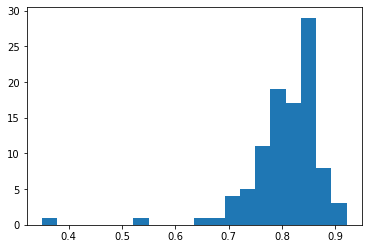

In [57]:
plt.hist(df['Accuracies'], 20)

In [62]:
df['Accuracies'].mean()

0.8055357647949262

Same process but for region data


'/mnt/batch/tasks/shared/LS_root/mounts/clusters/nance8core/code/Users/nlsschim/diff_predictor'

In [6]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '5b7e9376-1907-45b5-b8cf-6fde28c54e67'
resource_group = 'mpt_projects'
workspace_name = 'ecm_project'

workspace = Workspace(subscription_id, resource_group, workspace_name)

datasetpath = getcwd()

dataset = Dataset.get_by_name(workspace, name='region_MPT_data')
dataset.download(target_path='.', overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/.DS_Store',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_cortex_vid_10.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_cortex_vid_6.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_cortex_vid_7.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_cortex_vid_8.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_cortex_vid_9.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_ganglia_vid_1.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_ganglia_vid_2.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_ganglia_vid_3.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_hippocampus_vid_1.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_hippocampus_vid_2.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_hippocampus_vid_3.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_striatum_vid_1.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_striatum_vid_2.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_striatum_vid_3.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_striatum_vid_4.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_striatum_vid_5.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_thalamus_vid_1.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_thalamus_vid_2.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_1_thalamus_vid_3.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_cortex_vid_1.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_cortex_vid_2.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_cortex_vid_3.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_cortex_vid_4.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_cortex_vid_5.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_ganglia_vid_1.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_ganglia_vid_2.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_ganglia_vid_3.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_hippocampus_vid_1.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_slice_2_hippocampus_vid_2.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nancegpu/code/Users/nlsschim/diff_predictor/feat_NT_sli

In [7]:
filelist = []
for file in dataset.to_path():
    filelist.append(file)


In [34]:
brain_regions = ['cortex', 'ganglia', 'hippocampus', 'striatum', 'thalamus']
sampled_filelist = []
for region in brain_regions:
    filelist = [f for f in dataset.to_path() if region in f]
    rand_integers = random.sample(set(np.arange(0, len(filelist))), 2)
    for rand_int in rand_integers:
            sampled_filelist.append(filelist[rand_int])


cortex
10

ganglia
6

hippocampus
6

striatum
10

thalamus
6



['/feat_NT_slice_1_cortex_vid_7.csv',
 '/feat_NT_slice_2_cortex_vid_1.csv',
 '/feat_NT_slice_1_ganglia_vid_1.csv',
 '/feat_NT_slice_1_ganglia_vid_2.csv',
 '/feat_NT_slice_2_hippocampus_vid_1.csv',
 '/feat_NT_slice_2_hippocampus_vid_2.csv',
 '/feat_NT_slice_2_striatum_vid_3.csv',
 '/feat_NT_slice_2_striatum_vid_2.csv',
 '/feat_NT_slice_2_thalamus_vid_2.csv',
 '/feat_NT_slice_2_thalamus_vid_3.csv']

In [8]:
acc_list = []
true_label_list = []
preds_list = []
distances_list = []
for i in range(100):
    brain_regions = ['cortex', 'ganglia', 'hippocampus', 'striatum', 'thalamus']
    sampled_filelist = []
    for region in brain_regions:
        filelist = [f for f in dataset.to_path() if region in f]
        rand_integers = random.sample(set(np.arange(0, len(filelist))), 2)
        for rand_int in rand_integers:
            sampled_filelist.append(filelist[rand_int])
    fstats_tot = data_process.generate_fullstats(datasetpath, sampled_filelist, ['cortex', 'ganglia', 'hippocampus', 'striatum', 'thalamus'], 'region')
    ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y', 'dist_tot']]
    ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)] 
    bal_ecm = data_process.balance_data(ecm, target)
    sampled_df = data_process.bin_data(bal_ecm)
    label_df = sampled_df['region']
    features_df = sampled_df.drop(['region', 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID', 'dist_tot'], axis=1)
    features = features_df.columns
    
    seed = 1234
    np.random.seed(seed)
    train_split = 0.5
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=20)
    acc_list.append(acc)
    true_label_list.append(true_label)
    preds_list.append(preds)
    distances_list.append(sampled_df['dist_tot'].to_list()) # returning list of distance values for trajectories

output_dict = {'Accuracies': acc_list, 'True Labels': true_label_list, 'Preds': preds_list, 'Distances': distances_list}
df = pd.DataFrame(output_dict)

Adding file /feat_NT_slice_1_cortex_vid_10.csv size: (4832, 67)
Adding file /feat_NT_slice_1_cortex_vid_9.csv size: (6506, 67)
Adding file /feat_NT_slice_1_ganglia_vid_2.csv size: (533, 67)
Adding file /feat_NT_slice_1_ganglia_vid_3.csv size: (514, 67)
Adding file /feat_NT_slice_2_hippocampus_vid_2.csv size: (46, 67)
Adding file /feat_NT_slice_1_hippocampus_vid_1.csv size: (4149, 67)
Adding file /feat_NT_slice_2_striatum_vid_1.csv size: (8314, 67)
Adding file /feat_NT_slice_2_striatum_vid_5.csv size: (13938, 67)
Adding file /feat_NT_slice_1_thalamus_vid_3.csv size: (1894, 67)
Adding file /feat_NT_slice_2_thalamus_vid_3.csv size: (1106, 67)


KeyError: "['dist_tot'] not in index"